### Packages

In [428]:
import numpy as np
np.set_printoptions(precision=2)
import scipy.stats as stats
import matplotlib.pyplot as plt

### Cournot

Dynamic Demand:
- $p_t = u_t - v \sum_i q_{it} + x_t$ 
- $x_t = \rho x_{t-1} + e_t, e_t \sim N(0,\sigma)$

Walrasian 
- $\pi_w = \max_{q_i}{(p - w) q_i}$ 
- $w = u - v Q$
- $Q_w = \frac{u-w}{v}$
- $P_w = w$
- $q_w \in [0,Q_w], \pi_w = 0, \Pi_w = 0$

Nash
- $\pi_c = \max_{q_i}{(p(Q) - w) q_i}$ 
- $p(Q) - w - v q_i = 0$
- $n p(Q) = n w + v Q = n u - n v Q$
- $Q_c = \frac{n(u-w)}{v(n+1)}$
- $P_c = u - v Q$
- $q_c = Q_c/n$

Monopoly
- $\pi_m = \max_{Q}{(p(Q) - w) Q}$ 
- $p(Q)=w+vQ=u-vQ$ 
- $Q_m =\frac{u-w}{2v}$ 
- $P_m =\frac{u-w}{2v}$


In [457]:
# parameters of model
gamma = 0.9
u = 40
v = 1
w = 4
n = 2
sigma = 0.05
rho = 0.1

In [458]:
def price(Q,u,v):
    return u-v*Q

def profit(P,Q):
    return
           
class cournot:
    def __init__(self,u,v,w,n):
        self.u=u
        self.v=v
        self.w=w
        self.n=n
        self.Qw=(u-w)/v
        self.Qc=n*(u-w)/v/(n+1)
        self.Qm=(u-w)/2*v
        self.Pw = price(self.Qw,u,v)
        self.Pc = price(self.Qc,u,v)
        self.Pm = price(self.Qm,u,v)
        self.Πw = 0
        self.Πc = (self.Pc-w)*self.Qc
        self.Πm = (self.Pm-w)*self.Qm
        self.qw = self.Qw/n
        self.qc = self.Qc/n
        self.qm = self.Qm/n
        self.πw = 0
        self.πc = self.Πc/n
        self.πm = self.Πm/n
    
    def price(self,q,q_):
        return self.u-v*(q+q_)
    
    def profit(self,q,q_):
        return (self.price(q,q_)-w)*q
        
game1 = cournot(40,1,4,2)

In [459]:
game1.Qc, game1.qc, game1.Pc, game1.w, game1.Πc, game1.profit(12,12)

(24.0, 12.0, 16.0, 4, 288.0, 144)

In [460]:
game1.Qm, game1.qm, game1.Pm, game1.w, game1.Πm, game1.profit(9,9)

(18.0, 9.0, 22.0, 4, 324.0, 162)

### Shocks

In [461]:
# Input: ρ, σ, K
# Output: KxK Transition Matrix
ρ, σ, K = 0.9, 1, 10
σy = σ/np.sqrt(1-ρ**2)

def tauchen(ρ, σ, K, m=3):
    Z = np.linspace(-m * σ/np.sqrt(1-ρ**2), m * σ/np.sqrt(1-ρ**2), K) # Shock Space
    F = lambda x: stats.norm.cdf(x, 0, σ) # CDF Function for Standard Normal
    α = Z[2] - Z[1] # Step Size
    P = np.zeros((K,K)) # Placeholder Transition Matrix
    # P[i,j] is probability of process going from Zi to Zj 
    for i in range(K):
        for j in range(K):
            if j == 1:
                P[i, j] = F(Z[j]+α/2-ρ*Z[i])
            elif j == K:
                P[i, j] = 1 - F(Z[j]-α/2-ρ*Z[i])
            else:
                P[i, j] = F(Z[j]+α/2-ρ*Z[i]) - F(Z[j]-α/2-ρ*Z[i])
        P[i, :] = P[i, :]/sum(P[i, :])
    return Z, α, F, P
        
def whichidx(value, array):
    return np.argmin(np.abs(array-value))

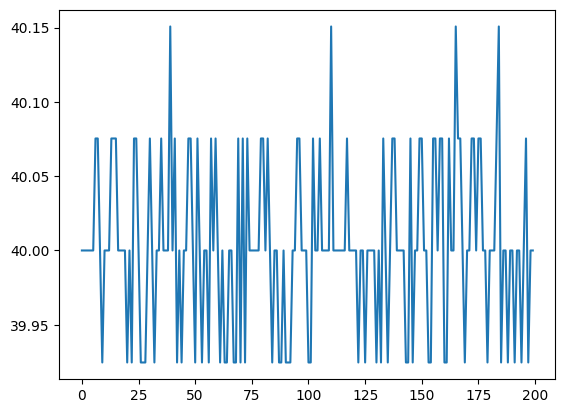

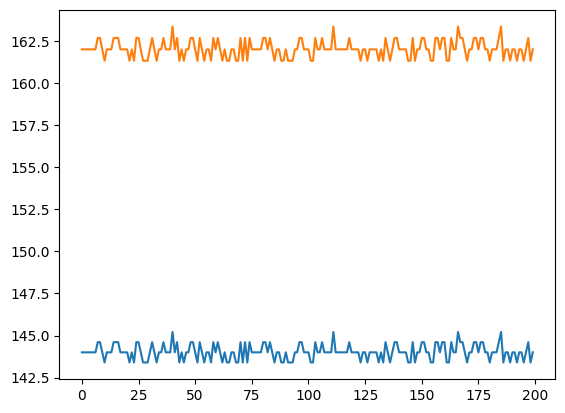

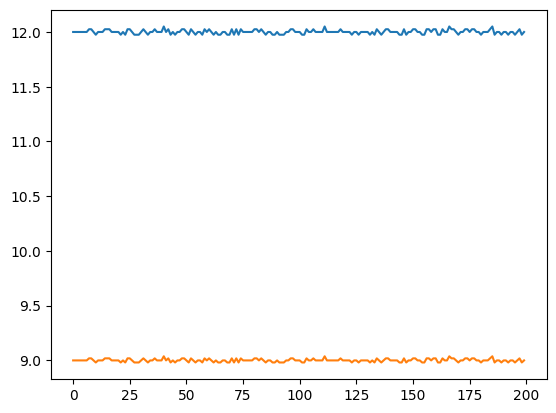

In [462]:
import numpy as np
e = np.random.normal(1)*sigma
K = 5
Z, α, F, P = tauchen(rho, sigma, K, m=3)
u_history=[]
qc_history=[]
qm_history=[]
pc_history=[]
pm_history=[]

uidx = 0
for t in range(200):
    # find competition level profit 
    qc_history.append(cournot(u,v,w,n).qc)
    qm_history.append(cournot(u,v,w,n).qm)
    pc_history.append(cournot(u,v,w,n).πc)
    pm_history.append(cournot(u,v,w,n).πm)
   
    # generate next shock
    uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]
    u_history.append(u)
    
plt.plot(u_history)
plt.show()

plt.plot(pc_history)
plt.plot(pm_history)
plt.show()

plt.plot(qc_history)
plt.plot(qm_history)
plt.show()

### Q-Learning

In [465]:
import random
import numpy as np

# define the Boltzmann action selection function
def boltzmann_action_selection(Q, state1, state2, temperature):
    # compute the modified probabilities of each action using the Boltzmann distribution
    max_Q = np.max(Q[state1, state2,:])
    logits = (Q[state1, state2,:] - max_Q) / temperature
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    # select an action using the computed probabilities
    action = np.random.choice(range(len(probs)), p=probs)
    return action


# initialize the state
state1 = 0
state2 = 0
u = 0
uidx = 0

# initialize the Q-table
game = game1
num_states1 = 25
num_states2 = 5
num_actions = 25
Z, α, F, P = tauchen(rho, sigma, num_states2, m=3)
uidx = int(round(num_states2/2))

# parameters of model
gamma = 0.9
u = 40
v = 1
w = 4
n = 2
sigma = 0.05
rho = 0.1


Q1 = np.random.uniform(cournot(u,v,w,n).πc,cournot(u,v,w,n).πm,(num_states1, num_states2, num_actions))
Q2 = np.random.uniform(cournot(u,v,w,n).πc,cournot(u,v,w,n).πm,(num_states1, num_states2, num_actions))

# histories
q1_history = []
q2_history = []
u_history = []
qc_history=[]
qm_history=[]
pc_history=[]
pm_history=[]

action2quantity = np.linspace(cournot(u,v,w,n).qc*0.8,cournot(u,v,w,n).qc*1.2,num_actions)
action2quantity


array([ 9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. , 11.2, 11.4, 11.6,
       11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2, 13.4, 13.6, 13.8,
       14. , 14.2, 14.4])

In [504]:

# initialize Boltzmann Q-learning parameters
alpha = 0.2
initial_temperature = 1.0
temperature_decay = 0.99999
min_temperature = 0.1
temperature = initial_temperature
initial_eps = 1.0
eps_decay = 0.99999
min_eps = 0.05
eps = initial_eps
errors = []


In [533]:

# run Boltzmann Q-learning for a fixed number of episodes
num_episodes = 100000
for episode in range(num_episodes):

    if np.random.uniform()>eps:
        # select an action using Boltzmann action selection
        action1 = boltzmann_action_selection(Q1, state1, uidx, temperature)
    else:
        action1 = np.random.choice(range(num_actions))

    if np.random.uniform()>eps:
        # select an action using Boltzmann action selection
        action2 = boltzmann_action_selection(Q2, state2, uidx, temperature)
    else:
        action2 = np.random.choice(range(num_actions))

    quantity1 = action2quantity[action1]
    quantity2 = action2quantity[action2]

    # take the selected action and observe the next state and reward
    next_state1 = action2
    next_state2 = action1

    # rewards
    reward1 = cournot(u,v,w,n).profit(quantity1,quantity2)
    reward2 = cournot(u,v,w,n).profit(quantity2,quantity1)

    # update the Q-value for the selected action in the current state
    Q1[state1][uidx][action1] =  (1-alpha)*Q1[state1][uidx][action1] + alpha * (reward1 + gamma * np.max(np.average(Q1[next_state1],axis=0,weights=P[uidx])))
    Q2[state2][uidx][action2] =  (1-alpha)*Q2[state2][uidx][action2] + alpha * (reward2 + gamma * np.max(np.average(Q2[next_state2],axis=0,weights=P[uidx])))
    
   # generate shock
    uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]
    
    # move to the next state
    state1 = next_state1
    state2 = next_state2

    # update temperature
    temperature = max(min_temperature, temperature * temperature_decay)
    eps = max(min_eps, eps * eps_decay)
    error = reward1 + gamma * np.max(Q1[next_state1][uidx])-Q1[state1][uidx][action1] 
    errors.append(error)
    if num_episodes>1000:
        print(f'{episode},{np.mean(errors[-1000:]):0.2f},{uidx:0.2f}, {action1:0.2f}, {action2:0.2f}, {reward1:0.2f}, {reward2:0.2f}, {temperature:0.2f}, {eps:0.2f}')
    
    u_history.append(u)
    q1_history.append(quantity1)
    q2_history.append(quantity2)
    qc_history.append(cournot(u,v,w,n).qc)
    qm_history.append(cournot(u,v,w,n).qm)
    pc_history.append(cournot(u,v,w,n).profit(quantity1,quantity2))
    pm_history.append(cournot(u,v,w,n).profit(quantity1,quantity2))
  

0,20.65,2.00, 21.00, 7.00, -342.24, -272.80, 5.00, 0.14
1,20.63,1.00, 16.00, 14.00, 138.24, 133.92, 5.00, 0.14
2,20.64,2.00, 3.00, 17.00, 129.79, 165.42, 5.00, 0.14
3,20.63,1.00, 14.00, 13.00, 141.36, 139.08, 5.00, 0.14
4,20.61,1.00, 2.00, 18.00, 127.25, 167.97, 5.00, 0.14
5,20.63,2.00, 13.00, 12.00, 143.04, 140.70, 5.00, 0.14
6,20.60,2.00, 9.00, 21.00, 123.12, 149.04, 5.00, 0.14
7,20.62,3.00, 2.00, 9.00, 146.00, 166.44, 5.00, 0.14
8,20.98,4.00, 24.00, 17.00, 124.93, 112.78, 5.00, 0.14
9,20.97,3.00, 23.00, 14.00, 135.62, 118.43, 5.00, 0.14
10,20.99,2.00, 2.00, 10.00, 144.75, 167.91, 5.00, 0.14
11,20.98,3.00, 10.00, 10.00, 148.48, 148.48, 5.00, 0.14
12,20.95,3.00, 7.00, 22.00, 121.83, 155.06, 5.00, 0.14
13,20.97,2.00, 18.00, 13.00, 140.91, 130.24, 5.00, 0.14
14,20.98,3.00, 13.00, 15.00, 136.64, 141.12, 5.00, 0.14
15,20.97,2.00, 22.00, 20.00, 118.66, 115.27, 5.00, 0.14
16,20.98,3.00, 4.00, 22.00, 120.64, 162.40, 5.00, 0.14
17,20.97,2.00, 9.00, 24.00, 117.14, 147.97, 5.00, 0.14
18,20.98,1

541,20.15,4.00, 12.00, 14.00, 139.20, 143.84, 4.97, 0.13
542,20.13,3.00, 12.00, 14.00, 141.01, 145.71, 4.97, 0.13
543,20.14,1.00, 0.00, 13.00, 137.04, 174.16, 4.97, 0.13
544,20.12,1.00, 10.00, 15.00, 136.01, 147.73, 4.97, 0.13
545,20.12,2.00, 7.00, 13.00, 139.97, 155.24, 4.97, 0.13
546,20.09,3.00, 24.00, 19.00, 118.08, 109.88, 4.97, 0.13
547,20.09,2.00, 17.00, 13.00, 141.38, 132.68, 4.97, 0.13
548,20.07,3.00, 20.00, 21.00, 116.96, 118.68, 4.97, 0.13
549,20.07,2.00, 20.00, 11.00, 145.19, 125.97, 4.97, 0.13
550,20.07,2.00, 8.00, 10.00, 147.84, 153.12, 4.97, 0.13
551,20.08,2.00, 10.00, 2.00, 167.04, 144.00, 4.97, 0.13
552,20.06,1.00, 3.00, 7.00, 150.96, 162.80, 4.97, 0.13
553,20.07,2.00, 10.00, 4.00, 161.53, 144.82, 4.97, 0.13
554,20.10,2.00, 16.00, 11.00, 145.92, 134.52, 4.97, 0.13
555,20.09,2.00, 3.00, 7.00, 150.96, 162.80, 4.97, 0.13
556,20.13,2.00, 10.00, 0.00, 171.68, 142.08, 4.97, 0.13
557,20.15,1.00, 15.00, 3.00, 166.32, 134.64, 4.97, 0.13
558,20.15,2.00, 7.00, 11.00, 144.37, 154.8

875,22.94,2.00, 10.00, 14.00, 138.33, 147.87, 4.96, 0.13
876,22.96,1.00, 1.00, 7.00, 148.96, 167.20, 4.96, 0.13
877,22.96,3.00, 17.00, 13.00, 139.42, 130.84, 4.96, 0.13
878,22.98,2.00, 16.00, 17.00, 131.52, 133.58, 4.96, 0.13
879,23.01,2.00, 1.00, 5.00, 152.88, 165.36, 4.96, 0.13
880,23.03,2.00, 22.00, 11.00, 142.80, 120.36, 4.96, 0.13
881,23.01,2.00, 23.00, 18.00, 122.12, 113.52, 4.96, 0.13
882,23.01,1.00, 18.00, 9.00, 150.48, 129.96, 4.96, 0.13
883,22.27,2.00, 9.00, 10.00, 147.34, 149.93, 4.96, 0.13
884,22.29,2.00, 6.00, 10.00, 146.88, 157.76, 4.96, 0.13
885,22.30,1.00, 6.00, 11.00, 144.72, 158.12, 4.96, 0.13
886,22.31,2.00, 21.00, 13.00, 136.96, 121.08, 4.96, 0.13
887,22.30,3.00, 4.00, 14.00, 137.28, 163.68, 4.96, 0.13
888,22.29,2.00, 7.00, 22.00, 121.83, 155.06, 4.96, 0.13
889,22.32,3.00, 13.00, 6.00, 158.60, 140.40, 4.96, 0.13
890,22.33,3.00, 19.00, 14.00, 137.69, 127.41, 4.96, 0.13
891,22.32,2.00, 10.00, 18.00, 130.79, 148.83, 4.96, 0.13
892,22.29,3.00, 18.00, 21.00, 118.80, 124.

1273,23.68,1.00, 13.00, 4.00, 164.40, 140.14, 4.94, 0.13
1274,23.68,2.00, 18.00, 10.00, 146.85, 129.05, 4.94, 0.13
1275,23.66,2.00, 12.00, 17.00, 132.00, 143.00, 4.94, 0.13
1276,23.65,2.00, 13.00, 15.00, 136.64, 141.12, 4.94, 0.13
1277,23.61,2.00, 11.00, 23.00, 118.00, 142.00, 4.94, 0.13
1278,23.58,1.00, 11.00, 23.00, 118.00, 142.00, 4.94, 0.13
1279,23.57,1.00, 3.00, 17.00, 129.79, 165.42, 4.94, 0.13
1280,23.62,2.00, 20.00, 6.00, 156.73, 124.47, 4.94, 0.13
1281,23.63,2.00, 21.00, 11.00, 143.52, 122.72, 4.94, 0.13
1282,23.64,2.00, 19.00, 4.00, 163.48, 126.88, 4.94, 0.13
1283,23.64,2.00, 1.00, 10.00, 143.08, 169.36, 4.94, 0.13
1284,23.63,1.00, 9.00, 9.00, 150.48, 150.48, 4.94, 0.13
1285,23.61,1.00, 9.00, 14.00, 138.22, 150.35, 4.94, 0.13
1286,23.59,2.00, 22.00, 18.00, 122.14, 115.17, 4.94, 0.13
1287,23.54,3.00, 15.00, 22.00, 118.44, 131.60, 4.94, 0.13
1288,23.53,3.00, 17.00, 15.00, 136.18, 131.99, 4.94, 0.13
1289,23.53,1.00, 4.00, 1.00, 165.10, 155.58, 4.94, 0.13
1290,23.54,2.00, 8.00, 1

1549,24.59,3.00, 16.00, 16.00, 132.16, 132.16, 4.92, 0.13
1550,24.57,3.00, 7.00, 17.00, 132.83, 156.98, 4.92, 0.13
1551,24.55,2.00, 16.00, 7.00, 157.12, 135.03, 4.92, 0.13
1552,24.54,2.00, 0.00, 15.00, 132.48, 173.88, 4.92, 0.13
1553,24.51,3.00, 4.00, 18.00, 128.96, 163.68, 4.92, 0.13
1554,24.46,3.00, 23.00, 24.00, 106.15, 107.65, 4.92, 0.13
1555,24.46,1.00, 14.00, 15.00, 137.33, 139.55, 4.92, 0.13
1556,24.42,1.00, 9.00, 17.00, 131.38, 149.82, 4.92, 0.13
1557,24.41,1.00, 8.00, 6.00, 155.96, 150.39, 4.92, 0.13
1558,24.42,1.00, 2.00, 4.00, 155.25, 161.46, 4.92, 0.13
1559,24.43,3.00, 22.00, 2.00, 166.94, 119.25, 4.92, 0.13
1560,24.43,3.00, 4.00, 5.00, 156.78, 159.80, 4.92, 0.13
1561,24.80,0.00, 12.00, 22.00, 120.90, 141.06, 4.92, 0.13
1562,24.80,1.00, 9.00, 8.00, 151.04, 148.39, 4.92, 0.13
1563,24.85,2.00, 6.00, 2.00, 163.35, 151.25, 4.92, 0.13
1564,24.82,1.00, 17.00, 16.00, 132.60, 130.56, 4.92, 0.13
1565,24.86,2.00, 7.00, 3.00, 161.97, 150.19, 4.92, 0.13
1566,25.09,0.00, 16.00, 13.00, 1

1859,24.92,3.00, 8.00, 22.00, 121.80, 152.26, 4.91, 0.13
1860,24.89,2.00, 3.00, 17.00, 131.33, 167.38, 4.91, 0.13
1861,24.89,3.00, 0.00, 8.00, 145.92, 170.24, 4.91, 0.13
1862,24.91,3.00, 21.00, 4.00, 163.88, 123.50, 4.91, 0.13
1863,24.93,2.00, 21.00, 7.00, 155.60, 124.03, 4.91, 0.13
1864,24.93,2.00, 5.00, 7.00, 152.64, 158.40, 4.91, 0.13
1865,24.93,1.00, 7.00, 17.00, 132.00, 156.00, 4.91, 0.13
1866,24.92,2.00, 16.00, 7.00, 155.20, 133.37, 4.91, 0.13
1867,24.92,2.00, 7.00, 11.00, 145.20, 155.76, 4.91, 0.13
1868,24.92,1.00, 23.00, 20.00, 116.44, 111.52, 4.91, 0.13
1869,24.96,3.00, 19.00, 0.00, 173.19, 124.08, 4.91, 0.13
1870,24.96,1.00, 14.00, 6.00, 159.65, 139.05, 4.91, 0.13
1871,24.97,2.00, 12.00, 12.00, 143.10, 143.10, 4.91, 0.13
1872,25.00,3.00, 6.00, 2.00, 164.16, 152.00, 4.91, 0.13
1873,24.96,2.00, 6.00, 18.00, 130.41, 159.39, 4.91, 0.13
1874,24.93,3.00, 20.00, 20.00, 119.68, 119.68, 4.91, 0.13
1875,24.94,2.00, 17.00, 8.00, 154.38, 133.00, 4.91, 0.13
1876,24.95,2.00, 17.00, 12.00, 

2220,23.91,1.00, 19.00, 19.00, 122.27, 122.27, 4.89, 0.13
2221,23.95,2.00, 14.00, 2.00, 167.71, 135.25, 4.89, 0.13
2222,23.98,3.00, 3.00, 8.00, 148.92, 163.52, 4.89, 0.13
2223,23.98,2.00, 7.00, 15.00, 137.23, 157.19, 4.89, 0.13
2224,24.02,2.00, 7.00, 6.00, 156.20, 153.36, 4.89, 0.13
2225,24.03,2.00, 7.00, 5.00, 158.40, 152.64, 4.89, 0.13
2226,24.05,1.00, 15.00, 11.00, 146.16, 136.88, 4.89, 0.13
2227,24.00,3.00, 8.00, 16.00, 133.56, 152.64, 4.89, 0.13
2228,23.99,2.00, 11.00, 21.00, 123.61, 144.56, 4.89, 0.13
2229,24.01,1.00, 12.00, 6.00, 158.40, 142.56, 4.89, 0.13
2230,23.99,2.00, 13.00, 8.00, 152.80, 140.28, 4.89, 0.13
2231,24.01,2.00, 13.00, 6.00, 158.60, 140.40, 4.89, 0.13
2232,24.03,2.00, 7.00, 14.00, 138.60, 156.24, 4.89, 0.13
2233,24.02,2.00, 13.00, 20.00, 124.44, 138.72, 4.89, 0.13
2234,24.00,2.00, 1.00, 21.00, 121.52, 171.12, 4.89, 0.13
2235,23.96,2.00, 12.00, 23.00, 117.60, 139.16, 4.89, 0.13
2236,23.98,1.00, 2.00, 2.00, 160.00, 160.00, 4.89, 0.13
2237,23.96,3.00, 3.00, 21.00, 

2631,25.18,2.00, 4.00, 13.00, 140.93, 165.32, 4.87, 0.13
2632,25.16,3.00, 5.00, 13.00, 139.92, 161.04, 4.87, 0.13
2633,25.16,1.00, 12.00, 16.00, 135.30, 144.32, 4.87, 0.13
2634,25.19,1.00, 24.00, 4.00, 160.19, 115.70, 4.87, 0.13
2635,25.14,1.00, 9.00, 23.00, 117.70, 146.61, 4.87, 0.13
2636,25.09,3.00, 22.00, 23.00, 108.14, 109.69, 4.87, 0.13
2637,25.13,2.00, 12.00, 9.00, 152.10, 144.50, 4.87, 0.13
2638,25.12,1.00, 3.00, 15.00, 134.64, 166.32, 4.87, 0.13
2639,25.11,2.00, 15.00, 10.00, 147.73, 136.01, 4.87, 0.13
2640,25.10,1.00, 15.00, 14.00, 138.60, 136.40, 4.87, 0.13
2641,25.10,3.00, 5.00, 5.00, 156.08, 156.08, 4.87, 0.13
2642,25.07,1.00, 2.00, 21.00, 122.75, 169.40, 4.87, 0.13
2643,25.08,1.00, 18.00, 6.00, 157.41, 128.79, 4.87, 0.13
2644,25.10,2.00, 11.00, 6.00, 157.23, 143.91, 4.87, 0.13
2645,25.11,3.00, 9.00, 2.00, 166.44, 146.00, 4.87, 0.13
2646,25.07,2.00, 6.00, 22.00, 121.77, 157.86, 4.87, 0.13
2647,25.05,2.00, 17.00, 9.00, 150.80, 132.24, 4.87, 0.13
2648,25.02,3.00, 18.00, 20.00

3011,25.36,3.00, 7.00, 6.00, 157.03, 154.17, 4.85, 0.13
3012,25.36,2.00, 7.00, 17.00, 132.83, 156.98, 4.85, 0.13
3013,25.34,3.00, 9.00, 15.00, 136.80, 151.20, 4.85, 0.13
3014,25.39,3.00, 13.00, 1.00, 171.72, 137.94, 4.85, 0.13
3015,25.39,2.00, 23.00, 16.00, 128.87, 116.16, 4.85, 0.13
3016,25.37,1.00, 12.00, 24.00, 115.20, 138.24, 4.85, 0.13
3017,25.22,2.00, 1.00, 18.00, 126.66, 170.61, 4.85, 0.13
3018,25.18,2.00, 15.00, 24.00, 113.40, 129.60, 4.85, 0.13
3019,25.20,3.00, 22.00, 3.00, 165.20, 120.36, 4.85, 0.13
3020,25.23,3.00, 0.00, 9.00, 144.72, 171.86, 4.85, 0.13
3021,25.19,1.00, 15.00, 23.00, 116.87, 131.71, 4.85, 0.13
3022,25.19,2.00, 7.00, 11.00, 144.37, 154.87, 4.85, 0.13
3023,25.18,2.00, 12.00, 14.00, 139.20, 143.84, 4.85, 0.13
3024,25.41,4.00, 10.00, 15.00, 136.88, 148.68, 4.85, 0.13
3025,25.43,3.00, 5.00, 7.00, 154.24, 160.06, 4.85, 0.13
3026,25.42,2.00, 12.00, 14.00, 140.10, 144.77, 4.85, 0.13
3027,25.44,2.00, 8.00, 1.00, 168.00, 147.00, 4.85, 0.13
3028,25.43,1.00, 5.00, 12.00

3412,26.95,2.00, 10.00, 16.00, 135.43, 149.44, 4.83, 0.13
3413,26.53,2.00, 9.00, 17.00, 132.24, 150.80, 4.83, 0.13
3414,26.54,2.00, 21.00, 15.00, 132.48, 120.96, 4.83, 0.13
3415,26.53,2.00, 4.00, 13.00, 139.36, 163.48, 4.83, 0.13
3416,26.51,2.00, 18.00, 16.00, 132.00, 128.00, 4.83, 0.13
3417,26.51,1.00, 14.00, 19.00, 126.48, 136.68, 4.83, 0.13
3418,26.55,2.00, 19.00, 7.00, 154.43, 126.77, 4.83, 0.13
3419,26.54,2.00, 3.00, 9.00, 146.88, 164.16, 4.83, 0.13
3420,26.55,2.00, 4.00, 0.00, 166.40, 153.60, 4.83, 0.13
3421,26.58,2.00, 15.00, 4.00, 163.80, 135.20, 4.83, 0.13
3422,26.59,1.00, 16.00, 14.00, 138.24, 133.92, 4.83, 0.13
3423,26.55,1.00, 15.00, 18.00, 127.57, 133.65, 4.83, 0.13
3424,26.54,2.00, 11.00, 14.00, 138.35, 145.39, 4.83, 0.13
3425,26.52,2.00, 11.00, 17.00, 132.16, 145.60, 4.83, 0.13
3426,26.48,2.00, 7.00, 22.00, 121.00, 154.00, 4.83, 0.13
3427,26.50,2.00, 13.00, 8.00, 153.72, 141.12, 4.83, 0.13
3428,26.55,1.00, 7.00, 2.00, 165.00, 150.00, 4.83, 0.13
3429,26.55,2.00, 15.00, 15

3801,29.71,1.00, 24.00, 20.00, 115.20, 108.80, 4.81, 0.13
3802,29.68,3.00, 6.00, 19.00, 126.63, 157.11, 4.81, 0.13
3803,29.69,2.00, 21.00, 0.00, 174.92, 121.68, 4.81, 0.13
3804,29.69,2.00, 10.00, 14.00, 139.20, 148.80, 4.81, 0.13
3805,29.69,2.00, 15.00, 16.00, 133.56, 135.68, 4.81, 0.13
3806,29.71,1.00, 3.00, 15.00, 134.64, 166.32, 4.81, 0.13
3807,29.71,1.00, 13.00, 19.00, 125.96, 138.35, 4.81, 0.13
3808,29.73,2.00, 14.00, 10.00, 147.87, 138.33, 4.81, 0.13
3809,29.75,1.00, 9.00, 4.00, 161.88, 147.68, 4.81, 0.13
3810,29.71,2.00, 13.00, 19.00, 125.96, 138.35, 4.81, 0.13
3811,29.75,2.00, 17.00, 1.00, 171.60, 129.36, 4.81, 0.13
3812,29.75,3.00, 23.00, 14.00, 133.48, 116.56, 4.81, 0.13
3813,29.71,2.00, 3.00, 23.00, 119.09, 165.79, 4.81, 0.13
3814,29.70,1.00, 12.00, 14.00, 139.20, 143.84, 4.81, 0.13
3815,29.71,2.00, 7.00, 17.00, 131.17, 155.02, 4.81, 0.13
3816,29.75,1.00, 16.00, 1.00, 171.52, 131.32, 4.81, 0.13
3817,29.47,2.00, 2.00, 17.00, 129.25, 168.02, 4.81, 0.13
3818,29.43,2.00, 16.00, 

4157,29.95,2.00, 11.00, 21.00, 121.83, 142.48, 4.80, 0.13
4158,29.97,2.00, 13.00, 12.00, 143.96, 141.60, 4.80, 0.13
4159,29.99,2.00, 7.00, 9.00, 149.60, 155.04, 4.80, 0.13
4160,29.95,1.00, 3.00, 18.00, 128.52, 166.32, 4.80, 0.13
4161,29.94,2.00, 15.00, 13.00, 140.17, 135.72, 4.80, 0.13
4162,29.95,2.00, 24.00, 7.00, 152.64, 116.60, 4.80, 0.13
4163,29.95,3.00, 9.00, 11.00, 145.92, 151.04, 4.80, 0.13
4164,29.96,2.00, 12.00, 4.00, 164.10, 142.22, 4.80, 0.13
4165,30.01,2.00, 9.00, 2.00, 166.44, 146.00, 4.80, 0.13
4166,29.99,1.00, 7.00, 18.00, 129.80, 155.76, 4.80, 0.13
4167,29.97,2.00, 18.00, 12.00, 141.57, 128.70, 4.80, 0.13
4168,29.97,2.00, 12.00, 11.00, 146.40, 143.96, 4.80, 0.13
4169,29.95,2.00, 12.00, 10.00, 148.80, 143.84, 4.80, 0.13
4170,29.95,2.00, 17.00, 15.00, 135.20, 131.04, 4.80, 0.13
4171,29.93,2.00, 21.00, 21.00, 115.92, 115.92, 4.80, 0.13
4172,29.90,3.00, 12.00, 17.00, 132.00, 143.00, 4.80, 0.13
4173,28.82,3.00, 13.00, 8.00, 154.64, 141.96, 4.80, 0.13
4174,28.82,1.00, 18.00, 

4532,25.29,2.00, 20.00, 17.00, 128.87, 123.18, 4.78, 0.13
4533,25.29,2.00, 21.00, 10.00, 146.28, 122.96, 4.78, 0.13
4534,25.26,1.00, 5.00, 20.00, 125.08, 160.48, 4.78, 0.13
4535,25.22,3.00, 19.00, 14.00, 135.67, 125.55, 4.78, 0.13
4536,25.26,3.00, 20.00, 3.00, 166.95, 125.21, 4.78, 0.13
4537,25.25,3.00, 16.00, 21.00, 121.28, 130.76, 4.78, 0.13
4538,25.25,3.00, 12.00, 13.00, 142.50, 144.88, 4.78, 0.13
4539,25.25,1.00, 18.00, 11.00, 146.19, 130.69, 4.78, 0.13
4540,25.24,1.00, 14.00, 16.00, 132.99, 137.28, 4.78, 0.13
4541,25.24,1.00, 9.00, 13.00, 140.50, 150.36, 4.78, 0.13
4542,25.23,3.00, 3.00, 15.00, 133.87, 165.37, 4.78, 0.13
4543,25.24,2.00, 10.00, 11.00, 147.03, 149.57, 4.78, 0.13
4544,25.23,2.00, 13.00, 14.00, 139.08, 141.36, 4.78, 0.13
4545,25.22,1.00, 15.00, 10.00, 148.68, 136.88, 4.78, 0.13
4546,25.23,2.00, 13.00, 8.00, 152.80, 140.28, 4.78, 0.13
4547,25.27,2.00, 19.00, 2.00, 168.84, 126.00, 4.78, 0.13
4548,25.30,2.00, 16.00, 5.00, 161.28, 133.56, 4.78, 0.13
4549,25.20,3.00, 11.0

4915,23.72,3.00, 9.00, 7.00, 155.04, 149.60, 4.76, 0.13
4916,23.72,2.00, 20.00, 13.00, 139.75, 125.36, 4.76, 0.13
4917,23.73,1.00, 5.00, 10.00, 146.28, 160.08, 4.76, 0.13
4918,23.73,2.00, 0.00, 17.00, 127.92, 173.22, 4.76, 0.13
4919,23.72,3.00, 9.00, 12.00, 143.64, 151.20, 4.76, 0.13
4920,23.74,2.00, 14.00, 5.00, 162.13, 138.60, 4.76, 0.13
4921,23.77,1.00, 22.00, 10.00, 145.60, 120.64, 4.76, 0.13
4922,23.78,3.00, 2.00, 2.00, 159.25, 159.25, 4.76, 0.13
4923,23.79,1.00, 13.00, 16.00, 135.12, 141.76, 4.76, 0.13
4924,23.79,2.00, 15.00, 8.00, 152.77, 135.80, 4.76, 0.13
4925,23.80,2.00, 3.00, 8.00, 148.92, 163.52, 4.76, 0.13
4926,23.77,2.00, 6.00, 23.00, 118.80, 156.20, 4.76, 0.13
4927,23.76,1.00, 11.00, 11.00, 146.32, 146.32, 4.76, 0.13
4928,23.73,2.00, 16.00, 16.00, 132.16, 132.16, 4.76, 0.13
4929,23.72,2.00, 11.00, 6.00, 158.12, 144.72, 4.76, 0.13
4930,23.73,2.00, 22.00, 4.00, 162.40, 120.64, 4.76, 0.13
4931,24.26,4.00, 16.00, 5.00, 161.28, 133.56, 4.76, 0.13
4932,24.28,3.00, 17.00, 5.00,

5278,24.48,2.00, 17.00, 12.00, 143.98, 132.90, 4.74, 0.13
5279,24.50,1.00, 6.00, 6.00, 155.52, 155.52, 4.74, 0.13
5280,24.51,1.00, 12.00, 15.00, 135.90, 142.69, 4.74, 0.13
5281,24.51,2.00, 20.00, 18.00, 124.09, 120.45, 4.74, 0.13
5282,24.55,1.00, 1.00, 6.00, 150.92, 166.32, 4.74, 0.13
5283,24.55,1.00, 18.00, 14.00, 136.29, 128.03, 4.74, 0.13
5284,24.55,2.00, 17.00, 10.00, 147.22, 131.37, 4.74, 0.13
5285,24.60,1.00, 2.00, 1.00, 162.00, 158.76, 4.74, 0.13
5286,24.58,3.00, 10.00, 21.00, 122.09, 145.24, 4.74, 0.13
5287,24.58,2.00, 18.00, 21.00, 119.79, 125.24, 4.74, 0.13
5288,24.63,2.00, 23.00, 0.00, 173.24, 117.12, 4.74, 0.13
5289,24.65,1.00, 12.00, 1.00, 170.40, 139.16, 4.74, 0.13
5290,24.61,1.00, 19.00, 18.00, 124.95, 123.09, 4.74, 0.13
5291,24.59,2.00, 3.00, 18.00, 127.75, 165.33, 4.74, 0.13
5292,24.57,2.00, 1.00, 18.00, 127.40, 171.60, 4.74, 0.13
5293,24.57,1.00, 14.00, 8.00, 153.76, 138.88, 4.74, 0.13
5294,24.62,1.00, 6.00, 10.00, 146.07, 156.89, 4.74, 0.13
5295,24.69,1.00, 13.00, 0.

5661,23.54,3.00, 14.00, 8.00, 153.76, 138.88, 4.72, 0.13
5662,23.55,2.00, 21.00, 2.00, 169.40, 122.75, 4.72, 0.13
5663,23.54,1.00, 22.00, 7.00, 154.00, 121.00, 4.72, 0.13
5664,23.57,2.00, 10.00, 7.00, 154.57, 146.57, 4.72, 0.13
5665,23.58,1.00, 11.00, 9.00, 151.04, 145.92, 4.72, 0.13
5666,23.58,2.00, 4.00, 16.00, 132.34, 162.88, 4.72, 0.13
5667,23.60,3.00, 0.00, 1.00, 159.36, 162.68, 4.72, 0.13
5668,23.58,3.00, 20.00, 9.00, 150.63, 126.26, 4.72, 0.13
5669,23.56,3.00, 9.00, 17.00, 133.10, 151.78, 4.72, 0.13
5670,23.56,2.00, 10.00, 11.00, 147.03, 149.57, 4.72, 0.13
5671,23.58,2.00, 15.00, 6.00, 158.76, 136.08, 4.72, 0.13
5672,23.61,2.00, 20.00, 13.00, 138.72, 124.44, 4.72, 0.13
5673,23.66,1.00, 9.00, 10.00, 148.20, 150.80, 4.72, 0.13
5674,23.68,2.00, 11.00, 15.00, 135.99, 145.21, 4.72, 0.13
5675,23.66,2.00, 21.00, 19.00, 121.44, 117.92, 4.72, 0.13
5676,23.65,2.00, 5.00, 21.00, 122.96, 160.08, 4.72, 0.13
5677,23.65,2.00, 9.00, 9.00, 150.48, 150.48, 4.72, 0.13
5678,23.64,2.00, 18.00, 17.00

6016,23.63,2.00, 2.00, 8.00, 146.49, 164.07, 4.71, 0.13
6017,23.84,0.00, 24.00, 10.00, 144.00, 116.00, 4.71, 0.13
6018,23.82,2.00, 9.00, 15.00, 135.08, 149.30, 4.71, 0.13
6019,23.87,2.00, 7.00, 3.00, 162.80, 150.96, 4.71, 0.13
6020,23.87,3.00, 19.00, 11.00, 144.72, 127.44, 4.71, 0.13
6021,23.88,2.00, 14.00, 7.00, 157.17, 139.43, 4.71, 0.13
6022,23.92,2.00, 2.00, 3.00, 158.00, 161.16, 4.71, 0.13
6023,23.94,1.00, 8.00, 5.00, 159.04, 150.52, 4.71, 0.13
6024,23.94,2.00, 1.00, 14.00, 134.50, 170.19, 4.71, 0.13
6025,23.96,2.00, 24.00, 18.00, 120.96, 110.88, 4.71, 0.13
6026,23.97,3.00, 17.00, 7.00, 156.00, 132.00, 4.71, 0.13
6027,23.99,3.00, 0.00, 2.00, 158.16, 164.75, 4.71, 0.13
6028,24.00,2.00, 22.00, 9.00, 149.46, 121.70, 4.71, 0.13
6029,24.38,0.00, 16.00, 18.00, 128.00, 132.00, 4.71, 0.13
6030,24.35,2.00, 18.00, 18.00, 124.73, 124.73, 4.71, 0.13
6031,24.36,2.00, 19.00, 12.00, 142.04, 127.20, 4.71, 0.13
6032,24.35,2.00, 23.00, 18.00, 122.12, 113.52, 4.71, 0.13
6033,24.49,0.00, 14.00, 16.00

6416,29.78,2.00, 16.00, 14.00, 136.31, 132.05, 4.69, 0.13
6417,29.76,2.00, 22.00, 16.00, 128.80, 117.76, 4.69, 0.13
6418,29.78,2.00, 4.00, 3.00, 160.16, 157.08, 4.69, 0.13
6419,30.17,0.00, 16.00, 16.00, 133.12, 133.12, 4.69, 0.13
6420,30.13,1.00, 4.00, 18.00, 127.39, 161.69, 4.69, 0.13
6421,30.15,1.00, 9.00, 18.00, 129.10, 149.49, 4.69, 0.13
6422,30.13,2.00, 19.00, 11.00, 143.71, 126.55, 4.69, 0.13
6423,30.15,1.00, 8.00, 19.00, 127.68, 152.76, 4.69, 0.13
6424,30.15,2.00, 9.00, 13.00, 140.50, 150.36, 4.69, 0.13
6425,30.14,1.00, 9.00, 18.00, 129.96, 150.48, 4.69, 0.13
6426,30.14,2.00, 24.00, 14.00, 131.39, 113.15, 4.69, 0.13
6427,30.13,1.00, 15.00, 14.00, 138.60, 136.40, 4.69, 0.13
6428,30.08,2.00, 9.00, 10.00, 147.34, 149.93, 4.69, 0.13
6429,30.10,3.00, 7.00, 2.00, 165.00, 150.00, 4.69, 0.13
6430,30.12,2.00, 4.00, 5.00, 156.78, 159.80, 4.69, 0.13
6431,30.12,2.00, 11.00, 15.00, 136.88, 146.16, 4.69, 0.13
6432,30.06,1.00, 3.00, 18.00, 128.52, 166.32, 4.69, 0.13
6433,30.01,2.00, 12.00, 18.

6787,31.55,1.00, 6.00, 10.00, 147.69, 158.63, 4.67, 0.13
6788,31.53,2.00, 4.00, 15.00, 134.42, 162.85, 4.67, 0.13
6789,31.54,2.00, 9.00, 5.00, 159.60, 148.40, 4.67, 0.13
6790,31.56,3.00, 12.00, 7.00, 156.00, 143.00, 4.67, 0.13
6791,31.54,1.00, 8.00, 8.00, 153.16, 153.16, 4.67, 0.13
6792,31.56,1.00, 4.00, 3.00, 159.38, 156.31, 4.67, 0.13
6793,31.55,1.00, 5.00, 16.00, 132.76, 160.32, 4.67, 0.13
6794,31.53,2.00, 17.00, 16.00, 131.62, 129.60, 4.67, 0.13
6795,31.51,1.00, 7.00, 17.00, 132.00, 156.00, 4.67, 0.13
6796,31.48,2.00, 11.00, 16.00, 133.63, 144.96, 4.67, 0.13
6797,31.50,3.00, 1.00, 2.00, 158.76, 162.00, 4.67, 0.13
6798,31.50,2.00, 6.00, 18.00, 130.41, 159.39, 4.67, 0.13
6799,31.49,2.00, 9.00, 21.00, 123.12, 149.04, 4.67, 0.13
6800,31.49,2.00, 11.00, 12.00, 143.96, 146.40, 4.67, 0.13
6801,31.48,2.00, 6.00, 8.00, 151.20, 156.80, 4.67, 0.13
6802,31.51,2.00, 12.00, 9.00, 151.20, 143.64, 4.67, 0.13
6803,31.50,2.00, 4.00, 14.00, 137.28, 163.68, 4.67, 0.13
6804,31.52,3.00, 8.00, 13.00, 141

7158,28.48,2.00, 11.00, 10.00, 149.57, 147.03, 4.65, 0.13
7159,28.45,1.00, 9.00, 16.00, 134.52, 151.04, 4.65, 0.13
7160,28.45,2.00, 3.00, 6.00, 152.23, 161.19, 4.65, 0.13
7161,28.46,2.00, 3.00, 6.00, 153.00, 162.00, 4.65, 0.13
7162,28.43,3.00, 11.00, 16.00, 134.52, 145.92, 4.65, 0.13
7163,28.44,3.00, 11.00, 14.00, 140.13, 147.25, 4.65, 0.13
7164,28.44,3.00, 18.00, 16.00, 132.99, 128.96, 4.65, 0.13
7165,28.54,2.00, 21.00, 12.00, 141.80, 123.30, 4.65, 0.13
7166,28.54,3.00, 8.00, 13.00, 141.12, 153.72, 4.65, 0.13
7167,28.57,3.00, 0.00, 7.00, 148.56, 170.23, 4.65, 0.13
7168,28.57,2.00, 1.00, 4.00, 155.58, 165.10, 4.65, 0.13
7169,28.57,2.00, 14.00, 12.00, 143.84, 139.20, 4.65, 0.13
7170,28.10,1.00, 5.00, 13.00, 139.92, 161.04, 4.65, 0.13
7171,28.11,2.00, 6.00, 17.00, 130.95, 157.62, 4.65, 0.13
7172,28.14,1.00, 9.00, 0.00, 171.00, 144.00, 4.65, 0.13
7173,28.12,2.00, 10.00, 19.00, 126.73, 146.39, 4.65, 0.13
7174,28.15,3.00, 13.00, 4.00, 163.48, 139.36, 4.65, 0.13
7175,28.15,2.00, 8.00, 1.00, 

7530,26.81,1.00, 21.00, 7.00, 155.60, 124.03, 4.64, 0.13
7531,26.81,2.00, 9.00, 6.00, 156.46, 148.23, 4.64, 0.13
7532,26.79,1.00, 8.00, 15.00, 136.64, 153.72, 4.64, 0.13
7533,26.79,1.00, 4.00, 2.00, 161.46, 155.25, 4.64, 0.13
7534,26.79,3.00, 15.00, 13.00, 140.17, 135.72, 4.64, 0.13
7535,26.82,1.00, 6.00, 7.00, 154.17, 157.03, 4.64, 0.13
7536,26.82,2.00, 10.00, 15.00, 136.01, 147.73, 4.64, 0.13
7537,26.84,3.00, 23.00, 9.00, 147.68, 118.56, 4.64, 0.13
7538,26.82,2.00, 7.00, 23.00, 119.63, 154.43, 4.64, 0.13
7539,26.84,1.00, 4.00, 13.00, 139.36, 163.48, 4.64, 0.13
7540,26.85,2.00, 24.00, 6.00, 154.43, 115.83, 4.64, 0.13
7541,26.85,1.00, 1.00, 15.00, 133.28, 171.36, 4.64, 0.13
7542,26.86,1.00, 16.00, 4.00, 162.88, 132.34, 4.64, 0.13
7543,26.85,2.00, 13.00, 21.00, 121.08, 136.96, 4.64, 0.13
7544,26.85,2.00, 9.00, 17.00, 132.24, 150.80, 4.64, 0.13
7545,26.82,2.00, 5.00, 15.00, 135.68, 161.28, 4.64, 0.13
7546,26.86,2.00, 9.00, 9.00, 150.48, 150.48, 4.64, 0.13
7547,26.89,2.00, 17.00, 7.00, 15

7906,23.47,3.00, 18.00, 18.00, 126.72, 126.72, 4.62, 0.13
7907,23.45,3.00, 1.00, 16.00, 132.06, 172.48, 4.62, 0.13
7908,23.48,3.00, 2.00, 1.00, 162.75, 159.50, 4.62, 0.13
7909,23.45,1.00, 13.00, 9.00, 152.20, 142.22, 4.62, 0.13
7910,23.41,3.00, 16.00, 15.00, 134.72, 132.61, 4.62, 0.13
7911,23.38,3.00, 14.00, 20.00, 124.93, 137.03, 4.62, 0.13
7912,23.42,2.00, 20.00, 11.00, 145.19, 125.97, 4.62, 0.13
7913,23.41,1.00, 17.00, 13.00, 140.40, 131.76, 4.62, 0.13
7914,23.41,1.00, 12.00, 12.00, 143.10, 143.10, 4.62, 0.13
7915,23.44,1.00, 4.00, 8.00, 148.98, 160.44, 4.62, 0.13
7916,23.42,2.00, 20.00, 15.00, 132.25, 122.53, 4.62, 0.13
7917,23.42,2.00, 13.00, 8.00, 153.72, 141.12, 4.62, 0.13
7918,23.40,1.00, 0.00, 21.00, 120.96, 173.88, 4.62, 0.13
7919,23.35,2.00, 10.00, 23.00, 117.45, 143.77, 4.62, 0.13
7920,23.38,2.00, 2.00, 4.00, 156.00, 162.24, 4.62, 0.13
7921,23.36,2.00, 14.00, 14.00, 138.88, 138.88, 4.62, 0.13
7922,23.35,3.00, 10.00, 13.00, 141.52, 148.84, 4.62, 0.13
7923,23.37,3.00, 9.00, 1

8280,23.40,3.00, 13.00, 8.00, 153.72, 141.12, 4.60, 0.12
8281,23.39,3.00, 12.00, 10.00, 149.70, 144.71, 4.60, 0.12
8282,23.41,2.00, 14.00, 8.00, 154.69, 139.72, 4.60, 0.12
8283,23.41,3.00, 20.00, 7.00, 155.04, 125.40, 4.60, 0.12
8284,23.16,3.00, 15.00, 18.00, 129.47, 135.63, 4.60, 0.12
8285,23.16,2.00, 3.00, 9.00, 147.65, 165.02, 4.60, 0.12
8286,23.16,3.00, 19.00, 18.00, 125.96, 124.08, 4.60, 0.12
8287,23.19,1.00, 8.00, 3.00, 164.36, 149.69, 4.60, 0.12
8288,23.20,1.00, 2.00, 12.00, 139.25, 167.10, 4.60, 0.12
8289,23.17,2.00, 14.00, 17.00, 130.51, 136.82, 4.60, 0.12
8290,23.18,1.00, 4.00, 2.00, 162.24, 156.00, 4.60, 0.12
8291,23.21,2.00, 17.00, 7.00, 155.02, 131.17, 4.60, 0.12
8292,23.23,2.00, 3.00, 18.00, 128.52, 166.32, 4.60, 0.12
8293,23.22,2.00, 11.00, 22.00, 120.36, 142.80, 4.60, 0.12
8294,23.19,2.00, 2.00, 18.00, 128.00, 168.96, 4.60, 0.12
8295,23.20,1.00, 7.00, 0.00, 169.40, 147.84, 4.60, 0.12
8296,23.21,3.00, 19.00, 8.00, 151.75, 126.84, 4.60, 0.12
8297,23.20,2.00, 21.00, 16.00,

8641,20.74,3.00, 17.00, 17.00, 130.00, 130.00, 4.59, 0.12
8642,20.76,3.00, 21.00, 9.00, 150.08, 123.98, 4.59, 0.12
8643,20.74,1.00, 14.00, 22.00, 119.97, 135.46, 4.59, 0.12
8644,20.77,2.00, 19.00, 10.00, 146.39, 126.73, 4.59, 0.12
8645,20.83,2.00, 7.00, 3.00, 162.80, 150.96, 4.59, 0.12
8646,20.84,3.00, 8.00, 7.00, 154.56, 151.80, 4.59, 0.12
8647,20.81,2.00, 21.00, 17.00, 128.00, 120.58, 4.59, 0.12
8648,20.81,2.00, 13.00, 13.00, 141.52, 141.52, 4.59, 0.12
8649,20.82,2.00, 10.00, 6.00, 157.76, 146.88, 4.59, 0.12
8650,20.84,2.00, 21.00, 7.00, 154.56, 123.20, 4.59, 0.12
8651,20.50,2.00, 0.00, 18.00, 126.72, 174.24, 4.59, 0.12
8652,20.47,2.00, 7.00, 18.00, 129.80, 155.76, 4.59, 0.12
8653,20.47,2.00, 5.00, 13.00, 139.92, 161.04, 4.59, 0.12
8654,20.47,2.00, 10.00, 12.00, 143.84, 148.80, 4.59, 0.12
8655,20.49,2.00, 2.00, 5.00, 154.00, 163.24, 4.59, 0.12
8656,20.50,2.00, 7.00, 12.00, 143.00, 156.00, 4.59, 0.12
8657,20.48,2.00, 16.00, 11.00, 145.92, 134.52, 4.59, 0.12
8658,20.48,2.00, 8.00, 10.0

9015,21.65,1.00, 9.00, 15.00, 135.94, 150.25, 4.57, 0.12
9016,21.68,1.00, 11.00, 4.00, 161.95, 142.74, 4.57, 0.12
9017,21.65,2.00, 7.00, 13.00, 139.97, 155.24, 4.57, 0.12
9018,21.66,1.00, 8.00, 12.00, 143.36, 153.60, 4.57, 0.12
9019,21.41,1.00, 10.00, 17.00, 131.37, 147.22, 4.57, 0.12
9020,21.38,2.00, 11.00, 23.00, 117.11, 140.93, 4.57, 0.12
9021,21.36,2.00, 19.00, 14.00, 136.68, 126.48, 4.57, 0.12
9022,21.39,2.00, 16.00, 8.00, 153.60, 134.40, 4.57, 0.12
9023,21.41,1.00, 17.00, 13.00, 140.40, 131.76, 4.57, 0.12
9024,21.42,3.00, 12.00, 6.00, 157.50, 141.75, 4.57, 0.12
9025,21.43,3.00, 13.00, 1.00, 171.72, 137.94, 4.57, 0.12
9026,21.41,2.00, 6.00, 15.00, 136.89, 159.71, 4.57, 0.12
9027,21.41,3.00, 4.00, 16.00, 133.12, 163.84, 4.57, 0.12
9028,21.41,2.00, 14.00, 15.00, 137.33, 139.55, 4.57, 0.12
9029,21.39,2.00, 10.00, 7.00, 155.44, 147.40, 4.57, 0.12
9030,21.39,1.00, 4.00, 16.00, 133.12, 163.84, 4.57, 0.12
9031,21.35,2.00, 8.00, 12.00, 142.52, 152.70, 4.57, 0.12
9032,21.33,2.00, 17.00, 9.

9394,23.37,3.00, 14.00, 12.00, 141.97, 137.39, 4.55, 0.12
9395,23.37,3.00, 14.00, 19.00, 127.41, 137.69, 4.55, 0.12
9396,23.35,2.00, 7.00, 15.00, 137.23, 157.19, 4.55, 0.12
9397,23.37,4.00, 8.00, 4.00, 161.28, 149.76, 4.55, 0.12
9398,23.35,2.00, 8.00, 18.00, 131.61, 155.11, 4.55, 0.12
9399,23.37,2.00, 9.00, 9.00, 150.48, 150.48, 4.55, 0.12
9400,23.37,2.00, 15.00, 15.00, 136.08, 136.08, 4.55, 0.12
9401,23.37,2.00, 0.00, 12.00, 138.24, 172.80, 4.55, 0.12
9402,23.36,2.00, 7.00, 13.00, 140.80, 156.16, 4.55, 0.12
9403,23.34,3.00, 23.00, 17.00, 124.96, 114.40, 4.55, 0.12
9404,23.34,2.00, 3.00, 16.00, 133.37, 167.36, 4.55, 0.12
9405,23.31,2.00, 18.00, 9.00, 150.48, 129.96, 4.55, 0.12
9406,23.31,2.00, 18.00, 13.00, 139.92, 129.32, 4.55, 0.12
9407,23.33,2.00, 20.00, 14.00, 136.00, 124.00, 4.55, 0.12
9408,23.30,0.00, 2.00, 22.00, 120.00, 168.00, 4.55, 0.12
9409,23.32,3.00, 2.00, 9.00, 144.49, 164.72, 4.55, 0.12
9410,23.31,3.00, 20.00, 9.00, 150.63, 126.26, 4.55, 0.12
9411,23.35,1.00, 5.00, 1.00,

9780,26.86,2.00, 22.00, 19.00, 120.40, 115.24, 4.53, 0.12
9781,26.83,2.00, 13.00, 18.00, 129.32, 139.92, 4.53, 0.12
9782,26.83,1.00, 16.00, 15.00, 135.68, 133.56, 4.53, 0.12
9783,26.83,1.00, 6.00, 22.00, 120.15, 155.74, 4.53, 0.12
9784,26.82,2.00, 21.00, 20.00, 117.64, 115.93, 4.53, 0.12
9785,26.82,2.00, 9.00, 21.00, 123.12, 149.04, 4.53, 0.12
9786,26.80,2.00, 6.00, 11.00, 144.72, 158.12, 4.53, 0.12
9787,26.76,3.00, 16.00, 20.00, 122.88, 130.56, 4.53, 0.12
9788,26.73,3.00, 20.00, 21.00, 117.99, 119.72, 4.53, 0.12
9789,26.72,2.00, 3.00, 21.00, 123.17, 166.64, 4.53, 0.12
9790,26.70,2.00, 11.00, 18.00, 129.80, 145.20, 4.53, 0.12
9791,26.14,1.00, 19.00, 14.00, 136.68, 126.48, 4.53, 0.12
9792,26.16,2.00, 20.00, 12.00, 140.41, 123.90, 4.53, 0.12
9793,26.18,2.00, 19.00, 10.00, 147.40, 127.60, 4.53, 0.12
9794,26.20,3.00, 5.00, 10.00, 146.28, 160.08, 4.53, 0.12
9795,26.24,3.00, 12.00, 2.00, 168.90, 140.75, 4.53, 0.12
9796,26.23,2.00, 22.00, 5.00, 160.66, 121.64, 4.53, 0.12
9797,26.26,1.00, 20.0

10147,28.45,2.00, 9.00, 11.00, 145.92, 151.04, 4.52, 0.12
10148,28.44,3.00, 1.00, 22.00, 119.56, 170.80, 4.52, 0.12
10149,28.44,3.00, 22.00, 13.00, 138.26, 120.48, 4.52, 0.12
10150,28.43,3.00, 18.00, 9.00, 151.47, 130.82, 4.52, 0.12
10151,28.41,1.00, 9.00, 11.00, 146.78, 151.93, 4.52, 0.12
10152,28.42,1.00, 16.00, 8.00, 152.64, 133.56, 4.52, 0.12
10153,28.37,3.00, 16.00, 21.00, 119.36, 128.68, 4.52, 0.12
10154,28.39,2.00, 13.00, 16.00, 135.12, 141.76, 4.52, 0.12
10155,28.36,2.00, 23.00, 16.00, 127.80, 115.20, 4.52, 0.12
10156,28.36,2.00, 6.00, 7.00, 153.36, 156.20, 4.52, 0.12
10157,28.36,1.00, 3.00, 3.00, 159.12, 159.12, 4.52, 0.12
10158,28.35,1.00, 14.00, 6.00, 157.79, 137.43, 4.52, 0.12
10159,28.35,2.00, 3.00, 11.00, 142.03, 164.31, 4.52, 0.12
10160,28.39,2.00, 15.00, 4.00, 163.80, 135.20, 4.52, 0.12
10161,28.39,1.00, 21.00, 15.00, 132.48, 120.96, 4.52, 0.12
10162,28.40,2.00, 11.00, 12.00, 143.07, 145.50, 4.52, 0.12
10163,28.41,2.00, 5.00, 1.00, 165.36, 152.88, 4.52, 0.12
10164,28.39

10513,27.54,2.00, 17.00, 4.00, 164.78, 131.82, 4.50, 0.12
10514,27.52,2.00, 1.00, 18.00, 127.40, 171.60, 4.50, 0.12
10515,27.52,3.00, 5.00, 8.00, 150.52, 159.04, 4.50, 0.12
10516,27.51,2.00, 23.00, 18.00, 123.19, 114.51, 4.50, 0.12
10517,27.52,1.00, 19.00, 2.00, 168.84, 126.00, 4.50, 0.12
10518,27.53,2.00, 11.00, 0.00, 171.39, 139.44, 4.50, 0.12
10519,27.54,1.00, 7.00, 1.00, 167.20, 148.96, 4.50, 0.12
10520,27.52,1.00, 7.00, 14.00, 137.77, 155.31, 4.50, 0.12
10521,27.54,3.00, 13.00, 14.00, 138.16, 140.43, 4.50, 0.12
10522,27.53,3.00, 6.00, 18.00, 130.41, 159.39, 4.50, 0.12
10523,27.52,2.00, 8.00, 15.00, 137.48, 154.67, 4.50, 0.12
10524,27.53,1.00, 6.00, 15.00, 136.08, 158.76, 4.50, 0.12
10525,27.53,1.00, 11.00, 0.00, 171.39, 139.44, 4.50, 0.12
10526,27.54,2.00, 16.00, 6.00, 157.76, 133.11, 4.50, 0.12
10527,27.54,3.00, 6.00, 16.00, 133.92, 158.72, 4.50, 0.12
10528,27.54,1.00, 18.00, 9.00, 151.47, 130.82, 4.50, 0.12
10529,27.52,1.00, 16.00, 21.00, 119.36, 128.68, 4.50, 0.12
10530,27.53,3

10941,25.61,0.00, 16.00, 15.00, 135.68, 133.56, 4.48, 0.12
10942,25.62,2.00, 14.00, 18.00, 127.09, 135.29, 4.48, 0.12
10943,25.63,2.00, 20.00, 8.00, 152.32, 125.44, 4.48, 0.12
10944,25.64,1.00, 5.00, 17.00, 131.44, 161.20, 4.48, 0.12
10945,25.63,1.00, 17.00, 14.00, 136.82, 130.51, 4.48, 0.12
10946,25.59,2.00, 17.00, 11.00, 144.62, 131.27, 4.48, 0.12
10947,25.62,2.00, 19.00, 0.00, 174.20, 124.80, 4.48, 0.12
10948,25.87,4.00, 16.00, 10.00, 148.48, 134.56, 4.48, 0.12
10949,25.90,2.00, 10.00, 5.00, 161.83, 147.88, 4.48, 0.12
10950,25.85,3.00, 9.00, 20.00, 125.40, 149.60, 4.48, 0.12
10951,25.87,3.00, 8.00, 1.00, 168.84, 147.74, 4.48, 0.12
10952,25.88,2.00, 21.00, 17.00, 128.00, 120.58, 4.48, 0.12
10953,25.89,2.00, 16.00, 13.00, 140.80, 134.20, 4.48, 0.12
10954,25.90,2.00, 2.00, 3.00, 158.00, 161.16, 4.48, 0.12
10955,25.88,2.00, 11.00, 14.00, 139.24, 146.32, 4.48, 0.12
10956,25.84,1.00, 22.00, 17.00, 126.00, 117.00, 4.48, 0.12
10957,25.87,2.00, 1.00, 2.00, 158.02, 161.25, 4.48, 0.12
10958,25

11309,23.51,1.00, 10.00, 7.00, 155.44, 147.40, 4.47, 0.12
11310,23.52,1.00, 21.00, 12.00, 139.72, 121.50, 4.47, 0.12
11311,23.50,2.00, 8.00, 8.00, 151.48, 151.48, 4.47, 0.12
11312,23.50,2.00, 20.00, 4.00, 163.20, 124.80, 4.47, 0.12
11313,23.50,3.00, 12.00, 4.00, 163.20, 141.44, 4.47, 0.12
11314,23.52,2.00, 8.00, 16.00, 135.24, 154.56, 4.47, 0.12
11315,23.50,2.00, 4.00, 4.00, 158.08, 158.08, 4.47, 0.12
11316,23.53,3.00, 20.00, 7.00, 155.04, 125.40, 4.46, 0.12
11317,23.50,3.00, 20.00, 23.00, 112.55, 117.51, 4.46, 0.12
11318,23.55,3.00, 11.00, 5.00, 161.37, 144.96, 4.46, 0.12
11319,23.56,1.00, 15.00, 24.00, 114.35, 130.69, 4.46, 0.12
11320,23.58,2.00, 8.00, 3.00, 162.68, 148.15, 4.46, 0.12
11321,23.57,1.00, 15.00, 15.00, 136.08, 136.08, 4.46, 0.12
11322,23.57,1.00, 10.00, 4.00, 161.53, 144.82, 4.46, 0.12
11323,23.55,1.00, 9.00, 22.00, 119.98, 147.34, 4.46, 0.12
11324,23.55,2.00, 6.00, 10.00, 146.07, 156.89, 4.46, 0.12
11325,23.53,3.00, 5.00, 23.00, 118.72, 159.04, 4.46, 0.12
11326,23.52,2

11693,22.04,2.00, 12.00, 13.00, 141.60, 143.96, 4.45, 0.12
11694,22.07,1.00, 8.00, 3.00, 163.52, 148.92, 4.45, 0.12
11695,22.07,2.00, 15.00, 12.00, 142.69, 135.90, 4.45, 0.12
11696,22.05,2.00, 10.00, 24.00, 116.00, 144.00, 4.45, 0.12
11697,22.07,3.00, 5.00, 10.00, 146.28, 160.08, 4.45, 0.12
11698,22.07,2.00, 20.00, 13.00, 139.75, 125.36, 4.45, 0.12
11699,22.08,2.00, 9.00, 10.00, 148.20, 150.80, 4.45, 0.12
11700,22.09,2.00, 14.00, 10.00, 148.80, 139.20, 4.45, 0.12
11701,22.05,2.00, 11.00, 9.00, 151.04, 145.92, 4.45, 0.12
11702,22.06,1.00, 10.00, 11.00, 146.16, 148.68, 4.45, 0.12
11703,22.04,1.00, 7.00, 18.00, 128.97, 154.77, 4.45, 0.12
11704,22.03,2.00, 24.00, 15.00, 128.51, 112.45, 4.45, 0.12
11705,22.08,2.00, 8.00, 6.00, 156.80, 151.20, 4.45, 0.12
11706,22.09,3.00, 2.00, 9.00, 146.00, 166.44, 4.45, 0.12
11707,22.07,2.00, 13.00, 12.00, 144.88, 142.50, 4.45, 0.12
11708,22.01,1.00, 19.00, 18.00, 125.96, 124.08, 4.45, 0.12
11709,22.01,2.00, 6.00, 16.00, 133.11, 157.76, 4.45, 0.12
11710,22

12092,23.85,3.00, 15.00, 17.00, 131.04, 135.20, 4.43, 0.12
12093,23.90,3.00, 6.00, 2.00, 164.97, 152.75, 4.43, 0.12
12094,23.95,3.00, 15.00, 3.00, 167.27, 135.41, 4.43, 0.12
12095,23.97,1.00, 19.00, 6.00, 159.13, 128.25, 4.43, 0.12
12096,23.95,2.00, 21.00, 15.00, 131.44, 120.01, 4.43, 0.12
12097,23.90,2.00, 7.00, 18.00, 129.80, 155.76, 4.43, 0.12
12098,23.91,1.00, 0.00, 11.00, 140.16, 172.28, 4.43, 0.12
12099,23.92,2.00, 4.00, 9.00, 146.90, 161.02, 4.43, 0.12
12100,23.94,3.00, 13.00, 13.00, 141.52, 141.52, 4.43, 0.12
12101,23.93,2.00, 7.00, 9.00, 150.43, 155.90, 4.43, 0.12
12102,23.93,2.00, 22.00, 12.00, 140.00, 120.00, 4.43, 0.12
12103,23.92,2.00, 16.00, 7.00, 156.16, 134.20, 4.43, 0.12
12104,23.96,3.00, 15.00, 1.00, 171.36, 133.28, 4.43, 0.12
12105,23.99,2.00, 23.00, 4.00, 162.95, 119.34, 4.43, 0.12
12106,23.99,2.00, 8.00, 7.00, 154.56, 151.80, 4.43, 0.12
12107,24.04,1.00, 20.00, 1.00, 171.36, 123.48, 4.43, 0.12
12108,24.05,2.00, 20.00, 5.00, 159.45, 124.28, 4.43, 0.12
12109,24.06,1.

12655,25.88,0.00, 15.00, 3.00, 166.32, 134.64, 4.41, 0.12
12656,25.87,2.00, 11.00, 15.00, 135.10, 144.26, 4.41, 0.12
12657,25.86,2.00, 8.00, 19.00, 127.68, 152.76, 4.41, 0.12
12658,25.88,3.00, 14.00, 13.00, 141.36, 139.08, 4.41, 0.12
12659,25.86,2.00, 7.00, 18.00, 130.63, 156.75, 4.41, 0.12
12660,25.82,3.00, 20.00, 15.00, 133.28, 123.48, 4.41, 0.12
12661,25.79,3.00, 3.00, 18.00, 129.29, 167.31, 4.41, 0.12
12662,25.82,2.00, 16.00, 13.00, 141.76, 135.12, 4.41, 0.12
12663,25.85,2.00, 11.00, 6.00, 158.12, 144.72, 4.41, 0.12
12664,25.86,2.00, 8.00, 8.00, 152.32, 152.32, 4.41, 0.12
12665,25.84,2.00, 24.00, 8.00, 149.76, 116.48, 4.41, 0.12
12666,25.96,4.00, 24.00, 15.00, 129.60, 113.40, 4.41, 0.12
12667,25.93,3.00, 5.00, 20.00, 126.68, 162.53, 4.41, 0.12
12668,25.92,2.00, 2.00, 14.00, 136.75, 169.57, 4.41, 0.12
12669,25.92,1.00, 7.00, 12.00, 143.00, 156.00, 4.40, 0.12
12670,25.89,3.00, 10.00, 17.00, 131.37, 147.22, 4.40, 0.12
12671,25.91,2.00, 11.00, 1.00, 170.81, 141.86, 4.40, 0.12
12672,25.

13043,28.32,3.00, 18.00, 18.00, 126.72, 126.72, 4.39, 0.12
13044,28.35,3.00, 19.00, 5.00, 161.81, 128.00, 4.39, 0.12
13045,28.34,3.00, 12.00, 17.00, 132.90, 143.98, 4.39, 0.12
13046,28.34,2.00, 20.00, 7.00, 156.07, 126.23, 4.39, 0.12
13047,28.33,2.00, 10.00, 8.00, 153.12, 147.84, 4.39, 0.12
13048,28.35,2.00, 19.00, 0.00, 174.20, 124.80, 4.39, 0.12
13049,28.36,2.00, 5.00, 13.00, 139.92, 161.04, 4.39, 0.12
13050,28.37,2.00, 10.00, 15.00, 136.88, 148.68, 4.39, 0.12
13051,28.37,2.00, 13.00, 15.00, 136.64, 141.12, 4.39, 0.12
13052,28.37,2.00, 13.00, 7.00, 156.16, 140.80, 4.39, 0.12
13053,28.41,3.00, 23.00, 3.00, 164.72, 118.32, 4.39, 0.12
13054,28.41,2.00, 14.00, 10.00, 149.73, 140.07, 4.39, 0.12
13055,28.41,2.00, 15.00, 23.00, 115.92, 130.64, 4.39, 0.12
13056,28.37,3.00, 9.00, 20.00, 125.40, 149.60, 4.39, 0.12
13057,28.34,3.00, 2.00, 24.00, 116.75, 168.13, 4.39, 0.12
13058,28.31,3.00, 22.00, 15.00, 132.66, 119.39, 4.39, 0.12
13059,28.29,2.00, 13.00, 9.00, 152.20, 142.22, 4.39, 0.12
13060,2

13403,28.91,2.00, 6.00, 16.00, 133.11, 157.76, 4.37, 0.12
13404,28.94,1.00, 12.00, 14.00, 139.20, 143.84, 4.37, 0.12
13405,28.92,2.00, 3.00, 15.00, 133.87, 165.37, 4.37, 0.12
13406,28.91,2.00, 18.00, 14.00, 137.28, 128.96, 4.37, 0.12
13407,28.93,2.00, 20.00, 2.00, 168.64, 124.00, 4.37, 0.12
13408,28.96,3.00, 9.00, 6.00, 157.32, 149.04, 4.37, 0.12
13409,28.94,1.00, 3.00, 13.00, 139.49, 166.84, 4.37, 0.12
13410,28.98,2.00, 12.00, 4.00, 162.30, 140.66, 4.37, 0.12
13411,29.01,2.00, 4.00, 7.00, 151.84, 160.60, 4.37, 0.12
13412,29.00,2.00, 4.00, 5.00, 156.00, 159.00, 4.37, 0.12
13413,28.97,2.00, 7.00, 22.00, 121.00, 154.00, 4.37, 0.12
13414,28.95,1.00, 1.00, 14.00, 135.24, 171.12, 4.37, 0.12
13415,28.95,2.00, 9.00, 11.00, 145.06, 150.15, 4.37, 0.12
13416,28.95,1.00, 5.00, 22.00, 120.84, 159.60, 4.37, 0.12
13417,28.96,2.00, 5.00, 6.00, 153.96, 156.87, 4.37, 0.12
13418,28.95,1.00, 6.00, 13.00, 140.40, 158.60, 4.37, 0.12
13419,28.93,1.00, 7.00, 7.00, 153.17, 153.17, 4.37, 0.12
13420,28.94,1.00,

13772,28.77,1.00, 13.00, 19.00, 127.80, 140.37, 4.36, 0.12
13773,28.78,2.00, 1.00, 18.00, 126.66, 170.61, 4.36, 0.12
13774,29.14,4.00, 0.00, 17.00, 128.64, 174.20, 4.36, 0.12
13775,29.08,2.00, 23.00, 21.00, 115.74, 112.48, 4.36, 0.12
13776,29.06,3.00, 2.00, 24.00, 116.00, 167.04, 4.36, 0.12
13777,29.06,2.00, 17.00, 16.00, 133.58, 131.52, 4.36, 0.12
13778,29.07,1.00, 12.00, 11.00, 146.40, 143.96, 4.36, 0.12
13779,29.08,2.00, 4.00, 2.00, 161.46, 155.25, 4.36, 0.12
13780,29.08,2.00, 17.00, 2.00, 169.00, 130.00, 4.36, 0.12
13781,29.08,2.00, 10.00, 17.00, 132.24, 148.20, 4.36, 0.12
13782,29.05,2.00, 13.00, 10.00, 148.84, 141.52, 4.36, 0.12
13783,29.06,2.00, 10.00, 19.00, 127.60, 147.40, 4.36, 0.12
13784,29.04,1.00, 11.00, 15.00, 136.88, 146.16, 4.36, 0.12
13785,29.07,2.00, 13.00, 10.00, 147.92, 140.65, 4.36, 0.12
13786,29.11,2.00, 22.00, 9.00, 148.40, 120.84, 4.36, 0.12
13787,29.10,2.00, 3.00, 13.00, 138.72, 165.92, 4.36, 0.12
13788,29.12,2.00, 20.00, 6.00, 157.76, 125.28, 4.36, 0.12
13789,

14171,28.40,3.00, 18.00, 8.00, 153.12, 129.92, 4.34, 0.12
14172,28.42,2.00, 12.00, 7.00, 156.90, 143.83, 4.34, 0.12
14173,27.61,2.00, 10.00, 7.00, 155.44, 147.40, 4.34, 0.12
14174,27.62,3.00, 11.00, 4.00, 162.84, 143.52, 4.34, 0.12
14175,27.64,2.00, 9.00, 14.00, 139.94, 152.21, 4.34, 0.12
14176,27.62,1.00, 13.00, 15.00, 136.64, 141.12, 4.34, 0.12
14177,27.64,1.00, 15.00, 5.00, 160.33, 134.88, 4.34, 0.12
14178,27.68,2.00, 5.00, 4.00, 158.20, 155.22, 4.34, 0.12
14179,27.69,2.00, 21.00, 13.00, 138.00, 122.00, 4.34, 0.12
14180,27.73,1.00, 18.00, 6.00, 158.40, 129.60, 4.34, 0.12
14181,27.78,2.00, 14.00, 3.00, 165.23, 135.91, 4.34, 0.12
14182,27.78,2.00, 13.00, 11.00, 146.40, 141.60, 4.34, 0.12
14183,27.88,0.00, 17.00, 10.00, 148.20, 132.24, 4.34, 0.12
14184,27.92,2.00, 19.00, 5.00, 158.78, 125.60, 4.34, 0.12
14185,27.60,2.00, 8.00, 16.00, 134.40, 153.60, 4.34, 0.12
14186,27.64,3.00, 12.00, 17.00, 132.00, 143.00, 4.34, 0.12
14187,27.63,1.00, 13.00, 9.00, 152.20, 142.22, 4.34, 0.12
14188,27.6

14572,26.73,0.00, 16.00, 4.00, 163.84, 133.12, 4.32, 0.12
14573,26.72,3.00, 11.00, 18.00, 128.02, 143.21, 4.32, 0.12
14574,26.68,3.00, 20.00, 14.00, 137.03, 124.93, 4.32, 0.12
14575,26.69,2.00, 16.00, 18.00, 128.96, 132.99, 4.32, 0.12
14576,26.72,3.00, 14.00, 3.00, 166.16, 136.68, 4.32, 0.12
14577,26.70,2.00, 14.00, 13.00, 142.29, 140.00, 4.32, 0.12
14578,26.66,1.00, 17.00, 20.00, 122.20, 127.84, 4.32, 0.12
14579,26.62,2.00, 15.00, 23.00, 114.97, 129.57, 4.32, 0.12
14580,26.68,2.00, 12.00, 3.00, 165.60, 140.76, 4.32, 0.12
14581,26.87,0.00, 18.00, 7.00, 155.76, 129.80, 4.32, 0.12
14582,26.85,2.00, 15.00, 12.00, 141.74, 134.99, 4.32, 0.12
14583,26.81,1.00, 9.00, 24.00, 116.28, 146.88, 4.32, 0.12
14584,26.81,2.00, 11.00, 8.00, 152.51, 144.76, 4.32, 0.12
14585,26.10,1.00, 17.00, 18.00, 127.40, 129.36, 4.32, 0.12
14586,26.10,2.00, 15.00, 14.00, 137.65, 135.47, 4.32, 0.12
14587,26.08,3.00, 17.00, 24.00, 111.80, 123.84, 4.32, 0.12
14588,26.04,2.00, 8.00, 17.00, 133.00, 154.38, 4.32, 0.12
1458

14949,24.63,3.00, 16.00, 17.00, 130.56, 132.60, 4.31, 0.12
14950,24.64,2.00, 13.00, 13.00, 142.44, 142.44, 4.31, 0.12
14951,24.65,3.00, 0.00, 4.00, 153.60, 166.40, 4.31, 0.12
14952,24.65,1.00, 8.00, 11.00, 146.44, 154.29, 4.31, 0.12
14953,24.65,2.00, 7.00, 11.00, 144.37, 154.87, 4.31, 0.12
14954,24.62,3.00, 23.00, 21.00, 113.60, 110.40, 4.31, 0.12
14955,24.59,3.00, 14.00, 21.00, 122.45, 136.28, 4.31, 0.12
14956,24.60,3.00, 10.00, 1.00, 170.23, 143.82, 4.31, 0.12
14957,24.61,2.00, 11.00, 8.00, 154.29, 146.44, 4.31, 0.12
14958,24.60,2.00, 8.00, 18.00, 129.92, 153.12, 4.31, 0.12
14959,24.60,2.00, 15.00, 19.00, 126.00, 134.00, 4.31, 0.12
14960,24.60,2.00, 18.00, 2.00, 168.96, 128.00, 4.31, 0.12
14961,24.58,2.00, 21.00, 9.00, 149.04, 123.12, 4.31, 0.12
14962,24.56,3.00, 7.00, 14.00, 138.60, 156.24, 4.31, 0.12
14963,24.53,2.00, 6.00, 19.00, 128.25, 159.13, 4.31, 0.12
14964,24.54,2.00, 12.00, 21.00, 122.40, 140.76, 4.31, 0.12
14965,24.53,3.00, 15.00, 17.00, 131.04, 135.20, 4.31, 0.12
14966,24

15336,23.91,2.00, 21.00, 11.00, 143.52, 122.72, 4.29, 0.12
15337,23.90,1.00, 3.00, 7.00, 150.96, 162.80, 4.29, 0.12
15338,23.87,1.00, 10.00, 17.00, 131.37, 147.22, 4.29, 0.12
15339,23.84,2.00, 14.00, 17.00, 130.51, 136.82, 4.29, 0.12
15340,23.82,2.00, 8.00, 16.00, 134.40, 153.60, 4.29, 0.12
15341,23.78,3.00, 18.00, 23.00, 113.52, 122.12, 4.29, 0.12
15342,23.80,2.00, 23.00, 9.00, 148.75, 119.42, 4.29, 0.12
15343,23.81,2.00, 6.00, 5.00, 157.68, 154.76, 4.29, 0.12
15344,23.79,1.00, 10.00, 13.00, 141.52, 148.84, 4.29, 0.12
15345,23.79,3.00, 9.00, 15.00, 135.94, 150.25, 4.29, 0.12
15346,23.81,1.00, 21.00, 13.00, 139.04, 122.92, 4.29, 0.12
15347,23.81,2.00, 3.00, 8.00, 148.15, 162.68, 4.29, 0.12
15348,23.82,2.00, 22.00, 19.00, 120.40, 115.24, 4.29, 0.12
15349,23.83,3.00, 8.00, 13.00, 141.12, 153.72, 4.29, 0.12
15350,23.86,2.00, 9.00, 7.00, 155.90, 150.43, 4.29, 0.12
15351,23.84,1.00, 1.00, 22.00, 119.56, 170.80, 4.29, 0.12
15352,23.82,2.00, 15.00, 11.00, 145.21, 135.99, 4.29, 0.12
15353,23.7

15700,24.95,3.00, 22.00, 9.00, 148.40, 120.84, 4.27, 0.12
15701,24.98,2.00, 22.00, 9.00, 149.46, 121.70, 4.27, 0.12
15702,24.98,1.00, 15.00, 13.00, 141.12, 136.64, 4.27, 0.12
15703,25.00,2.00, 19.00, 16.00, 130.31, 124.48, 4.27, 0.12
15704,25.04,3.00, 14.00, 5.00, 161.20, 137.80, 4.27, 0.12
15705,25.04,1.00, 17.00, 10.00, 149.18, 133.11, 4.27, 0.12
15706,25.04,1.00, 9.00, 14.00, 138.22, 150.35, 4.27, 0.12
15707,25.05,2.00, 4.00, 7.00, 151.06, 159.77, 4.27, 0.12
15708,25.06,2.00, 3.00, 6.00, 153.00, 162.00, 4.27, 0.12
15709,25.10,2.00, 12.00, 9.00, 151.20, 143.64, 4.27, 0.12
15710,25.10,2.00, 9.00, 10.00, 148.20, 150.80, 4.27, 0.12
15711,25.11,2.00, 10.00, 2.00, 167.04, 144.00, 4.27, 0.12
15712,25.12,2.00, 9.00, 14.00, 139.08, 151.28, 4.27, 0.12
15713,25.14,2.00, 15.00, 1.00, 171.36, 133.28, 4.27, 0.12
15714,25.13,3.00, 5.00, 3.00, 161.12, 155.04, 4.27, 0.12
15715,25.16,1.00, 14.00, 8.00, 154.69, 139.72, 4.27, 0.12
15716,25.12,2.00, 17.00, 23.00, 113.42, 123.89, 4.27, 0.12
15717,25.11,2

16098,24.89,3.00, 8.00, 16.00, 134.40, 153.60, 4.26, 0.12
16099,24.87,1.00, 17.00, 16.00, 133.58, 131.52, 4.26, 0.12
16100,24.84,2.00, 9.00, 12.00, 142.78, 150.30, 4.26, 0.12
16101,25.43,4.00, 9.00, 3.00, 164.16, 146.88, 4.26, 0.12
16102,25.44,3.00, 10.00, 11.00, 147.91, 150.46, 4.26, 0.12
16103,25.43,2.00, 1.00, 20.00, 124.22, 172.39, 4.26, 0.12
16104,25.44,3.00, 2.00, 12.00, 140.00, 168.00, 4.26, 0.12
16105,25.45,2.00, 11.00, 5.00, 161.37, 144.96, 4.26, 0.12
16106,25.47,2.00, 8.00, 4.00, 161.28, 149.76, 4.26, 0.12
16107,25.57,4.00, 8.00, 3.00, 163.52, 148.92, 4.26, 0.12
16108,25.55,3.00, 10.00, 18.00, 131.67, 149.83, 4.26, 0.12
16109,25.55,2.00, 19.00, 11.00, 145.73, 128.33, 4.26, 0.12
16110,25.55,1.00, 16.00, 13.00, 140.80, 134.20, 4.26, 0.12
16111,25.57,2.00, 19.00, 11.00, 143.71, 126.55, 4.26, 0.12
16112,25.53,2.00, 8.00, 21.00, 123.20, 151.80, 4.26, 0.12
16113,25.51,3.00, 15.00, 13.00, 141.12, 136.64, 4.26, 0.12
16114,25.53,3.00, 9.00, 9.00, 151.34, 151.34, 4.26, 0.12
16115,25.53

16458,24.34,1.00, 18.00, 3.00, 166.32, 128.52, 4.24, 0.11
16459,24.32,2.00, 10.00, 20.00, 124.41, 145.85, 4.24, 0.11
16460,24.33,1.00, 2.00, 2.00, 160.00, 160.00, 4.24, 0.11
16461,24.35,2.00, 8.00, 0.00, 169.40, 145.20, 4.24, 0.11
16462,24.37,2.00, 5.00, 4.00, 159.00, 156.00, 4.24, 0.11
16463,24.40,3.00, 10.00, 2.00, 167.04, 144.00, 4.24, 0.11
16464,24.35,3.00, 12.00, 18.00, 130.50, 143.55, 4.24, 0.11
16465,24.33,2.00, 15.00, 19.00, 126.95, 135.01, 4.24, 0.11
16466,24.31,1.00, 6.00, 15.00, 136.08, 158.76, 4.24, 0.11
16467,24.30,2.00, 10.00, 13.00, 140.65, 147.92, 4.24, 0.11
16468,24.32,3.00, 18.00, 8.00, 153.12, 129.92, 4.24, 0.11
16469,24.29,2.00, 12.00, 18.00, 130.50, 143.55, 4.24, 0.11
16470,24.32,2.00, 13.00, 10.00, 148.84, 141.52, 4.24, 0.11
16471,24.34,2.00, 4.00, 11.00, 143.52, 162.84, 4.24, 0.11
16472,24.35,1.00, 16.00, 2.00, 168.96, 132.00, 4.24, 0.11
16473,24.30,2.00, 5.00, 15.00, 134.88, 160.33, 4.24, 0.11
16474,24.30,2.00, 14.00, 10.00, 148.80, 139.20, 4.24, 0.11
16475,24.3

16840,24.28,3.00, 19.00, 15.00, 135.01, 126.95, 4.23, 0.11
16841,24.26,2.00, 0.00, 19.00, 125.52, 175.21, 4.22, 0.11
16842,24.28,1.00, 16.00, 18.00, 128.00, 132.00, 4.22, 0.11
16843,24.27,2.00, 24.00, 15.00, 128.51, 112.45, 4.22, 0.11
16844,24.29,2.00, 14.00, 8.00, 153.76, 138.88, 4.22, 0.11
16845,24.30,2.00, 24.00, 16.00, 126.72, 112.64, 4.22, 0.11
16846,24.30,3.00, 14.00, 13.00, 141.36, 139.08, 4.22, 0.11
16847,24.29,2.00, 6.00, 17.00, 132.57, 159.58, 4.22, 0.11
16848,24.28,2.00, 13.00, 13.00, 141.52, 141.52, 4.22, 0.11
16849,24.32,1.00, 12.00, 11.00, 146.40, 143.96, 4.22, 0.11
16850,24.33,2.00, 21.00, 15.00, 131.44, 120.01, 4.22, 0.11
16851,24.30,2.00, 2.00, 10.00, 144.00, 167.04, 4.22, 0.11
16852,24.32,3.00, 8.00, 12.00, 143.36, 153.60, 4.22, 0.11
16853,24.35,2.00, 11.00, 8.00, 154.29, 146.44, 4.22, 0.11
16854,24.35,1.00, 9.00, 17.00, 132.24, 150.80, 4.22, 0.11
16855,24.35,2.00, 20.00, 15.00, 132.25, 122.53, 4.22, 0.11
16856,24.38,2.00, 4.00, 13.00, 139.36, 163.48, 4.22, 0.11
16857

17337,23.25,2.00, 18.00, 16.00, 132.99, 128.96, 4.20, 0.11
17338,23.24,2.00, 11.00, 17.00, 132.16, 145.60, 4.20, 0.11
17339,23.25,2.00, 3.00, 4.00, 157.08, 160.16, 4.20, 0.11
17340,23.19,2.00, 15.00, 21.00, 120.96, 132.48, 4.20, 0.11
17341,23.18,2.00, 6.00, 12.00, 142.56, 158.40, 4.20, 0.11
17342,23.19,3.00, 16.00, 13.00, 140.80, 134.20, 4.20, 0.11
17343,23.25,2.00, 14.00, 4.00, 164.61, 138.06, 4.20, 0.11
17344,23.27,2.00, 17.00, 9.00, 150.80, 132.24, 4.20, 0.11
17345,23.23,1.00, 14.00, 23.00, 116.56, 133.48, 4.20, 0.11
17346,22.87,2.00, 8.00, 3.00, 162.68, 148.15, 4.20, 0.11
17347,22.86,3.00, 2.00, 11.00, 142.00, 167.56, 4.20, 0.11
17348,22.84,3.00, 3.00, 17.00, 131.33, 167.38, 4.20, 0.11
17349,22.82,2.00, 1.00, 22.00, 120.30, 171.86, 4.20, 0.11
17350,22.82,1.00, 19.00, 4.00, 163.48, 126.88, 4.20, 0.11
17351,22.78,2.00, 17.00, 18.00, 126.42, 128.37, 4.20, 0.11
17352,22.74,2.00, 17.00, 24.00, 111.80, 123.84, 4.20, 0.11
17353,22.73,3.00, 9.00, 15.00, 136.80, 151.20, 4.20, 0.11
17354,22.

17686,24.09,3.00, 16.00, 15.00, 135.68, 133.56, 4.19, 0.11
17687,24.11,2.00, 24.00, 10.00, 145.09, 116.87, 4.19, 0.11
17688,24.14,2.00, 9.00, 3.00, 164.16, 146.88, 4.19, 0.11
17689,24.11,1.00, 11.00, 18.00, 129.80, 145.20, 4.19, 0.11
17690,24.13,2.00, 10.00, 19.00, 126.73, 146.39, 4.19, 0.11
17691,24.11,2.00, 7.00, 15.00, 136.40, 156.24, 4.19, 0.11
17692,24.11,1.00, 6.00, 11.00, 144.72, 158.12, 4.19, 0.11
17693,24.12,1.00, 9.00, 18.00, 129.10, 149.49, 4.19, 0.11
17694,24.15,2.00, 23.00, 8.00, 149.45, 117.88, 4.19, 0.11
17695,24.18,1.00, 13.00, 5.00, 161.04, 139.92, 4.19, 0.11
17696,24.19,2.00, 19.00, 7.00, 154.43, 126.77, 4.19, 0.11
17697,24.17,1.00, 21.00, 10.00, 146.28, 122.96, 4.19, 0.11
17698,24.17,3.00, 2.00, 6.00, 151.25, 163.35, 4.19, 0.11
17699,24.14,2.00, 8.00, 17.00, 133.00, 154.38, 4.19, 0.11
17700,24.16,2.00, 12.00, 4.00, 163.20, 141.44, 4.19, 0.11
17701,24.18,1.00, 10.00, 8.00, 153.12, 147.84, 4.19, 0.11
17702,24.17,3.00, 16.00, 13.00, 139.84, 133.28, 4.19, 0.11
17703,24.1

18072,25.22,2.00, 18.00, 12.00, 142.56, 129.60, 4.17, 0.11
18073,25.24,2.00, 11.00, 10.00, 148.68, 146.16, 4.17, 0.11
18074,25.23,2.00, 10.00, 9.00, 150.80, 148.20, 4.17, 0.11
18075,25.26,2.00, 13.00, 15.00, 136.64, 141.12, 4.17, 0.11
18076,25.26,2.00, 14.00, 5.00, 161.20, 137.80, 4.17, 0.11
18077,25.25,1.00, 4.00, 6.00, 153.92, 159.84, 4.17, 0.11
18078,25.23,2.00, 11.00, 13.00, 140.71, 145.48, 4.17, 0.11
18079,25.24,3.00, 13.00, 9.00, 151.28, 141.36, 4.17, 0.11
18080,25.23,2.00, 3.00, 17.00, 131.33, 167.38, 4.17, 0.11
18081,25.22,3.00, 18.00, 19.00, 124.08, 125.96, 4.17, 0.11
18082,25.20,1.00, 2.00, 12.00, 140.75, 168.90, 4.17, 0.11
18083,25.16,2.00, 16.00, 12.00, 142.40, 133.50, 4.17, 0.11
18084,25.16,2.00, 16.00, 11.00, 145.92, 134.52, 4.17, 0.11
18085,25.14,1.00, 20.00, 22.00, 114.24, 117.60, 4.17, 0.11
18086,24.67,1.00, 10.00, 4.00, 161.53, 144.82, 4.17, 0.11
18087,24.65,2.00, 1.00, 16.00, 130.58, 170.56, 4.17, 0.11
18088,24.65,3.00, 14.00, 10.00, 148.80, 139.20, 4.17, 0.11
18089,

18454,23.93,3.00, 8.00, 14.00, 138.04, 152.83, 4.16, 0.11
18455,23.91,3.00, 3.00, 14.00, 137.45, 167.09, 4.16, 0.11
18456,23.89,3.00, 14.00, 20.00, 124.93, 137.03, 4.16, 0.11
18457,23.88,2.00, 6.00, 13.00, 141.21, 159.52, 4.16, 0.11
18458,23.83,2.00, 19.00, 23.00, 112.56, 119.28, 4.16, 0.11
18459,23.84,3.00, 8.00, 13.00, 141.12, 153.72, 4.16, 0.11
18460,23.87,2.00, 17.00, 3.00, 167.38, 131.33, 4.16, 0.11
18461,23.88,2.00, 18.00, 8.00, 153.12, 129.92, 4.16, 0.11
18462,23.86,3.00, 1.00, 8.00, 147.00, 168.00, 4.16, 0.11
18463,23.85,2.00, 17.00, 14.00, 138.78, 132.37, 4.16, 0.11
18464,23.86,1.00, 17.00, 13.00, 140.40, 131.76, 4.16, 0.11
18465,23.83,1.00, 24.00, 16.00, 125.63, 111.68, 4.16, 0.11
18466,23.83,2.00, 1.00, 13.00, 136.46, 169.88, 4.16, 0.11
18467,23.82,2.00, 2.00, 22.00, 120.00, 168.00, 4.16, 0.11
18468,23.86,2.00, 20.00, 1.00, 171.36, 123.48, 4.16, 0.11
18469,23.87,2.00, 13.00, 8.00, 153.72, 141.12, 4.16, 0.11
18470,23.86,3.00, 19.00, 11.00, 144.72, 127.44, 4.16, 0.11
18471,23.

18813,24.65,2.00, 5.00, 19.00, 127.20, 160.80, 4.14, 0.11
18814,24.64,2.00, 4.00, 13.00, 139.36, 163.48, 4.14, 0.11
18815,24.62,1.00, 10.00, 9.00, 150.80, 148.20, 4.14, 0.11
18816,24.76,0.00, 14.00, 16.00, 132.99, 137.28, 4.14, 0.11
18817,24.79,1.00, 23.00, 4.00, 159.74, 116.99, 4.14, 0.11
18818,24.79,1.00, 6.00, 9.00, 148.23, 156.46, 4.14, 0.11
18819,24.62,1.00, 11.00, 11.00, 145.43, 145.43, 4.14, 0.11
18820,24.61,2.00, 7.00, 19.00, 126.77, 154.43, 4.14, 0.11
18821,24.65,3.00, 21.00, 8.00, 151.80, 123.20, 4.14, 0.11
18822,24.66,2.00, 10.00, 7.00, 156.31, 148.23, 4.14, 0.11
18823,24.65,1.00, 7.00, 6.00, 156.20, 153.36, 4.14, 0.11
18824,24.63,1.00, 24.00, 7.00, 151.55, 115.77, 4.14, 0.11
18825,25.02,4.00, 18.00, 13.00, 138.93, 128.40, 4.14, 0.11
18826,25.05,2.00, 17.00, 4.00, 165.76, 132.61, 4.14, 0.11
18827,25.07,2.00, 10.00, 1.00, 169.36, 143.08, 4.14, 0.11
18828,25.04,2.00, 10.00, 19.00, 127.60, 147.40, 4.14, 0.11
18829,25.02,2.00, 13.00, 18.00, 129.32, 139.92, 4.14, 0.11
18830,25.03

19183,27.40,3.00, 20.00, 19.00, 122.40, 120.60, 4.13, 0.11
19184,27.39,2.00, 8.00, 18.00, 130.76, 154.11, 4.13, 0.11
19185,27.38,2.00, 9.00, 20.00, 125.40, 149.60, 4.13, 0.11
19186,27.35,2.00, 1.00, 18.00, 127.40, 171.60, 4.13, 0.11
19187,27.35,3.00, 9.00, 12.00, 143.64, 151.20, 4.13, 0.11
19188,27.35,2.00, 18.00, 12.00, 143.55, 130.50, 4.13, 0.11
19189,27.34,2.00, 17.00, 17.00, 130.00, 130.00, 4.13, 0.11
19190,27.33,1.00, 18.00, 6.00, 158.40, 129.60, 4.13, 0.11
19191,27.31,1.00, 11.00, 19.00, 126.55, 143.71, 4.13, 0.11
19192,27.31,2.00, 20.00, 10.00, 145.85, 124.41, 4.13, 0.11
19193,27.32,2.00, 15.00, 13.00, 141.12, 136.64, 4.13, 0.11
19194,27.31,1.00, 2.00, 8.00, 148.00, 165.76, 4.13, 0.11
19195,27.31,1.00, 9.00, 5.00, 158.74, 147.60, 4.13, 0.11
19196,27.32,1.00, 19.00, 10.00, 146.39, 126.73, 4.13, 0.11
19197,27.29,1.00, 2.00, 22.00, 119.25, 166.94, 4.13, 0.11
19198,27.34,1.00, 7.00, 5.00, 157.57, 151.84, 4.13, 0.11
19199,27.36,2.00, 19.00, 12.00, 141.03, 126.30, 4.13, 0.11
19200,27.

19575,28.71,1.00, 5.00, 13.00, 139.12, 160.12, 4.11, 0.11
19576,28.71,1.00, 21.00, 15.00, 131.44, 120.01, 4.11, 0.11
19577,28.73,3.00, 10.00, 6.00, 156.89, 146.07, 4.11, 0.11
19578,28.70,3.00, 4.00, 21.00, 123.50, 163.88, 4.11, 0.11
19579,28.72,1.00, 11.00, 5.00, 161.37, 144.96, 4.11, 0.11
19580,28.71,2.00, 4.00, 19.00, 126.10, 162.47, 4.11, 0.11
19581,28.70,2.00, 24.00, 19.00, 118.08, 109.88, 4.11, 0.11
19582,28.67,3.00, 17.00, 17.00, 130.00, 130.00, 4.11, 0.11
19583,28.63,2.00, 11.00, 23.00, 118.89, 143.07, 4.11, 0.11
19584,28.64,2.00, 17.00, 9.00, 150.80, 132.24, 4.11, 0.11
19585,28.66,2.00, 13.00, 4.00, 163.48, 139.36, 4.11, 0.11
19586,28.65,2.00, 7.00, 7.00, 154.00, 154.00, 4.11, 0.11
19587,28.66,1.00, 16.00, 13.00, 140.80, 134.20, 4.11, 0.11
19588,28.67,1.00, 6.00, 11.00, 143.91, 157.23, 4.11, 0.11
19589,28.66,2.00, 23.00, 16.00, 126.73, 114.24, 4.11, 0.11
19590,28.67,1.00, 16.00, 14.00, 138.24, 133.92, 4.11, 0.11
19591,28.66,1.00, 3.00, 11.00, 142.03, 164.31, 4.11, 0.11
19592,28

19989,27.55,2.00, 4.00, 6.00, 152.35, 158.21, 4.09, 0.11
19990,27.56,1.00, 16.00, 14.00, 138.24, 133.92, 4.09, 0.11
19991,27.57,2.00, 9.00, 11.00, 145.06, 150.15, 4.09, 0.11
19992,27.54,2.00, 22.00, 24.00, 106.40, 109.44, 4.09, 0.11
19993,27.51,2.00, 13.00, 23.00, 117.12, 136.32, 4.09, 0.11
19994,27.56,1.00, 10.00, 9.00, 150.80, 148.20, 4.09, 0.11
19995,27.55,3.00, 18.00, 9.00, 149.49, 129.10, 4.09, 0.11
19996,27.51,2.00, 23.00, 21.00, 114.67, 111.44, 4.09, 0.11
19997,27.54,2.00, 6.00, 7.00, 153.36, 156.20, 4.09, 0.11
19998,27.54,2.00, 11.00, 15.00, 136.88, 146.16, 4.09, 0.11
19999,27.28,2.00, 12.00, 7.00, 156.00, 143.00, 4.09, 0.11
20000,27.24,1.00, 14.00, 17.00, 131.44, 137.80, 4.09, 0.11
20001,27.28,1.00, 13.00, 8.00, 152.80, 140.28, 4.09, 0.11
20002,27.29,1.00, 16.00, 10.00, 147.52, 133.69, 4.09, 0.11
20003,27.29,2.00, 11.00, 11.00, 145.43, 145.43, 4.09, 0.11
20004,27.29,1.00, 13.00, 12.00, 143.96, 141.60, 4.09, 0.11
20005,27.27,2.00, 8.00, 24.00, 115.64, 148.67, 4.09, 0.11
20006,2

20374,25.40,1.00, 13.00, 17.00, 130.84, 139.42, 4.08, 0.11
20375,25.38,2.00, 9.00, 16.00, 133.66, 150.08, 4.08, 0.11
20376,25.38,1.00, 17.00, 9.00, 150.80, 132.24, 4.08, 0.11
20377,25.36,2.00, 16.00, 16.00, 132.16, 132.16, 4.08, 0.11
20378,25.30,1.00, 0.00, 24.00, 115.20, 172.80, 4.08, 0.11
20379,25.29,2.00, 13.00, 14.00, 138.16, 140.43, 4.08, 0.11
20380,25.31,1.00, 11.00, 7.00, 155.76, 145.20, 4.08, 0.11
20381,25.29,3.00, 15.00, 18.00, 127.57, 133.65, 4.08, 0.11
20382,25.28,2.00, 10.00, 3.00, 165.59, 145.61, 4.08, 0.11
20383,25.30,1.00, 19.00, 12.00, 142.04, 127.20, 4.08, 0.11
20384,25.27,1.00, 8.00, 14.00, 138.04, 152.83, 4.08, 0.11
20385,25.28,2.00, 9.00, 2.00, 165.58, 145.25, 4.08, 0.11
20386,25.27,1.00, 18.00, 19.00, 124.08, 125.96, 4.08, 0.11
20387,25.25,2.00, 11.00, 10.00, 147.79, 145.29, 4.08, 0.11
20388,25.28,2.00, 6.00, 7.00, 153.36, 156.20, 4.08, 0.11
20389,25.31,2.00, 16.00, 10.00, 148.48, 134.56, 4.08, 0.11
20390,25.27,1.00, 5.00, 24.00, 116.60, 158.40, 4.08, 0.11
20391,25

20746,24.43,0.00, 11.00, 16.00, 134.52, 145.92, 4.06, 0.11
20747,24.42,2.00, 4.00, 9.00, 146.11, 160.16, 4.06, 0.11
20748,24.38,3.00, 22.00, 18.00, 123.20, 116.16, 4.06, 0.11
20749,24.36,3.00, 10.00, 16.00, 135.43, 149.44, 4.06, 0.11
20750,24.35,2.00, 24.00, 15.00, 130.69, 114.35, 4.06, 0.11
20751,24.34,2.00, 13.00, 7.00, 156.16, 140.80, 4.06, 0.11
20752,24.37,1.00, 9.00, 4.00, 161.88, 147.68, 4.06, 0.11
20753,24.36,2.00, 13.00, 20.00, 123.52, 137.69, 4.06, 0.11
20754,24.35,2.00, 10.00, 11.00, 146.16, 148.68, 4.06, 0.11
20755,24.34,3.00, 14.00, 15.00, 136.40, 138.60, 4.06, 0.11
20756,24.33,1.00, 22.00, 13.00, 138.26, 120.48, 4.06, 0.11
20757,24.36,2.00, 19.00, 7.00, 154.43, 126.77, 4.06, 0.11
20758,24.36,2.00, 22.00, 19.00, 120.40, 115.24, 4.06, 0.11
20759,24.38,1.00, 13.00, 6.00, 158.60, 140.40, 4.06, 0.11
20760,24.36,2.00, 6.00, 21.00, 122.31, 156.28, 4.06, 0.11
20761,24.38,3.00, 14.00, 4.00, 163.68, 137.28, 4.06, 0.11
20762,24.38,2.00, 19.00, 15.00, 135.01, 126.95, 4.06, 0.11
20763,

21126,27.36,2.00, 14.00, 23.00, 117.49, 134.55, 4.05, 0.11
21127,27.35,3.00, 8.00, 13.00, 141.12, 153.72, 4.05, 0.11
21128,27.34,1.00, 8.00, 8.00, 153.16, 153.16, 4.05, 0.11
21129,27.35,2.00, 10.00, 8.00, 152.25, 147.00, 4.05, 0.11
21130,27.34,2.00, 17.00, 17.00, 130.00, 130.00, 4.05, 0.11
21131,27.34,3.00, 23.00, 9.00, 147.68, 118.56, 4.05, 0.11
21132,27.31,2.00, 3.00, 23.00, 119.09, 165.79, 4.05, 0.11
21133,27.32,2.00, 11.00, 18.00, 129.80, 145.20, 4.05, 0.11
21134,27.31,2.00, 13.00, 11.00, 146.40, 141.60, 4.05, 0.11
21135,27.32,2.00, 17.00, 11.00, 145.60, 132.16, 4.05, 0.11
21136,27.30,2.00, 13.00, 22.00, 119.56, 137.20, 4.05, 0.11
21137,27.29,1.00, 24.00, 12.00, 138.24, 115.20, 4.05, 0.11
21138,27.29,2.00, 7.00, 17.00, 131.17, 155.02, 4.05, 0.11
21139,27.28,2.00, 8.00, 16.00, 134.40, 153.60, 4.05, 0.11
21140,27.24,2.00, 4.00, 21.00, 122.72, 162.84, 4.05, 0.11
21141,27.24,2.00, 7.00, 12.00, 143.00, 156.00, 4.05, 0.11
21142,27.23,1.00, 16.00, 16.00, 133.12, 133.12, 4.05, 0.11
21143,2

21536,26.24,2.00, 11.00, 6.00, 158.12, 144.72, 4.03, 0.11
21537,26.27,2.00, 13.00, 12.00, 143.96, 141.60, 4.03, 0.11
21538,26.28,2.00, 0.00, 8.00, 145.92, 170.24, 4.03, 0.11
21539,26.27,3.00, 4.00, 12.00, 141.44, 163.20, 4.03, 0.11
21540,26.28,2.00, 11.00, 11.00, 147.21, 147.21, 4.03, 0.11
21541,26.66,0.00, 7.00, 16.00, 134.20, 156.16, 4.03, 0.11
21542,26.68,2.00, 4.00, 2.00, 160.67, 154.49, 4.03, 0.11
21543,26.67,2.00, 12.00, 0.00, 172.80, 138.24, 4.03, 0.11
21544,26.65,2.00, 23.00, 21.00, 113.60, 110.40, 4.03, 0.11
21545,26.67,1.00, 7.00, 3.00, 162.80, 150.96, 4.03, 0.11
21546,26.69,3.00, 8.00, 7.00, 153.72, 150.97, 4.03, 0.11
21547,26.69,1.00, 10.00, 8.00, 153.99, 148.68, 4.03, 0.11
21548,26.66,2.00, 3.00, 9.00, 146.11, 163.30, 4.03, 0.11
21549,26.62,2.00, 16.00, 18.00, 128.00, 132.00, 4.03, 0.11
21550,26.62,1.00, 5.00, 7.00, 152.64, 158.40, 4.03, 0.11
21551,26.61,3.00, 0.00, 16.00, 129.84, 173.12, 4.03, 0.11
21552,26.60,1.00, 7.00, 9.00, 150.43, 155.90, 4.03, 0.11
21553,26.59,2.00,

21890,24.26,2.00, 24.00, 13.00, 136.45, 115.60, 4.02, 0.11
21891,24.20,1.00, 19.00, 20.00, 120.60, 122.40, 4.02, 0.11
21892,24.19,1.00, 16.00, 14.00, 137.28, 132.99, 4.02, 0.11
21893,24.24,1.00, 16.00, 1.00, 170.56, 130.58, 4.02, 0.11
21894,24.24,2.00, 10.00, 7.00, 154.57, 146.57, 4.02, 0.11
21895,24.22,2.00, 11.00, 22.00, 120.36, 142.80, 4.02, 0.11
21896,24.18,1.00, 13.00, 16.00, 134.20, 140.80, 4.02, 0.11
21897,24.19,1.00, 15.00, 10.00, 147.73, 136.01, 4.02, 0.11
21898,24.22,2.00, 1.00, 9.00, 144.30, 167.86, 4.02, 0.11
21899,24.19,1.00, 13.00, 16.00, 134.20, 140.80, 4.02, 0.11
21900,24.20,2.00, 15.00, 13.00, 140.17, 135.72, 4.02, 0.11
21901,24.16,1.00, 11.00, 19.00, 127.44, 144.72, 4.02, 0.11
21902,24.16,1.00, 20.00, 9.00, 148.57, 124.54, 4.02, 0.11
21903,24.16,2.00, 18.00, 15.00, 133.65, 127.57, 4.02, 0.11
21904,24.17,1.00, 9.00, 6.00, 157.32, 149.04, 4.02, 0.11
21905,24.21,2.00, 11.00, 1.00, 169.03, 140.38, 4.02, 0.11
21906,24.21,1.00, 22.00, 11.00, 142.80, 120.36, 4.02, 0.11
21907

22218,21.28,1.00, 16.00, 4.00, 162.88, 132.34, 4.00, 0.11
22219,21.31,2.00, 18.00, 4.00, 162.69, 128.18, 4.00, 0.11
22220,21.31,2.00, 5.00, 6.00, 154.76, 157.68, 4.00, 0.11
22221,21.36,2.00, 14.00, 1.00, 171.12, 135.24, 4.00, 0.11
22222,21.35,2.00, 4.00, 10.00, 145.60, 162.40, 4.00, 0.11
22223,21.35,2.00, 9.00, 11.00, 145.92, 151.04, 4.00, 0.11
22224,21.36,1.00, 14.00, 9.00, 151.28, 139.08, 4.00, 0.11
22225,21.36,2.00, 14.00, 12.00, 142.91, 138.30, 4.00, 0.11
22226,21.39,3.00, 8.00, 1.00, 168.00, 147.00, 4.00, 0.11
22227,21.38,2.00, 20.00, 6.00, 158.79, 126.09, 4.00, 0.11
22228,21.39,1.00, 14.00, 9.00, 151.28, 139.08, 4.00, 0.11
22229,21.34,1.00, 12.00, 13.00, 140.70, 143.04, 4.00, 0.11
22230,21.30,1.00, 10.00, 23.00, 117.45, 143.77, 4.00, 0.11
22231,21.30,2.00, 8.00, 7.00, 153.72, 150.97, 4.00, 0.11
22232,21.29,2.00, 5.00, 17.00, 131.44, 161.20, 4.00, 0.11
22233,21.28,2.00, 12.00, 10.00, 148.80, 143.84, 4.00, 0.11
22234,21.27,2.00, 8.00, 18.00, 129.92, 153.12, 4.00, 0.11
22235,21.27,2

22596,23.93,2.00, 18.00, 6.00, 158.40, 129.60, 3.99, 0.11
22597,23.93,3.00, 10.00, 12.00, 143.84, 148.80, 3.99, 0.11
22598,23.96,3.00, 19.00, 8.00, 153.77, 128.52, 3.99, 0.11
22599,23.93,1.00, 17.00, 15.00, 136.18, 131.99, 3.99, 0.11
22600,23.93,2.00, 15.00, 8.00, 152.77, 135.80, 3.99, 0.11
22601,23.97,1.00, 13.00, 2.00, 168.36, 138.00, 3.99, 0.11
22602,23.98,2.00, 11.00, 0.00, 171.39, 139.44, 3.99, 0.11
22603,24.00,2.00, 17.00, 10.00, 148.20, 132.24, 3.99, 0.11
22604,23.97,2.00, 12.00, 22.00, 120.00, 140.00, 3.99, 0.11
22605,23.99,2.00, 17.00, 6.00, 158.60, 131.76, 3.99, 0.11
22606,23.97,3.00, 8.00, 19.00, 127.68, 152.76, 3.99, 0.11
22607,23.96,3.00, 6.00, 16.00, 134.73, 159.68, 3.99, 0.11
22608,23.94,3.00, 13.00, 19.00, 127.80, 140.37, 3.99, 0.11
22609,23.97,2.00, 13.00, 7.00, 157.08, 141.63, 3.99, 0.11
22610,23.97,3.00, 17.00, 4.00, 163.80, 131.04, 3.99, 0.11
22611,23.96,2.00, 8.00, 15.00, 137.48, 154.67, 3.99, 0.11
22612,23.93,3.00, 10.00, 23.00, 118.32, 144.84, 3.99, 0.11
22613,23

22930,25.77,2.00, 12.00, 17.00, 132.00, 143.00, 3.98, 0.11
22931,25.76,3.00, 14.00, 18.00, 128.96, 137.28, 3.98, 0.11
22932,25.44,3.00, 13.00, 13.00, 142.44, 142.44, 3.98, 0.11
22933,25.39,1.00, 12.00, 19.00, 128.10, 143.05, 3.98, 0.11
22934,25.35,2.00, 24.00, 21.00, 111.23, 106.60, 3.98, 0.11
22935,25.51,4.00, 6.00, 10.00, 146.88, 157.76, 3.98, 0.11
22936,25.53,2.00, 10.00, 2.00, 168.79, 145.51, 3.98, 0.11
22937,25.51,1.00, 9.00, 22.00, 120.84, 148.40, 3.98, 0.11
22938,25.54,1.00, 7.00, 2.00, 164.17, 149.25, 3.98, 0.11
22939,25.54,1.00, 24.00, 8.00, 148.67, 115.64, 3.98, 0.11
22940,25.50,2.00, 11.00, 19.00, 126.55, 143.71, 3.98, 0.11
22941,25.50,2.00, 22.00, 14.00, 134.40, 119.04, 3.97, 0.11
22942,25.51,1.00, 13.00, 3.00, 165.92, 138.72, 3.97, 0.11
22943,25.50,3.00, 21.00, 7.00, 153.52, 122.37, 3.97, 0.11
22944,25.50,2.00, 1.00, 7.00, 149.70, 168.03, 3.97, 0.11
22945,25.52,2.00, 8.00, 2.00, 165.76, 148.00, 3.97, 0.11
22946,25.47,3.00, 6.00, 17.00, 131.76, 158.60, 3.97, 0.11
22947,25.4

23288,25.23,3.00, 19.00, 19.00, 124.29, 124.29, 3.96, 0.11
23289,25.19,2.00, 6.00, 20.00, 126.09, 158.79, 3.96, 0.11
23290,25.20,1.00, 16.00, 12.00, 143.36, 134.40, 3.96, 0.11
23291,25.23,2.00, 18.00, 3.00, 165.33, 127.75, 3.96, 0.11
23292,25.20,3.00, 9.00, 18.00, 129.96, 150.48, 3.96, 0.11
23293,25.16,2.00, 17.00, 22.00, 117.98, 127.06, 3.96, 0.11
23294,25.14,3.00, 13.00, 13.00, 141.52, 141.52, 3.96, 0.11
23295,25.15,2.00, 14.00, 13.00, 142.29, 140.00, 3.96, 0.11
23296,25.17,2.00, 13.00, 9.00, 151.28, 141.36, 3.96, 0.11
23297,25.21,1.00, 13.00, 5.00, 161.04, 139.92, 3.96, 0.11
23298,25.19,2.00, 13.00, 18.00, 128.40, 138.93, 3.96, 0.11
23299,25.21,2.00, 16.00, 8.00, 153.60, 134.40, 3.96, 0.11
23300,25.18,1.00, 16.00, 10.00, 148.48, 134.56, 3.96, 0.11
23301,25.21,2.00, 4.00, 13.00, 138.58, 162.56, 3.96, 0.11
23302,25.26,1.00, 13.00, 0.00, 173.24, 136.32, 3.96, 0.11
23303,25.26,3.00, 7.00, 16.00, 133.37, 155.20, 3.96, 0.11
23304,25.22,2.00, 9.00, 16.00, 135.38, 152.00, 3.96, 0.11
23305,2

23654,24.73,2.00, 6.00, 22.00, 120.96, 156.80, 3.95, 0.11
23655,24.74,3.00, 12.00, 12.00, 144.00, 144.00, 3.95, 0.11
23656,24.74,1.00, 11.00, 8.00, 154.29, 146.44, 3.95, 0.11
23657,24.76,2.00, 16.00, 10.00, 147.52, 133.69, 3.95, 0.11
23658,24.77,2.00, 1.00, 10.00, 143.08, 169.36, 3.95, 0.11
23659,24.78,2.00, 18.00, 1.00, 171.60, 127.40, 3.95, 0.11
23660,24.78,2.00, 7.00, 17.00, 132.00, 156.00, 3.95, 0.11
23661,24.80,2.00, 12.00, 7.00, 156.00, 143.00, 3.95, 0.11
23662,24.77,3.00, 9.00, 23.00, 118.56, 147.68, 3.95, 0.11
23663,24.75,1.00, 24.00, 13.00, 136.45, 115.60, 3.95, 0.11
23664,24.74,2.00, 19.00, 12.00, 141.03, 126.30, 3.95, 0.11
23665,24.73,2.00, 22.00, 9.00, 148.40, 120.84, 3.95, 0.11
23666,24.72,2.00, 5.00, 20.00, 125.08, 160.48, 3.95, 0.11
23667,24.71,2.00, 22.00, 17.00, 126.00, 117.00, 3.95, 0.11
23668,24.72,1.00, 2.00, 3.00, 158.00, 161.16, 3.95, 0.11
23669,24.72,2.00, 4.00, 9.00, 146.90, 161.02, 3.95, 0.11
23670,24.73,2.00, 19.00, 7.00, 155.44, 127.60, 3.95, 0.11
23671,25.62

24016,25.29,2.00, 5.00, 18.00, 129.32, 161.04, 3.93, 0.11
24017,25.31,1.00, 20.00, 6.00, 157.76, 125.28, 3.93, 0.11
24018,25.31,2.00, 6.00, 23.00, 117.99, 155.13, 3.93, 0.11
24019,25.34,3.00, 10.00, 0.00, 171.68, 142.08, 3.93, 0.11
24020,25.35,1.00, 13.00, 22.00, 120.48, 138.26, 3.93, 0.11
24021,25.32,2.00, 16.00, 16.00, 132.16, 132.16, 3.93, 0.11
24022,25.35,2.00, 19.00, 7.00, 155.44, 127.60, 3.93, 0.11
24023,25.32,2.00, 10.00, 22.00, 120.64, 145.60, 3.93, 0.11
24024,25.31,2.00, 1.00, 19.00, 125.44, 171.52, 3.93, 0.11
24025,25.32,2.00, 15.00, 17.00, 131.04, 135.20, 3.93, 0.11
24026,25.31,2.00, 18.00, 12.00, 142.56, 129.60, 3.93, 0.11
24027,25.32,2.00, 11.00, 15.00, 136.88, 146.16, 3.93, 0.11
24028,25.32,1.00, 14.00, 19.00, 126.48, 136.68, 3.93, 0.11
24029,25.31,2.00, 15.00, 6.00, 157.81, 135.27, 3.93, 0.11
24030,25.32,2.00, 19.00, 0.00, 174.20, 124.80, 3.93, 0.11
24031,25.34,2.00, 8.00, 5.00, 159.04, 150.52, 3.93, 0.11
24032,25.36,2.00, 16.00, 5.00, 161.28, 133.56, 3.93, 0.11
24033,25

24379,26.19,2.00, 18.00, 18.00, 126.72, 126.72, 3.92, 0.11
24380,26.15,1.00, 13.00, 24.00, 114.68, 135.36, 3.92, 0.11
24381,26.14,1.00, 11.00, 19.00, 126.55, 143.71, 3.92, 0.11
24382,26.18,1.00, 18.00, 8.00, 152.13, 129.08, 3.92, 0.11
24383,26.17,3.00, 0.00, 16.00, 129.84, 173.12, 3.92, 0.11
24384,26.14,1.00, 17.00, 16.00, 133.58, 131.52, 3.92, 0.11
24385,26.11,2.00, 15.00, 23.00, 114.97, 129.57, 3.92, 0.11
24386,26.14,2.00, 3.00, 3.00, 159.12, 159.12, 3.92, 0.11
24387,26.11,3.00, 10.00, 9.00, 150.80, 148.20, 3.92, 0.11
24388,26.07,2.00, 13.00, 22.00, 120.48, 138.26, 3.92, 0.11
24389,26.07,2.00, 9.00, 18.00, 129.96, 150.48, 3.92, 0.11
24390,26.10,1.00, 2.00, 10.00, 144.00, 167.04, 3.92, 0.11
24391,26.08,2.00, 3.00, 15.00, 133.87, 165.37, 3.92, 0.11
24392,26.05,2.00, 0.00, 15.00, 132.48, 173.88, 3.92, 0.11
24393,26.05,2.00, 8.00, 18.00, 129.92, 153.12, 3.92, 0.11
24394,26.06,2.00, 14.00, 10.00, 148.80, 139.20, 3.92, 0.11
24395,26.04,2.00, 10.00, 7.00, 155.44, 147.40, 3.92, 0.11
24396,26

24777,25.42,1.00, 17.00, 2.00, 169.00, 130.00, 3.90, 0.11
24778,25.43,2.00, 10.00, 9.00, 149.93, 147.34, 3.90, 0.11
24779,25.46,1.00, 16.00, 0.00, 174.08, 130.56, 3.90, 0.11
24780,25.46,1.00, 15.00, 11.00, 145.21, 135.99, 3.90, 0.11
24781,25.48,2.00, 5.00, 13.00, 139.12, 160.12, 3.90, 0.11
24782,25.44,1.00, 11.00, 24.00, 115.64, 141.12, 3.90, 0.11
24783,25.42,2.00, 23.00, 14.00, 132.41, 115.63, 3.90, 0.11
24784,25.39,1.00, 12.00, 22.00, 120.00, 140.00, 3.90, 0.11
24785,25.37,2.00, 16.00, 17.00, 129.60, 131.62, 3.90, 0.11
24786,25.41,3.00, 12.00, 2.00, 168.00, 140.00, 3.90, 0.11
24787,25.41,3.00, 13.00, 19.00, 127.80, 140.37, 3.90, 0.11
24788,25.42,2.00, 6.00, 17.00, 132.57, 159.58, 3.90, 0.11
24789,25.42,1.00, 12.00, 3.00, 165.60, 140.76, 3.90, 0.11
24790,25.42,2.00, 1.00, 10.00, 142.34, 168.49, 3.90, 0.11
24791,25.42,3.00, 12.00, 12.00, 144.00, 144.00, 3.90, 0.11
24792,25.41,2.00, 5.00, 19.00, 128.00, 161.81, 3.90, 0.11
24793,25.39,2.00, 19.00, 21.00, 117.92, 121.44, 3.90, 0.11
24794,

25170,23.85,3.00, 11.00, 2.00, 166.67, 141.25, 3.89, 0.11
25171,23.84,2.00, 4.00, 17.00, 131.82, 164.78, 3.89, 0.11
25172,23.81,2.00, 12.00, 16.00, 134.40, 143.36, 3.89, 0.11
25173,23.81,2.00, 12.00, 13.00, 141.60, 143.96, 3.89, 0.11
25174,23.81,3.00, 20.00, 9.00, 149.60, 125.40, 3.89, 0.11
25175,23.84,2.00, 9.00, 5.00, 160.46, 149.20, 3.89, 0.11
25176,23.83,1.00, 10.00, 22.00, 120.64, 145.60, 3.89, 0.11
25177,23.86,2.00, 7.00, 7.00, 153.17, 153.17, 3.89, 0.11
25178,23.84,2.00, 14.00, 12.00, 143.84, 139.20, 3.89, 0.11
25179,23.83,2.00, 17.00, 13.00, 140.40, 131.76, 3.89, 0.11
25180,23.80,1.00, 20.00, 11.00, 144.16, 125.08, 3.89, 0.11
25181,23.78,3.00, 19.00, 16.00, 130.31, 124.48, 3.89, 0.11
25182,23.77,3.00, 8.00, 15.00, 137.48, 154.67, 3.89, 0.11
25183,23.79,3.00, 12.00, 8.00, 154.50, 144.20, 3.89, 0.11
25184,23.81,2.00, 3.00, 12.00, 141.53, 166.50, 3.89, 0.11
25185,23.80,2.00, 5.00, 9.00, 148.40, 159.60, 3.89, 0.11
25186,23.77,1.00, 18.00, 15.00, 134.64, 128.52, 3.89, 0.11
25187,23.

25494,27.26,2.00, 9.00, 8.00, 153.62, 150.92, 3.87, 0.10
25495,27.30,3.00, 17.00, 9.00, 150.80, 132.24, 3.87, 0.10
25496,27.32,3.00, 9.00, 4.00, 162.74, 148.46, 3.87, 0.10
25497,27.29,2.00, 11.00, 13.00, 142.49, 147.32, 3.87, 0.10
25498,27.29,2.00, 9.00, 15.00, 136.80, 151.20, 3.87, 0.10
25499,27.63,4.00, 4.00, 22.00, 120.64, 162.40, 3.87, 0.10
25500,27.61,1.00, 24.00, 23.00, 108.73, 107.22, 3.87, 0.10
25501,27.58,3.00, 17.00, 17.00, 129.02, 129.02, 3.87, 0.10
25502,27.60,2.00, 22.00, 8.00, 152.26, 121.80, 3.87, 0.10
25503,27.59,1.00, 17.00, 21.00, 119.60, 126.96, 3.87, 0.10
25504,27.57,2.00, 11.00, 10.00, 147.79, 145.29, 3.87, 0.10
25505,27.55,2.00, 13.00, 15.00, 136.64, 141.12, 3.87, 0.10
25506,27.90,0.00, 10.00, 14.00, 139.20, 148.80, 3.87, 0.10
25507,27.91,2.00, 24.00, 17.00, 121.67, 109.84, 3.87, 0.10
25508,28.21,4.00, 12.00, 18.00, 129.60, 142.56, 3.87, 0.10
25509,28.21,2.00, 5.00, 14.00, 139.40, 163.07, 3.87, 0.10
25510,28.22,2.00, 8.00, 7.00, 154.56, 151.80, 3.87, 0.10
25511,28

25876,28.17,1.00, 11.00, 16.00, 134.52, 145.92, 3.86, 0.10
25877,28.19,1.00, 9.00, 7.00, 154.18, 148.77, 3.86, 0.10
25878,28.18,2.00, 22.00, 14.00, 133.34, 118.11, 3.86, 0.10
25879,28.18,2.00, 12.00, 13.00, 141.60, 143.96, 3.86, 0.10
25880,28.20,2.00, 13.00, 11.00, 146.40, 141.60, 3.86, 0.10
25881,28.20,2.00, 9.00, 11.00, 145.92, 151.04, 3.86, 0.10
25882,28.18,1.00, 3.00, 23.00, 118.32, 164.72, 3.86, 0.10
25883,28.22,2.00, 17.00, 6.00, 157.62, 130.95, 3.86, 0.10
25884,28.20,3.00, 19.00, 18.00, 125.96, 124.08, 3.86, 0.10
25885,28.18,1.00, 13.00, 21.00, 122.92, 139.04, 3.86, 0.10
25886,28.13,2.00, 14.00, 24.00, 113.15, 131.39, 3.86, 0.10
25887,28.15,2.00, 3.00, 6.00, 153.00, 162.00, 3.86, 0.10
25888,28.15,2.00, 19.00, 8.00, 152.76, 127.68, 3.86, 0.10
25889,28.17,3.00, 8.00, 10.00, 147.84, 153.12, 3.86, 0.10
25890,28.20,3.00, 5.00, 3.00, 161.92, 155.81, 3.86, 0.10
25891,28.22,2.00, 14.00, 4.00, 164.61, 138.06, 3.86, 0.10
25892,28.24,2.00, 11.00, 7.00, 155.76, 145.20, 3.86, 0.10
25893,28.2

26234,24.49,2.00, 22.00, 13.00, 138.26, 120.48, 3.85, 0.10
26235,24.49,2.00, 10.00, 13.00, 141.52, 148.84, 3.85, 0.10
26236,24.53,2.00, 6.00, 3.00, 162.00, 153.00, 3.85, 0.10
26237,24.49,2.00, 13.00, 19.00, 126.88, 139.36, 3.85, 0.10
26238,24.51,2.00, 15.00, 10.00, 148.68, 136.88, 3.85, 0.10
26239,24.54,2.00, 9.00, 10.00, 148.20, 150.80, 3.85, 0.10
26240,24.51,2.00, 13.00, 15.00, 136.64, 141.12, 3.85, 0.10
26241,24.55,2.00, 10.00, 12.00, 143.84, 148.80, 3.85, 0.10
26242,24.54,1.00, 17.00, 9.00, 150.80, 132.24, 3.85, 0.10
26243,24.54,3.00, 15.00, 10.00, 147.73, 136.01, 3.85, 0.10
26244,24.51,2.00, 0.00, 20.00, 123.60, 175.11, 3.85, 0.10
26245,24.83,4.00, 4.00, 22.00, 120.64, 162.40, 3.85, 0.10
26246,24.86,3.00, 24.00, 9.00, 149.05, 118.00, 3.85, 0.10
26247,24.89,2.00, 9.00, 4.00, 162.74, 148.46, 3.85, 0.10
26248,24.92,1.00, 11.00, 13.00, 141.60, 146.40, 3.85, 0.10
26249,24.88,3.00, 12.00, 21.00, 121.50, 139.72, 3.85, 0.10
26250,24.86,2.00, 9.00, 14.00, 139.94, 152.21, 3.85, 0.10
26251,2

26600,21.11,2.00, 7.00, 24.00, 116.60, 152.64, 3.83, 0.10
26601,21.09,2.00, 10.00, 12.00, 143.84, 148.80, 3.83, 0.10
26602,21.11,2.00, 16.00, 0.00, 174.08, 130.56, 3.83, 0.10
26603,21.06,3.00, 10.00, 14.00, 139.20, 148.80, 3.83, 0.10
26604,21.06,2.00, 15.00, 14.00, 139.55, 137.33, 3.83, 0.10
26605,21.06,2.00, 13.00, 8.00, 153.72, 141.12, 3.83, 0.10
26606,21.08,3.00, 13.00, 1.00, 170.80, 137.20, 3.83, 0.10
26607,21.03,2.00, 22.00, 19.00, 121.46, 116.25, 3.83, 0.10
26608,21.05,2.00, 9.00, 12.00, 143.64, 151.20, 3.83, 0.10
26609,21.05,1.00, 13.00, 15.00, 136.64, 141.12, 3.83, 0.10
26610,21.05,2.00, 14.00, 10.00, 147.87, 138.33, 3.83, 0.10
26611,21.05,2.00, 17.00, 7.00, 156.00, 132.00, 3.83, 0.10
26612,21.02,2.00, 7.00, 18.00, 129.80, 155.76, 3.83, 0.10
26613,21.01,2.00, 15.00, 12.00, 143.64, 136.80, 3.83, 0.10
26614,21.03,1.00, 11.00, 15.00, 136.88, 146.16, 3.83, 0.10
26615,21.04,3.00, 3.00, 4.00, 156.31, 159.38, 3.83, 0.10
26616,21.06,1.00, 19.00, 0.00, 175.21, 125.52, 3.83, 0.10
26617,2

26960,19.32,3.00, 0.00, 16.00, 129.84, 173.12, 3.82, 0.10
26961,19.33,2.00, 4.00, 6.00, 154.70, 160.65, 3.82, 0.10
26962,19.30,2.00, 12.00, 14.00, 139.20, 143.84, 3.82, 0.10
26963,19.33,1.00, 21.00, 1.00, 171.12, 121.52, 3.82, 0.10
26964,19.32,2.00, 18.00, 8.00, 152.13, 129.08, 3.82, 0.10
26965,19.30,1.00, 8.00, 14.00, 138.88, 153.76, 3.82, 0.10
26966,19.32,3.00, 5.00, 3.00, 160.32, 154.27, 3.82, 0.10
26967,19.29,2.00, 14.00, 14.00, 139.81, 139.81, 3.82, 0.10
26968,19.35,1.00, 12.00, 0.00, 172.80, 138.24, 3.82, 0.10
26969,19.33,2.00, 9.00, 14.00, 138.22, 150.35, 3.82, 0.10
26970,19.27,3.00, 16.00, 23.00, 115.20, 127.80, 3.82, 0.10
26971,19.28,2.00, 18.00, 8.00, 154.11, 130.76, 3.82, 0.10
26972,19.28,2.00, 1.00, 3.00, 156.80, 163.20, 3.82, 0.10
26973,19.26,2.00, 12.00, 24.00, 115.20, 138.24, 3.82, 0.10
26974,19.30,3.00, 18.00, 0.00, 174.24, 126.72, 3.82, 0.10
26975,19.30,2.00, 4.00, 9.00, 148.46, 162.74, 3.82, 0.10
26976,19.34,1.00, 9.00, 4.00, 161.88, 147.68, 3.82, 0.10
26977,19.37,1.0

27328,21.73,1.00, 2.00, 8.00, 146.49, 164.07, 3.80, 0.10
27329,21.70,2.00, 15.00, 17.00, 130.09, 134.22, 3.80, 0.10
27330,21.70,2.00, 15.00, 14.00, 138.60, 136.40, 3.80, 0.10
27331,21.73,3.00, 12.00, 10.00, 148.80, 143.84, 3.80, 0.10
27332,21.73,2.00, 12.00, 14.00, 140.10, 144.77, 3.80, 0.10
27333,21.75,3.00, 9.00, 10.00, 148.20, 150.80, 3.80, 0.10
27334,21.73,2.00, 16.00, 20.00, 123.84, 131.59, 3.80, 0.10
27335,21.73,1.00, 9.00, 20.00, 125.40, 149.60, 3.80, 0.10
27336,21.72,1.00, 16.00, 18.00, 127.04, 131.01, 3.80, 0.10
27337,21.70,2.00, 13.00, 11.00, 145.48, 140.71, 3.80, 0.10
27338,21.71,1.00, 11.00, 5.00, 160.48, 144.16, 3.80, 0.10
27339,21.71,1.00, 10.00, 10.00, 147.61, 147.61, 3.80, 0.10
27340,21.70,3.00, 3.00, 14.00, 135.91, 165.23, 3.80, 0.10
27341,21.68,2.00, 2.00, 11.00, 142.75, 168.45, 3.80, 0.10
27342,21.69,1.00, 6.00, 8.00, 151.20, 156.80, 3.80, 0.10
27343,21.70,1.00, 11.00, 12.00, 143.07, 145.50, 3.80, 0.10
27344,21.68,1.00, 16.00, 19.00, 124.48, 130.31, 3.80, 0.10
27345,

27705,25.73,3.00, 21.00, 19.00, 120.40, 116.91, 3.79, 0.10
27706,25.71,2.00, 21.00, 11.00, 144.56, 123.61, 3.79, 0.10
27707,25.74,1.00, 2.00, 1.00, 162.00, 158.76, 3.79, 0.10
27708,25.74,3.00, 6.00, 9.00, 148.23, 156.46, 3.79, 0.10
27709,25.75,3.00, 18.00, 15.00, 135.63, 129.47, 3.79, 0.10
27710,25.77,3.00, 13.00, 10.00, 149.76, 142.39, 3.79, 0.10
27711,26.19,4.00, 6.00, 8.00, 152.01, 157.64, 3.79, 0.10
27712,26.21,3.00, 19.00, 2.00, 170.86, 127.51, 3.79, 0.10
27713,26.22,1.00, 13.00, 7.00, 157.08, 141.63, 3.79, 0.10
27714,26.17,3.00, 19.00, 19.00, 122.27, 122.27, 3.79, 0.10
27715,26.17,2.00, 13.00, 17.00, 132.68, 141.38, 3.79, 0.10
27716,26.15,2.00, 15.00, 14.00, 138.60, 136.40, 3.79, 0.10
27717,26.11,2.00, 9.00, 19.00, 127.68, 150.08, 3.79, 0.10
27718,26.15,1.00, 13.00, 3.00, 165.92, 138.72, 3.79, 0.10
27719,26.16,2.00, 12.00, 0.00, 171.90, 137.52, 3.79, 0.10
27720,26.19,2.00, 11.00, 10.00, 148.68, 146.16, 3.79, 0.10
27721,26.21,2.00, 7.00, 5.00, 158.40, 152.64, 3.79, 0.10
27722,26.2

28068,25.68,2.00, 9.00, 11.00, 146.78, 151.93, 3.78, 0.10
28069,25.66,2.00, 2.00, 16.00, 132.00, 168.96, 3.78, 0.10
28070,25.61,1.00, 13.00, 24.00, 114.68, 135.36, 3.78, 0.10
28071,25.61,1.00, 13.00, 4.00, 162.56, 138.58, 3.78, 0.10
28072,25.67,1.00, 19.00, 1.00, 170.51, 124.70, 3.78, 0.10
28073,24.98,1.00, 11.00, 16.00, 133.63, 144.96, 3.78, 0.10
28074,24.96,2.00, 2.00, 9.00, 145.25, 165.58, 3.78, 0.10
28075,25.10,0.00, 16.00, 12.00, 143.36, 134.40, 3.78, 0.10
28076,25.07,2.00, 2.00, 18.00, 126.49, 166.97, 3.78, 0.10
28077,25.04,1.00, 8.00, 15.00, 136.64, 153.72, 3.78, 0.10
28078,25.04,2.00, 3.00, 3.00, 158.35, 158.35, 3.78, 0.10
28079,25.06,2.00, 23.00, 9.00, 147.68, 118.56, 3.78, 0.10
28080,25.07,2.00, 9.00, 3.00, 164.16, 146.88, 3.78, 0.10
28081,25.08,2.00, 4.00, 16.00, 133.12, 163.84, 3.78, 0.10
28082,25.08,2.00, 11.00, 7.00, 155.76, 145.20, 3.78, 0.10
28083,25.12,2.00, 7.00, 5.00, 158.40, 152.64, 3.78, 0.10
28084,25.07,1.00, 17.00, 22.00, 117.00, 126.00, 3.78, 0.10
28085,25.05,3.

28453,27.01,3.00, 18.00, 19.00, 124.08, 125.96, 3.76, 0.10
28454,27.04,3.00, 6.00, 7.00, 154.17, 157.03, 3.76, 0.10
28455,27.09,2.00, 7.00, 3.00, 163.63, 151.73, 3.76, 0.10
28456,27.09,2.00, 15.00, 13.00, 141.12, 136.64, 3.76, 0.10
28457,27.09,2.00, 20.00, 13.00, 138.72, 124.44, 3.76, 0.10
28458,27.10,2.00, 9.00, 3.00, 164.16, 146.88, 3.76, 0.10
28459,27.06,2.00, 1.00, 23.00, 117.60, 170.40, 3.76, 0.10
28460,27.06,1.00, 10.00, 22.00, 120.64, 145.60, 3.76, 0.10
28461,27.02,1.00, 16.00, 17.00, 129.60, 131.62, 3.76, 0.10
28462,27.03,3.00, 11.00, 1.00, 169.03, 140.38, 3.76, 0.10
28463,27.02,1.00, 11.00, 11.00, 147.21, 147.21, 3.76, 0.10
28464,27.17,4.00, 20.00, 16.00, 129.53, 121.92, 3.76, 0.10
28465,27.19,1.00, 24.00, 6.00, 157.69, 118.27, 3.76, 0.10
28466,27.18,2.00, 13.00, 15.00, 135.72, 140.17, 3.76, 0.10
28467,27.19,2.00, 19.00, 0.00, 174.20, 124.80, 3.76, 0.10
28468,27.20,1.00, 19.00, 7.00, 155.44, 127.60, 3.76, 0.10
28469,27.21,3.00, 15.00, 16.00, 132.61, 134.72, 3.76, 0.10
28470,27

28812,24.60,2.00, 21.00, 15.00, 132.48, 120.96, 3.75, 0.10
28813,24.62,2.00, 10.00, 13.00, 141.52, 148.84, 3.75, 0.10
28814,24.63,2.00, 22.00, 9.00, 148.40, 120.84, 3.75, 0.10
28815,24.64,2.00, 13.00, 7.00, 156.16, 140.80, 3.75, 0.10
28816,24.64,2.00, 2.00, 12.00, 140.00, 168.00, 3.75, 0.10
28817,24.61,2.00, 20.00, 14.00, 136.00, 124.00, 3.75, 0.10
28818,24.59,2.00, 5.00, 11.00, 144.16, 160.48, 3.75, 0.10
28819,24.59,3.00, 6.00, 3.00, 162.00, 153.00, 3.75, 0.10
28820,24.60,2.00, 16.00, 3.00, 167.36, 133.37, 3.75, 0.10
28821,24.59,2.00, 8.00, 19.00, 127.68, 152.76, 3.75, 0.10
28822,24.63,1.00, 9.00, 3.00, 164.16, 146.88, 3.75, 0.10
28823,24.65,3.00, 12.00, 4.00, 162.30, 140.66, 3.75, 0.10
28824,24.65,1.00, 8.00, 14.00, 139.72, 154.69, 3.75, 0.10
28825,24.68,2.00, 11.00, 9.00, 150.15, 145.06, 3.75, 0.10
28826,24.65,2.00, 4.00, 12.00, 141.44, 163.20, 3.75, 0.10
28827,24.43,2.00, 20.00, 13.00, 138.72, 124.44, 3.75, 0.10
28828,24.45,2.00, 2.00, 11.00, 142.00, 167.56, 3.75, 0.10
28829,24.42,

29193,27.14,1.00, 9.00, 18.00, 129.96, 150.48, 3.73, 0.10
29194,27.15,1.00, 5.00, 8.00, 149.72, 158.20, 3.73, 0.10
29195,27.13,2.00, 5.00, 17.00, 130.64, 160.22, 3.73, 0.10
29196,27.08,2.00, 9.00, 10.00, 148.20, 150.80, 3.73, 0.10
29197,27.07,2.00, 1.00, 18.00, 127.40, 171.60, 3.73, 0.10
29198,27.11,1.00, 15.00, 1.00, 171.36, 133.28, 3.73, 0.10
29199,27.12,2.00, 6.00, 18.00, 128.79, 157.41, 3.73, 0.10
29200,27.11,2.00, 17.00, 10.00, 148.20, 132.24, 3.73, 0.10
29201,27.09,2.00, 18.00, 11.00, 145.20, 129.80, 3.73, 0.10
29202,27.12,3.00, 17.00, 4.00, 163.80, 131.04, 3.73, 0.10
29203,27.09,2.00, 6.00, 7.00, 154.17, 157.03, 3.73, 0.10
29204,27.04,2.00, 8.00, 19.00, 127.68, 152.76, 3.73, 0.10
29205,27.02,3.00, 3.00, 11.00, 142.80, 165.20, 3.73, 0.10
29206,27.05,1.00, 5.00, 2.00, 164.04, 154.75, 3.73, 0.10
29207,27.04,1.00, 18.00, 12.00, 141.57, 128.70, 3.73, 0.10
29208,27.06,1.00, 18.00, 8.00, 152.13, 129.08, 3.73, 0.10
29209,27.10,2.00, 11.00, 6.00, 157.23, 143.91, 3.73, 0.10
29210,27.11,1.

29563,26.41,3.00, 14.00, 21.00, 122.45, 136.28, 3.72, 0.10
29564,26.42,2.00, 10.00, 13.00, 142.39, 149.76, 3.72, 0.10
29565,26.42,2.00, 9.00, 18.00, 129.96, 150.48, 3.72, 0.10
29566,26.42,1.00, 17.00, 7.00, 156.00, 132.00, 3.72, 0.10
29567,25.99,3.00, 15.00, 12.00, 142.69, 135.90, 3.72, 0.10
29568,25.99,3.00, 20.00, 16.00, 131.59, 123.84, 3.72, 0.10
29569,26.01,2.00, 9.00, 16.00, 135.38, 152.00, 3.72, 0.10
29570,25.99,3.00, 5.00, 22.00, 120.84, 159.60, 3.72, 0.10
29571,25.94,2.00, 23.00, 20.00, 117.51, 112.55, 3.72, 0.10
29572,25.93,2.00, 24.00, 9.00, 146.88, 116.28, 3.72, 0.10
29573,25.93,2.00, 20.00, 16.00, 130.56, 122.88, 3.72, 0.10
29574,25.93,1.00, 11.00, 11.00, 146.32, 146.32, 3.72, 0.10
29575,25.97,2.00, 20.00, 0.00, 173.05, 122.16, 3.72, 0.10
29576,25.98,2.00, 15.00, 14.00, 138.60, 136.40, 3.72, 0.10
29577,25.96,2.00, 13.00, 17.00, 131.76, 140.40, 3.72, 0.10
29578,25.94,1.00, 12.00, 11.00, 146.40, 143.96, 3.72, 0.10
29579,25.93,2.00, 3.00, 17.00, 129.79, 165.42, 3.72, 0.10
2958

29932,27.80,2.00, 12.00, 14.00, 138.30, 142.91, 3.71, 0.10
29933,27.79,2.00, 15.00, 17.00, 131.04, 135.20, 3.71, 0.10
29934,27.79,2.00, 12.00, 10.00, 148.80, 143.84, 3.71, 0.10
29935,27.77,1.00, 7.00, 18.00, 129.80, 155.76, 3.71, 0.10
29936,27.76,2.00, 0.00, 7.00, 147.12, 168.57, 3.71, 0.10
29937,27.74,1.00, 17.00, 22.00, 117.00, 126.00, 3.71, 0.10
29938,27.72,1.00, 18.00, 18.00, 125.73, 125.73, 3.71, 0.10
29939,27.71,2.00, 6.00, 8.00, 150.39, 155.96, 3.71, 0.10
29940,27.72,2.00, 15.00, 18.00, 128.52, 134.64, 3.71, 0.10
29941,27.72,2.00, 15.00, 15.00, 136.08, 136.08, 3.71, 0.10
29942,27.73,1.00, 13.00, 4.00, 163.48, 139.36, 3.71, 0.10
29943,27.75,1.00, 15.00, 13.00, 140.17, 135.72, 3.71, 0.10
29944,27.72,1.00, 3.00, 19.00, 125.71, 165.15, 3.71, 0.10
29945,27.76,1.00, 7.00, 10.00, 146.57, 154.57, 3.71, 0.10
29946,27.77,3.00, 15.00, 15.00, 135.13, 135.13, 3.71, 0.10
29947,27.71,2.00, 2.00, 20.00, 124.75, 169.67, 3.71, 0.10
29948,27.72,3.00, 9.00, 13.00, 141.36, 151.28, 3.71, 0.10
29949,2

30306,25.51,1.00, 20.00, 10.00, 146.88, 125.28, 3.69, 0.10
30307,25.48,2.00, 11.00, 12.00, 143.07, 145.50, 3.69, 0.10
30308,25.45,2.00, 13.00, 22.00, 119.56, 137.20, 3.69, 0.10
30309,25.42,2.00, 7.00, 18.00, 129.80, 155.76, 3.69, 0.10
30310,25.40,2.00, 14.00, 24.00, 114.08, 132.48, 3.69, 0.10
30311,25.41,3.00, 7.00, 20.00, 125.40, 155.04, 3.69, 0.10
30312,25.38,3.00, 14.00, 23.00, 117.49, 134.55, 3.69, 0.10
30313,25.40,3.00, 16.00, 9.00, 152.00, 135.38, 3.69, 0.10
30314,25.38,1.00, 18.00, 22.00, 117.15, 124.26, 3.69, 0.10
30315,25.34,2.00, 4.00, 22.00, 119.86, 161.34, 3.69, 0.10
30316,25.38,1.00, 13.00, 2.00, 168.36, 138.00, 3.69, 0.10
30317,25.38,3.00, 12.00, 6.00, 157.50, 141.75, 3.69, 0.10
30318,25.37,2.00, 6.00, 18.00, 130.41, 159.39, 3.69, 0.10
30319,25.35,2.00, 23.00, 12.00, 139.16, 117.60, 3.69, 0.10
30320,25.35,3.00, 14.00, 11.00, 146.32, 139.24, 3.69, 0.10
30321,25.33,2.00, 23.00, 13.00, 137.39, 118.04, 3.69, 0.10
30322,25.32,2.00, 3.00, 0.00, 165.24, 155.52, 3.69, 0.10
30323,

30684,27.01,2.00, 8.00, 10.00, 147.84, 153.12, 3.68, 0.10
30685,26.98,1.00, 17.00, 17.00, 130.00, 130.00, 3.68, 0.10
30686,26.97,2.00, 11.00, 13.00, 140.71, 145.48, 3.68, 0.10
30687,26.94,1.00, 14.00, 12.00, 143.84, 139.20, 3.68, 0.10
30688,26.95,1.00, 14.00, 22.00, 118.11, 133.34, 3.68, 0.10
30689,26.99,3.00, 4.00, 3.00, 159.38, 156.31, 3.68, 0.10
30690,27.02,3.00, 8.00, 8.00, 153.16, 153.16, 3.68, 0.10
30691,27.04,3.00, 2.00, 15.00, 134.75, 169.79, 3.68, 0.10
30692,27.00,1.00, 7.00, 17.00, 132.83, 156.98, 3.68, 0.10
30693,27.01,2.00, 10.00, 16.00, 133.69, 147.52, 3.68, 0.10
30694,27.06,2.00, 19.00, 2.00, 168.84, 126.00, 3.68, 0.10
30695,27.06,2.00, 6.00, 5.00, 157.68, 154.76, 3.68, 0.10
30696,27.02,1.00, 14.00, 19.00, 126.48, 136.68, 3.68, 0.10
30697,27.05,2.00, 13.00, 3.00, 165.00, 137.95, 3.68, 0.10
30698,27.00,2.00, 1.00, 11.00, 141.12, 169.92, 3.68, 0.10
30699,27.01,2.00, 13.00, 13.00, 141.52, 141.52, 3.68, 0.10
30700,26.97,1.00, 13.00, 22.00, 119.56, 137.20, 3.68, 0.10
30701,26.

31055,27.70,1.00, 4.00, 6.00, 154.70, 160.65, 3.67, 0.10
31056,27.69,2.00, 7.00, 11.00, 144.37, 154.87, 3.67, 0.10
31057,27.66,3.00, 11.00, 16.00, 134.52, 145.92, 3.67, 0.10
31058,27.65,2.00, 16.00, 14.00, 139.20, 134.85, 3.67, 0.10
31059,27.66,2.00, 16.00, 19.00, 125.44, 131.32, 3.67, 0.10
31060,27.69,2.00, 13.00, 3.00, 165.92, 138.72, 3.66, 0.10
31061,27.69,2.00, 14.00, 5.00, 161.20, 137.80, 3.66, 0.10
31062,27.64,2.00, 12.00, 23.00, 117.60, 139.16, 3.66, 0.10
31063,27.63,3.00, 11.00, 18.00, 129.80, 145.20, 3.66, 0.10
31064,27.64,2.00, 23.00, 9.00, 148.75, 119.42, 3.66, 0.10
31065,27.66,1.00, 4.00, 7.00, 151.84, 160.60, 3.66, 0.10
31066,27.62,2.00, 2.00, 16.00, 131.25, 168.00, 3.66, 0.10
31067,27.66,2.00, 3.00, 6.00, 153.00, 162.00, 3.66, 0.10
31068,27.69,2.00, 19.00, 0.00, 174.20, 124.80, 3.66, 0.10
31069,27.66,2.00, 12.00, 11.00, 146.40, 143.96, 3.66, 0.10
31070,27.67,2.00, 23.00, 10.00, 144.84, 118.32, 3.66, 0.10
31071,27.66,2.00, 16.00, 8.00, 153.60, 134.40, 3.66, 0.10
31072,28.0

31404,23.89,3.00, 15.00, 17.00, 131.04, 135.20, 3.65, 0.10
31405,23.89,2.00, 14.00, 15.00, 137.33, 139.55, 3.65, 0.10
31406,23.89,2.00, 13.00, 6.00, 158.60, 140.40, 3.65, 0.10
31407,23.87,2.00, 13.00, 18.00, 129.32, 139.92, 3.65, 0.10
31408,23.91,3.00, 14.00, 5.00, 161.20, 137.80, 3.65, 0.10
31409,23.90,2.00, 19.00, 17.00, 129.65, 125.78, 3.65, 0.10
31410,23.89,2.00, 24.00, 14.00, 132.48, 114.08, 3.65, 0.10
31411,23.90,2.00, 14.00, 13.00, 141.36, 139.08, 3.65, 0.10
31412,23.89,2.00, 2.00, 20.00, 124.00, 168.64, 3.65, 0.10
31413,23.91,3.00, 14.00, 1.00, 171.12, 135.24, 3.65, 0.10
31414,23.95,1.00, 21.00, 7.00, 155.60, 124.03, 3.65, 0.10
31415,23.92,1.00, 15.00, 15.00, 135.13, 135.13, 3.65, 0.10
31416,23.88,3.00, 7.00, 8.00, 150.97, 153.72, 3.65, 0.10
31417,23.91,3.00, 9.00, 8.00, 153.62, 150.92, 3.65, 0.10
31418,23.96,1.00, 3.00, 4.00, 157.85, 160.94, 3.65, 0.10
31419,23.93,2.00, 19.00, 15.00, 132.99, 125.05, 3.65, 0.10
31420,23.91,3.00, 19.00, 22.00, 115.24, 120.40, 3.65, 0.10
31421,23

31779,20.87,2.00, 9.00, 0.00, 171.00, 144.00, 3.64, 0.10
31780,20.85,2.00, 16.00, 11.00, 145.92, 134.52, 3.64, 0.10
31781,20.85,1.00, 2.00, 12.00, 140.00, 168.00, 3.64, 0.10
31782,20.87,2.00, 14.00, 15.00, 135.47, 137.65, 3.64, 0.10
31783,20.85,2.00, 17.00, 7.00, 156.00, 132.00, 3.64, 0.10
31784,20.83,2.00, 16.00, 16.00, 133.12, 133.12, 3.64, 0.10
31785,20.84,2.00, 7.00, 14.00, 138.60, 156.24, 3.64, 0.10
31786,20.82,3.00, 12.00, 16.00, 134.40, 143.36, 3.64, 0.10
31787,20.79,2.00, 8.00, 23.00, 119.56, 151.59, 3.64, 0.10
31788,20.83,2.00, 17.00, 5.00, 161.20, 131.44, 3.64, 0.10
31789,20.82,1.00, 15.00, 18.00, 128.52, 134.64, 3.64, 0.10
31790,20.78,2.00, 5.00, 13.00, 139.12, 160.12, 3.64, 0.10
31791,20.82,2.00, 6.00, 2.00, 164.16, 152.00, 3.64, 0.10
31792,20.80,1.00, 12.00, 12.00, 144.00, 144.00, 3.64, 0.10
31793,20.84,3.00, 7.00, 3.00, 161.97, 150.19, 3.64, 0.10
31794,20.84,3.00, 5.00, 8.00, 151.32, 159.88, 3.64, 0.10
31795,20.88,3.00, 19.00, 2.00, 169.85, 126.75, 3.64, 0.10
31796,20.90,

32125,22.34,2.00, 11.00, 15.00, 137.77, 147.11, 3.63, 0.10
32126,22.31,2.00, 9.00, 22.00, 120.84, 148.40, 3.63, 0.10
32127,22.34,3.00, 10.00, 2.00, 167.04, 144.00, 3.63, 0.10
32128,22.33,2.00, 11.00, 22.00, 121.25, 143.86, 3.63, 0.10
32129,22.33,2.00, 13.00, 19.00, 126.88, 139.36, 3.63, 0.10
32130,22.29,1.00, 6.00, 18.00, 129.60, 158.40, 3.63, 0.10
32131,22.32,3.00, 14.00, 4.00, 162.75, 136.50, 3.63, 0.10
32132,22.32,1.00, 6.00, 6.00, 156.33, 156.33, 3.63, 0.10
32133,22.32,2.00, 23.00, 19.00, 118.21, 111.55, 3.63, 0.10
32134,22.32,2.00, 8.00, 22.00, 120.96, 151.20, 3.63, 0.10
32135,22.32,2.00, 0.00, 14.00, 134.40, 173.60, 3.63, 0.10
32136,22.33,2.00, 23.00, 7.00, 153.36, 118.80, 3.63, 0.10
32137,22.35,1.00, 14.00, 7.00, 156.24, 138.60, 3.63, 0.10
32138,22.35,1.00, 15.00, 21.00, 120.01, 131.44, 3.63, 0.10
32139,22.37,1.00, 11.00, 6.00, 157.23, 143.91, 3.63, 0.10
32140,22.38,1.00, 2.00, 3.00, 157.25, 160.39, 3.63, 0.10
32141,22.41,2.00, 22.00, 5.00, 158.54, 120.04, 3.63, 0.10
32142,22.39

32478,24.22,1.00, 17.00, 15.00, 135.20, 131.04, 3.61, 0.10
32479,24.21,1.00, 10.00, 21.00, 122.09, 145.24, 3.61, 0.10
32480,24.20,1.00, 11.00, 20.00, 124.19, 143.13, 3.61, 0.10
32481,24.19,3.00, 12.00, 10.00, 147.90, 142.97, 3.61, 0.10
32482,24.14,3.00, 12.00, 23.00, 118.50, 140.23, 3.61, 0.10
32483,24.12,2.00, 15.00, 14.00, 139.55, 137.33, 3.61, 0.10
32484,24.13,2.00, 8.00, 2.00, 165.76, 148.00, 3.61, 0.10
32485,24.27,0.00, 12.00, 11.00, 146.40, 143.96, 3.61, 0.10
32486,24.23,3.00, 16.00, 19.00, 123.51, 129.30, 3.61, 0.10
32487,24.22,2.00, 12.00, 23.00, 118.50, 140.23, 3.61, 0.10
32488,24.23,2.00, 9.00, 17.00, 132.24, 150.80, 3.61, 0.10
32489,24.21,3.00, 6.00, 22.00, 120.96, 156.80, 3.61, 0.10
32490,24.23,2.00, 10.00, 14.00, 140.07, 149.73, 3.61, 0.10
32491,24.23,3.00, 8.00, 8.00, 152.32, 152.32, 3.61, 0.10
32492,24.19,2.00, 14.00, 18.00, 129.89, 138.27, 3.61, 0.10
32493,24.19,2.00, 17.00, 13.00, 140.40, 131.76, 3.61, 0.10
32494,24.18,2.00, 12.00, 19.00, 127.20, 142.04, 3.61, 0.10
324

32849,25.62,3.00, 4.00, 7.00, 151.84, 160.60, 3.60, 0.10
32850,26.01,4.00, 10.00, 5.00, 160.95, 147.08, 3.60, 0.10
32851,26.02,3.00, 5.00, 7.00, 154.24, 160.06, 3.60, 0.10
32852,26.05,2.00, 10.00, 12.00, 144.71, 149.70, 3.60, 0.10
32853,26.07,2.00, 11.00, 3.00, 165.20, 142.80, 3.60, 0.10
32854,26.06,2.00, 2.00, 10.00, 144.00, 167.04, 3.60, 0.10
32855,26.06,2.00, 1.00, 8.00, 147.00, 168.00, 3.60, 0.10
32856,26.04,2.00, 22.00, 19.00, 120.40, 115.24, 3.60, 0.10
32857,26.05,3.00, 2.00, 7.00, 150.00, 165.00, 3.60, 0.10
32858,26.09,2.00, 10.00, 5.00, 160.95, 147.08, 3.60, 0.10
32859,26.08,2.00, 4.00, 9.00, 147.68, 161.88, 3.60, 0.10
32860,26.11,2.00, 2.00, 6.00, 152.00, 164.16, 3.60, 0.10
32861,26.08,1.00, 11.00, 24.00, 115.64, 141.12, 3.60, 0.10
32862,26.07,2.00, 1.00, 10.00, 142.34, 168.49, 3.60, 0.10
32863,26.08,3.00, 13.00, 8.00, 153.72, 141.12, 3.60, 0.10
32864,26.09,1.00, 7.00, 10.00, 148.23, 156.31, 3.60, 0.10
32865,26.09,3.00, 9.00, 16.00, 133.66, 150.08, 3.60, 0.10
32866,26.10,2.00,

33245,23.82,2.00, 10.00, 0.00, 171.68, 142.08, 3.59, 0.10
33246,23.81,2.00, 7.00, 15.00, 136.40, 156.24, 3.59, 0.10
33247,23.38,2.00, 21.00, 17.00, 126.96, 119.60, 3.59, 0.10
33248,23.37,2.00, 17.00, 8.00, 153.40, 132.16, 3.59, 0.10
33249,23.39,2.00, 22.00, 9.00, 148.40, 120.84, 3.59, 0.10
33250,23.39,1.00, 22.00, 11.00, 142.80, 120.36, 3.59, 0.10
33251,23.39,1.00, 14.00, 13.00, 140.43, 138.16, 3.59, 0.10
33252,23.35,2.00, 16.00, 22.00, 116.80, 127.74, 3.59, 0.10
33253,23.38,3.00, 20.00, 13.00, 138.72, 124.44, 3.59, 0.10
33254,23.37,3.00, 2.00, 13.00, 138.75, 169.28, 3.59, 0.10
33255,23.37,3.00, 12.00, 17.00, 132.90, 143.98, 3.59, 0.10
33256,23.33,3.00, 6.00, 24.00, 117.45, 156.61, 3.59, 0.10
33257,23.37,2.00, 22.00, 5.00, 160.66, 121.64, 3.59, 0.10
33258,23.38,3.00, 2.00, 7.00, 150.00, 165.00, 3.59, 0.10
33259,23.37,3.00, 17.00, 17.00, 130.98, 130.98, 3.59, 0.10
33260,23.36,3.00, 17.00, 8.00, 154.38, 133.00, 3.59, 0.10
33261,23.35,3.00, 9.00, 2.00, 167.30, 146.75, 3.59, 0.10
33262,23.

33617,23.82,2.00, 3.00, 12.00, 140.76, 165.60, 3.57, 0.10
33618,23.85,3.00, 19.00, 3.00, 166.16, 126.48, 3.57, 0.10
33619,23.88,3.00, 16.00, 7.00, 157.12, 135.03, 3.57, 0.10
33620,23.90,2.00, 4.00, 8.00, 150.54, 162.12, 3.57, 0.10
33621,23.89,2.00, 22.00, 20.00, 117.60, 114.24, 3.57, 0.10
33622,23.92,2.00, 7.00, 7.00, 154.00, 154.00, 3.57, 0.10
33623,23.90,3.00, 21.00, 9.00, 149.04, 123.12, 3.57, 0.10
33624,23.89,1.00, 7.00, 8.00, 152.63, 155.40, 3.57, 0.10
33625,23.93,1.00, 21.00, 9.00, 148.00, 122.26, 3.57, 0.10
33626,23.90,2.00, 20.00, 11.00, 143.13, 124.19, 3.57, 0.10
33627,23.93,1.00, 13.00, 11.00, 146.40, 141.60, 3.57, 0.10
33628,23.90,2.00, 15.00, 15.00, 135.13, 135.13, 3.57, 0.10
33629,23.91,2.00, 20.00, 18.00, 125.12, 121.44, 3.57, 0.10
33630,23.87,2.00, 9.00, 21.00, 123.12, 149.04, 3.57, 0.10
33631,23.89,2.00, 4.00, 2.00, 162.24, 156.00, 3.57, 0.10
33632,23.89,3.00, 12.00, 10.00, 148.80, 143.84, 3.57, 0.10
33633,23.89,3.00, 5.00, 23.00, 119.52, 160.11, 3.57, 0.10
33634,23.90,

34007,24.00,1.00, 9.00, 18.00, 129.96, 150.48, 3.56, 0.10
34008,24.04,1.00, 16.00, 7.00, 155.20, 133.37, 3.56, 0.10
34009,24.03,1.00, 19.00, 24.00, 108.87, 116.99, 3.56, 0.10
34010,24.01,3.00, 9.00, 10.00, 147.34, 149.93, 3.56, 0.10
34011,24.02,2.00, 4.00, 8.00, 150.54, 162.12, 3.56, 0.10
34012,24.02,2.00, 13.00, 14.00, 139.08, 141.36, 3.56, 0.10
34013,24.02,3.00, 13.00, 24.00, 114.68, 135.36, 3.56, 0.10
34014,24.01,2.00, 12.00, 9.00, 152.10, 144.50, 3.56, 0.10
34015,23.97,3.00, 3.00, 17.00, 130.56, 166.40, 3.56, 0.10
34016,24.01,1.00, 13.00, 3.00, 166.84, 139.49, 3.56, 0.10
34017,24.01,2.00, 17.00, 9.00, 149.82, 131.38, 3.56, 0.10
34018,23.75,1.00, 1.00, 0.00, 162.68, 159.36, 3.56, 0.10
34019,23.72,2.00, 20.00, 13.00, 137.69, 123.52, 3.56, 0.10
34020,23.72,2.00, 20.00, 11.00, 144.16, 125.08, 3.56, 0.10
34021,23.70,2.00, 10.00, 16.00, 134.56, 148.48, 3.56, 0.10
34022,23.71,1.00, 0.00, 9.00, 144.00, 171.00, 3.56, 0.10
34023,24.06,0.00, 17.00, 9.00, 149.82, 131.38, 3.56, 0.10
34024,24.06

34370,25.48,3.00, 10.00, 10.00, 149.35, 149.35, 3.55, 0.10
34371,25.47,2.00, 6.00, 5.00, 158.49, 155.56, 3.55, 0.10
34372,25.47,3.00, 9.00, 3.00, 164.16, 146.88, 3.55, 0.10
34373,25.45,3.00, 9.00, 8.00, 153.62, 150.92, 3.55, 0.10
34374,25.46,2.00, 13.00, 8.00, 154.64, 141.96, 3.55, 0.10
34375,25.44,2.00, 11.00, 17.00, 132.16, 145.60, 3.55, 0.10
34376,25.42,2.00, 20.00, 13.00, 138.72, 124.44, 3.55, 0.10
34377,25.39,1.00, 6.00, 22.00, 120.96, 156.80, 3.55, 0.10
34378,25.36,2.00, 17.00, 15.00, 134.22, 130.09, 3.55, 0.10
34379,25.35,1.00, 5.00, 20.00, 125.08, 160.48, 3.55, 0.10
34380,25.41,1.00, 12.00, 0.00, 171.90, 137.52, 3.55, 0.10
34381,25.39,2.00, 9.00, 3.00, 163.30, 146.11, 3.55, 0.10
34382,25.41,2.00, 16.00, 0.00, 174.08, 130.56, 3.55, 0.10
34383,25.41,1.00, 3.00, 12.00, 140.76, 165.60, 3.55, 0.10
34384,25.45,2.00, 12.00, 8.00, 152.70, 142.52, 3.55, 0.10
34385,25.43,3.00, 19.00, 4.00, 163.48, 126.88, 3.55, 0.10
34386,25.16,2.00, 15.00, 19.00, 126.95, 135.01, 3.55, 0.10
34387,25.12,2

34793,24.54,3.00, 7.00, 8.00, 150.97, 153.72, 3.53, 0.10
34794,24.54,3.00, 8.00, 9.00, 150.92, 153.62, 3.53, 0.10
34795,24.51,2.00, 14.00, 15.00, 137.33, 139.55, 3.53, 0.10
34796,24.54,3.00, 3.00, 3.00, 159.12, 159.12, 3.53, 0.10
34797,24.57,3.00, 13.00, 10.00, 149.76, 142.39, 3.53, 0.10
34798,24.56,2.00, 16.00, 13.00, 141.76, 135.12, 3.53, 0.10
34799,24.60,2.00, 15.00, 1.00, 171.36, 133.28, 3.53, 0.10
34800,24.59,2.00, 15.00, 14.00, 138.60, 136.40, 3.53, 0.10
34801,24.61,2.00, 5.00, 4.00, 159.00, 156.00, 3.53, 0.10
34802,24.55,2.00, 11.00, 22.00, 120.36, 142.80, 3.53, 0.10
34803,24.53,2.00, 9.00, 19.00, 127.68, 150.08, 3.53, 0.10
34804,24.56,1.00, 6.00, 6.00, 155.52, 155.52, 3.53, 0.10
34805,24.60,2.00, 7.00, 0.00, 168.57, 147.12, 3.53, 0.10
34806,24.60,2.00, 15.00, 19.00, 126.00, 134.00, 3.53, 0.10
34807,24.65,3.00, 11.00, 4.00, 162.84, 143.52, 3.53, 0.10
34808,24.62,2.00, 19.00, 16.00, 132.33, 126.40, 3.53, 0.10
34809,24.60,3.00, 5.00, 16.00, 133.56, 161.28, 3.53, 0.10
34810,24.62,2

35164,21.09,2.00, 15.00, 0.00, 173.88, 132.48, 3.52, 0.10
35165,21.11,2.00, 16.00, 4.00, 163.84, 133.12, 3.52, 0.10
35166,21.11,1.00, 10.00, 12.00, 143.84, 148.80, 3.52, 0.10
35167,21.13,3.00, 14.00, 7.00, 155.31, 137.77, 3.52, 0.10
35168,21.14,3.00, 24.00, 13.00, 136.45, 115.60, 3.52, 0.10
35169,21.12,1.00, 18.00, 17.00, 130.35, 128.38, 3.52, 0.10
35170,21.12,2.00, 12.00, 6.00, 157.50, 141.75, 3.52, 0.10
35171,21.11,2.00, 16.00, 5.00, 161.28, 133.56, 3.52, 0.10
35172,21.14,3.00, 15.00, 7.00, 156.24, 136.40, 3.52, 0.10
35173,21.13,3.00, 9.00, 15.00, 137.66, 152.15, 3.52, 0.10
35174,21.12,2.00, 9.00, 22.00, 121.70, 149.46, 3.52, 0.10
35175,21.13,3.00, 23.00, 12.00, 139.16, 117.60, 3.52, 0.10
35176,21.13,2.00, 15.00, 15.00, 137.03, 137.03, 3.52, 0.10
35177,21.16,1.00, 14.00, 5.00, 161.20, 137.80, 3.52, 0.10
35178,21.17,2.00, 3.00, 22.00, 119.59, 164.14, 3.52, 0.10
35179,21.19,2.00, 7.00, 8.00, 151.80, 154.56, 3.52, 0.10
35180,21.19,2.00, 11.00, 11.00, 146.32, 146.32, 3.52, 0.10
35181,21.

35546,22.69,2.00, 20.00, 6.00, 157.76, 125.28, 3.50, 0.09
35547,22.71,1.00, 15.00, 4.00, 163.80, 135.20, 3.50, 0.09
35548,22.72,2.00, 7.00, 8.00, 150.97, 153.72, 3.50, 0.09
35549,22.71,1.00, 1.00, 12.00, 139.16, 170.40, 3.50, 0.09
35550,22.70,1.00, 16.00, 1.00, 170.56, 130.58, 3.50, 0.09
35551,22.73,2.00, 8.00, 8.00, 151.48, 151.48, 3.50, 0.09
35552,22.73,3.00, 11.00, 22.00, 120.36, 142.80, 3.50, 0.09
35553,22.75,2.00, 15.00, 5.00, 162.23, 136.48, 3.50, 0.09
35554,23.47,0.00, 15.00, 8.00, 153.72, 136.64, 3.50, 0.09
35555,23.48,3.00, 13.00, 15.00, 134.80, 139.22, 3.50, 0.09
35556,23.19,2.00, 15.00, 9.00, 152.15, 137.66, 3.50, 0.09
35557,23.18,2.00, 11.00, 8.00, 153.40, 145.60, 3.50, 0.09
35558,23.18,1.00, 1.00, 11.00, 141.12, 169.92, 3.50, 0.09
35559,23.17,2.00, 1.00, 11.00, 140.38, 169.03, 3.50, 0.09
35560,23.20,2.00, 13.00, 2.00, 168.36, 138.00, 3.50, 0.09
35561,23.78,0.00, 16.00, 21.00, 120.32, 129.72, 3.50, 0.09
35562,23.75,3.00, 18.00, 18.00, 124.73, 124.73, 3.50, 0.09
35563,23.79,

35902,25.21,2.00, 10.00, 10.00, 147.61, 147.61, 3.49, 0.09
35903,25.22,2.00, 10.00, 12.00, 143.84, 148.80, 3.49, 0.09
35904,25.23,3.00, 12.00, 11.00, 146.40, 143.96, 3.49, 0.09
35905,25.24,2.00, 12.00, 18.00, 130.50, 143.55, 3.49, 0.09
35906,25.22,2.00, 9.00, 20.00, 125.40, 149.60, 3.49, 0.09
35907,25.20,2.00, 9.00, 14.00, 139.08, 151.28, 3.49, 0.09
35908,25.19,3.00, 13.00, 14.00, 139.08, 141.36, 3.49, 0.09
35909,25.19,2.00, 10.00, 8.00, 153.99, 148.68, 3.49, 0.09
35910,25.22,2.00, 15.00, 6.00, 158.76, 136.08, 3.49, 0.09
35911,25.25,2.00, 7.00, 14.00, 138.60, 156.24, 3.49, 0.09
35912,25.27,2.00, 9.00, 10.00, 148.20, 150.80, 3.49, 0.09
35913,25.25,1.00, 16.00, 17.00, 130.56, 132.60, 3.49, 0.09
35914,25.26,2.00, 11.00, 8.00, 152.51, 144.76, 3.49, 0.09
35915,25.30,2.00, 12.00, 2.00, 168.00, 140.00, 3.49, 0.09
35916,25.28,1.00, 12.00, 11.00, 146.40, 143.96, 3.49, 0.09
35917,25.55,0.00, 13.00, 10.00, 147.92, 140.65, 3.49, 0.09
35918,25.56,2.00, 9.00, 15.00, 135.08, 149.30, 3.49, 0.09
35919,

36251,26.02,3.00, 6.00, 4.00, 160.65, 154.70, 3.48, 0.09
36252,26.04,2.00, 20.00, 20.00, 120.71, 120.71, 3.48, 0.09
36253,26.05,2.00, 9.00, 17.00, 132.24, 150.80, 3.48, 0.09
36254,26.06,2.00, 10.00, 14.00, 139.20, 148.80, 3.48, 0.09
36255,26.08,3.00, 8.00, 5.00, 159.04, 150.52, 3.48, 0.09
36256,26.08,2.00, 9.00, 3.00, 165.02, 147.65, 3.48, 0.09
36257,26.13,3.00, 8.00, 1.00, 168.00, 147.00, 3.48, 0.09
36258,26.15,2.00, 15.00, 16.00, 134.51, 136.64, 3.48, 0.09
36259,26.17,3.00, 12.00, 2.00, 168.00, 140.00, 3.48, 0.09
36260,26.15,3.00, 6.00, 19.00, 128.25, 159.13, 3.48, 0.09
36261,26.15,3.00, 6.00, 12.00, 143.37, 159.30, 3.48, 0.09
36262,26.16,2.00, 11.00, 12.00, 144.85, 147.30, 3.48, 0.09
36263,26.13,1.00, 4.00, 19.00, 126.88, 163.48, 3.48, 0.09
36264,26.13,2.00, 10.00, 11.00, 145.29, 147.79, 3.48, 0.09
36265,26.12,2.00, 8.00, 12.00, 143.36, 153.60, 3.48, 0.09
36266,26.15,2.00, 6.00, 3.00, 162.00, 153.00, 3.48, 0.09
36267,26.16,2.00, 8.00, 10.00, 147.84, 153.12, 3.48, 0.09
36268,26.20,2.

36615,26.31,1.00, 19.00, 22.00, 115.24, 120.40, 3.47, 0.09
36616,26.26,3.00, 12.00, 21.00, 121.50, 139.72, 3.47, 0.09
36617,26.29,2.00, 5.00, 5.00, 157.68, 157.68, 3.47, 0.09
36618,26.28,2.00, 20.00, 13.00, 138.72, 124.44, 3.47, 0.09
36619,26.27,2.00, 16.00, 16.00, 133.12, 133.12, 3.47, 0.09
36620,26.27,2.00, 10.00, 19.00, 127.60, 147.40, 3.47, 0.09
36621,26.26,3.00, 14.00, 11.00, 146.32, 139.24, 3.47, 0.09
36622,26.27,2.00, 2.00, 5.00, 154.75, 164.04, 3.47, 0.09
36623,26.25,2.00, 2.00, 17.00, 130.00, 169.00, 3.47, 0.09
36624,26.23,1.00, 17.00, 12.00, 143.00, 132.00, 3.47, 0.09
36625,25.04,2.00, 12.00, 6.00, 157.50, 141.75, 3.47, 0.09
36626,25.05,2.00, 8.00, 4.00, 161.28, 149.76, 3.47, 0.09
36627,25.04,2.00, 14.00, 13.00, 141.36, 139.08, 3.47, 0.09
36628,25.03,3.00, 1.00, 13.00, 137.20, 170.80, 3.47, 0.09
36629,24.99,1.00, 2.00, 23.00, 118.75, 168.63, 3.47, 0.09
36630,24.98,2.00, 15.00, 21.00, 120.01, 131.44, 3.47, 0.09
36631,24.97,2.00, 3.00, 10.00, 144.84, 164.72, 3.47, 0.09
36632,24

37009,24.18,2.00, 23.00, 20.00, 116.44, 111.52, 3.45, 0.09
37010,24.20,2.00, 9.00, 8.00, 152.76, 150.08, 3.45, 0.09
37011,24.20,2.00, 14.00, 9.00, 151.28, 139.08, 3.45, 0.09
37012,24.18,1.00, 23.00, 21.00, 113.60, 110.40, 3.45, 0.09
37013,24.15,2.00, 17.00, 15.00, 134.22, 130.09, 3.45, 0.09
37014,24.12,3.00, 13.00, 18.00, 129.32, 139.92, 3.45, 0.09
37015,24.13,2.00, 13.00, 16.00, 135.12, 141.76, 3.45, 0.09
37016,24.08,2.00, 24.00, 17.00, 123.84, 111.80, 3.45, 0.09
37017,24.10,1.00, 14.00, 12.00, 143.84, 139.20, 3.45, 0.09
37018,24.12,3.00, 7.00, 0.00, 168.57, 147.12, 3.45, 0.09
37019,24.14,2.00, 16.00, 12.00, 144.32, 135.30, 3.45, 0.09
37020,24.10,3.00, 8.00, 11.00, 145.60, 153.40, 3.45, 0.09
37021,24.14,3.00, 16.00, 3.00, 167.36, 133.37, 3.45, 0.09
37022,24.09,1.00, 5.00, 22.00, 121.64, 160.66, 3.45, 0.09
37023,24.10,2.00, 12.00, 4.00, 162.30, 140.66, 3.45, 0.09
37024,24.09,1.00, 19.00, 5.00, 160.80, 127.20, 3.45, 0.09
37025,24.08,1.00, 11.00, 21.00, 121.83, 142.48, 3.45, 0.09
37026,2

37365,25.21,4.00, 11.00, 11.00, 146.32, 146.32, 3.44, 0.09
37366,25.21,1.00, 0.00, 13.00, 137.77, 175.08, 3.44, 0.09
37367,25.22,2.00, 24.00, 13.00, 134.27, 113.76, 3.44, 0.09
37368,25.24,3.00, 21.00, 17.00, 126.96, 119.60, 3.44, 0.09
37369,25.21,3.00, 17.00, 17.00, 130.98, 130.98, 3.44, 0.09
37370,25.58,4.00, 22.00, 4.00, 163.46, 121.42, 3.44, 0.09
37371,25.59,3.00, 8.00, 5.00, 160.73, 152.12, 3.44, 0.09
37372,25.61,2.00, 5.00, 0.00, 168.28, 152.40, 3.44, 0.09
37373,25.60,2.00, 1.00, 12.00, 139.16, 170.40, 3.44, 0.09
37374,25.60,2.00, 12.00, 18.00, 129.60, 142.56, 3.44, 0.09
37375,25.62,2.00, 17.00, 7.00, 156.00, 132.00, 3.44, 0.09
37376,25.58,1.00, 13.00, 18.00, 129.32, 139.92, 3.44, 0.09
37377,25.59,2.00, 23.00, 13.00, 135.25, 116.20, 3.44, 0.09
37378,25.58,1.00, 12.00, 16.00, 134.40, 143.36, 3.44, 0.09
37379,25.59,2.00, 11.00, 6.00, 157.23, 143.91, 3.44, 0.09
37380,26.29,0.00, 11.00, 21.00, 122.72, 143.52, 3.44, 0.09
37381,26.30,2.00, 18.00, 9.00, 148.49, 128.24, 3.44, 0.09
37382,2

37708,25.14,2.00, 15.00, 16.00, 134.51, 136.64, 3.43, 0.09
37709,25.38,4.00, 13.00, 8.00, 153.72, 141.12, 3.43, 0.09
37710,25.38,3.00, 19.00, 14.00, 138.70, 128.35, 3.43, 0.09
37711,25.39,3.00, 12.00, 6.00, 159.30, 143.37, 3.43, 0.09
37712,25.44,2.00, 19.00, 1.00, 172.53, 126.18, 3.43, 0.09
37713,25.46,2.00, 15.00, 5.00, 161.28, 135.68, 3.43, 0.09
37714,25.49,2.00, 15.00, 3.00, 166.32, 134.64, 3.43, 0.09
37715,25.50,1.00, 20.00, 7.00, 155.04, 125.40, 3.43, 0.09
37716,25.52,1.00, 3.00, 2.00, 160.39, 157.25, 3.43, 0.09
37717,25.51,2.00, 8.00, 8.00, 151.48, 151.48, 3.43, 0.09
37718,25.50,3.00, 5.00, 10.00, 146.28, 160.08, 3.43, 0.09
37719,25.49,2.00, 16.00, 5.00, 162.24, 134.36, 3.43, 0.09
37720,25.49,2.00, 1.00, 8.00, 147.00, 168.00, 3.43, 0.09
37721,25.48,2.00, 8.00, 2.00, 165.76, 148.00, 3.43, 0.09
37722,25.50,2.00, 13.00, 3.00, 165.92, 138.72, 3.43, 0.09
37723,25.52,1.00, 13.00, 10.00, 148.84, 141.52, 3.43, 0.09
37724,25.51,2.00, 3.00, 9.00, 146.11, 163.30, 3.43, 0.09
37725,25.51,2.00

38037,26.76,1.00, 15.00, 2.00, 168.84, 134.00, 3.42, 0.09
38038,27.51,4.00, 14.00, 24.00, 113.15, 131.39, 3.42, 0.09
38039,27.47,2.00, 23.00, 17.00, 127.10, 116.36, 3.42, 0.09
38040,27.48,3.00, 9.00, 12.00, 143.64, 151.20, 3.42, 0.09
38041,27.45,1.00, 19.00, 22.00, 116.25, 121.46, 3.42, 0.09
38042,27.46,2.00, 13.00, 9.00, 150.36, 140.50, 3.42, 0.09
38043,27.46,2.00, 15.00, 12.00, 143.64, 136.80, 3.42, 0.09
38044,27.47,2.00, 10.00, 6.00, 157.76, 146.88, 3.42, 0.09
38045,27.47,2.00, 6.00, 12.00, 142.56, 158.40, 3.42, 0.09
38046,27.51,3.00, 15.00, 2.00, 168.84, 134.00, 3.42, 0.09
38047,27.49,1.00, 8.00, 16.00, 135.24, 154.56, 3.42, 0.09
38048,27.50,3.00, 23.00, 16.00, 126.73, 114.24, 3.42, 0.09
38049,27.48,2.00, 11.00, 15.00, 137.77, 147.11, 3.42, 0.09
38050,27.48,2.00, 10.00, 9.00, 150.80, 148.20, 3.42, 0.09
38051,27.49,2.00, 20.00, 12.00, 141.44, 124.80, 3.42, 0.09
38052,27.49,2.00, 15.00, 15.00, 136.08, 136.08, 3.42, 0.09
38053,27.44,2.00, 14.00, 21.00, 121.52, 135.24, 3.42, 0.09
38054

38413,24.34,2.00, 13.00, 5.00, 161.04, 139.92, 3.41, 0.09
38414,24.35,2.00, 20.00, 11.00, 144.16, 125.08, 3.41, 0.09
38415,23.62,2.00, 12.00, 13.00, 141.60, 143.96, 3.41, 0.09
38416,23.60,3.00, 20.00, 15.00, 133.28, 123.48, 3.41, 0.09
38417,23.62,2.00, 21.00, 5.00, 161.12, 123.76, 3.41, 0.09
38418,23.59,2.00, 1.00, 13.00, 137.20, 170.80, 3.41, 0.09
38419,23.59,1.00, 12.00, 19.00, 127.20, 142.04, 3.40, 0.09
38420,23.58,2.00, 21.00, 19.00, 120.40, 116.91, 3.40, 0.09
38421,23.55,2.00, 13.00, 19.00, 126.88, 139.36, 3.40, 0.09
38422,23.55,1.00, 11.00, 18.00, 129.80, 145.20, 3.40, 0.09
38423,23.60,2.00, 15.00, 1.00, 170.41, 132.54, 3.40, 0.09
38424,23.59,2.00, 8.00, 13.00, 141.12, 153.72, 3.40, 0.09
38425,23.57,2.00, 1.00, 10.00, 143.08, 169.36, 3.40, 0.09
38426,23.56,2.00, 18.00, 22.00, 116.16, 123.20, 3.40, 0.09
38427,23.56,2.00, 23.00, 19.00, 119.28, 112.56, 3.40, 0.09
38428,23.58,3.00, 7.00, 10.00, 147.40, 155.44, 3.40, 0.09
38429,24.12,0.00, 20.00, 7.00, 156.07, 126.23, 3.40, 0.09
38430

38776,24.97,2.00, 9.00, 24.00, 115.42, 145.79, 3.39, 0.09
38777,25.03,2.00, 19.00, 6.00, 158.12, 127.44, 3.39, 0.09
38778,25.05,1.00, 7.00, 16.00, 134.20, 156.16, 3.39, 0.09
38779,25.05,2.00, 16.00, 7.00, 155.20, 133.37, 3.39, 0.09
38780,25.09,1.00, 9.00, 7.00, 155.04, 149.60, 3.39, 0.09
38781,25.07,2.00, 3.00, 16.00, 131.83, 165.44, 3.39, 0.09
38782,25.05,2.00, 14.00, 19.00, 126.48, 136.68, 3.39, 0.09
38783,25.05,2.00, 6.00, 15.00, 136.08, 158.76, 3.39, 0.09
38784,25.03,2.00, 2.00, 10.00, 144.00, 167.04, 3.39, 0.09
38785,25.01,2.00, 14.00, 13.00, 141.36, 139.08, 3.39, 0.09
38786,25.01,3.00, 9.00, 9.00, 150.48, 150.48, 3.39, 0.09
38787,25.05,3.00, 20.00, 0.00, 175.11, 123.60, 3.39, 0.09
38788,25.05,2.00, 12.00, 22.00, 120.90, 141.06, 3.39, 0.09
38789,25.05,2.00, 10.00, 15.00, 136.88, 148.68, 3.39, 0.09
38790,25.02,2.00, 2.00, 14.00, 136.00, 168.64, 3.39, 0.09
38791,25.00,2.00, 8.00, 11.00, 145.60, 153.40, 3.39, 0.09
38792,24.86,1.00, 14.00, 10.00, 148.80, 139.20, 3.39, 0.09
38793,24.86

39139,27.18,1.00, 15.00, 13.00, 140.17, 135.72, 3.38, 0.09
39140,27.16,2.00, 12.00, 12.00, 143.10, 143.10, 3.38, 0.09
39141,27.18,2.00, 5.00, 6.00, 154.76, 157.68, 3.38, 0.09
39142,27.18,1.00, 6.00, 16.00, 133.92, 158.72, 3.38, 0.09
39143,27.18,3.00, 3.00, 19.00, 125.71, 165.15, 3.38, 0.09
39144,27.18,2.00, 17.00, 5.00, 162.18, 132.24, 3.38, 0.09
39145,27.16,2.00, 6.00, 12.00, 142.56, 158.40, 3.38, 0.09
39146,27.14,3.00, 4.00, 10.00, 145.60, 162.40, 3.38, 0.09
39147,27.17,3.00, 17.00, 8.00, 154.38, 133.00, 3.38, 0.09
39148,27.14,2.00, 3.00, 13.00, 139.49, 166.84, 3.38, 0.09
39149,27.14,2.00, 15.00, 10.00, 148.68, 136.88, 3.38, 0.09
39150,27.14,3.00, 6.00, 17.00, 131.76, 158.60, 3.38, 0.09
39151,27.12,2.00, 3.00, 23.00, 119.09, 165.79, 3.38, 0.09
39152,27.14,1.00, 11.00, 5.00, 160.48, 144.16, 3.38, 0.09
39153,27.17,2.00, 17.00, 4.00, 162.82, 130.26, 3.38, 0.09
39154,27.20,1.00, 14.00, 12.00, 143.84, 139.20, 3.38, 0.09
39155,27.21,2.00, 7.00, 2.00, 164.17, 149.25, 3.38, 0.09
39156,27.22,

39505,26.44,2.00, 19.00, 11.00, 145.73, 128.33, 3.37, 0.09
39506,26.42,2.00, 15.00, 16.00, 133.56, 135.68, 3.37, 0.09
39507,26.38,1.00, 4.00, 15.00, 135.20, 163.80, 3.37, 0.09
39508,26.49,0.00, 8.00, 13.00, 140.28, 152.80, 3.37, 0.09
39509,26.48,1.00, 4.00, 5.00, 154.43, 157.40, 3.37, 0.09
39510,26.50,1.00, 17.00, 3.00, 165.42, 129.79, 3.37, 0.09
39511,26.54,2.00, 4.00, 13.00, 138.58, 162.56, 3.37, 0.09
39512,26.56,2.00, 15.00, 7.00, 156.24, 136.40, 3.37, 0.09
39513,26.54,2.00, 8.00, 21.00, 123.20, 151.80, 3.37, 0.09
39514,26.55,2.00, 1.00, 13.00, 137.20, 170.80, 3.37, 0.09
39515,26.54,2.00, 3.00, 13.00, 138.72, 165.92, 3.37, 0.09
39516,26.54,3.00, 15.00, 16.00, 133.56, 135.68, 3.37, 0.09
39517,26.54,1.00, 6.00, 12.00, 143.37, 159.30, 3.37, 0.09
39518,26.53,2.00, 4.00, 19.00, 126.10, 162.47, 3.37, 0.09
39519,26.52,2.00, 19.00, 11.00, 144.72, 127.44, 3.37, 0.09
39520,26.61,4.00, 14.00, 13.00, 141.36, 139.08, 3.37, 0.09
39521,26.60,1.00, 17.00, 17.00, 131.96, 131.96, 3.37, 0.09
39522,26.

39895,26.60,3.00, 8.00, 3.00, 162.68, 148.15, 3.36, 0.09
39896,26.58,2.00, 6.00, 20.00, 126.09, 158.79, 3.36, 0.09
39897,26.59,1.00, 7.00, 2.00, 165.00, 150.00, 3.36, 0.09
39898,26.63,1.00, 18.00, 7.00, 154.77, 128.97, 3.35, 0.09
39899,26.65,2.00, 12.00, 6.00, 157.50, 141.75, 3.35, 0.09
39900,26.67,2.00, 9.00, 6.00, 157.32, 149.04, 3.35, 0.09
39901,26.67,2.00, 11.00, 20.00, 125.08, 144.16, 3.35, 0.09
39902,26.66,2.00, 7.00, 7.00, 154.00, 154.00, 3.35, 0.09
39903,26.67,2.00, 1.00, 10.00, 143.08, 169.36, 3.35, 0.09
39904,26.64,2.00, 14.00, 22.00, 119.04, 134.40, 3.35, 0.09
39905,26.64,2.00, 19.00, 7.00, 155.44, 127.60, 3.35, 0.09
39906,26.66,1.00, 18.00, 10.00, 147.84, 129.92, 3.35, 0.09
39907,26.67,2.00, 15.00, 10.00, 147.73, 136.01, 3.35, 0.09
39908,26.66,2.00, 3.00, 7.00, 150.96, 162.80, 3.35, 0.09
39909,26.68,2.00, 8.00, 12.00, 143.36, 153.60, 3.35, 0.09
39910,26.68,3.00, 3.00, 10.00, 144.84, 164.72, 3.35, 0.09
39911,26.68,2.00, 14.00, 10.00, 149.73, 140.07, 3.35, 0.09
39912,26.70,1.

40257,24.53,3.00, 5.00, 10.00, 145.48, 159.21, 3.34, 0.09
40258,24.57,2.00, 23.00, 5.00, 160.11, 119.52, 3.34, 0.09
40259,24.60,3.00, 24.00, 3.00, 164.16, 116.28, 3.34, 0.09
40260,24.60,3.00, 14.00, 16.00, 134.85, 139.20, 3.34, 0.09
40261,24.61,2.00, 3.00, 3.00, 159.89, 159.89, 3.34, 0.09
40262,24.63,2.00, 4.00, 16.00, 133.12, 163.84, 3.34, 0.09
40263,24.62,1.00, 5.00, 11.00, 144.16, 160.48, 3.34, 0.09
40264,24.60,2.00, 3.00, 15.00, 133.87, 165.37, 3.34, 0.09
40265,24.59,1.00, 21.00, 16.00, 129.72, 120.32, 3.34, 0.09
40266,24.59,2.00, 5.00, 12.00, 141.24, 159.90, 3.34, 0.09
40267,24.57,2.00, 18.00, 17.00, 129.36, 127.40, 3.34, 0.09
40268,24.58,2.00, 22.00, 4.00, 162.40, 120.64, 3.34, 0.09
40269,24.57,1.00, 13.00, 19.00, 126.88, 139.36, 3.34, 0.09
40270,24.53,2.00, 12.00, 19.00, 126.30, 141.03, 3.34, 0.09
40271,24.50,3.00, 13.00, 16.00, 134.20, 140.80, 3.34, 0.09
40272,24.51,2.00, 3.00, 9.00, 147.65, 165.02, 3.34, 0.09
40273,24.49,3.00, 11.00, 15.00, 136.88, 146.16, 3.34, 0.09
40274,24.

40645,25.32,2.00, 13.00, 9.00, 150.36, 140.50, 3.33, 0.09
40646,25.31,3.00, 20.00, 18.00, 125.12, 121.44, 3.33, 0.09
40647,25.34,2.00, 15.00, 3.00, 167.27, 135.41, 3.33, 0.09
40648,25.33,2.00, 5.00, 18.00, 129.32, 161.04, 3.33, 0.09
40649,25.30,2.00, 7.00, 12.00, 143.00, 156.00, 3.33, 0.09
40650,25.30,2.00, 18.00, 10.00, 147.84, 129.92, 3.33, 0.09
40651,25.28,2.00, 14.00, 10.00, 148.80, 139.20, 3.33, 0.09
40652,25.29,2.00, 12.00, 7.00, 156.00, 143.00, 3.33, 0.09
40653,25.31,3.00, 12.00, 12.00, 144.00, 144.00, 3.33, 0.09
40654,25.33,1.00, 16.00, 11.00, 146.88, 135.41, 3.33, 0.09
40655,24.76,2.00, 6.00, 18.00, 128.79, 157.41, 3.33, 0.09
40656,24.78,2.00, 16.00, 13.00, 140.80, 134.20, 3.33, 0.09
40657,24.79,2.00, 5.00, 11.00, 144.16, 160.48, 3.33, 0.09
40658,24.74,2.00, 23.00, 20.00, 116.44, 111.52, 3.33, 0.09
40659,24.72,2.00, 7.00, 7.00, 154.00, 154.00, 3.33, 0.09
40660,24.72,1.00, 14.00, 21.00, 121.52, 135.24, 3.33, 0.09
40661,24.71,3.00, 2.00, 22.00, 119.25, 166.94, 3.33, 0.09
40662,2

40991,24.97,2.00, 10.00, 21.00, 122.96, 146.28, 3.32, 0.09
40992,24.98,2.00, 3.00, 3.00, 159.12, 159.12, 3.32, 0.09
40993,24.96,2.00, 7.00, 8.00, 151.80, 154.56, 3.32, 0.09
40994,24.99,3.00, 5.00, 8.00, 150.52, 159.04, 3.32, 0.09
40995,24.96,2.00, 18.00, 12.00, 143.55, 130.50, 3.32, 0.09
40996,24.96,2.00, 18.00, 8.00, 153.12, 129.92, 3.32, 0.09
40997,24.98,3.00, 8.00, 2.00, 165.76, 148.00, 3.32, 0.09
40998,24.97,1.00, 13.00, 14.00, 140.00, 142.29, 3.32, 0.09
40999,24.95,2.00, 13.00, 17.00, 130.84, 139.42, 3.32, 0.09
41000,24.92,1.00, 6.00, 23.00, 118.80, 156.20, 3.32, 0.09
41001,24.90,2.00, 8.00, 19.00, 126.84, 151.75, 3.32, 0.09
41002,24.87,2.00, 7.00, 20.00, 125.40, 155.04, 3.32, 0.09
41003,24.87,2.00, 17.00, 5.00, 161.20, 131.44, 3.32, 0.09
41004,24.89,2.00, 13.00, 4.00, 163.48, 139.36, 3.32, 0.09
41005,24.86,2.00, 14.00, 22.00, 119.04, 134.40, 3.32, 0.09
41006,24.87,2.00, 6.00, 20.00, 125.28, 157.76, 3.32, 0.09
41007,24.85,2.00, 17.00, 18.00, 127.40, 129.36, 3.32, 0.09
41008,24.83,

41350,22.97,1.00, 3.00, 21.00, 123.17, 166.64, 3.31, 0.09
41351,23.00,2.00, 13.00, 1.00, 169.88, 136.46, 3.31, 0.09
41352,23.02,2.00, 8.00, 5.00, 159.04, 150.52, 3.31, 0.09
41353,23.02,2.00, 10.00, 20.00, 125.28, 146.88, 3.31, 0.09
41354,23.04,2.00, 9.00, 0.00, 171.00, 144.00, 3.31, 0.09
41355,23.01,1.00, 7.00, 16.00, 134.20, 156.16, 3.31, 0.09
41356,23.03,2.00, 2.00, 4.00, 155.25, 161.46, 3.31, 0.09
41357,23.05,1.00, 10.00, 8.00, 153.12, 147.84, 3.31, 0.09
41358,22.94,2.00, 9.00, 5.00, 158.74, 147.60, 3.31, 0.09
41359,22.92,3.00, 5.00, 20.00, 125.08, 160.48, 3.31, 0.09
41360,22.90,3.00, 14.00, 15.00, 137.33, 139.55, 3.31, 0.09
41361,22.93,3.00, 7.00, 3.00, 163.63, 151.73, 3.31, 0.09
41362,22.92,2.00, 15.00, 9.00, 152.15, 137.66, 3.31, 0.09
41363,22.90,1.00, 11.00, 19.00, 127.44, 144.72, 3.31, 0.09
41364,22.85,1.00, 14.00, 20.00, 123.07, 134.97, 3.31, 0.09
41365,22.86,3.00, 0.00, 8.00, 145.20, 169.40, 3.31, 0.09
41366,22.87,3.00, 5.00, 11.00, 144.96, 161.37, 3.31, 0.09
41367,22.87,2.00

41716,21.41,3.00, 8.00, 5.00, 159.04, 150.52, 3.29, 0.09
41717,21.40,2.00, 17.00, 14.00, 138.78, 132.37, 3.29, 0.09
41718,21.36,2.00, 17.00, 13.00, 140.40, 131.76, 3.29, 0.09
41719,21.33,2.00, 3.00, 8.00, 148.92, 163.52, 3.29, 0.09
41720,21.32,2.00, 4.00, 21.00, 122.72, 162.84, 3.29, 0.09
41721,21.31,2.00, 23.00, 12.00, 139.16, 117.60, 3.29, 0.09
41722,21.29,2.00, 14.00, 10.00, 148.80, 139.20, 3.29, 0.09
41723,21.31,2.00, 13.00, 6.00, 158.60, 140.40, 3.29, 0.09
41724,21.34,1.00, 16.00, 5.00, 161.28, 133.56, 3.29, 0.09
41725,21.30,1.00, 11.00, 18.00, 128.91, 144.21, 3.29, 0.09
41726,21.30,3.00, 15.00, 15.00, 135.13, 135.13, 3.29, 0.09
41727,21.29,2.00, 6.00, 15.00, 136.89, 159.71, 3.29, 0.09
41728,21.29,2.00, 1.00, 15.00, 133.28, 171.36, 3.29, 0.09
41729,21.30,1.00, 11.00, 13.00, 141.60, 146.40, 3.29, 0.09
41730,21.33,2.00, 19.00, 10.00, 146.39, 126.73, 3.29, 0.09
41731,21.34,2.00, 4.00, 8.00, 149.76, 161.28, 3.29, 0.09
41732,21.33,2.00, 11.00, 6.00, 158.12, 144.72, 3.29, 0.09
41733,21.

42227,25.13,1.00, 16.00, 2.00, 168.00, 131.25, 3.28, 0.09
42228,25.15,2.00, 9.00, 6.00, 156.46, 148.23, 3.28, 0.09
42229,25.13,1.00, 15.00, 16.00, 133.56, 135.68, 3.28, 0.09
42230,25.08,1.00, 11.00, 24.00, 114.75, 140.03, 3.28, 0.09
42231,25.10,1.00, 8.00, 8.00, 151.48, 151.48, 3.28, 0.09
42232,25.08,1.00, 9.00, 15.00, 135.94, 150.25, 3.28, 0.09
42233,25.05,2.00, 14.00, 21.00, 120.59, 134.20, 3.28, 0.09
42234,25.07,1.00, 23.00, 10.00, 144.84, 118.32, 3.28, 0.09
42235,25.10,1.00, 12.00, 3.00, 164.70, 139.99, 3.28, 0.09
42236,25.14,1.00, 15.00, 9.00, 150.25, 135.94, 3.28, 0.09
42237,25.16,1.00, 18.00, 8.00, 152.13, 129.08, 3.28, 0.09
42238,25.18,3.00, 16.00, 8.00, 152.64, 133.56, 3.28, 0.09
42239,25.17,2.00, 12.00, 2.00, 168.90, 140.75, 3.28, 0.09
42240,25.18,2.00, 18.00, 8.00, 153.12, 129.92, 3.28, 0.09
42241,25.20,2.00, 8.00, 2.00, 165.76, 148.00, 3.28, 0.09
42242,25.25,2.00, 11.00, 3.00, 165.20, 142.80, 3.28, 0.09
42243,25.26,2.00, 8.00, 5.00, 159.04, 150.52, 3.28, 0.09
42244,25.24,2.

42592,24.11,2.00, 18.00, 22.00, 116.16, 123.20, 3.27, 0.09
42593,24.12,3.00, 16.00, 19.00, 125.44, 131.32, 3.27, 0.09
42594,23.37,1.00, 14.00, 7.00, 157.17, 139.43, 3.27, 0.09
42595,23.36,2.00, 22.00, 8.00, 150.14, 120.12, 3.27, 0.09
42596,23.35,2.00, 15.00, 12.00, 143.64, 136.80, 3.27, 0.09
42597,23.32,1.00, 14.00, 21.00, 121.52, 135.24, 3.27, 0.09
42598,23.35,1.00, 0.00, 4.00, 152.88, 165.62, 3.27, 0.09
42599,23.33,2.00, 16.00, 17.00, 129.60, 131.62, 3.27, 0.09
42600,23.32,2.00, 20.00, 15.00, 133.28, 123.48, 3.27, 0.09
42601,23.30,2.00, 20.00, 16.00, 130.56, 122.88, 3.27, 0.09
42602,23.30,2.00, 0.00, 7.00, 147.84, 169.40, 3.27, 0.09
42603,23.35,2.00, 8.00, 1.00, 168.00, 147.00, 3.27, 0.09
42604,23.31,2.00, 18.00, 20.00, 121.44, 125.12, 3.27, 0.09
42605,23.30,2.00, 7.00, 12.00, 143.00, 156.00, 3.27, 0.09
42606,23.25,2.00, 14.00, 17.00, 131.44, 137.80, 3.27, 0.09
42607,23.26,2.00, 20.00, 2.00, 168.64, 124.00, 3.27, 0.09
42608,23.28,1.00, 18.00, 7.00, 155.76, 129.80, 3.27, 0.09
42609,23

42961,19.57,3.00, 8.00, 8.00, 153.16, 153.16, 3.25, 0.09
42962,19.59,2.00, 7.00, 3.00, 163.63, 151.73, 3.25, 0.09
42963,19.56,1.00, 8.00, 20.00, 125.44, 152.32, 3.25, 0.09
42964,19.57,3.00, 7.00, 13.00, 139.97, 155.24, 3.25, 0.09
42965,19.53,3.00, 20.00, 20.00, 120.71, 120.71, 3.25, 0.09
42966,19.48,2.00, 16.00, 22.00, 118.72, 129.86, 3.25, 0.09
42967,19.50,2.00, 9.00, 5.00, 159.60, 148.40, 3.25, 0.09
42968,19.49,3.00, 7.00, 8.00, 151.80, 154.56, 3.25, 0.09
42969,19.49,2.00, 7.00, 5.00, 159.23, 153.44, 3.25, 0.09
42970,19.66,4.00, 7.00, 10.00, 147.40, 155.44, 3.25, 0.09
42971,19.67,2.00, 10.00, 15.00, 138.63, 150.58, 3.25, 0.09
42972,19.67,2.00, 13.00, 11.00, 146.40, 141.60, 3.25, 0.09
42973,19.69,3.00, 7.00, 8.00, 151.80, 154.56, 3.25, 0.09
42974,19.67,2.00, 19.00, 9.00, 151.09, 128.54, 3.25, 0.09
42975,19.67,2.00, 8.00, 8.00, 152.32, 152.32, 3.25, 0.09
42976,19.66,1.00, 14.00, 19.00, 126.48, 136.68, 3.25, 0.09
42977,19.69,1.00, 12.00, 5.00, 159.90, 141.24, 3.25, 0.09
42978,19.70,2.00

43335,20.50,1.00, 7.00, 7.00, 154.00, 154.00, 3.24, 0.09
43336,20.54,2.00, 22.00, 7.00, 152.94, 120.17, 3.24, 0.09
43337,20.53,2.00, 7.00, 18.00, 129.80, 155.76, 3.24, 0.09
43338,20.50,3.00, 14.00, 15.00, 136.40, 138.60, 3.24, 0.09
43339,20.54,2.00, 14.00, 5.00, 162.13, 138.60, 3.24, 0.09
43340,20.54,3.00, 13.00, 23.00, 117.12, 136.32, 3.24, 0.09
43341,20.55,3.00, 4.00, 10.00, 146.38, 163.27, 3.24, 0.09
43342,20.59,3.00, 15.00, 3.00, 167.27, 135.41, 3.24, 0.09
43343,20.57,2.00, 1.00, 15.00, 134.02, 172.31, 3.24, 0.09
43344,20.54,1.00, 4.00, 13.00, 139.36, 163.48, 3.24, 0.09
43345,20.49,2.00, 16.00, 23.00, 114.24, 126.73, 3.24, 0.09
43346,20.49,1.00, 11.00, 15.00, 136.88, 146.16, 3.24, 0.09
43347,20.46,2.00, 18.00, 15.00, 133.65, 127.57, 3.24, 0.09
43348,20.45,2.00, 10.00, 3.00, 164.72, 144.84, 3.24, 0.09
43349,20.44,3.00, 20.00, 21.00, 116.96, 118.68, 3.24, 0.09
43350,20.47,2.00, 10.00, 5.00, 160.95, 147.08, 3.24, 0.09
43351,20.40,2.00, 21.00, 20.00, 118.68, 116.96, 3.24, 0.09
43352,20

43714,21.59,2.00, 16.00, 9.00, 152.00, 135.38, 3.23, 0.09
43715,21.60,2.00, 17.00, 12.00, 143.00, 132.00, 3.23, 0.09
43716,21.59,2.00, 5.00, 13.00, 139.92, 161.04, 3.23, 0.09
43717,21.57,2.00, 8.00, 9.00, 150.08, 152.76, 3.23, 0.09
43718,21.60,1.00, 15.00, 11.00, 146.16, 136.88, 3.23, 0.09
43719,21.58,1.00, 8.00, 12.00, 142.52, 152.70, 3.23, 0.09
43720,21.54,1.00, 12.00, 13.00, 140.70, 143.04, 3.23, 0.09
43721,21.53,1.00, 4.00, 12.00, 140.66, 162.30, 3.23, 0.09
43722,21.54,2.00, 16.00, 16.00, 132.16, 132.16, 3.23, 0.09
43723,21.53,3.00, 14.00, 11.00, 146.32, 139.24, 3.23, 0.09
43724,21.55,2.00, 13.00, 5.00, 161.96, 140.72, 3.23, 0.09
43725,21.57,2.00, 9.00, 5.00, 159.60, 148.40, 3.23, 0.09
43726,21.55,2.00, 7.00, 12.00, 143.00, 156.00, 3.23, 0.09
43727,21.53,2.00, 20.00, 20.00, 119.68, 119.68, 3.23, 0.09
43728,21.50,3.00, 13.00, 7.00, 156.16, 140.80, 3.23, 0.09
43729,21.53,2.00, 16.00, 14.00, 139.20, 134.85, 3.23, 0.09
43730,22.15,4.00, 10.00, 24.00, 116.00, 144.00, 3.23, 0.09
43731,22

44063,20.86,3.00, 1.00, 11.00, 141.12, 169.92, 3.22, 0.09
44064,20.82,2.00, 13.00, 16.00, 135.12, 141.76, 3.22, 0.09
44065,20.77,3.00, 19.00, 21.00, 117.92, 121.44, 3.22, 0.09
44066,20.78,2.00, 8.00, 16.00, 135.24, 154.56, 3.22, 0.09
44067,20.77,2.00, 3.00, 17.00, 130.56, 166.40, 3.22, 0.09
44068,20.74,3.00, 17.00, 13.00, 140.40, 131.76, 3.22, 0.09
44069,20.75,3.00, 2.00, 9.00, 146.75, 167.30, 3.22, 0.09
44070,20.75,1.00, 13.00, 10.00, 149.76, 142.39, 3.22, 0.09
44071,20.75,0.00, 14.00, 15.00, 135.47, 137.65, 3.22, 0.09
44072,20.75,2.00, 14.00, 4.00, 161.81, 135.71, 3.22, 0.09
44073,20.76,3.00, 9.00, 20.00, 125.40, 149.60, 3.22, 0.09
44074,20.77,2.00, 22.00, 8.00, 152.26, 121.80, 3.22, 0.09
44075,20.75,2.00, 9.00, 18.00, 129.96, 150.48, 3.22, 0.09
44076,20.72,1.00, 8.00, 22.00, 120.96, 151.20, 3.22, 0.09
44077,20.75,3.00, 17.00, 3.00, 165.42, 129.79, 3.22, 0.09
44078,20.76,3.00, 9.00, 9.00, 151.34, 151.34, 3.22, 0.09
44079,20.73,1.00, 8.00, 20.00, 126.28, 153.35, 3.22, 0.09
44080,20.74

44438,20.58,2.00, 5.00, 12.00, 142.84, 161.70, 3.21, 0.09
44439,20.55,1.00, 6.00, 7.00, 153.36, 156.20, 3.21, 0.09
44440,20.01,3.00, 12.00, 15.00, 135.90, 142.69, 3.21, 0.09
44441,20.02,1.00, 16.00, 3.00, 167.36, 133.37, 3.21, 0.09
44442,19.98,1.00, 11.00, 16.00, 133.63, 144.96, 3.21, 0.09
44443,20.00,2.00, 22.00, 3.00, 164.14, 119.59, 3.21, 0.09
44444,20.00,3.00, 6.00, 19.00, 127.44, 158.12, 3.21, 0.09
44445,20.01,3.00, 14.00, 12.00, 144.77, 140.10, 3.21, 0.09
44446,20.05,2.00, 17.00, 5.00, 162.18, 132.24, 3.21, 0.09
44447,20.03,2.00, 4.00, 13.00, 139.36, 163.48, 3.21, 0.09
44448,20.06,3.00, 8.00, 5.00, 159.04, 150.52, 3.21, 0.09
44449,20.03,2.00, 12.00, 16.00, 135.30, 144.32, 3.21, 0.09
44450,20.06,1.00, 7.00, 6.00, 156.20, 153.36, 3.21, 0.09
44451,20.06,2.00, 16.00, 20.00, 121.92, 129.53, 3.21, 0.09
44452,20.05,1.00, 17.00, 14.00, 137.80, 131.44, 3.21, 0.09
44453,20.07,3.00, 14.00, 1.00, 170.19, 134.50, 3.21, 0.09
44454,20.08,2.00, 6.00, 14.00, 139.05, 159.65, 3.21, 0.09
44455,20.11

44815,21.21,2.00, 20.00, 3.00, 164.89, 123.67, 3.19, 0.09
44816,21.22,2.00, 8.00, 9.00, 150.08, 152.76, 3.19, 0.09
44817,21.21,3.00, 11.00, 4.00, 162.84, 143.52, 3.19, 0.09
44818,21.22,3.00, 19.00, 15.00, 135.01, 126.95, 3.19, 0.09
44819,21.23,2.00, 3.00, 8.00, 149.69, 164.36, 3.19, 0.09
44820,21.23,2.00, 22.00, 8.00, 151.20, 120.96, 3.19, 0.09
44821,21.23,2.00, 18.00, 8.00, 153.12, 129.92, 3.19, 0.09
44822,21.20,2.00, 12.00, 15.00, 136.80, 143.64, 3.19, 0.09
44823,21.20,3.00, 6.00, 6.00, 155.52, 155.52, 3.19, 0.09
44824,21.21,3.00, 8.00, 6.00, 157.64, 152.01, 3.19, 0.09
44825,21.18,3.00, 4.00, 16.00, 133.90, 164.80, 3.19, 0.09
44826,21.81,0.00, 4.00, 3.00, 160.94, 157.85, 3.19, 0.09
44827,21.81,1.00, 11.00, 6.00, 156.34, 143.09, 3.19, 0.09
44828,21.82,1.00, 11.00, 12.00, 143.07, 145.50, 3.19, 0.09
44829,21.83,2.00, 12.00, 2.00, 167.10, 139.25, 3.19, 0.09
44830,21.84,2.00, 11.00, 6.00, 158.12, 144.72, 3.19, 0.09
44831,21.83,2.00, 6.00, 10.00, 146.88, 157.76, 3.19, 0.09
44832,21.86,2.00

45207,23.48,2.00, 13.00, 24.00, 114.68, 135.36, 3.18, 0.09
45208,23.48,2.00, 19.00, 12.00, 142.04, 127.20, 3.18, 0.09
45209,23.51,3.00, 8.00, 11.00, 145.60, 153.40, 3.18, 0.09
45210,23.47,1.00, 16.00, 18.00, 128.96, 132.99, 3.18, 0.09
45211,23.50,1.00, 15.00, 3.00, 165.37, 133.87, 3.18, 0.09
45212,23.49,1.00, 11.00, 10.00, 147.79, 145.29, 3.18, 0.09
45213,23.48,1.00, 14.00, 12.00, 142.91, 138.30, 3.18, 0.09
45214,23.49,2.00, 12.00, 9.00, 150.30, 142.78, 3.18, 0.09
45215,23.48,1.00, 11.00, 14.00, 139.24, 146.32, 3.18, 0.09
45216,23.48,3.00, 14.00, 12.00, 142.91, 138.30, 3.18, 0.09
45217,23.46,2.00, 15.00, 10.00, 149.63, 137.75, 3.18, 0.09
45218,23.49,2.00, 1.00, 0.00, 162.68, 159.36, 3.18, 0.09
45219,23.49,2.00, 3.00, 1.00, 163.20, 156.80, 3.18, 0.09
45220,23.48,2.00, 2.00, 21.00, 122.00, 168.36, 3.18, 0.09
45221,23.47,2.00, 8.00, 18.00, 129.92, 153.12, 3.18, 0.09
45222,23.47,2.00, 16.00, 20.00, 122.88, 130.56, 3.18, 0.09
45223,23.50,2.00, 14.00, 1.00, 171.12, 135.24, 3.18, 0.09
45224,2

45583,25.74,2.00, 14.00, 14.00, 138.88, 138.88, 3.17, 0.09
45584,25.78,3.00, 19.00, 11.00, 144.72, 127.44, 3.17, 0.09
45585,25.76,2.00, 16.00, 8.00, 154.56, 135.24, 3.17, 0.09
45586,25.78,2.00, 11.00, 7.00, 155.76, 145.20, 3.17, 0.09
45587,25.80,2.00, 17.00, 10.00, 148.20, 132.24, 3.17, 0.09
45588,25.83,1.00, 7.00, 11.00, 145.20, 155.76, 3.17, 0.09
45589,25.82,3.00, 19.00, 7.00, 154.43, 126.77, 3.17, 0.09
45590,25.85,2.00, 17.00, 8.00, 154.38, 133.00, 3.17, 0.09
45591,25.86,1.00, 1.00, 18.00, 127.40, 171.60, 3.17, 0.09
45592,25.87,3.00, 15.00, 9.00, 150.25, 135.94, 3.17, 0.09
45593,25.82,1.00, 4.00, 15.00, 135.98, 164.75, 3.17, 0.09
45594,25.82,1.00, 7.00, 13.00, 139.97, 155.24, 3.17, 0.09
45595,25.83,1.00, 8.00, 9.00, 149.24, 151.90, 3.17, 0.09
45596,25.84,2.00, 17.00, 14.00, 136.82, 130.51, 3.17, 0.09
45597,25.82,2.00, 9.00, 18.00, 129.96, 150.48, 3.17, 0.09
45598,25.86,3.00, 16.00, 3.00, 166.40, 132.60, 3.17, 0.09
45599,25.85,2.00, 14.00, 8.00, 154.69, 139.72, 3.17, 0.09
45600,25.89

45948,24.42,2.00, 8.00, 11.00, 145.60, 153.40, 3.16, 0.09
45949,24.36,3.00, 2.00, 14.00, 136.00, 168.64, 3.16, 0.09
45950,24.35,2.00, 2.00, 12.00, 140.75, 168.90, 3.16, 0.09
45951,24.39,3.00, 0.00, 3.00, 155.52, 165.24, 3.16, 0.09
45952,24.40,2.00, 14.00, 2.00, 169.57, 136.75, 3.16, 0.09
45953,24.43,1.00, 10.00, 9.00, 150.80, 148.20, 3.16, 0.09
45954,24.43,2.00, 17.00, 8.00, 152.42, 131.32, 3.16, 0.09
45955,24.43,1.00, 19.00, 11.00, 144.72, 127.44, 3.16, 0.09
45956,24.45,1.00, 4.00, 4.00, 157.30, 157.30, 3.16, 0.09
45957,24.47,2.00, 22.00, 12.00, 138.94, 119.10, 3.16, 0.09
45958,24.49,1.00, 0.00, 13.00, 136.32, 173.24, 3.16, 0.09
45959,24.50,2.00, 1.00, 8.00, 146.26, 167.16, 3.16, 0.09
45960,24.49,2.00, 19.00, 11.00, 144.72, 127.44, 3.16, 0.09
45961,24.44,1.00, 3.00, 20.00, 124.44, 165.92, 3.16, 0.09
45962,24.44,3.00, 12.00, 10.00, 147.90, 142.97, 3.16, 0.09
45963,24.46,2.00, 19.00, 1.00, 172.53, 126.18, 3.16, 0.09
45964,24.44,1.00, 8.00, 18.00, 129.92, 153.12, 3.16, 0.09
45965,24.45,2

46312,23.62,3.00, 8.00, 2.00, 165.76, 148.00, 3.15, 0.09
46313,23.60,2.00, 14.00, 17.00, 132.37, 138.78, 3.15, 0.09
46314,23.60,2.00, 12.00, 10.00, 148.80, 143.84, 3.15, 0.09
46315,23.60,1.00, 17.00, 18.00, 127.40, 129.36, 3.15, 0.09
46316,23.61,2.00, 14.00, 11.00, 145.39, 138.35, 3.15, 0.09
46317,23.57,2.00, 12.00, 17.00, 132.00, 143.00, 3.15, 0.09
46318,23.57,2.00, 20.00, 6.00, 157.76, 125.28, 3.15, 0.09
46319,23.59,1.00, 8.00, 8.00, 152.32, 152.32, 3.15, 0.09
46320,23.56,2.00, 15.00, 24.00, 112.45, 128.51, 3.15, 0.09
46321,23.54,2.00, 8.00, 15.00, 136.64, 153.72, 3.15, 0.09
46322,23.54,1.00, 7.00, 15.00, 136.40, 156.24, 3.15, 0.09
46323,23.60,1.00, 16.00, 1.00, 170.56, 130.58, 3.15, 0.09
46324,23.57,1.00, 9.00, 15.00, 135.94, 150.25, 3.15, 0.09
46325,23.57,1.00, 3.00, 9.00, 146.11, 163.30, 3.15, 0.09
46326,23.58,2.00, 17.00, 6.00, 157.62, 130.95, 3.15, 0.09
46327,23.07,2.00, 8.00, 8.00, 152.32, 152.32, 3.15, 0.09
46328,23.11,1.00, 1.00, 15.00, 133.28, 171.36, 3.15, 0.09
46329,22.74,

46688,20.64,2.00, 13.00, 9.00, 151.28, 141.36, 3.13, 0.08
46689,20.65,3.00, 14.00, 12.00, 143.84, 139.20, 3.13, 0.08
46690,20.65,1.00, 6.00, 10.00, 147.69, 158.63, 3.13, 0.08
46691,20.64,2.00, 15.00, 9.00, 150.25, 135.94, 3.13, 0.08
46692,20.59,3.00, 14.00, 15.00, 136.40, 138.60, 3.13, 0.08
46693,20.59,2.00, 14.00, 14.00, 139.81, 139.81, 3.13, 0.08
46694,20.60,1.00, 12.00, 12.00, 144.00, 144.00, 3.13, 0.08
46695,20.60,1.00, 12.00, 12.00, 143.10, 143.10, 3.13, 0.08
46696,20.58,2.00, 12.00, 14.00, 138.30, 142.91, 3.13, 0.08
46697,20.57,2.00, 14.00, 8.00, 153.76, 138.88, 3.13, 0.08
46698,20.58,2.00, 18.00, 20.00, 121.44, 125.12, 3.13, 0.08
46699,20.57,1.00, 14.00, 12.00, 143.84, 139.20, 3.13, 0.08
46700,20.58,2.00, 12.00, 12.00, 143.10, 143.10, 3.13, 0.08
46701,20.57,3.00, 10.00, 17.00, 132.24, 148.20, 3.13, 0.08
46702,20.57,3.00, 22.00, 18.00, 124.26, 117.15, 3.13, 0.08
46703,20.57,2.00, 19.00, 8.00, 153.77, 128.52, 3.13, 0.08
46704,20.55,2.00, 14.00, 20.00, 124.00, 136.00, 3.13, 0.08
46

47062,20.31,1.00, 2.00, 13.00, 137.25, 167.44, 3.12, 0.08
47063,20.32,2.00, 8.00, 13.00, 140.28, 152.80, 3.12, 0.08
47064,20.32,2.00, 15.00, 15.00, 136.08, 136.08, 3.12, 0.08
47065,20.31,2.00, 9.00, 5.00, 159.60, 148.40, 3.12, 0.08
47066,20.32,3.00, 4.00, 6.00, 153.92, 159.84, 3.12, 0.08
47067,20.35,1.00, 7.00, 3.00, 163.63, 151.73, 3.12, 0.08
47068,20.37,2.00, 12.00, 4.00, 162.30, 140.66, 3.12, 0.08
47069,20.36,2.00, 23.00, 12.00, 139.16, 117.60, 3.12, 0.08
47070,20.39,1.00, 7.00, 5.00, 158.40, 152.64, 3.12, 0.08
47071,20.40,2.00, 15.00, 13.00, 140.17, 135.72, 3.12, 0.08
47072,20.40,2.00, 2.00, 17.00, 130.00, 169.00, 3.12, 0.08
47073,20.43,3.00, 12.00, 1.00, 170.40, 139.16, 3.12, 0.08
47074,20.42,3.00, 6.00, 15.00, 136.89, 159.71, 3.12, 0.08
47075,20.45,2.00, 18.00, 4.00, 164.67, 129.74, 3.12, 0.08
47076,20.46,2.00, 9.00, 8.00, 152.76, 150.08, 3.12, 0.08
47077,20.43,3.00, 22.00, 14.00, 134.40, 119.04, 3.12, 0.08
47078,20.46,1.00, 6.00, 0.00, 169.29, 150.48, 3.12, 0.08
47079,20.45,2.00

47450,19.92,2.00, 14.00, 23.00, 116.56, 133.48, 3.11, 0.08
47451,19.92,2.00, 11.00, 12.00, 143.96, 146.40, 3.11, 0.08
47452,19.96,1.00, 8.00, 6.00, 156.80, 151.20, 3.11, 0.08
47453,19.94,2.00, 13.00, 11.00, 145.48, 140.71, 3.11, 0.08
47454,19.95,3.00, 14.00, 12.00, 143.84, 139.20, 3.11, 0.08
47455,19.92,3.00, 23.00, 12.00, 140.23, 118.50, 3.11, 0.08
47456,19.94,1.00, 5.00, 19.00, 128.00, 161.81, 3.11, 0.08
47457,19.94,3.00, 7.00, 10.00, 146.57, 154.57, 3.11, 0.08
47458,19.95,1.00, 14.00, 9.00, 152.21, 139.94, 3.11, 0.08
47459,19.97,1.00, 17.00, 13.00, 139.42, 130.84, 3.11, 0.08
47460,19.99,2.00, 12.00, 6.00, 157.50, 141.75, 3.11, 0.08
47461,19.98,2.00, 13.00, 15.00, 136.64, 141.12, 3.11, 0.08
47462,19.97,3.00, 13.00, 14.00, 139.08, 141.36, 3.11, 0.08
47463,19.99,2.00, 6.00, 4.00, 160.65, 154.70, 3.11, 0.08
47464,19.98,2.00, 9.00, 11.00, 145.92, 151.04, 3.11, 0.08
47465,20.01,3.00, 14.00, 6.00, 158.72, 138.24, 3.11, 0.08
47466,20.03,2.00, 3.00, 3.00, 159.89, 159.89, 3.11, 0.08
47467,20.

47876,21.19,3.00, 12.00, 1.00, 169.50, 138.42, 3.10, 0.08
47877,21.16,2.00, 15.00, 14.00, 139.55, 137.33, 3.10, 0.08
47878,21.17,2.00, 1.00, 5.00, 152.88, 165.36, 3.10, 0.08
47879,21.17,2.00, 7.00, 13.00, 140.80, 156.16, 3.10, 0.08
47880,21.15,3.00, 19.00, 10.00, 147.40, 127.60, 3.10, 0.08
47881,21.17,2.00, 20.00, 0.00, 175.11, 123.60, 3.10, 0.08
47882,21.14,3.00, 20.00, 21.00, 116.96, 118.68, 3.10, 0.08
47883,21.12,2.00, 15.00, 12.00, 144.59, 137.70, 3.10, 0.08
47884,21.12,1.00, 8.00, 12.00, 143.36, 153.60, 3.10, 0.08
47885,21.12,2.00, 14.00, 11.00, 145.39, 138.35, 3.10, 0.08
47886,21.16,2.00, 12.00, 8.00, 153.60, 143.36, 3.10, 0.08
47887,21.17,2.00, 16.00, 7.00, 156.16, 134.20, 3.10, 0.08
47888,21.17,2.00, 17.00, 15.00, 135.20, 131.04, 3.10, 0.08
47889,21.18,3.00, 16.00, 8.00, 153.60, 134.40, 3.10, 0.08
47890,21.17,2.00, 12.00, 13.00, 142.50, 144.88, 3.10, 0.08
47891,21.14,3.00, 13.00, 8.00, 153.72, 141.12, 3.10, 0.08
47892,21.60,4.00, 19.00, 9.00, 151.09, 128.54, 3.10, 0.08
47893,21

48245,22.33,2.00, 9.00, 5.00, 160.46, 149.20, 3.09, 0.08
48246,22.31,1.00, 13.00, 14.00, 139.08, 141.36, 3.09, 0.08
48247,22.34,2.00, 17.00, 1.00, 170.62, 128.62, 3.09, 0.08
48248,22.38,2.00, 13.00, 8.00, 153.72, 141.12, 3.09, 0.08
48249,22.36,2.00, 16.00, 19.00, 125.44, 131.32, 3.09, 0.08
48250,22.37,2.00, 10.00, 16.00, 134.56, 148.48, 3.09, 0.08
48251,22.40,2.00, 14.00, 2.00, 168.64, 136.00, 3.09, 0.08
48252,22.31,2.00, 16.00, 6.00, 158.72, 133.92, 3.09, 0.08
48253,22.31,2.00, 12.00, 15.00, 136.80, 143.64, 3.09, 0.08
48254,22.30,2.00, 4.00, 14.00, 137.28, 163.68, 3.09, 0.08
48255,22.29,2.00, 19.00, 18.00, 125.96, 124.08, 3.09, 0.08
48256,22.30,2.00, 0.00, 11.00, 140.16, 172.28, 3.09, 0.08
48257,22.34,2.00, 6.00, 8.00, 151.20, 156.80, 3.09, 0.08
48258,22.36,2.00, 18.00, 16.00, 132.00, 128.00, 3.09, 0.08
48259,22.34,2.00, 20.00, 18.00, 125.12, 121.44, 3.09, 0.08
48260,22.36,2.00, 0.00, 6.00, 149.76, 168.48, 3.09, 0.08
48261,22.41,3.00, 12.00, 3.00, 165.60, 140.76, 3.09, 0.08
48262,22.4

48592,23.73,3.00, 24.00, 15.00, 129.60, 113.40, 3.08, 0.08
48593,23.73,2.00, 6.00, 17.00, 132.57, 159.58, 3.08, 0.08
48594,23.67,1.00, 5.00, 16.00, 133.56, 161.28, 3.08, 0.08
48595,23.67,2.00, 7.00, 15.00, 135.57, 155.29, 3.08, 0.08
48596,23.67,2.00, 16.00, 6.00, 158.72, 133.92, 3.08, 0.08
48597,23.63,2.00, 8.00, 24.00, 116.48, 149.76, 3.08, 0.08
48598,23.60,2.00, 3.00, 24.00, 116.28, 164.16, 3.08, 0.08
48599,23.56,2.00, 9.00, 21.00, 123.12, 149.04, 3.08, 0.08
48600,23.58,2.00, 13.00, 2.00, 168.36, 138.00, 3.08, 0.08
48601,23.58,1.00, 11.00, 17.00, 132.16, 145.60, 3.08, 0.08
48602,23.59,1.00, 17.00, 13.00, 139.42, 130.84, 3.08, 0.08
48603,23.59,2.00, 9.00, 14.00, 138.22, 150.35, 3.08, 0.08
48604,23.61,2.00, 4.00, 2.00, 162.24, 156.00, 3.08, 0.08
48605,23.58,2.00, 19.00, 16.00, 131.32, 125.44, 3.08, 0.08
48606,23.59,2.00, 14.00, 8.00, 153.76, 138.88, 3.08, 0.08
48607,23.60,1.00, 18.00, 9.00, 150.48, 129.96, 3.08, 0.08
48608,23.62,3.00, 17.00, 15.00, 134.22, 130.09, 3.08, 0.08
48609,23.6

48972,24.76,1.00, 12.00, 16.00, 134.40, 143.36, 3.06, 0.08
48973,24.79,1.00, 5.00, 4.00, 158.20, 155.22, 3.06, 0.08
48974,24.83,1.00, 22.00, 10.00, 144.54, 119.77, 3.06, 0.08
48975,24.82,1.00, 8.00, 17.00, 131.32, 152.42, 3.06, 0.08
48976,24.84,3.00, 20.00, 11.00, 143.13, 124.19, 3.06, 0.08
48977,24.82,3.00, 18.00, 8.00, 154.11, 130.76, 3.06, 0.08
48978,24.84,2.00, 7.00, 5.00, 159.23, 153.44, 3.06, 0.08
48979,24.86,2.00, 13.00, 7.00, 156.16, 140.80, 3.06, 0.08
48980,24.86,2.00, 0.00, 16.00, 130.56, 174.08, 3.06, 0.08
48981,24.88,2.00, 6.00, 8.00, 151.20, 156.80, 3.06, 0.08
48982,24.87,2.00, 18.00, 10.00, 147.84, 129.92, 3.06, 0.08
48983,24.91,2.00, 17.00, 2.00, 169.00, 130.00, 3.06, 0.08
48984,24.93,2.00, 3.00, 8.00, 148.92, 163.52, 3.06, 0.08
48985,24.91,2.00, 8.00, 16.00, 134.40, 153.60, 3.06, 0.08
48986,24.86,1.00, 6.00, 20.00, 125.28, 157.76, 3.06, 0.08
48987,25.35,0.00, 7.00, 9.00, 148.77, 154.18, 3.06, 0.08
48988,25.34,2.00, 13.00, 16.00, 132.36, 138.87, 3.06, 0.08
48989,25.33,3.

49311,26.70,2.00, 9.00, 12.00, 143.64, 151.20, 3.05, 0.08
49312,27.09,0.00, 8.00, 14.00, 138.88, 153.76, 3.05, 0.08
49313,27.13,1.00, 24.00, 5.00, 156.23, 115.00, 3.05, 0.08
49314,27.17,3.00, 5.00, 1.00, 164.56, 152.14, 3.05, 0.08
49315,27.35,0.00, 10.00, 11.00, 147.03, 149.57, 3.05, 0.08
49316,27.33,2.00, 10.00, 17.00, 130.49, 146.24, 3.05, 0.08
49317,27.27,2.00, 3.00, 22.00, 120.36, 165.20, 3.05, 0.08
49318,27.26,1.00, 9.00, 18.00, 129.96, 150.48, 3.05, 0.08
49319,27.28,1.00, 13.00, 10.00, 147.92, 140.65, 3.05, 0.08
49320,27.27,1.00, 8.00, 14.00, 138.04, 152.83, 3.05, 0.08
49321,27.31,1.00, 17.00, 8.00, 152.42, 131.32, 3.05, 0.08
49322,27.33,3.00, 9.00, 12.00, 142.78, 150.30, 3.05, 0.08
49323,27.36,2.00, 3.00, 4.00, 157.85, 160.94, 3.05, 0.08
49324,27.37,2.00, 19.00, 10.00, 147.40, 127.60, 3.05, 0.08
49325,27.36,2.00, 10.00, 8.00, 153.12, 147.84, 3.05, 0.08
49326,27.34,2.00, 18.00, 22.00, 116.16, 123.20, 3.05, 0.08
49327,27.35,2.00, 10.00, 5.00, 160.08, 146.28, 3.05, 0.08
49328,27.33

49659,27.92,2.00, 15.00, 6.00, 158.76, 136.08, 3.04, 0.08
49660,27.97,2.00, 10.00, 0.00, 171.68, 142.08, 3.04, 0.08
49661,27.93,2.00, 5.00, 11.00, 144.16, 160.48, 3.04, 0.08
49662,27.95,2.00, 7.00, 2.00, 165.00, 150.00, 3.04, 0.08
49663,27.95,3.00, 9.00, 7.00, 155.04, 149.60, 3.04, 0.08
49664,27.96,2.00, 13.00, 7.00, 157.08, 141.63, 3.04, 0.08
49665,27.99,3.00, 18.00, 6.00, 158.40, 129.60, 3.04, 0.08
49666,27.99,2.00, 7.00, 16.00, 135.03, 157.12, 3.04, 0.08
49667,28.03,3.00, 14.00, 7.00, 156.24, 138.60, 3.04, 0.08
49668,28.02,2.00, 13.00, 10.00, 149.76, 142.39, 3.04, 0.08
49669,28.03,3.00, 5.00, 12.00, 142.04, 160.80, 3.04, 0.08
49670,28.02,2.00, 12.00, 8.00, 154.50, 144.20, 3.04, 0.08
49671,28.03,3.00, 3.00, 5.00, 155.04, 161.12, 3.04, 0.08
49672,27.82,3.00, 7.00, 8.00, 152.63, 155.40, 3.04, 0.08
49673,27.81,2.00, 1.00, 18.00, 128.14, 172.59, 3.04, 0.08
49674,27.81,2.00, 3.00, 11.00, 142.80, 165.20, 3.04, 0.08
49675,27.81,2.00, 10.00, 10.00, 148.48, 148.48, 3.04, 0.08
49676,27.81,2.00

50018,28.33,2.00, 16.00, 10.00, 149.44, 135.43, 3.03, 0.08
50019,28.37,2.00, 11.00, 4.00, 162.84, 143.52, 3.03, 0.08
50020,28.32,2.00, 0.00, 18.00, 126.72, 174.24, 3.03, 0.08
50021,28.34,3.00, 8.00, 5.00, 159.04, 150.52, 3.03, 0.08
50022,28.31,2.00, 4.00, 12.00, 142.22, 164.10, 3.03, 0.08
50023,28.30,2.00, 4.00, 14.00, 137.28, 163.68, 3.03, 0.08
50024,28.27,2.00, 9.00, 22.00, 120.84, 148.40, 3.03, 0.08
50025,28.30,1.00, 10.00, 9.00, 150.80, 148.20, 3.03, 0.08
50026,28.29,2.00, 14.00, 18.00, 128.03, 136.29, 3.03, 0.08
50027,28.27,2.00, 18.00, 19.00, 124.08, 125.96, 3.03, 0.08
50028,28.24,2.00, 16.00, 14.00, 138.24, 133.92, 3.03, 0.08
50029,28.28,2.00, 14.00, 1.00, 171.12, 135.24, 3.03, 0.08
50030,28.30,2.00, 16.00, 9.00, 151.04, 134.52, 3.03, 0.08
50031,28.33,1.00, 8.00, 1.00, 168.00, 147.00, 3.03, 0.08
50032,28.34,2.00, 9.00, 13.00, 140.50, 150.36, 3.03, 0.08
50033,28.36,1.00, 21.00, 9.00, 149.04, 123.12, 3.03, 0.08
50034,28.37,2.00, 14.00, 12.00, 142.91, 138.30, 3.03, 0.08
50035,28.36

50421,27.21,3.00, 9.00, 10.00, 148.20, 150.80, 3.02, 0.08
50422,27.21,2.00, 15.00, 10.00, 149.63, 137.75, 3.02, 0.08
50423,27.24,3.00, 7.00, 5.00, 158.40, 152.64, 3.02, 0.08
50424,27.24,2.00, 17.00, 9.00, 151.78, 133.10, 3.02, 0.08
50425,27.20,3.00, 5.00, 12.00, 142.04, 160.80, 3.02, 0.08
50426,27.24,2.00, 12.00, 8.00, 154.50, 144.20, 3.02, 0.08
50427,27.23,3.00, 2.00, 15.00, 134.00, 168.84, 3.02, 0.08
50428,27.23,1.00, 13.00, 12.00, 144.88, 142.50, 3.02, 0.08
50429,27.23,2.00, 4.00, 15.00, 134.42, 162.85, 3.02, 0.08
50430,27.21,1.00, 19.00, 9.00, 150.08, 127.68, 3.02, 0.08
50431,27.22,1.00, 19.00, 9.00, 149.07, 126.82, 3.02, 0.08
50432,27.22,2.00, 2.00, 10.00, 143.25, 166.17, 3.02, 0.08
50433,27.22,1.00, 3.00, 17.00, 130.56, 166.40, 3.02, 0.08
50434,27.22,2.00, 13.00, 6.00, 157.68, 139.59, 3.02, 0.08
50435,27.23,3.00, 10.00, 7.00, 155.44, 147.40, 3.02, 0.08
50436,27.20,3.00, 13.00, 14.00, 140.00, 142.29, 3.02, 0.08
50437,27.22,1.00, 6.00, 9.00, 149.85, 158.18, 3.02, 0.08
50438,26.72,2

50805,23.82,2.00, 10.00, 5.00, 160.08, 146.28, 3.01, 0.08
50806,23.81,2.00, 7.00, 15.00, 136.40, 156.24, 3.01, 0.08
50807,23.80,2.00, 3.00, 20.00, 124.44, 165.92, 3.01, 0.08
50808,23.81,1.00, 21.00, 12.00, 140.76, 122.40, 3.01, 0.08
50809,23.85,2.00, 14.00, 2.00, 167.71, 135.25, 3.01, 0.08
50810,23.83,2.00, 14.00, 14.00, 138.88, 138.88, 3.01, 0.08
50811,23.80,2.00, 4.00, 14.00, 137.28, 163.68, 3.01, 0.08
50812,23.80,2.00, 9.00, 10.00, 148.20, 150.80, 3.01, 0.08
50813,23.82,2.00, 7.00, 2.00, 165.00, 150.00, 3.01, 0.08
50814,23.81,2.00, 9.00, 20.00, 125.40, 149.60, 3.01, 0.08
50815,23.80,1.00, 2.00, 19.00, 126.00, 168.84, 3.01, 0.08
50816,23.81,2.00, 13.00, 12.00, 143.04, 140.70, 3.01, 0.08
50817,23.77,2.00, 7.00, 23.00, 118.80, 153.36, 3.01, 0.08
50818,23.78,2.00, 9.00, 4.00, 161.88, 147.68, 3.01, 0.08
50819,23.77,2.00, 6.00, 14.00, 138.24, 158.72, 3.01, 0.08
50820,23.76,3.00, 2.00, 10.00, 144.00, 167.04, 3.01, 0.08
50821,23.76,2.00, 22.00, 11.00, 143.86, 121.25, 3.01, 0.08
50822,23.78,

51159,22.24,2.00, 13.00, 6.00, 158.60, 140.40, 3.00, 0.08
51160,22.22,2.00, 10.00, 21.00, 122.96, 146.28, 3.00, 0.08
51161,22.25,2.00, 24.00, 6.00, 155.52, 116.64, 3.00, 0.08
51162,22.26,3.00, 14.00, 10.00, 148.80, 139.20, 3.00, 0.08
51163,22.25,2.00, 22.00, 15.00, 132.66, 119.39, 3.00, 0.08
51164,22.27,2.00, 6.00, 2.00, 164.16, 152.00, 3.00, 0.08
51165,22.31,2.00, 16.00, 10.00, 148.48, 134.56, 3.00, 0.08
51166,22.31,1.00, 20.00, 8.00, 152.32, 125.44, 3.00, 0.08
51167,22.28,2.00, 9.00, 13.00, 140.50, 150.36, 3.00, 0.08
51168,22.29,2.00, 15.00, 14.00, 138.60, 136.40, 3.00, 0.08
51169,22.28,3.00, 23.00, 13.00, 136.32, 117.12, 3.00, 0.08
51170,22.28,2.00, 5.00, 6.00, 155.56, 158.49, 3.00, 0.08
51171,22.25,2.00, 15.00, 16.00, 133.56, 135.68, 3.00, 0.08
51172,22.25,3.00, 20.00, 13.00, 138.72, 124.44, 3.00, 0.08
51173,22.28,2.00, 22.00, 3.00, 166.26, 121.13, 3.00, 0.08
51174,22.27,3.00, 17.00, 14.00, 137.80, 131.44, 3.00, 0.08
51175,22.27,1.00, 17.00, 15.00, 136.18, 131.99, 3.00, 0.08
51176,

51517,20.62,1.00, 12.00, 5.00, 160.80, 142.04, 2.99, 0.08
51518,20.62,4.00, 10.00, 10.00, 147.61, 147.61, 2.99, 0.08
51519,20.65,3.00, 10.00, 7.00, 157.19, 149.06, 2.99, 0.08
51520,20.64,3.00, 6.00, 10.00, 147.69, 158.63, 2.99, 0.08
51521,20.64,1.00, 10.00, 14.00, 140.07, 149.73, 2.99, 0.08
51522,20.63,2.00, 13.00, 9.00, 150.36, 140.50, 2.99, 0.08
51523,20.66,1.00, 19.00, 5.00, 160.80, 127.20, 2.99, 0.08
51524,20.66,2.00, 1.00, 10.00, 142.34, 168.49, 2.99, 0.08
51525,20.67,2.00, 5.00, 1.00, 165.36, 152.88, 2.99, 0.08
51526,20.63,2.00, 15.00, 23.00, 115.92, 130.64, 2.99, 0.08
51527,20.65,2.00, 9.00, 5.00, 159.60, 148.40, 2.99, 0.08
51528,20.65,2.00, 3.00, 14.00, 136.68, 166.16, 2.99, 0.08
51529,20.67,3.00, 8.00, 3.00, 163.52, 148.92, 2.99, 0.08
51530,20.67,2.00, 9.00, 12.00, 144.50, 152.10, 2.99, 0.08
51531,20.67,3.00, 13.00, 2.00, 168.36, 138.00, 2.99, 0.08
51532,20.64,2.00, 13.00, 12.00, 144.88, 142.50, 2.99, 0.08
51533,20.67,1.00, 13.00, 8.00, 153.72, 141.12, 2.99, 0.08
51534,20.70,1

51888,23.19,2.00, 16.00, 10.00, 148.48, 134.56, 2.98, 0.08
51889,23.19,2.00, 3.00, 6.00, 153.00, 162.00, 2.98, 0.08
51890,23.21,3.00, 15.00, 4.00, 163.80, 135.20, 2.98, 0.08
51891,23.18,3.00, 12.00, 15.00, 137.70, 144.59, 2.98, 0.08
51892,23.20,3.00, 18.00, 14.00, 138.27, 129.89, 2.98, 0.08
51893,23.25,3.00, 7.00, 5.00, 159.23, 153.44, 2.98, 0.08
51894,23.23,3.00, 6.00, 3.00, 162.81, 153.77, 2.98, 0.08
51895,23.24,2.00, 23.00, 14.00, 134.55, 117.49, 2.98, 0.08
51896,23.24,2.00, 11.00, 10.00, 148.68, 146.16, 2.98, 0.08
51897,23.19,2.00, 16.00, 18.00, 128.00, 132.00, 2.98, 0.08
51898,23.19,1.00, 7.00, 8.00, 151.80, 154.56, 2.98, 0.08
51899,23.17,1.00, 18.00, 18.00, 125.73, 125.73, 2.98, 0.08
51900,23.16,2.00, 3.00, 12.00, 139.99, 164.70, 2.98, 0.08
51901,23.19,2.00, 14.00, 3.00, 166.16, 136.68, 2.98, 0.08
51902,23.18,3.00, 7.00, 17.00, 132.00, 156.00, 2.98, 0.08
51903,23.19,2.00, 10.00, 2.00, 167.91, 144.75, 2.98, 0.08
51904,23.19,3.00, 16.00, 10.00, 148.48, 134.56, 2.98, 0.08
51905,23.1

52356,23.27,1.00, 14.00, 18.00, 128.96, 137.28, 2.96, 0.08
52357,23.28,1.00, 14.00, 14.00, 137.95, 137.95, 2.96, 0.08
52358,23.26,2.00, 13.00, 15.00, 135.72, 140.17, 2.96, 0.08
52359,23.25,2.00, 18.00, 7.00, 155.76, 129.80, 2.96, 0.08
52360,23.25,2.00, 16.00, 12.00, 143.36, 134.40, 2.96, 0.08
52361,23.28,2.00, 10.00, 3.00, 164.72, 144.84, 2.96, 0.08
52362,23.29,3.00, 17.00, 14.00, 137.80, 131.44, 2.96, 0.08
52363,23.28,1.00, 13.00, 15.00, 137.56, 142.07, 2.96, 0.08
52364,23.31,3.00, 16.00, 4.00, 162.88, 132.34, 2.96, 0.08
52365,23.31,3.00, 19.00, 12.00, 143.05, 128.10, 2.96, 0.08
52366,23.33,3.00, 19.00, 14.00, 137.69, 127.41, 2.96, 0.08
52367,23.26,2.00, 2.00, 23.00, 118.75, 168.63, 2.96, 0.08
52368,23.29,2.00, 10.00, 3.00, 164.72, 144.84, 2.96, 0.08
52369,23.28,1.00, 9.00, 10.00, 148.20, 150.80, 2.96, 0.08
52370,23.31,2.00, 8.00, 6.00, 155.96, 150.39, 2.96, 0.08
52371,23.31,1.00, 17.00, 11.00, 145.60, 132.16, 2.96, 0.08
52372,23.29,2.00, 7.00, 11.00, 144.37, 154.87, 2.96, 0.08
52373,

52712,24.48,1.00, 1.00, 9.00, 145.04, 168.72, 2.95, 0.08
52713,24.51,2.00, 19.00, 1.00, 170.51, 124.70, 2.95, 0.08
52714,24.50,1.00, 16.00, 21.00, 120.32, 129.72, 2.95, 0.08
52715,24.51,2.00, 12.00, 1.00, 169.50, 138.42, 2.95, 0.08
52716,24.50,2.00, 5.00, 20.00, 125.08, 160.48, 2.95, 0.08
52717,24.53,2.00, 7.00, 5.00, 158.40, 152.64, 2.95, 0.08
52718,24.53,2.00, 10.00, 18.00, 129.92, 147.84, 2.95, 0.08
52719,24.55,1.00, 7.00, 10.00, 147.40, 155.44, 2.95, 0.08
52720,24.82,4.00, 8.00, 8.00, 151.48, 151.48, 2.95, 0.08
52721,24.82,2.00, 19.00, 18.00, 127.98, 126.07, 2.95, 0.08
52722,24.78,1.00, 17.00, 17.00, 130.00, 130.00, 2.95, 0.08
52723,24.81,2.00, 10.00, 2.00, 166.17, 143.25, 2.95, 0.08
52724,24.79,3.00, 16.00, 16.00, 133.12, 133.12, 2.95, 0.08
52725,24.78,3.00, 17.00, 12.00, 143.98, 132.90, 2.95, 0.08
52726,24.78,3.00, 12.00, 8.00, 154.50, 144.20, 2.95, 0.08
52727,24.78,2.00, 22.00, 14.00, 135.46, 119.97, 2.95, 0.08
52728,24.76,2.00, 11.00, 19.00, 127.44, 144.72, 2.95, 0.08
52729,24.

53074,24.95,1.00, 7.00, 18.00, 128.97, 154.77, 2.94, 0.08
53075,24.97,3.00, 0.00, 8.00, 145.20, 169.40, 2.94, 0.08
53076,24.98,3.00, 7.00, 8.00, 152.63, 155.40, 2.94, 0.08
53077,24.99,3.00, 7.00, 18.00, 130.63, 156.75, 2.94, 0.08
53078,25.00,2.00, 23.00, 12.00, 140.23, 118.50, 2.94, 0.08
53079,25.01,2.00, 10.00, 10.00, 148.48, 148.48, 2.94, 0.08
53080,25.01,2.00, 3.00, 9.00, 146.88, 164.16, 2.94, 0.08
53081,25.02,3.00, 10.00, 16.00, 134.56, 148.48, 2.94, 0.08
53082,25.01,2.00, 6.00, 14.00, 139.05, 159.65, 2.94, 0.08
53083,25.02,2.00, 14.00, 22.00, 119.04, 134.40, 2.94, 0.08
53084,24.98,2.00, 10.00, 17.00, 132.24, 148.20, 2.94, 0.08
53085,24.99,2.00, 13.00, 7.00, 156.16, 140.80, 2.94, 0.08
53086,25.02,3.00, 15.00, 1.00, 171.36, 133.28, 2.94, 0.08
53087,25.03,3.00, 14.00, 21.00, 122.45, 136.28, 2.94, 0.08
53088,25.02,1.00, 9.00, 18.00, 130.82, 151.47, 2.94, 0.08
53089,25.00,2.00, 19.00, 10.00, 146.39, 126.73, 2.94, 0.08
53090,24.99,3.00, 3.00, 7.00, 150.96, 162.80, 2.94, 0.08
53091,25.01

53447,23.95,2.00, 17.00, 15.00, 136.18, 131.99, 2.93, 0.08
53448,23.55,2.00, 15.00, 18.00, 128.52, 134.64, 2.93, 0.08
53449,23.52,2.00, 14.00, 13.00, 141.36, 139.08, 2.93, 0.08
53450,23.52,1.00, 15.00, 7.00, 156.24, 136.40, 2.93, 0.08
53451,23.52,2.00, 6.00, 5.00, 156.87, 153.96, 2.93, 0.08
53452,23.52,2.00, 8.00, 14.00, 138.88, 153.76, 2.93, 0.08
53453,23.51,1.00, 10.00, 15.00, 136.88, 148.68, 2.93, 0.08
53454,23.49,3.00, 16.00, 18.00, 127.04, 131.01, 2.93, 0.08
53455,23.47,2.00, 0.00, 12.00, 138.96, 173.70, 2.93, 0.08
53456,23.47,2.00, 6.00, 16.00, 133.92, 158.72, 2.93, 0.08
53457,23.45,2.00, 2.00, 14.00, 136.00, 168.64, 2.93, 0.08
53458,23.40,3.00, 10.00, 17.00, 132.24, 148.20, 2.93, 0.08
53459,23.40,2.00, 10.00, 10.00, 149.35, 149.35, 2.93, 0.08
53460,23.82,4.00, 15.00, 20.00, 123.48, 133.28, 2.93, 0.08
53461,23.84,2.00, 9.00, 5.00, 161.32, 150.00, 2.93, 0.08
53462,23.82,1.00, 9.00, 12.00, 143.64, 151.20, 2.93, 0.08
53463,23.81,2.00, 10.00, 15.00, 136.01, 147.73, 2.93, 0.08
53464,2

53825,22.42,2.00, 11.00, 20.00, 125.97, 145.19, 2.92, 0.08
53826,22.42,2.00, 14.00, 20.00, 124.00, 136.00, 2.92, 0.08
53827,22.41,2.00, 7.00, 12.00, 143.00, 156.00, 2.92, 0.08
53828,22.42,2.00, 17.00, 10.00, 148.20, 132.24, 2.92, 0.08
53829,22.42,1.00, 15.00, 10.00, 148.68, 136.88, 2.92, 0.08
53830,22.45,2.00, 14.00, 9.00, 150.35, 138.22, 2.92, 0.08
53831,22.48,2.00, 13.00, 12.00, 143.96, 141.60, 2.92, 0.08
53832,22.51,2.00, 10.00, 6.00, 157.76, 146.88, 2.92, 0.08
53833,22.48,2.00, 8.00, 22.00, 120.96, 151.20, 2.92, 0.08
53834,22.52,2.00, 10.00, 5.00, 160.08, 146.28, 2.92, 0.08
53835,22.49,1.00, 17.00, 18.00, 127.40, 129.36, 2.92, 0.08
53836,22.47,3.00, 0.00, 10.00, 141.36, 170.81, 2.92, 0.08
53837,22.47,3.00, 14.00, 8.00, 154.69, 139.72, 2.92, 0.08
53838,22.50,2.00, 7.00, 3.00, 163.63, 151.73, 2.92, 0.08
53839,22.53,3.00, 17.00, 4.00, 163.80, 131.04, 2.92, 0.08
53840,22.57,2.00, 8.00, 10.00, 148.68, 153.99, 2.92, 0.08
53841,22.60,1.00, 15.00, 6.00, 158.76, 136.08, 2.92, 0.08
53842,22.

54236,22.75,2.00, 12.00, 5.00, 161.70, 142.84, 2.91, 0.08
54237,22.77,1.00, 0.00, 10.00, 142.08, 171.68, 2.91, 0.08
54238,22.76,2.00, 2.00, 14.00, 135.25, 167.71, 2.91, 0.08
54239,22.75,1.00, 7.00, 3.00, 162.80, 150.96, 2.91, 0.08
54240,22.77,2.00, 9.00, 8.00, 151.90, 149.24, 2.91, 0.08
54241,22.75,3.00, 14.00, 16.00, 133.92, 138.24, 2.91, 0.08
54242,22.77,3.00, 16.00, 1.00, 172.48, 132.06, 2.91, 0.08
54243,22.76,2.00, 12.00, 12.00, 144.90, 144.90, 2.91, 0.08
54244,22.75,2.00, 4.00, 6.00, 153.92, 159.84, 2.91, 0.08
54245,22.71,2.00, 17.00, 24.00, 111.80, 123.84, 2.91, 0.08
54246,22.72,2.00, 15.00, 10.00, 148.68, 136.88, 2.91, 0.08
54247,22.71,2.00, 11.00, 8.00, 153.40, 145.60, 2.91, 0.08
54248,22.70,2.00, 14.00, 11.00, 146.32, 139.24, 2.91, 0.08
54249,22.69,2.00, 9.00, 6.00, 157.32, 149.04, 2.91, 0.08
54250,22.72,2.00, 5.00, 2.00, 163.24, 154.00, 2.91, 0.08
54251,22.72,2.00, 16.00, 5.00, 161.28, 133.56, 2.91, 0.08
54252,22.72,3.00, 6.00, 7.00, 153.36, 156.20, 2.91, 0.08
54253,22.69,2.0

54624,22.16,2.00, 24.00, 22.00, 108.35, 105.34, 2.90, 0.08
54625,22.15,3.00, 10.00, 9.00, 150.80, 148.20, 2.90, 0.08
54626,21.99,2.00, 22.00, 1.00, 171.86, 120.30, 2.90, 0.08
54627,21.97,2.00, 7.00, 13.00, 140.80, 156.16, 2.90, 0.08
54628,21.97,2.00, 3.00, 12.00, 140.76, 165.60, 2.90, 0.08
54629,21.95,2.00, 14.00, 15.00, 136.40, 138.60, 2.90, 0.08
54630,21.95,2.00, 15.00, 18.00, 128.52, 134.64, 2.90, 0.08
54631,21.98,2.00, 17.00, 8.00, 153.40, 132.16, 2.90, 0.08
54632,21.34,2.00, 3.00, 10.00, 144.84, 164.72, 2.90, 0.08
54633,21.38,2.00, 11.00, 1.00, 169.92, 141.12, 2.90, 0.08
54634,21.37,2.00, 2.00, 14.00, 136.00, 168.64, 2.90, 0.08
54635,21.37,3.00, 11.00, 8.00, 153.40, 145.60, 2.90, 0.08
54636,21.36,2.00, 12.00, 16.00, 135.30, 144.32, 2.90, 0.08
54637,21.36,3.00, 7.00, 8.00, 151.80, 154.56, 2.90, 0.08
54638,21.34,2.00, 2.00, 18.00, 128.75, 169.95, 2.90, 0.08
54639,21.31,3.00, 14.00, 10.00, 148.80, 139.20, 2.90, 0.08
54640,21.33,2.00, 20.00, 7.00, 156.07, 126.23, 2.90, 0.08
54641,21.3

55000,21.85,2.00, 7.00, 22.00, 121.00, 154.00, 2.88, 0.08
55001,21.85,1.00, 8.00, 11.00, 145.60, 153.40, 2.88, 0.08
55002,21.82,2.00, 14.00, 12.00, 142.91, 138.30, 2.88, 0.08
55003,21.81,3.00, 18.00, 20.00, 121.44, 125.12, 2.88, 0.08
55004,21.80,1.00, 12.00, 7.00, 156.90, 143.83, 2.88, 0.08
55005,21.80,1.00, 6.00, 15.00, 135.27, 157.81, 2.88, 0.08
55006,21.80,3.00, 16.00, 13.00, 139.84, 133.28, 2.88, 0.08
55007,21.78,1.00, 5.00, 12.00, 142.84, 161.70, 2.88, 0.08
55008,21.79,2.00, 9.00, 19.00, 126.82, 149.07, 2.88, 0.08
55009,21.76,2.00, 16.00, 19.00, 125.44, 131.32, 2.88, 0.08
55010,21.75,1.00, 21.00, 11.00, 143.52, 122.72, 2.88, 0.08
55011,21.74,3.00, 14.00, 12.00, 142.91, 138.30, 2.88, 0.08
55012,21.74,2.00, 12.00, 13.00, 142.50, 144.88, 2.88, 0.08
55013,21.70,2.00, 7.00, 20.00, 125.40, 155.04, 2.88, 0.08
55014,21.72,2.00, 12.00, 21.00, 122.40, 140.76, 2.88, 0.08
55015,21.71,2.00, 24.00, 10.00, 144.00, 116.00, 2.88, 0.08
55016,21.74,3.00, 15.00, 9.00, 151.20, 136.80, 2.88, 0.08
55017

55369,22.65,1.00, 12.00, 14.00, 138.30, 142.91, 2.87, 0.08
55370,22.62,2.00, 22.00, 13.00, 136.14, 118.64, 2.87, 0.08
55371,22.62,2.00, 3.00, 13.00, 138.72, 165.92, 2.87, 0.08
55372,22.61,1.00, 9.00, 1.00, 168.72, 145.04, 2.87, 0.08
55373,22.61,1.00, 18.00, 10.00, 146.85, 129.05, 2.87, 0.08
55374,22.62,1.00, 14.00, 12.00, 142.91, 138.30, 2.87, 0.08
55375,22.65,3.00, 14.00, 9.00, 150.35, 138.22, 2.87, 0.08
55376,22.66,2.00, 22.00, 10.00, 146.66, 121.51, 2.87, 0.08
55377,22.65,2.00, 24.00, 13.00, 135.36, 114.68, 2.87, 0.08
55378,22.64,2.00, 22.00, 13.00, 137.20, 119.56, 2.87, 0.08
55379,22.69,2.00, 18.00, 4.00, 163.68, 128.96, 2.87, 0.08
55380,22.67,2.00, 3.00, 14.00, 136.68, 166.16, 2.87, 0.08
55381,22.71,2.00, 14.00, 0.00, 173.60, 134.40, 2.87, 0.08
55382,22.68,1.00, 7.00, 20.00, 125.40, 155.04, 2.87, 0.08
55383,22.68,1.00, 9.00, 8.00, 151.90, 149.24, 2.87, 0.08
55384,22.70,2.00, 20.00, 9.00, 148.57, 124.54, 2.87, 0.08
55385,22.69,2.00, 13.00, 11.00, 146.40, 141.60, 2.87, 0.08
55386,22

55726,24.40,2.00, 12.00, 18.00, 128.70, 141.57, 2.86, 0.08
55727,24.41,2.00, 17.00, 9.00, 150.80, 132.24, 2.86, 0.08
55728,24.42,2.00, 21.00, 10.00, 146.28, 122.96, 2.86, 0.08
55729,24.42,2.00, 1.00, 14.00, 135.24, 171.12, 2.86, 0.08
55730,24.41,3.00, 14.00, 18.00, 128.96, 137.28, 2.86, 0.08
55731,24.38,2.00, 17.00, 24.00, 112.78, 124.93, 2.86, 0.08
55732,24.42,2.00, 15.00, 0.00, 173.88, 132.48, 2.86, 0.08
55733,23.71,2.00, 5.00, 8.00, 150.52, 159.04, 2.86, 0.08
55734,23.71,2.00, 8.00, 8.00, 152.32, 152.32, 2.86, 0.08
55735,23.74,1.00, 3.00, 5.00, 155.04, 161.12, 2.86, 0.08
55736,23.73,1.00, 11.00, 14.00, 138.35, 145.39, 2.86, 0.08
55737,23.74,2.00, 9.00, 5.00, 158.74, 147.60, 2.86, 0.08
55738,23.72,2.00, 10.00, 19.00, 127.60, 147.40, 2.86, 0.08
55739,23.71,3.00, 24.00, 14.00, 132.48, 114.08, 2.86, 0.08
55740,23.75,3.00, 16.00, 6.00, 159.68, 134.73, 2.86, 0.08
55741,24.11,4.00, 3.00, 12.00, 141.53, 166.50, 2.86, 0.08
55742,24.08,1.00, 13.00, 22.00, 121.40, 139.31, 2.86, 0.08
55743,24.0

56063,25.79,1.00, 16.00, 12.00, 143.36, 134.40, 2.85, 0.08
56064,25.80,2.00, 14.00, 12.00, 142.91, 138.30, 2.85, 0.08
56065,25.80,2.00, 7.00, 9.00, 149.60, 155.04, 2.85, 0.08
56066,25.79,2.00, 13.00, 17.00, 131.76, 140.40, 2.85, 0.08
56067,25.78,2.00, 16.00, 23.00, 115.20, 127.80, 2.85, 0.08
56068,25.80,2.00, 0.00, 14.00, 134.40, 173.60, 2.85, 0.08
56069,25.79,2.00, 11.00, 5.00, 160.48, 144.16, 2.85, 0.08
56070,25.76,2.00, 1.00, 19.00, 125.44, 171.52, 2.85, 0.08
56071,25.75,3.00, 16.00, 13.00, 140.80, 134.20, 2.85, 0.08
56072,25.75,3.00, 5.00, 12.00, 142.84, 161.70, 2.85, 0.08
56073,25.75,2.00, 12.00, 5.00, 161.70, 142.84, 2.85, 0.08
56074,25.79,2.00, 9.00, 9.00, 150.48, 150.48, 2.85, 0.08
56075,25.82,1.00, 14.00, 8.00, 153.76, 138.88, 2.85, 0.08
56076,25.80,2.00, 16.00, 12.00, 142.40, 133.50, 2.85, 0.08
56077,25.81,2.00, 7.00, 9.00, 149.60, 155.04, 2.85, 0.08
56078,25.80,2.00, 15.00, 11.00, 146.16, 136.88, 2.85, 0.08
56079,25.80,1.00, 14.00, 8.00, 153.76, 138.88, 2.85, 0.08
56080,25.8

56434,26.61,2.00, 13.00, 2.00, 168.36, 138.00, 2.84, 0.08
56435,26.59,2.00, 15.00, 17.00, 131.04, 135.20, 2.84, 0.08
56436,26.59,2.00, 7.00, 8.00, 151.80, 154.56, 2.84, 0.08
56437,26.58,2.00, 8.00, 21.00, 123.20, 151.80, 2.84, 0.08
56438,26.57,2.00, 1.00, 19.00, 125.44, 171.52, 2.84, 0.08
56439,26.57,1.00, 2.00, 13.00, 138.00, 168.36, 2.84, 0.08
56440,26.58,2.00, 12.00, 13.00, 140.70, 143.04, 2.84, 0.08
56441,26.58,3.00, 22.00, 23.00, 109.20, 110.76, 2.84, 0.08
56442,26.57,2.00, 16.00, 5.00, 162.24, 134.36, 2.84, 0.08
56443,26.60,2.00, 9.00, 9.00, 150.48, 150.48, 2.84, 0.08
56444,26.60,2.00, 14.00, 16.00, 133.92, 138.24, 2.84, 0.08
56445,26.58,2.00, 3.00, 14.00, 136.68, 166.16, 2.84, 0.08
56446,26.59,3.00, 17.00, 10.00, 148.20, 132.24, 2.84, 0.08
56447,26.60,2.00, 4.00, 15.00, 135.98, 164.75, 2.84, 0.08
56448,26.58,2.00, 6.00, 22.00, 120.96, 156.80, 2.84, 0.08
56449,26.56,3.00, 7.00, 14.00, 138.60, 156.24, 2.84, 0.08
56450,26.60,2.00, 12.00, 1.00, 171.30, 139.90, 2.84, 0.08
56451,26.87

56794,24.13,1.00, 22.00, 11.00, 142.80, 120.36, 2.83, 0.08
56795,24.01,2.00, 14.00, 17.00, 130.51, 136.82, 2.83, 0.08
56796,23.98,3.00, 17.00, 23.00, 114.40, 124.96, 2.83, 0.08
56797,23.97,2.00, 9.00, 17.00, 133.10, 151.78, 2.83, 0.08
56798,23.95,2.00, 13.00, 19.00, 126.88, 139.36, 2.83, 0.08
56799,23.94,3.00, 15.00, 19.00, 126.00, 134.00, 2.83, 0.08
56800,23.95,2.00, 15.00, 15.00, 137.03, 137.03, 2.83, 0.08
56801,23.98,3.00, 18.00, 12.00, 142.56, 129.60, 2.83, 0.08
56802,24.02,1.00, 12.00, 6.00, 159.30, 143.37, 2.83, 0.08
56803,24.04,3.00, 17.00, 8.00, 152.42, 131.32, 2.83, 0.08
56804,24.05,2.00, 13.00, 15.00, 137.56, 142.07, 2.83, 0.08
56805,24.07,2.00, 12.00, 5.00, 160.80, 142.04, 2.83, 0.08
56806,23.83,2.00, 10.00, 23.00, 118.32, 144.84, 2.83, 0.08
56807,23.83,2.00, 12.00, 9.00, 151.20, 143.64, 2.83, 0.08
56808,23.86,3.00, 20.00, 6.00, 157.76, 125.28, 2.83, 0.08
56809,23.86,3.00, 8.00, 15.00, 137.48, 154.67, 2.83, 0.08
56810,23.87,2.00, 3.00, 15.00, 135.41, 167.27, 2.83, 0.08
56811

57174,20.96,2.00, 1.00, 13.00, 138.68, 172.64, 2.82, 0.08
57175,21.13,0.00, 17.00, 13.00, 140.40, 131.76, 2.82, 0.08
57176,21.11,2.00, 4.00, 5.00, 154.43, 157.40, 2.82, 0.08
57177,21.13,3.00, 17.00, 9.00, 150.80, 132.24, 2.82, 0.08
57178,21.10,3.00, 13.00, 17.00, 132.68, 141.38, 2.82, 0.08
57179,21.12,2.00, 12.00, 12.00, 144.90, 144.90, 2.82, 0.08
57180,21.09,2.00, 12.00, 23.00, 117.60, 139.16, 2.82, 0.08
57181,21.04,2.00, 15.00, 20.00, 123.48, 133.28, 2.82, 0.08
57182,21.01,1.00, 11.00, 15.00, 136.88, 146.16, 2.82, 0.08
57183,21.03,3.00, 10.00, 6.00, 156.89, 146.07, 2.82, 0.08
57184,20.98,2.00, 17.00, 22.00, 117.98, 127.06, 2.82, 0.08
57185,21.56,0.00, 13.00, 11.00, 146.40, 141.60, 2.82, 0.08
57186,21.52,3.00, 15.00, 15.00, 134.18, 134.18, 2.82, 0.08
57187,21.53,3.00, 21.00, 8.00, 152.84, 124.04, 2.82, 0.08
57188,21.54,1.00, 17.00, 3.00, 167.38, 131.33, 2.82, 0.08
57189,21.52,1.00, 9.00, 14.00, 138.22, 150.35, 2.82, 0.08
57190,20.98,2.00, 13.00, 15.00, 135.72, 140.17, 2.82, 0.08
57191

57557,21.67,2.00, 10.00, 2.00, 167.04, 144.00, 2.81, 0.08
57558,21.67,2.00, 16.00, 5.00, 161.28, 133.56, 2.81, 0.08
57559,21.68,3.00, 10.00, 9.00, 150.80, 148.20, 2.81, 0.08
57560,21.72,3.00, 3.00, 3.00, 159.89, 159.89, 2.81, 0.08
57561,21.72,2.00, 5.00, 7.00, 153.44, 159.23, 2.81, 0.08
57562,21.44,2.00, 18.00, 12.00, 142.56, 129.60, 2.81, 0.08
57563,21.45,2.00, 11.00, 19.00, 127.44, 144.72, 2.81, 0.08
57564,21.48,1.00, 11.00, 2.00, 167.56, 142.00, 2.81, 0.08
57565,21.43,2.00, 16.00, 17.00, 129.60, 131.62, 2.81, 0.08
57566,21.43,2.00, 12.00, 16.00, 134.40, 143.36, 2.81, 0.08
57567,21.44,2.00, 6.00, 4.00, 159.84, 153.92, 2.81, 0.08
57568,21.41,2.00, 14.00, 19.00, 126.48, 136.68, 2.81, 0.08
57569,21.39,2.00, 13.00, 14.00, 139.08, 141.36, 2.81, 0.08
57570,21.42,2.00, 11.00, 13.00, 141.60, 146.40, 2.81, 0.08
57571,21.39,2.00, 10.00, 19.00, 127.60, 147.40, 2.81, 0.08
57572,21.42,2.00, 11.00, 8.00, 153.40, 145.60, 2.81, 0.08
57573,21.41,2.00, 12.00, 19.00, 127.20, 142.04, 2.81, 0.08
57574,21

57913,23.77,2.00, 8.00, 20.00, 125.44, 152.32, 2.80, 0.08
57914,23.76,3.00, 2.00, 11.00, 142.00, 167.56, 2.80, 0.08
57915,23.79,2.00, 11.00, 12.00, 144.85, 147.30, 2.80, 0.08
57916,23.81,2.00, 0.00, 14.00, 134.40, 173.60, 2.80, 0.08
57917,23.82,1.00, 4.00, 16.00, 133.12, 163.84, 2.80, 0.08
57918,23.82,2.00, 24.00, 13.00, 134.27, 113.76, 2.80, 0.08
57919,23.80,1.00, 10.00, 22.00, 120.64, 145.60, 2.80, 0.08
57920,23.82,3.00, 18.00, 8.00, 152.13, 129.08, 2.80, 0.08
57921,24.27,0.00, 17.00, 12.00, 143.98, 132.90, 2.80, 0.08
57922,24.28,1.00, 2.00, 5.00, 152.49, 161.64, 2.80, 0.08
57923,24.26,2.00, 10.00, 14.00, 138.33, 147.87, 2.80, 0.08
57924,24.28,2.00, 8.00, 10.00, 147.84, 153.12, 2.80, 0.08
57925,24.27,1.00, 10.00, 11.00, 146.16, 148.68, 2.80, 0.08
57926,24.25,2.00, 20.00, 18.00, 124.09, 120.45, 2.80, 0.08
57927,24.28,3.00, 6.00, 0.00, 168.48, 149.76, 2.80, 0.08
57928,24.26,2.00, 8.00, 23.00, 119.56, 151.59, 2.80, 0.08
57929,24.28,2.00, 7.00, 11.00, 145.20, 155.76, 2.80, 0.08
57930,24.

58307,23.87,2.00, 4.00, 14.00, 137.28, 163.68, 2.79, 0.08
58308,24.13,0.00, 8.00, 10.00, 147.84, 153.12, 2.79, 0.08
58309,24.12,2.00, 9.00, 5.00, 157.88, 146.80, 2.79, 0.08
58310,24.09,1.00, 1.00, 18.00, 127.40, 171.60, 2.79, 0.08
58311,24.11,1.00, 5.00, 6.00, 153.96, 156.87, 2.79, 0.08
58312,24.13,2.00, 3.00, 12.00, 139.99, 164.70, 2.79, 0.08
58313,24.14,2.00, 8.00, 4.00, 161.28, 149.76, 2.79, 0.08
58314,24.16,2.00, 15.00, 3.00, 166.32, 134.64, 2.79, 0.08
58315,24.14,2.00, 6.00, 21.00, 123.12, 157.32, 2.79, 0.08
58316,24.14,2.00, 10.00, 18.00, 129.92, 147.84, 2.79, 0.08
58317,24.13,3.00, 23.00, 18.00, 122.12, 113.52, 2.79, 0.08
58318,23.85,3.00, 6.00, 15.00, 136.89, 159.71, 2.79, 0.08
58319,23.84,2.00, 22.00, 8.00, 152.26, 121.80, 2.79, 0.08
58320,23.83,2.00, 6.00, 12.00, 142.56, 158.40, 2.79, 0.08
58321,23.83,2.00, 7.00, 14.00, 138.60, 156.24, 2.79, 0.08
58322,23.84,1.00, 9.00, 5.00, 159.60, 148.40, 2.79, 0.08
58323,23.85,2.00, 4.00, 7.00, 151.06, 159.77, 2.79, 0.08
58324,23.86,2.00,

58658,25.69,3.00, 10.00, 16.00, 134.56, 148.48, 2.78, 0.08
58659,25.69,3.00, 11.00, 10.00, 149.57, 147.03, 2.78, 0.08
58660,25.64,2.00, 13.00, 19.00, 127.80, 140.37, 2.78, 0.08
58661,25.64,2.00, 11.00, 14.00, 139.24, 146.32, 2.78, 0.08
58662,25.59,2.00, 13.00, 19.00, 126.88, 139.36, 2.78, 0.08
58663,25.62,2.00, 7.00, 1.00, 167.20, 148.96, 2.78, 0.08
58664,25.65,2.00, 14.00, 5.00, 161.20, 137.80, 2.78, 0.08
58665,25.66,2.00, 9.00, 3.00, 164.16, 146.88, 2.78, 0.08
58666,25.65,2.00, 18.00, 8.00, 153.12, 129.92, 2.78, 0.08
58667,25.66,3.00, 12.00, 10.00, 148.80, 143.84, 2.78, 0.08
58668,25.64,2.00, 12.00, 7.00, 156.90, 143.83, 2.78, 0.08
58669,25.63,1.00, 13.00, 14.00, 139.08, 141.36, 2.78, 0.08
58670,25.37,2.00, 14.00, 6.00, 157.79, 137.43, 2.78, 0.08
58671,25.39,2.00, 6.00, 1.00, 166.32, 150.92, 2.78, 0.08
58672,25.41,2.00, 8.00, 18.00, 129.92, 153.12, 2.78, 0.08
58673,25.39,3.00, 16.00, 12.00, 143.36, 134.40, 2.78, 0.08
58674,25.41,1.00, 17.00, 12.00, 143.98, 132.90, 2.78, 0.08
58675,25

59088,24.26,3.00, 19.00, 14.00, 136.68, 126.48, 2.77, 0.07
59089,24.32,2.00, 14.00, 0.00, 174.53, 135.12, 2.77, 0.07
59090,24.32,3.00, 18.00, 16.00, 132.00, 128.00, 2.77, 0.07
59091,24.29,2.00, 13.00, 16.00, 135.12, 141.76, 2.77, 0.07
59092,24.29,2.00, 12.00, 6.00, 158.40, 142.56, 2.77, 0.07
59093,24.28,1.00, 9.00, 14.00, 139.08, 151.28, 2.77, 0.07
59094,24.29,2.00, 14.00, 10.00, 147.87, 138.33, 2.77, 0.07
59095,24.30,2.00, 10.00, 14.00, 139.20, 148.80, 2.77, 0.07
59096,24.31,2.00, 13.00, 4.00, 163.48, 139.36, 2.77, 0.07
59097,24.30,2.00, 13.00, 7.00, 156.16, 140.80, 2.77, 0.07
59098,24.29,2.00, 13.00, 23.00, 117.12, 136.32, 2.77, 0.07
59099,24.26,2.00, 12.00, 16.00, 134.40, 143.36, 2.77, 0.07
59100,24.27,1.00, 10.00, 14.00, 139.20, 148.80, 2.77, 0.07
59101,24.28,2.00, 20.00, 9.00, 148.57, 124.54, 2.77, 0.07
59102,24.30,2.00, 18.00, 13.00, 139.92, 129.32, 2.77, 0.07
59103,24.27,2.00, 15.00, 23.00, 115.92, 130.64, 2.77, 0.07
59104,24.26,3.00, 0.00, 19.00, 124.80, 174.20, 2.77, 0.07
5910

59426,21.95,1.00, 9.00, 16.00, 134.52, 151.04, 2.76, 0.07
59427,21.95,3.00, 10.00, 12.00, 142.97, 147.90, 2.76, 0.07
59428,21.96,2.00, 14.00, 14.00, 139.81, 139.81, 2.76, 0.07
59429,21.96,2.00, 16.00, 6.00, 158.72, 133.92, 2.76, 0.07
59430,21.95,3.00, 9.00, 12.00, 143.64, 151.20, 2.76, 0.07
59431,21.98,2.00, 14.00, 10.00, 149.73, 140.07, 2.76, 0.07
59432,21.98,2.00, 3.00, 4.00, 157.08, 160.16, 2.76, 0.07
59433,21.99,2.00, 8.00, 12.00, 143.36, 153.60, 2.76, 0.07
59434,21.97,2.00, 9.00, 11.00, 145.92, 151.04, 2.76, 0.07
59435,21.97,2.00, 10.00, 2.00, 167.04, 144.00, 2.76, 0.07
59436,21.96,2.00, 7.00, 8.00, 151.80, 154.56, 2.76, 0.07
59437,21.96,3.00, 7.00, 11.00, 145.20, 155.76, 2.76, 0.07
59438,21.99,2.00, 20.00, 2.00, 169.67, 124.75, 2.76, 0.07
59439,22.01,1.00, 7.00, 11.00, 145.20, 155.76, 2.76, 0.07
59440,22.00,2.00, 10.00, 4.00, 161.53, 144.82, 2.76, 0.07
59441,22.00,3.00, 4.00, 10.00, 145.60, 162.40, 2.76, 0.07
59442,22.01,3.00, 14.00, 14.00, 139.81, 139.81, 2.76, 0.07
59443,22.03,

59808,22.27,2.00, 6.00, 16.00, 134.73, 159.68, 2.75, 0.07
59809,22.27,1.00, 5.00, 17.00, 131.44, 161.20, 2.75, 0.07
59810,22.24,2.00, 7.00, 12.00, 142.17, 155.10, 2.75, 0.07
59811,22.29,3.00, 8.00, 2.00, 165.76, 148.00, 2.75, 0.07
59812,22.31,3.00, 14.00, 9.00, 152.21, 139.94, 2.75, 0.07
59813,22.04,2.00, 3.00, 9.00, 147.65, 165.02, 2.75, 0.07
59814,22.05,2.00, 18.00, 4.00, 163.68, 128.96, 2.75, 0.07
59815,22.06,3.00, 14.00, 12.00, 143.84, 139.20, 2.75, 0.07
59816,22.07,2.00, 13.00, 10.00, 149.76, 142.39, 2.75, 0.07
59817,22.07,2.00, 3.00, 15.00, 134.64, 166.32, 2.75, 0.07
59818,22.09,2.00, 18.00, 12.00, 142.56, 129.60, 2.75, 0.07
59819,22.47,4.00, 13.00, 23.00, 117.12, 136.32, 2.75, 0.07
59820,22.48,3.00, 10.00, 14.00, 140.95, 150.67, 2.75, 0.07
59821,22.50,2.00, 14.00, 1.00, 172.05, 135.98, 2.75, 0.07
59822,22.52,2.00, 23.00, 4.00, 161.88, 118.56, 2.75, 0.07
59823,22.55,2.00, 10.00, 10.00, 148.48, 148.48, 2.75, 0.07
59824,22.55,2.00, 7.00, 10.00, 147.40, 155.44, 2.75, 0.07
59825,22.5

60174,24.26,3.00, 20.00, 14.00, 136.00, 124.00, 2.74, 0.07
60175,24.25,2.00, 14.00, 15.00, 137.33, 139.55, 2.74, 0.07
60176,24.26,2.00, 18.00, 12.00, 142.56, 129.60, 2.74, 0.07
60177,24.22,2.00, 7.00, 12.00, 143.00, 156.00, 2.74, 0.07
60178,24.22,2.00, 15.00, 10.00, 148.68, 136.88, 2.74, 0.07
60179,24.17,1.00, 9.00, 15.00, 136.80, 151.20, 2.74, 0.07
60180,24.15,3.00, 10.00, 14.00, 138.33, 147.87, 2.74, 0.07
60181,24.16,2.00, 14.00, 16.00, 134.85, 139.20, 2.74, 0.07
60182,24.17,1.00, 13.00, 12.00, 143.96, 141.60, 2.74, 0.07
60183,24.36,4.00, 17.00, 14.00, 136.82, 130.51, 2.74, 0.07
60184,24.34,2.00, 12.00, 21.00, 124.21, 142.84, 2.74, 0.07
60185,24.33,1.00, 12.00, 17.00, 132.00, 143.00, 2.74, 0.07
60186,24.34,1.00, 17.00, 7.00, 155.02, 131.17, 2.74, 0.07
60187,24.36,2.00, 2.00, 13.00, 137.25, 167.44, 2.74, 0.07
60188,24.35,3.00, 3.00, 16.00, 132.60, 166.40, 2.74, 0.07
60189,24.35,3.00, 16.00, 11.00, 146.88, 135.41, 2.74, 0.07
60190,24.37,3.00, 10.00, 5.00, 160.95, 147.08, 2.74, 0.07
601

60542,24.74,1.00, 0.00, 7.00, 147.84, 169.40, 2.73, 0.07
60543,24.75,2.00, 12.00, 14.00, 138.30, 142.91, 2.73, 0.07
60544,24.78,1.00, 21.00, 2.00, 168.36, 122.00, 2.73, 0.07
60545,24.78,1.00, 11.00, 8.00, 152.51, 144.76, 2.73, 0.07
60546,24.79,2.00, 10.00, 12.00, 142.97, 147.90, 2.73, 0.07
60547,24.78,1.00, 11.00, 2.00, 167.56, 142.00, 2.73, 0.07
60548,24.77,2.00, 4.00, 12.00, 140.66, 162.30, 2.73, 0.07
60549,24.78,2.00, 11.00, 16.00, 134.52, 145.92, 2.73, 0.07
60550,24.80,2.00, 12.00, 2.00, 168.00, 140.00, 2.73, 0.07
60551,25.09,0.00, 14.00, 17.00, 131.44, 137.80, 2.73, 0.07
60552,25.12,1.00, 24.00, 4.00, 159.11, 114.91, 2.73, 0.07
60553,25.14,2.00, 10.00, 16.00, 133.69, 147.52, 2.73, 0.07
60554,25.17,2.00, 12.00, 9.00, 151.20, 143.64, 2.73, 0.07
60555,25.19,2.00, 5.00, 5.00, 156.88, 156.88, 2.73, 0.07
60556,25.21,2.00, 13.00, 9.00, 151.28, 141.36, 2.73, 0.07
60557,25.20,2.00, 5.00, 15.00, 135.68, 161.28, 2.73, 0.07
60558,25.22,1.00, 10.00, 7.00, 155.44, 147.40, 2.73, 0.07
60559,25.22

60900,23.56,1.00, 16.00, 15.00, 135.68, 133.56, 2.72, 0.07
60901,23.58,1.00, 8.00, 8.00, 151.48, 151.48, 2.72, 0.07
60902,23.59,3.00, 16.00, 9.00, 150.08, 133.66, 2.72, 0.07
60903,23.60,2.00, 12.00, 8.00, 154.50, 144.20, 2.72, 0.07
60904,23.60,1.00, 14.00, 17.00, 131.44, 137.80, 2.72, 0.07
60905,23.62,3.00, 13.00, 13.00, 140.60, 140.60, 2.72, 0.07
60906,23.59,1.00, 8.00, 22.00, 121.80, 152.26, 2.72, 0.07
60907,23.56,2.00, 7.00, 17.00, 131.17, 155.02, 2.72, 0.07
60908,23.60,2.00, 14.00, 9.00, 151.28, 139.08, 2.72, 0.07
60909,23.59,3.00, 16.00, 12.00, 143.36, 134.40, 2.72, 0.07
60910,23.60,3.00, 12.00, 5.00, 161.70, 142.84, 2.72, 0.07
60911,23.62,2.00, 7.00, 9.00, 150.43, 155.90, 2.72, 0.07
60912,23.63,1.00, 14.00, 2.00, 168.64, 136.00, 2.72, 0.07
60913,23.66,2.00, 6.00, 12.00, 141.75, 157.50, 2.72, 0.07
60914,23.65,2.00, 9.00, 18.00, 129.96, 150.48, 2.72, 0.07
60915,23.67,3.00, 4.00, 7.00, 151.84, 160.60, 2.72, 0.07
60916,23.66,2.00, 20.00, 8.00, 153.35, 126.28, 2.72, 0.07
60917,23.67,2

61245,22.10,2.00, 12.00, 2.00, 168.00, 140.00, 2.71, 0.07
61246,22.09,3.00, 9.00, 17.00, 132.24, 150.80, 2.71, 0.07
61247,22.03,2.00, 7.00, 19.00, 128.43, 156.45, 2.71, 0.07
61248,22.01,1.00, 2.00, 24.00, 116.00, 167.04, 2.71, 0.07
61249,22.01,2.00, 1.00, 14.00, 134.50, 170.19, 2.71, 0.07
61250,22.04,2.00, 16.00, 13.00, 140.80, 134.20, 2.71, 0.07
61251,22.07,3.00, 0.00, 13.00, 136.32, 173.24, 2.71, 0.07
61252,22.09,3.00, 11.00, 6.00, 159.01, 145.53, 2.71, 0.07
61253,22.08,2.00, 17.00, 9.00, 151.78, 133.10, 2.71, 0.07
61254,22.04,2.00, 5.00, 18.00, 129.32, 161.04, 2.71, 0.07
61255,22.08,2.00, 6.00, 1.00, 166.32, 150.92, 2.71, 0.07
61256,22.07,2.00, 13.00, 10.00, 148.84, 141.52, 2.71, 0.07
61257,22.09,3.00, 15.00, 15.00, 136.08, 136.08, 2.71, 0.07
61258,22.10,2.00, 13.00, 8.00, 154.64, 141.96, 2.71, 0.07
61259,22.09,1.00, 14.00, 16.00, 133.92, 138.24, 2.71, 0.07
61260,22.08,1.00, 11.00, 3.00, 164.31, 142.03, 2.71, 0.07
61261,22.09,1.00, 5.00, 6.00, 153.96, 156.87, 2.71, 0.07
61262,22.11,

61606,21.43,2.00, 24.00, 4.00, 160.19, 115.70, 2.70, 0.07
61607,21.46,1.00, 13.00, 0.00, 173.24, 136.32, 2.70, 0.07
61608,21.44,2.00, 9.00, 16.00, 133.66, 150.08, 2.70, 0.07
61609,21.42,3.00, 8.00, 19.00, 127.68, 152.76, 2.70, 0.07
61610,21.43,1.00, 15.00, 17.00, 131.99, 136.18, 2.70, 0.07
61611,21.44,1.00, 7.00, 3.00, 161.97, 150.19, 2.70, 0.07
61612,21.43,2.00, 7.00, 8.00, 150.97, 153.72, 2.70, 0.07
61613,21.44,3.00, 7.00, 10.00, 147.40, 155.44, 2.70, 0.07
61614,21.45,1.00, 14.00, 15.00, 137.33, 139.55, 2.70, 0.07
61615,21.48,1.00, 9.00, 8.00, 151.90, 149.24, 2.70, 0.07
61616,21.46,2.00, 10.00, 14.00, 138.33, 147.87, 2.70, 0.07
61617,21.46,2.00, 15.00, 8.00, 153.72, 136.64, 2.70, 0.07
61618,21.47,2.00, 14.00, 15.00, 136.40, 138.60, 2.70, 0.07
61619,21.49,1.00, 12.00, 14.00, 139.20, 143.84, 2.70, 0.07
61620,21.51,1.00, 19.00, 6.00, 157.11, 126.63, 2.70, 0.07
61621,21.49,2.00, 18.00, 20.00, 120.45, 124.09, 2.70, 0.07
61622,21.51,2.00, 4.00, 16.00, 133.12, 163.84, 2.70, 0.07
61623,21.49

62036,22.60,1.00, 13.00, 5.00, 161.04, 139.92, 2.69, 0.07
62037,22.59,1.00, 5.00, 16.00, 132.76, 160.32, 2.69, 0.07
62038,22.62,1.00, 24.00, 0.00, 171.71, 114.48, 2.69, 0.07
62039,22.60,3.00, 10.00, 16.00, 133.69, 147.52, 2.69, 0.07
62040,22.61,2.00, 7.00, 6.00, 157.03, 154.17, 2.69, 0.07
62041,22.62,2.00, 11.00, 11.00, 146.32, 146.32, 2.69, 0.07
62042,22.63,1.00, 3.00, 11.00, 142.80, 165.20, 2.69, 0.07
62043,22.61,1.00, 10.00, 16.00, 133.69, 147.52, 2.69, 0.07
62044,22.79,4.00, 24.00, 9.00, 145.79, 115.42, 2.69, 0.07
62045,22.77,2.00, 1.00, 20.00, 124.96, 173.41, 2.69, 0.07
62046,22.79,2.00, 12.00, 1.00, 170.40, 139.16, 2.69, 0.07
62047,22.76,2.00, 7.00, 11.00, 145.20, 155.76, 2.69, 0.07
62048,22.72,2.00, 7.00, 24.00, 116.60, 152.64, 2.69, 0.07
62049,22.74,2.00, 15.00, 10.00, 148.68, 136.88, 2.69, 0.07
62050,22.75,2.00, 11.00, 14.00, 139.24, 146.32, 2.69, 0.07
62051,22.74,1.00, 16.00, 11.00, 145.92, 134.52, 2.69, 0.07
62052,22.74,3.00, 6.00, 13.00, 139.59, 157.68, 2.69, 0.07
62053,22.

62410,25.57,2.00, 17.00, 20.00, 121.22, 126.81, 2.68, 0.07
62411,25.58,1.00, 2.00, 18.00, 128.00, 168.96, 2.68, 0.07
62412,25.58,2.00, 19.00, 14.00, 135.67, 125.55, 2.68, 0.07
62413,25.57,2.00, 21.00, 21.00, 115.92, 115.92, 2.68, 0.07
62414,25.56,1.00, 11.00, 6.00, 158.12, 144.72, 2.68, 0.07
62415,25.55,2.00, 10.00, 23.00, 117.45, 143.77, 2.68, 0.07
62416,25.57,3.00, 12.00, 17.00, 132.00, 143.00, 2.68, 0.07
62417,25.58,1.00, 9.00, 11.00, 146.78, 151.93, 2.68, 0.07
62418,25.53,3.00, 18.00, 24.00, 109.89, 119.87, 2.68, 0.07
62419,25.53,2.00, 22.00, 12.00, 141.06, 120.90, 2.68, 0.07
62420,25.55,3.00, 5.00, 17.00, 131.44, 161.20, 2.68, 0.07
62421,25.54,3.00, 4.00, 11.00, 144.30, 163.73, 2.68, 0.07
62422,25.57,2.00, 10.00, 5.00, 160.95, 147.08, 2.68, 0.07
62423,25.60,3.00, 5.00, 2.00, 163.24, 154.00, 2.68, 0.07
62424,25.62,2.00, 9.00, 2.00, 167.30, 146.75, 2.68, 0.07
62425,25.62,2.00, 7.00, 2.00, 165.00, 150.00, 2.68, 0.07
62426,25.64,2.00, 7.00, 7.00, 154.00, 154.00, 2.68, 0.07
62427,25.62

62777,26.31,2.00, 8.00, 23.00, 118.72, 150.52, 2.67, 0.07
62778,26.30,2.00, 12.00, 8.00, 153.60, 143.36, 2.67, 0.07
62779,26.30,2.00, 6.00, 17.00, 131.76, 158.60, 2.67, 0.07
62780,26.32,2.00, 11.00, 5.00, 160.48, 144.16, 2.67, 0.07
62781,26.36,2.00, 10.00, 9.00, 150.80, 148.20, 2.67, 0.07
62782,26.38,1.00, 15.00, 9.00, 151.20, 136.80, 2.67, 0.07
62783,26.36,2.00, 14.00, 20.00, 123.07, 134.97, 2.67, 0.07
62784,26.35,2.00, 13.00, 14.00, 139.08, 141.36, 2.67, 0.07
62785,26.36,2.00, 15.00, 15.00, 136.08, 136.08, 2.67, 0.07
62786,26.36,3.00, 18.00, 14.00, 137.28, 128.96, 2.67, 0.07
62787,25.76,3.00, 15.00, 24.00, 114.35, 130.69, 2.67, 0.07
62788,25.51,2.00, 10.00, 12.00, 144.71, 149.70, 2.67, 0.07
62789,25.53,2.00, 3.00, 3.00, 159.12, 159.12, 2.67, 0.07
62790,25.54,3.00, 7.00, 12.00, 143.00, 156.00, 2.67, 0.07
62791,25.59,2.00, 15.00, 5.00, 162.23, 136.48, 2.67, 0.07
62792,25.58,1.00, 10.00, 17.00, 132.24, 148.20, 2.67, 0.07
62793,25.75,4.00, 11.00, 19.00, 126.55, 143.71, 2.67, 0.07
62794,2

63184,25.27,3.00, 12.00, 11.00, 146.40, 143.96, 2.66, 0.07
63185,25.29,3.00, 18.00, 11.00, 146.19, 130.69, 2.66, 0.07
63186,25.29,1.00, 10.00, 13.00, 142.39, 149.76, 2.66, 0.07
63187,25.28,2.00, 1.00, 18.00, 126.66, 170.61, 2.66, 0.07
63188,25.25,2.00, 22.00, 18.00, 123.20, 116.16, 2.66, 0.07
63189,25.25,1.00, 4.00, 17.00, 131.04, 163.80, 2.66, 0.07
63190,25.27,2.00, 10.00, 6.00, 156.89, 146.07, 2.66, 0.07
63191,25.25,1.00, 11.00, 16.00, 134.52, 145.92, 2.66, 0.07
63192,25.26,1.00, 15.00, 3.00, 165.37, 133.87, 2.66, 0.07
63193,25.28,2.00, 7.00, 12.00, 142.17, 155.10, 2.66, 0.07
63194,25.25,3.00, 8.00, 17.00, 132.16, 153.40, 2.66, 0.07
63195,25.24,3.00, 9.00, 9.00, 151.34, 151.34, 2.66, 0.07
63196,25.27,2.00, 20.00, 11.00, 145.19, 125.97, 2.66, 0.07
63197,25.26,1.00, 12.00, 13.00, 141.60, 143.96, 2.66, 0.07
63198,25.28,2.00, 19.00, 17.00, 127.63, 123.82, 2.66, 0.07
63199,25.28,3.00, 11.00, 7.00, 155.76, 145.20, 2.66, 0.07
63200,25.28,2.00, 14.00, 14.00, 139.81, 139.81, 2.66, 0.07
63201,

63562,23.52,3.00, 8.00, 16.00, 135.24, 154.56, 2.65, 0.07
63563,23.54,2.00, 11.00, 9.00, 151.93, 146.78, 2.65, 0.07
63564,23.55,3.00, 15.00, 11.00, 146.16, 136.88, 2.65, 0.07
63565,23.54,2.00, 10.00, 12.00, 144.71, 149.70, 2.65, 0.07
63566,23.55,2.00, 4.00, 16.00, 133.12, 163.84, 2.65, 0.07
63567,23.56,2.00, 3.00, 1.00, 163.20, 156.80, 2.65, 0.07
63568,23.60,1.00, 12.00, 5.00, 160.80, 142.04, 2.65, 0.07
63569,23.62,2.00, 20.00, 6.00, 156.73, 124.47, 2.65, 0.07
63570,23.65,2.00, 16.00, 5.00, 161.28, 133.56, 2.65, 0.07
63571,23.63,3.00, 18.00, 13.00, 139.92, 129.32, 2.65, 0.07
63572,23.65,2.00, 3.00, 13.00, 139.49, 166.84, 2.65, 0.07
63573,23.62,2.00, 18.00, 16.00, 132.00, 128.00, 2.65, 0.07
63574,23.61,2.00, 3.00, 12.00, 140.76, 165.60, 2.65, 0.07
63575,23.61,2.00, 10.00, 15.00, 136.88, 148.68, 2.65, 0.07
63576,23.64,1.00, 10.00, 4.00, 162.40, 145.60, 2.65, 0.07
63577,23.64,2.00, 13.00, 8.00, 152.80, 140.28, 2.65, 0.07
63578,23.64,1.00, 7.00, 13.00, 140.80, 156.16, 2.65, 0.07
63579,23.6

63945,21.61,3.00, 3.00, 16.00, 133.37, 167.36, 2.64, 0.07
63946,21.61,3.00, 9.00, 20.00, 126.26, 150.63, 2.64, 0.07
63947,21.64,2.00, 6.00, 7.00, 154.17, 157.03, 2.64, 0.07
63948,21.66,2.00, 16.00, 5.00, 161.28, 133.56, 2.64, 0.07
63949,21.67,2.00, 5.00, 12.00, 142.04, 160.80, 2.64, 0.07
63950,21.65,1.00, 14.00, 10.00, 148.80, 139.20, 2.64, 0.07
63951,21.65,2.00, 14.00, 19.00, 125.55, 135.67, 2.64, 0.07
63952,21.69,1.00, 11.00, 3.00, 165.20, 142.80, 2.64, 0.07
63953,21.69,2.00, 11.00, 6.00, 157.23, 143.91, 2.64, 0.07
63954,21.70,1.00, 16.00, 5.00, 161.28, 133.56, 2.64, 0.07
63955,21.70,2.00, 15.00, 13.00, 140.17, 135.72, 2.64, 0.07
63956,21.73,2.00, 4.00, 5.00, 156.00, 159.00, 2.64, 0.07
63957,21.75,2.00, 10.00, 9.00, 150.80, 148.20, 2.64, 0.07
63958,21.73,3.00, 10.00, 19.00, 127.60, 147.40, 2.64, 0.07
63959,21.73,2.00, 15.00, 7.00, 157.19, 137.23, 2.64, 0.07
63960,21.37,2.00, 20.00, 5.00, 160.48, 125.08, 2.64, 0.07
63961,21.36,1.00, 5.00, 17.00, 131.44, 161.20, 2.64, 0.07
63962,21.34,

64307,23.21,2.00, 2.00, 17.00, 130.00, 169.00, 2.63, 0.07
64308,23.23,2.00, 18.00, 10.00, 147.84, 129.92, 2.63, 0.07
64309,23.22,2.00, 4.00, 9.00, 147.68, 161.88, 2.63, 0.07
64310,23.23,2.00, 5.00, 10.00, 146.28, 160.08, 2.63, 0.07
64311,23.26,2.00, 13.00, 8.00, 153.72, 141.12, 2.63, 0.07
64312,23.26,2.00, 6.00, 14.00, 138.24, 158.72, 2.63, 0.07
64313,23.23,2.00, 10.00, 21.00, 122.96, 146.28, 2.63, 0.07
64314,23.24,2.00, 20.00, 16.00, 130.56, 122.88, 2.63, 0.07
64315,23.23,2.00, 8.00, 13.00, 141.12, 153.72, 2.63, 0.07
64316,23.19,3.00, 10.00, 20.00, 125.28, 146.88, 2.63, 0.07
64317,23.18,2.00, 6.00, 22.00, 121.77, 157.86, 2.63, 0.07
64318,23.19,2.00, 8.00, 11.00, 145.60, 153.40, 2.63, 0.07
64319,23.16,2.00, 5.00, 13.00, 139.92, 161.04, 2.63, 0.07
64320,23.18,1.00, 18.00, 7.00, 155.76, 129.80, 2.63, 0.07
64321,23.18,3.00, 16.00, 8.00, 152.64, 133.56, 2.63, 0.07
64322,23.18,2.00, 9.00, 23.00, 119.42, 148.75, 2.63, 0.07
64323,23.19,2.00, 16.00, 3.00, 166.40, 132.60, 2.63, 0.07
64324,23.17

64637,21.54,2.00, 1.00, 9.00, 144.30, 167.86, 2.62, 0.07
64638,21.57,1.00, 10.00, 15.00, 136.88, 148.68, 2.62, 0.07
64639,21.56,2.00, 13.00, 8.00, 152.80, 140.28, 2.62, 0.07
64640,21.57,2.00, 15.00, 14.00, 138.60, 136.40, 2.62, 0.07
64641,21.57,2.00, 8.00, 14.00, 138.88, 153.76, 2.62, 0.07
64642,21.59,2.00, 8.00, 6.00, 156.80, 151.20, 2.62, 0.07
64643,21.59,2.00, 11.00, 6.00, 158.12, 144.72, 2.62, 0.07
64644,21.61,2.00, 8.00, 4.00, 161.28, 149.76, 2.62, 0.07
64645,21.63,1.00, 5.00, 5.00, 156.88, 156.88, 2.62, 0.07
64646,21.64,1.00, 10.00, 9.00, 149.93, 147.34, 2.62, 0.07
64647,21.63,2.00, 3.00, 8.00, 148.15, 162.68, 2.62, 0.07
64648,21.64,2.00, 18.00, 5.00, 161.04, 129.32, 2.62, 0.07
64649,21.64,2.00, 21.00, 14.00, 135.24, 121.52, 2.62, 0.07
64650,21.62,2.00, 16.00, 20.00, 122.88, 130.56, 2.62, 0.07
64651,21.65,1.00, 21.00, 14.00, 135.24, 121.52, 2.62, 0.07
64652,21.64,2.00, 8.00, 8.00, 151.48, 151.48, 2.62, 0.07
64653,21.69,1.00, 6.00, 3.00, 162.00, 153.00, 2.62, 0.07
64654,21.69,2.00

65002,23.79,2.00, 9.00, 17.00, 132.24, 150.80, 2.61, 0.07
65003,23.82,2.00, 17.00, 3.00, 166.40, 130.56, 2.61, 0.07
65004,23.83,3.00, 7.00, 8.00, 151.80, 154.56, 2.61, 0.07
65005,23.79,1.00, 13.00, 24.00, 115.60, 136.45, 2.61, 0.07
65006,23.78,2.00, 13.00, 10.00, 147.92, 140.65, 2.61, 0.07
65007,23.78,3.00, 9.00, 8.00, 152.76, 150.08, 2.61, 0.07
65008,23.79,2.00, 8.00, 13.00, 141.96, 154.64, 2.61, 0.07
65009,23.78,2.00, 16.00, 21.00, 120.32, 129.72, 2.61, 0.07
65010,23.46,2.00, 18.00, 5.00, 161.04, 129.32, 2.61, 0.07
65011,23.50,2.00, 8.00, 7.00, 154.56, 151.80, 2.61, 0.07
65012,23.53,2.00, 15.00, 6.00, 158.76, 136.08, 2.61, 0.07
65013,23.54,2.00, 8.00, 11.00, 145.60, 153.40, 2.61, 0.07
65014,23.57,2.00, 11.00, 6.00, 158.12, 144.72, 2.61, 0.07
65015,23.59,2.00, 8.00, 0.00, 170.24, 145.92, 2.61, 0.07
65016,23.61,1.00, 4.00, 11.00, 143.52, 162.84, 2.61, 0.07
65017,23.59,1.00, 10.00, 17.00, 131.37, 147.22, 2.61, 0.07
65018,23.59,1.00, 10.00, 10.00, 147.61, 147.61, 2.61, 0.07
65019,23.58,2

65368,22.81,2.00, 8.00, 8.00, 152.32, 152.32, 2.60, 0.07
65369,22.82,2.00, 18.00, 12.00, 142.56, 129.60, 2.60, 0.07
65370,22.74,0.00, 11.00, 9.00, 151.04, 145.92, 2.60, 0.07
65371,22.76,2.00, 13.00, 9.00, 149.44, 139.64, 2.60, 0.07
65372,22.77,2.00, 2.00, 8.00, 148.00, 165.76, 2.60, 0.07
65373,22.76,2.00, 3.00, 17.00, 130.56, 166.40, 2.60, 0.07
65374,22.79,2.00, 21.00, 5.00, 160.08, 122.96, 2.60, 0.07
65375,22.82,2.00, 5.00, 5.00, 156.88, 156.88, 2.60, 0.07
65376,22.82,3.00, 13.00, 10.00, 148.84, 141.52, 2.60, 0.07
65377,22.80,2.00, 22.00, 22.00, 113.06, 113.06, 2.60, 0.07
65378,22.76,3.00, 8.00, 17.00, 132.16, 153.40, 2.60, 0.07
65379,22.41,2.00, 9.00, 17.00, 133.10, 151.78, 2.60, 0.07
65380,22.44,2.00, 7.00, 5.00, 158.40, 152.64, 2.60, 0.07
65381,22.46,1.00, 23.00, 2.00, 167.56, 118.00, 2.60, 0.07
65382,22.49,3.00, 19.00, 3.00, 165.15, 125.71, 2.60, 0.07
65383,22.46,2.00, 6.00, 21.00, 123.93, 158.36, 2.60, 0.07
65384,22.50,3.00, 13.00, 6.00, 158.60, 140.40, 2.60, 0.07
65385,22.48,2.0

65713,21.85,2.00, 11.00, 2.00, 167.56, 142.00, 2.59, 0.07
65714,21.85,2.00, 16.00, 13.00, 140.80, 134.20, 2.59, 0.07
65715,21.85,2.00, 13.00, 9.00, 151.28, 141.36, 2.59, 0.07
65716,21.86,2.00, 10.00, 6.00, 157.76, 146.88, 2.59, 0.07
65717,21.83,2.00, 14.00, 18.00, 128.96, 137.28, 2.59, 0.07
65718,21.93,4.00, 16.00, 9.00, 151.04, 134.52, 2.59, 0.07
65719,21.94,1.00, 1.00, 5.00, 154.36, 166.96, 2.59, 0.07
65720,21.89,2.00, 20.00, 18.00, 124.09, 120.45, 2.59, 0.07
65721,21.92,1.00, 19.00, 4.00, 163.48, 126.88, 2.59, 0.07
65722,21.92,2.00, 6.00, 10.00, 146.07, 156.89, 2.59, 0.07
65723,21.91,1.00, 9.00, 14.00, 139.08, 151.28, 2.59, 0.07
65724,21.90,1.00, 3.00, 9.00, 146.11, 163.30, 2.59, 0.07
65725,21.89,2.00, 23.00, 14.00, 132.41, 115.63, 2.59, 0.07
65726,21.88,2.00, 9.00, 10.00, 148.20, 150.80, 2.59, 0.07
65727,21.88,2.00, 3.00, 8.00, 148.92, 163.52, 2.59, 0.07
65728,21.88,1.00, 6.00, 2.00, 164.16, 152.00, 2.59, 0.07
65729,21.89,2.00, 9.00, 9.00, 149.62, 149.62, 2.59, 0.07
65730,21.73,3.0

66074,19.31,1.00, 13.00, 8.00, 153.72, 141.12, 2.58, 0.07
66075,19.33,2.00, 4.00, 10.00, 144.82, 161.53, 2.58, 0.07
66076,19.35,1.00, 20.00, 5.00, 160.48, 125.08, 2.58, 0.07
66077,19.37,1.00, 8.00, 9.00, 149.24, 151.90, 2.58, 0.07
66078,19.36,2.00, 17.00, 17.00, 129.02, 129.02, 2.58, 0.07
66079,19.35,2.00, 7.00, 6.00, 156.20, 153.36, 2.58, 0.07
66080,19.35,2.00, 10.00, 10.00, 148.48, 148.48, 2.58, 0.07
66081,19.37,2.00, 3.00, 10.00, 144.84, 164.72, 2.58, 0.07
66082,19.40,1.00, 5.00, 6.00, 154.76, 157.68, 2.58, 0.07
66083,19.39,1.00, 2.00, 12.00, 139.25, 167.10, 2.58, 0.07
66084,19.40,1.00, 10.00, 3.00, 163.85, 144.07, 2.58, 0.07
66085,19.38,2.00, 4.00, 3.00, 159.38, 156.31, 2.58, 0.07
66086,19.38,3.00, 7.00, 14.00, 138.60, 156.24, 2.58, 0.07
66087,19.39,2.00, 21.00, 5.00, 161.12, 123.76, 2.58, 0.07
66088,19.41,3.00, 2.00, 3.00, 158.00, 161.16, 2.58, 0.07
66089,19.44,2.00, 8.00, 3.00, 164.36, 149.69, 2.58, 0.07
66090,19.50,2.00, 13.00, 8.00, 153.72, 141.12, 2.58, 0.07
66091,19.48,2.00, 

66411,21.14,1.00, 13.00, 23.00, 117.12, 136.32, 2.57, 0.07
66412,21.10,2.00, 17.00, 20.00, 121.22, 126.81, 2.57, 0.07
66413,21.11,1.00, 11.00, 6.00, 158.12, 144.72, 2.57, 0.07
66414,21.15,2.00, 24.00, 2.00, 165.95, 115.25, 2.57, 0.07
66415,21.14,2.00, 6.00, 9.00, 149.04, 157.32, 2.57, 0.07
66416,21.12,2.00, 15.00, 17.00, 131.04, 135.20, 2.57, 0.07
66417,21.11,3.00, 11.00, 21.00, 122.72, 143.52, 2.57, 0.07
66418,21.10,3.00, 3.00, 12.00, 141.53, 166.50, 2.57, 0.07
66419,21.15,2.00, 15.00, 3.00, 167.27, 135.41, 2.57, 0.07
66420,21.93,4.00, 20.00, 21.00, 116.96, 118.68, 2.57, 0.07
66421,21.95,1.00, 4.00, 6.00, 155.49, 161.47, 2.57, 0.07
66422,21.79,3.00, 7.00, 13.00, 139.97, 155.24, 2.57, 0.07
66423,21.81,2.00, 7.00, 4.00, 161.43, 152.62, 2.57, 0.07
66424,21.78,2.00, 12.00, 15.00, 136.80, 143.64, 2.57, 0.07
66425,21.76,2.00, 9.00, 15.00, 136.80, 151.20, 2.57, 0.07
66426,21.75,2.00, 23.00, 5.00, 159.04, 118.72, 2.57, 0.07
66427,21.75,3.00, 2.00, 14.00, 136.00, 168.64, 2.57, 0.07
66428,21.75

66798,22.59,3.00, 12.00, 14.00, 139.20, 143.84, 2.56, 0.07
66799,22.63,2.00, 12.00, 8.00, 154.50, 144.20, 2.56, 0.07
66800,22.66,2.00, 14.00, 6.00, 158.72, 138.24, 2.56, 0.07
66801,22.62,3.00, 16.00, 12.00, 143.36, 134.40, 2.56, 0.07
66802,22.63,1.00, 13.00, 10.00, 149.76, 142.39, 2.56, 0.07
66803,22.61,3.00, 23.00, 10.00, 143.77, 117.45, 2.56, 0.07
66804,22.60,2.00, 18.00, 15.00, 135.63, 129.47, 2.56, 0.07
66805,22.46,2.00, 9.00, 19.00, 127.68, 150.08, 2.56, 0.07
66806,22.44,2.00, 24.00, 22.00, 109.44, 106.40, 2.56, 0.07
66807,22.44,2.00, 12.00, 9.00, 151.20, 143.64, 2.56, 0.07
66808,22.41,2.00, 6.00, 23.00, 118.80, 156.20, 2.56, 0.07
66809,22.39,2.00, 13.00, 18.00, 129.32, 139.92, 2.56, 0.07
66810,22.38,2.00, 6.00, 15.00, 136.08, 158.76, 2.56, 0.07
66811,22.35,2.00, 9.00, 18.00, 129.96, 150.48, 2.56, 0.07
66812,22.33,3.00, 19.00, 19.00, 123.28, 123.28, 2.56, 0.07
66813,22.31,2.00, 15.00, 11.00, 147.11, 137.77, 2.56, 0.07
66814,22.27,3.00, 17.00, 17.00, 130.00, 130.00, 2.56, 0.07
6681

67154,24.90,3.00, 6.00, 21.00, 122.31, 156.28, 2.55, 0.07
67155,24.87,1.00, 15.00, 20.00, 124.43, 134.31, 2.55, 0.07
67156,24.88,2.00, 9.00, 4.00, 161.02, 146.90, 2.55, 0.07
67157,24.89,1.00, 12.00, 8.00, 153.60, 143.36, 2.55, 0.07
67158,24.90,2.00, 12.00, 12.00, 143.10, 143.10, 2.55, 0.07
67159,24.92,1.00, 11.00, 6.00, 158.12, 144.72, 2.55, 0.07
67160,24.91,2.00, 7.00, 7.00, 153.17, 153.17, 2.55, 0.07
67161,24.91,1.00, 9.00, 10.00, 148.20, 150.80, 2.55, 0.07
67162,24.90,1.00, 8.00, 13.00, 140.28, 152.80, 2.55, 0.07
67163,24.87,3.00, 8.00, 6.00, 155.96, 150.39, 2.55, 0.07
67164,25.08,4.00, 14.00, 17.00, 132.37, 138.78, 2.55, 0.07
67165,25.06,3.00, 23.00, 17.00, 127.10, 116.36, 2.55, 0.07
67166,25.08,2.00, 16.00, 6.00, 159.68, 134.73, 2.55, 0.07
67167,25.08,2.00, 16.00, 7.00, 156.16, 134.20, 2.55, 0.07
67168,25.08,2.00, 22.00, 16.00, 128.80, 117.76, 2.55, 0.07
67169,25.08,3.00, 11.00, 5.00, 160.48, 144.16, 2.55, 0.07
67170,25.10,3.00, 6.00, 6.00, 156.33, 156.33, 2.55, 0.07
67171,25.11,2

67539,23.54,3.00, 18.00, 12.00, 141.57, 128.70, 2.54, 0.07
67540,23.53,2.00, 11.00, 11.00, 147.21, 147.21, 2.54, 0.07
67541,23.53,2.00, 24.00, 11.00, 141.12, 115.64, 2.54, 0.07
67542,23.55,2.00, 5.00, 4.00, 159.00, 156.00, 2.54, 0.07
67543,23.55,2.00, 8.00, 13.00, 141.12, 153.72, 2.54, 0.07
67544,23.54,3.00, 13.00, 6.00, 158.60, 140.40, 2.54, 0.07
67545,23.52,3.00, 4.00, 16.00, 133.90, 164.80, 2.54, 0.07
67546,23.52,2.00, 7.00, 15.00, 137.23, 157.19, 2.54, 0.07
67547,23.52,1.00, 9.00, 15.00, 136.80, 151.20, 2.54, 0.07
67548,23.71,0.00, 17.00, 13.00, 139.42, 130.84, 2.54, 0.07
67549,23.73,1.00, 2.00, 5.00, 152.49, 161.64, 2.54, 0.07
67550,23.75,2.00, 10.00, 11.00, 145.29, 147.79, 2.54, 0.07
67551,23.75,2.00, 9.00, 12.00, 143.64, 151.20, 2.54, 0.07
67552,23.75,1.00, 22.00, 9.00, 148.40, 120.84, 2.54, 0.07
67553,23.72,3.00, 4.00, 21.00, 121.94, 161.80, 2.54, 0.07
67554,23.71,3.00, 11.00, 15.00, 137.77, 147.11, 2.54, 0.07
67555,23.70,3.00, 4.00, 11.00, 144.30, 163.73, 2.54, 0.07
67556,24.1

67911,23.54,2.00, 22.00, 8.00, 150.14, 120.12, 2.54, 0.07
67912,23.54,2.00, 22.00, 17.00, 126.00, 117.00, 2.54, 0.07
67913,23.52,2.00, 20.00, 13.00, 138.72, 124.44, 2.54, 0.07
67914,23.52,3.00, 14.00, 13.00, 141.36, 139.08, 2.54, 0.07
67915,23.50,2.00, 0.00, 14.00, 135.12, 174.53, 2.54, 0.07
67916,23.49,3.00, 1.00, 7.00, 148.96, 167.20, 2.54, 0.07
67917,23.51,2.00, 22.00, 4.00, 163.46, 121.42, 2.54, 0.07
67918,23.52,1.00, 8.00, 5.00, 159.04, 150.52, 2.54, 0.07
67919,23.53,1.00, 8.00, 6.00, 155.96, 150.39, 2.54, 0.07
67920,23.56,2.00, 7.00, 6.00, 155.37, 152.55, 2.54, 0.07
67921,23.56,2.00, 15.00, 19.00, 126.00, 134.00, 2.54, 0.07
67922,23.54,3.00, 16.00, 15.00, 135.68, 133.56, 2.54, 0.07
67923,23.54,3.00, 13.00, 10.00, 149.76, 142.39, 2.54, 0.07
67924,23.53,1.00, 10.00, 16.00, 135.43, 149.44, 2.53, 0.07
67925,23.51,1.00, 13.00, 10.00, 147.92, 140.65, 2.53, 0.07
67926,23.54,2.00, 11.00, 8.00, 152.51, 144.76, 2.53, 0.07
67927,23.54,1.00, 24.00, 11.00, 141.12, 115.64, 2.53, 0.07
67928,23.

68309,27.21,3.00, 10.00, 13.00, 142.39, 149.76, 2.53, 0.07
68310,27.21,2.00, 12.00, 18.00, 130.50, 143.55, 2.53, 0.07
68311,27.21,3.00, 7.00, 5.00, 158.40, 152.64, 2.53, 0.07
68312,27.19,1.00, 12.00, 16.00, 135.30, 144.32, 2.53, 0.07
68313,27.22,2.00, 4.00, 0.00, 165.62, 152.88, 2.53, 0.07
68314,27.21,2.00, 4.00, 17.00, 131.04, 163.80, 2.53, 0.07
68315,27.22,1.00, 1.00, 17.00, 129.36, 171.60, 2.53, 0.07
68316,27.23,2.00, 7.00, 6.00, 155.37, 152.55, 2.53, 0.07
68317,27.23,1.00, 8.00, 10.00, 147.84, 153.12, 2.53, 0.07
68318,27.23,2.00, 9.00, 6.00, 156.46, 148.23, 2.53, 0.07
68319,27.26,1.00, 15.00, 9.00, 151.20, 136.80, 2.52, 0.07
68320,27.29,2.00, 10.00, 4.00, 161.53, 144.82, 2.52, 0.07
68321,27.27,2.00, 12.00, 16.00, 134.40, 143.36, 2.52, 0.07
68322,27.27,3.00, 14.00, 14.00, 138.88, 138.88, 2.52, 0.07
68323,27.27,2.00, 1.00, 12.00, 139.90, 171.30, 2.52, 0.07
68324,27.24,2.00, 13.00, 19.00, 126.88, 139.36, 2.52, 0.07
68325,27.26,1.00, 7.00, 13.00, 140.80, 156.16, 2.52, 0.07
68326,27.27,

68713,26.08,1.00, 20.00, 6.00, 156.73, 124.47, 2.52, 0.07
68714,26.10,1.00, 24.00, 15.00, 128.51, 112.45, 2.52, 0.07
68715,26.13,1.00, 6.00, 3.00, 161.19, 152.23, 2.52, 0.07
68716,26.08,1.00, 11.00, 23.00, 117.11, 140.93, 2.51, 0.07
68717,26.08,2.00, 4.00, 7.00, 151.06, 159.77, 2.51, 0.07
68718,26.08,3.00, 7.00, 10.00, 147.40, 155.44, 2.51, 0.07
68719,26.07,2.00, 0.00, 24.00, 115.92, 173.89, 2.51, 0.07
68720,26.08,2.00, 8.00, 7.00, 154.56, 151.80, 2.51, 0.07
68721,26.06,1.00, 22.00, 14.00, 134.40, 119.04, 2.51, 0.07
68722,26.09,2.00, 11.00, 4.00, 161.95, 142.74, 2.51, 0.07
68723,26.07,2.00, 11.00, 14.00, 139.24, 146.32, 2.51, 0.07
68724,26.09,1.00, 12.00, 14.00, 139.20, 143.84, 2.51, 0.07
68725,26.09,2.00, 3.00, 8.00, 148.15, 162.68, 2.51, 0.07
68726,26.08,2.00, 18.00, 3.00, 166.32, 128.52, 2.51, 0.07
68727,26.13,3.00, 10.00, 3.00, 164.72, 144.84, 2.51, 0.07
68728,26.11,3.00, 8.00, 8.00, 153.16, 153.16, 2.51, 0.07
68729,26.15,2.00, 12.00, 9.00, 152.10, 144.50, 2.51, 0.07
68730,26.15,2.

69085,26.04,2.00, 4.00, 7.00, 151.84, 160.60, 2.51, 0.07
69086,25.64,2.00, 7.00, 18.00, 129.80, 155.76, 2.51, 0.07
69087,25.65,2.00, 8.00, 12.00, 143.36, 153.60, 2.51, 0.07
69088,25.67,2.00, 15.00, 11.00, 146.16, 136.88, 2.51, 0.07
69089,25.65,2.00, 5.00, 17.00, 131.44, 161.20, 2.51, 0.07
69090,25.61,2.00, 9.00, 21.00, 123.12, 149.04, 2.51, 0.07
69091,25.58,3.00, 8.00, 10.00, 147.84, 153.12, 2.51, 0.07
69092,25.56,1.00, 18.00, 15.00, 135.63, 129.47, 2.51, 0.07
69093,25.58,2.00, 17.00, 21.00, 118.62, 125.92, 2.51, 0.07
69094,25.57,2.00, 10.00, 21.00, 122.96, 146.28, 2.51, 0.07
69095,25.56,2.00, 19.00, 14.00, 136.68, 126.48, 2.51, 0.07
69096,25.53,1.00, 12.00, 13.00, 141.60, 143.96, 2.51, 0.07
69097,25.52,2.00, 8.00, 8.00, 151.48, 151.48, 2.51, 0.07
69098,25.55,1.00, 4.00, 5.00, 156.00, 159.00, 2.51, 0.07
69099,25.55,3.00, 10.00, 8.00, 152.25, 147.00, 2.51, 0.07
69100,25.51,2.00, 12.00, 18.00, 130.50, 143.55, 2.51, 0.07
69101,25.54,2.00, 0.00, 1.00, 159.36, 162.68, 2.51, 0.07
69102,25.55

69456,23.01,2.00, 6.00, 10.00, 147.69, 158.63, 2.50, 0.07
69457,23.03,2.00, 3.00, 2.00, 161.16, 158.00, 2.50, 0.07
69458,23.00,2.00, 16.00, 14.00, 138.24, 133.92, 2.50, 0.07
69459,23.04,1.00, 19.00, 6.00, 158.12, 127.44, 2.50, 0.07
69460,23.00,2.00, 7.00, 22.00, 120.17, 152.94, 2.50, 0.07
69461,23.03,3.00, 23.00, 7.00, 153.36, 118.80, 2.50, 0.07
69462,23.01,3.00, 13.00, 19.00, 127.80, 140.37, 2.50, 0.07
69463,23.00,2.00, 20.00, 17.00, 128.87, 123.18, 2.50, 0.07
69464,23.02,2.00, 10.00, 9.00, 150.80, 148.20, 2.50, 0.07
69465,23.02,2.00, 23.00, 12.00, 139.16, 117.60, 2.50, 0.07
69466,23.01,1.00, 11.00, 10.00, 148.68, 146.16, 2.50, 0.07
69467,23.03,3.00, 9.00, 7.00, 154.18, 148.77, 2.50, 0.07
69468,22.84,2.00, 7.00, 0.00, 170.23, 148.56, 2.50, 0.07
69469,22.85,1.00, 21.00, 10.00, 146.28, 122.96, 2.50, 0.07
69470,22.85,2.00, 9.00, 12.00, 142.78, 150.30, 2.50, 0.07
69471,22.88,3.00, 14.00, 4.00, 163.68, 137.28, 2.50, 0.07
69472,22.90,3.00, 9.00, 12.00, 144.50, 152.10, 2.50, 0.07
69473,22.92

69821,24.37,1.00, 7.00, 4.00, 160.60, 151.84, 2.49, 0.07
69822,24.38,2.00, 13.00, 2.00, 167.44, 137.25, 2.49, 0.07
69823,24.36,2.00, 12.00, 16.00, 134.40, 143.36, 2.49, 0.07
69824,24.39,1.00, 9.00, 15.00, 136.80, 151.20, 2.49, 0.07
69825,24.37,2.00, 6.00, 14.00, 137.43, 157.79, 2.49, 0.07
69826,24.36,2.00, 3.00, 23.00, 118.32, 164.72, 2.49, 0.07
69827,24.39,3.00, 11.00, 1.00, 169.92, 141.12, 2.49, 0.07
69828,24.38,2.00, 3.00, 11.00, 143.57, 166.09, 2.49, 0.07
69829,24.44,2.00, 22.00, 1.00, 170.80, 119.56, 2.49, 0.07
69830,24.46,1.00, 6.00, 4.00, 159.84, 153.92, 2.49, 0.07
69831,24.44,2.00, 13.00, 12.00, 143.04, 140.70, 2.49, 0.07
69832,24.47,2.00, 11.00, 14.00, 139.24, 146.32, 2.49, 0.07
69833,24.44,2.00, 19.00, 18.00, 125.96, 124.08, 2.49, 0.07
69834,24.45,1.00, 7.00, 7.00, 154.00, 154.00, 2.49, 0.07
69835,24.46,1.00, 8.00, 14.00, 138.04, 152.83, 2.49, 0.07
69836,24.46,2.00, 19.00, 21.00, 116.91, 120.40, 2.49, 0.07
69837,24.49,1.00, 14.00, 7.00, 156.24, 138.60, 2.49, 0.07
69838,24.50,

70183,24.08,2.00, 10.00, 13.00, 141.52, 148.84, 2.48, 0.07
70184,24.05,1.00, 8.00, 14.00, 138.88, 153.76, 2.48, 0.07
70185,24.04,2.00, 8.00, 3.00, 162.68, 148.15, 2.48, 0.07
70186,24.06,2.00, 9.00, 8.00, 152.76, 150.08, 2.48, 0.07
70187,24.07,2.00, 22.00, 8.00, 151.20, 120.96, 2.48, 0.07
70188,24.08,1.00, 10.00, 13.00, 141.52, 148.84, 2.48, 0.07
70189,24.07,2.00, 12.00, 12.00, 143.10, 143.10, 2.48, 0.07
70190,24.09,2.00, 11.00, 11.00, 146.32, 146.32, 2.48, 0.07
70191,24.10,3.00, 12.00, 6.00, 158.40, 142.56, 2.48, 0.07
70192,24.26,4.00, 13.00, 9.00, 152.20, 142.22, 2.48, 0.07
70193,24.70,4.00, 1.00, 14.00, 136.72, 172.99, 2.48, 0.07
70194,24.72,3.00, 12.00, 7.00, 157.81, 144.66, 2.48, 0.07
70195,24.71,1.00, 8.00, 7.00, 155.40, 152.63, 2.48, 0.07
70196,24.70,2.00, 20.00, 14.00, 134.97, 123.07, 2.48, 0.07
70197,24.65,2.00, 16.00, 24.00, 112.64, 126.72, 2.48, 0.07
70198,24.65,2.00, 15.00, 16.00, 133.56, 135.68, 2.48, 0.07
70199,24.64,2.00, 0.00, 21.00, 120.96, 173.88, 2.48, 0.07
70200,24.6

70577,26.50,2.00, 11.00, 10.00, 147.79, 145.29, 2.47, 0.07
70578,26.48,1.00, 20.00, 20.00, 119.68, 119.68, 2.47, 0.07
70579,27.28,4.00, 14.00, 2.00, 167.71, 135.25, 2.47, 0.07
70580,27.28,1.00, 11.00, 17.00, 133.94, 147.56, 2.47, 0.07
70581,27.26,1.00, 13.00, 7.00, 155.24, 139.97, 2.47, 0.07
70582,26.64,2.00, 12.00, 2.00, 167.10, 139.25, 2.47, 0.07
70583,26.65,2.00, 12.00, 7.00, 156.00, 143.00, 2.47, 0.07
70584,26.65,1.00, 19.00, 11.00, 144.72, 127.44, 2.47, 0.07
70585,26.67,1.00, 4.00, 8.00, 148.98, 160.44, 2.47, 0.07
70586,26.67,2.00, 20.00, 13.00, 137.69, 123.52, 2.47, 0.07
70587,26.68,2.00, 4.00, 9.00, 147.68, 161.88, 2.47, 0.07
70588,26.67,3.00, 9.00, 16.00, 134.52, 151.04, 2.47, 0.07
70589,26.68,2.00, 12.00, 2.00, 168.90, 140.75, 2.47, 0.07
70590,26.73,1.00, 12.00, 5.00, 160.80, 142.04, 2.47, 0.07
70591,26.72,3.00, 10.00, 13.00, 140.65, 147.92, 2.47, 0.07
70592,26.74,2.00, 11.00, 7.00, 156.65, 146.03, 2.47, 0.07
70593,26.78,1.00, 19.00, 6.00, 158.12, 127.44, 2.47, 0.07
70594,26.7

70946,23.80,1.00, 9.00, 7.00, 155.04, 149.60, 2.46, 0.07
70947,24.33,4.00, 8.00, 14.00, 138.04, 152.83, 2.46, 0.07
70948,24.32,2.00, 12.00, 18.00, 131.41, 144.55, 2.46, 0.07
70949,24.32,3.00, 1.00, 7.00, 148.96, 167.20, 2.46, 0.07
70950,24.32,2.00, 6.00, 5.00, 158.49, 155.56, 2.46, 0.07
70951,24.34,3.00, 6.00, 14.00, 138.24, 158.72, 2.46, 0.07
70952,24.33,3.00, 16.00, 14.00, 139.20, 134.85, 2.46, 0.07
70953,24.37,1.00, 7.00, 5.00, 159.23, 153.44, 2.46, 0.07
70954,25.24,0.00, 17.00, 18.00, 126.42, 128.37, 2.46, 0.07
70955,25.27,3.00, 18.00, 5.00, 159.05, 127.72, 2.46, 0.07
70956,25.28,2.00, 2.00, 13.00, 138.75, 169.28, 2.46, 0.07
70957,25.26,1.00, 8.00, 17.00, 132.16, 153.40, 2.46, 0.07
70958,25.28,2.00, 10.00, 3.00, 163.85, 144.07, 2.46, 0.07
70959,25.28,3.00, 5.00, 7.00, 152.64, 158.40, 2.46, 0.07
70960,25.25,2.00, 5.00, 15.00, 136.48, 162.23, 2.46, 0.07
70961,25.27,2.00, 15.00, 11.00, 146.16, 136.88, 2.46, 0.07
70962,25.28,2.00, 8.00, 15.00, 136.64, 153.72, 2.46, 0.07
70963,25.29,3.0

71297,25.56,2.00, 10.00, 14.00, 139.20, 148.80, 2.45, 0.07
71298,25.57,2.00, 8.00, 7.00, 154.56, 151.80, 2.45, 0.07
71299,25.59,2.00, 19.00, 6.00, 158.12, 127.44, 2.45, 0.07
71300,25.60,1.00, 6.00, 4.00, 159.84, 153.92, 2.45, 0.07
71301,25.61,1.00, 13.00, 12.00, 143.04, 140.70, 2.45, 0.07
71302,26.09,0.00, 14.00, 2.00, 167.71, 135.25, 2.45, 0.07
71303,26.12,1.00, 8.00, 4.00, 159.59, 148.19, 2.45, 0.07
71304,26.16,3.00, 16.00, 6.00, 157.76, 133.11, 2.45, 0.07
71305,26.15,3.00, 6.00, 5.00, 158.49, 155.56, 2.45, 0.07
71306,26.13,3.00, 2.00, 13.00, 138.75, 169.28, 2.45, 0.07
71307,26.15,3.00, 12.00, 10.00, 149.70, 144.71, 2.45, 0.07
71308,26.10,2.00, 12.00, 23.00, 118.50, 140.23, 2.45, 0.07
71309,26.10,2.00, 16.00, 7.00, 156.16, 134.20, 2.45, 0.07
71310,26.12,2.00, 13.00, 7.00, 156.16, 140.80, 2.45, 0.07
71311,26.14,1.00, 19.00, 2.00, 168.84, 126.00, 2.45, 0.07
71312,26.14,2.00, 4.00, 7.00, 151.06, 159.77, 2.45, 0.07
71313,26.15,1.00, 19.00, 3.00, 166.16, 126.48, 2.45, 0.07
71314,26.18,2.0

71668,24.83,2.00, 20.00, 3.00, 164.89, 123.67, 2.44, 0.07
71669,24.85,2.00, 7.00, 12.00, 143.00, 156.00, 2.44, 0.07
71670,24.95,4.00, 12.00, 12.00, 144.00, 144.00, 2.44, 0.07
71671,24.99,3.00, 13.00, 1.00, 172.64, 138.68, 2.44, 0.07
71672,24.96,2.00, 16.00, 20.00, 123.84, 131.59, 2.44, 0.07
71673,24.96,2.00, 10.00, 23.00, 118.32, 144.84, 2.44, 0.07
71674,24.99,2.00, 16.00, 7.00, 156.16, 134.20, 2.44, 0.07
71675,24.99,1.00, 17.00, 16.00, 132.60, 130.56, 2.44, 0.07
71676,24.98,2.00, 8.00, 8.00, 151.48, 151.48, 2.44, 0.07
71677,24.99,1.00, 4.00, 5.00, 156.00, 159.00, 2.44, 0.07
71678,24.99,2.00, 1.00, 8.00, 146.26, 167.16, 2.44, 0.07
71679,25.01,3.00, 10.00, 22.00, 120.64, 145.60, 2.44, 0.07
71680,25.03,2.00, 15.00, 7.00, 157.19, 137.23, 2.44, 0.07
71681,25.00,2.00, 19.00, 13.00, 139.36, 126.88, 2.44, 0.07
71682,24.99,2.00, 4.00, 12.00, 141.44, 163.20, 2.44, 0.07
71683,25.01,2.00, 12.00, 15.00, 136.80, 143.64, 2.44, 0.07
71684,24.99,1.00, 15.00, 17.00, 131.04, 135.20, 2.44, 0.07
71685,24.

72044,23.54,2.00, 18.00, 11.00, 144.21, 128.91, 2.43, 0.07
72045,23.55,3.00, 17.00, 5.00, 161.20, 131.44, 2.43, 0.07
72046,23.54,3.00, 3.00, 10.00, 145.61, 165.59, 2.43, 0.07
72047,23.54,2.00, 12.00, 13.00, 142.50, 144.88, 2.43, 0.07
72048,23.52,2.00, 10.00, 10.00, 148.48, 148.48, 2.43, 0.07
72049,23.54,2.00, 4.00, 12.00, 141.44, 163.20, 2.43, 0.07
72050,23.52,3.00, 11.00, 15.00, 136.88, 146.16, 2.43, 0.07
72051,23.50,2.00, 6.00, 19.00, 128.25, 159.13, 2.43, 0.07
72052,23.49,2.00, 10.00, 6.00, 157.76, 146.88, 2.43, 0.07
72053,23.49,1.00, 15.00, 12.00, 143.64, 136.80, 2.43, 0.07
72054,23.49,2.00, 18.00, 9.00, 149.49, 129.10, 2.43, 0.07
72055,23.52,1.00, 10.00, 5.00, 160.08, 146.28, 2.43, 0.07
72056,23.54,3.00, 1.00, 10.00, 142.34, 168.49, 2.43, 0.07
72057,23.53,2.00, 11.00, 5.00, 161.37, 144.96, 2.43, 0.07
72058,23.52,2.00, 5.00, 19.00, 127.20, 160.80, 2.43, 0.07
72059,23.50,3.00, 10.00, 16.00, 134.56, 148.48, 2.43, 0.07
72060,23.49,2.00, 11.00, 7.00, 156.65, 146.03, 2.43, 0.07
72061,23

72398,24.28,2.00, 15.00, 9.00, 151.20, 136.80, 2.42, 0.07
72399,24.23,3.00, 10.00, 18.00, 129.92, 147.84, 2.42, 0.07
72400,24.23,2.00, 5.00, 22.00, 121.64, 160.66, 2.42, 0.07
72401,24.24,2.00, 12.00, 6.00, 158.40, 142.56, 2.42, 0.07
72402,24.20,3.00, 6.00, 19.00, 127.44, 158.12, 2.42, 0.07
72403,24.21,2.00, 15.00, 20.00, 124.43, 134.31, 2.42, 0.07
72404,24.21,2.00, 10.00, 18.00, 129.92, 147.84, 2.42, 0.07
72405,24.18,2.00, 1.00, 23.00, 117.60, 170.40, 2.42, 0.07
72406,24.20,2.00, 11.00, 9.00, 151.04, 145.92, 2.42, 0.07
72407,24.18,1.00, 9.00, 11.00, 145.92, 151.04, 2.42, 0.07
72408,24.17,3.00, 4.00, 10.00, 144.82, 161.53, 2.42, 0.07
72409,24.18,2.00, 4.00, 5.00, 156.78, 159.80, 2.42, 0.07
72410,24.19,1.00, 9.00, 7.00, 155.04, 149.60, 2.42, 0.07
72411,24.49,0.00, 20.00, 10.00, 145.85, 124.41, 2.42, 0.07
72412,24.50,1.00, 9.00, 24.00, 114.56, 144.71, 2.42, 0.07
72413,24.49,1.00, 10.00, 8.00, 152.25, 147.00, 2.42, 0.07
72414,24.49,2.00, 5.00, 6.00, 153.96, 156.87, 2.42, 0.07
72415,24.44,3

72751,26.20,3.00, 14.00, 9.00, 150.35, 138.22, 2.42, 0.07
72752,26.22,1.00, 13.00, 18.00, 130.24, 140.91, 2.42, 0.07
72753,26.23,1.00, 6.00, 8.00, 150.39, 155.96, 2.42, 0.07
72754,26.24,1.00, 5.00, 6.00, 153.96, 156.87, 2.42, 0.07
72755,26.27,2.00, 2.00, 8.00, 147.25, 164.92, 2.42, 0.07
72756,26.26,1.00, 15.00, 14.00, 138.60, 136.40, 2.42, 0.07
72757,26.26,1.00, 7.00, 0.00, 168.57, 147.12, 2.42, 0.07
72758,26.27,2.00, 5.00, 9.00, 147.60, 158.74, 2.42, 0.07
72759,26.26,2.00, 14.00, 16.00, 133.92, 138.24, 2.42, 0.07
72760,26.25,2.00, 11.00, 8.00, 153.40, 145.60, 2.42, 0.07
72761,26.31,2.00, 23.00, 3.00, 164.72, 118.32, 2.42, 0.07
72762,26.31,2.00, 16.00, 15.00, 135.68, 133.56, 2.42, 0.07
72763,26.28,3.00, 14.00, 12.00, 143.84, 139.20, 2.42, 0.07
72764,26.25,3.00, 16.00, 12.00, 144.32, 135.30, 2.42, 0.07
72765,26.24,2.00, 13.00, 16.00, 135.12, 141.76, 2.42, 0.07
72766,26.27,1.00, 11.00, 9.00, 151.04, 145.92, 2.42, 0.07
72767,26.28,1.00, 15.00, 7.00, 155.29, 135.57, 2.42, 0.07
72768,26.33,

73158,27.45,2.00, 3.00, 12.00, 140.76, 165.60, 2.41, 0.07
73159,27.42,2.00, 13.00, 15.00, 136.64, 141.12, 2.41, 0.07
73160,27.41,2.00, 16.00, 13.00, 140.80, 134.20, 2.41, 0.07
73161,27.40,2.00, 15.00, 3.00, 166.32, 134.64, 2.41, 0.07
73162,27.40,1.00, 10.00, 13.00, 141.52, 148.84, 2.41, 0.07
73163,27.40,2.00, 12.00, 10.00, 147.90, 142.97, 2.41, 0.07
73164,27.38,2.00, 17.00, 14.00, 137.80, 131.44, 2.41, 0.07
73165,27.37,2.00, 10.00, 16.00, 134.56, 148.48, 2.41, 0.07
73166,27.34,1.00, 11.00, 18.00, 129.80, 145.20, 2.41, 0.07
73167,27.32,1.00, 9.00, 9.00, 149.62, 149.62, 2.41, 0.07
73168,27.31,1.00, 15.00, 10.00, 147.73, 136.01, 2.41, 0.07
73169,27.33,2.00, 12.00, 12.00, 143.10, 143.10, 2.41, 0.07
73170,27.30,2.00, 15.00, 19.00, 126.00, 134.00, 2.41, 0.07
73171,27.27,2.00, 23.00, 10.00, 144.84, 118.32, 2.41, 0.07
73172,27.25,3.00, 4.00, 10.00, 145.60, 162.40, 2.41, 0.07
73173,27.27,2.00, 15.00, 5.00, 162.23, 136.48, 2.41, 0.07
73174,27.24,3.00, 11.00, 24.00, 115.64, 141.12, 2.41, 0.07
731

73505,27.08,1.00, 11.00, 18.00, 128.91, 144.21, 2.40, 0.06
73506,27.07,2.00, 6.00, 15.00, 135.27, 157.81, 2.40, 0.06
73507,26.92,1.00, 17.00, 9.00, 150.80, 132.24, 2.40, 0.06
73508,26.91,1.00, 15.00, 14.00, 137.65, 135.47, 2.40, 0.06
73509,26.93,3.00, 7.00, 4.00, 159.77, 151.06, 2.40, 0.06
73510,26.94,2.00, 11.00, 13.00, 142.49, 147.32, 2.40, 0.06
73511,26.94,2.00, 15.00, 9.00, 151.20, 136.80, 2.40, 0.06
73512,26.94,2.00, 8.00, 17.00, 132.16, 153.40, 2.40, 0.06
73513,26.95,1.00, 18.00, 7.00, 155.76, 129.80, 2.40, 0.06
73514,26.99,2.00, 20.00, 5.00, 159.45, 124.28, 2.40, 0.06
73515,26.94,3.00, 2.00, 24.00, 116.00, 167.04, 2.40, 0.06
73516,26.93,2.00, 15.00, 12.00, 144.59, 137.70, 2.40, 0.06
73517,26.96,1.00, 10.00, 9.00, 150.80, 148.20, 2.40, 0.06
73518,27.04,4.00, 15.00, 10.00, 147.73, 136.01, 2.40, 0.06
73519,27.04,2.00, 10.00, 15.00, 138.63, 150.58, 2.40, 0.06
73520,27.01,1.00, 17.00, 15.00, 135.20, 131.04, 2.40, 0.06
73521,26.99,1.00, 6.00, 14.00, 137.43, 157.79, 2.40, 0.06
73522,26

73875,25.55,2.00, 16.00, 13.00, 140.80, 134.20, 2.39, 0.06
73876,25.56,2.00, 3.00, 9.00, 146.88, 164.16, 2.39, 0.06
73877,25.53,1.00, 10.00, 15.00, 136.88, 148.68, 2.39, 0.06
73878,25.52,1.00, 13.00, 10.00, 147.92, 140.65, 2.39, 0.06
73879,25.53,2.00, 12.00, 14.00, 138.30, 142.91, 2.39, 0.06
73880,25.59,2.00, 13.00, 8.00, 153.72, 141.12, 2.39, 0.06
73881,25.57,2.00, 14.00, 23.00, 116.56, 133.48, 2.39, 0.06
73882,25.55,2.00, 1.00, 12.00, 139.16, 170.40, 2.39, 0.06
73883,25.51,1.00, 23.00, 18.00, 122.12, 113.52, 2.39, 0.06
73884,25.52,2.00, 24.00, 3.00, 163.07, 115.51, 2.39, 0.06
73885,25.50,1.00, 15.00, 13.00, 141.12, 136.64, 2.39, 0.06
73886,25.50,3.00, 6.00, 4.00, 159.03, 153.14, 2.39, 0.06
73887,25.48,2.00, 10.00, 20.00, 126.15, 147.91, 2.39, 0.06
73888,25.45,1.00, 9.00, 16.00, 134.52, 151.04, 2.39, 0.06
73889,25.45,2.00, 6.00, 14.00, 137.43, 157.79, 2.39, 0.06
73890,25.47,1.00, 13.00, 8.00, 153.72, 141.12, 2.39, 0.06
73891,24.28,2.00, 12.00, 14.00, 138.30, 142.91, 2.39, 0.06
73892,2

74353,24.79,2.00, 13.00, 10.00, 147.92, 140.65, 2.38, 0.06
74354,24.82,3.00, 24.00, 7.00, 152.64, 116.60, 2.38, 0.06
74355,24.84,1.00, 13.00, 17.00, 132.68, 141.38, 2.38, 0.06
74356,24.83,2.00, 7.00, 10.00, 146.57, 154.57, 2.38, 0.06
74357,24.83,3.00, 1.00, 13.00, 137.20, 170.80, 2.38, 0.06
74358,24.86,3.00, 11.00, 3.00, 166.09, 143.57, 2.38, 0.06
74359,24.85,3.00, 0.00, 6.00, 150.48, 169.29, 2.38, 0.06
74360,24.87,2.00, 13.00, 6.00, 159.52, 141.21, 2.38, 0.06
74361,24.89,1.00, 11.00, 6.00, 158.12, 144.72, 2.38, 0.06
74362,24.92,1.00, 11.00, 9.00, 150.15, 145.06, 2.38, 0.06
74363,24.94,2.00, 24.00, 12.00, 137.15, 114.30, 2.38, 0.06
74364,24.92,2.00, 9.00, 7.00, 155.04, 149.60, 2.38, 0.06
74365,24.94,2.00, 23.00, 10.00, 144.84, 118.32, 2.38, 0.06
74366,24.92,3.00, 24.00, 15.00, 129.60, 113.40, 2.38, 0.06
74367,24.90,3.00, 7.00, 12.00, 143.83, 156.90, 2.38, 0.06
74368,24.89,3.00, 3.00, 13.00, 139.49, 166.84, 2.38, 0.06
74369,24.90,1.00, 11.00, 3.00, 166.09, 143.57, 2.38, 0.06
74370,24.89

74707,24.17,2.00, 11.00, 8.00, 152.51, 144.76, 2.37, 0.06
74708,24.18,2.00, 20.00, 10.00, 146.88, 125.28, 2.37, 0.06
74709,24.16,2.00, 3.00, 15.00, 134.64, 166.32, 2.37, 0.06
74710,24.15,2.00, 21.00, 15.00, 132.48, 120.96, 2.37, 0.06
74711,24.17,3.00, 16.00, 9.00, 151.04, 134.52, 2.37, 0.06
74712,24.19,1.00, 14.00, 5.00, 162.13, 138.60, 2.37, 0.06
74713,24.18,2.00, 11.00, 12.00, 143.07, 145.50, 2.37, 0.06
74714,24.21,1.00, 2.00, 11.00, 142.00, 167.56, 2.37, 0.06
74715,24.19,3.00, 15.00, 13.00, 140.17, 135.72, 2.37, 0.06
74716,24.19,3.00, 11.00, 16.00, 135.41, 146.88, 2.37, 0.06
74717,24.17,2.00, 11.00, 17.00, 133.05, 146.58, 2.37, 0.06
74718,24.15,2.00, 14.00, 6.00, 158.72, 138.24, 2.37, 0.06
74719,24.17,2.00, 8.00, 11.00, 145.60, 153.40, 2.37, 0.06
74720,24.20,1.00, 17.00, 6.00, 158.60, 131.76, 2.37, 0.06
74721,24.20,2.00, 17.00, 21.00, 118.62, 125.92, 2.37, 0.06
74722,24.15,2.00, 8.00, 24.00, 116.48, 149.76, 2.37, 0.06
74723,24.11,2.00, 13.00, 14.00, 139.08, 141.36, 2.37, 0.06
74724,

75063,24.91,2.00, 4.00, 17.00, 131.04, 163.80, 2.36, 0.06
75064,24.95,2.00, 6.00, 7.00, 153.36, 156.20, 2.36, 0.06
75065,24.93,2.00, 23.00, 20.00, 116.44, 111.52, 2.36, 0.06
75066,24.91,2.00, 15.00, 24.00, 113.40, 129.60, 2.36, 0.06
75067,24.93,2.00, 8.00, 8.00, 152.32, 152.32, 2.36, 0.06
75068,24.96,2.00, 14.00, 5.00, 161.20, 137.80, 2.36, 0.06
75069,24.95,3.00, 10.00, 11.00, 146.16, 148.68, 2.36, 0.06
75070,24.96,1.00, 16.00, 19.00, 126.40, 132.33, 2.36, 0.06
75071,24.93,3.00, 14.00, 9.00, 150.35, 138.22, 2.36, 0.06
75072,24.93,2.00, 13.00, 14.00, 140.00, 142.29, 2.36, 0.06
75073,24.89,1.00, 15.00, 19.00, 126.00, 134.00, 2.36, 0.06
75074,24.90,1.00, 14.00, 5.00, 160.27, 137.00, 2.36, 0.06
75075,24.88,2.00, 8.00, 14.00, 138.04, 152.83, 2.36, 0.06
75076,24.87,2.00, 17.00, 7.00, 156.00, 132.00, 2.36, 0.06
75077,24.85,3.00, 19.00, 17.00, 128.64, 124.80, 2.36, 0.06
75078,24.83,2.00, 18.00, 23.00, 114.51, 123.19, 2.36, 0.06
75079,24.79,3.00, 11.00, 16.00, 134.52, 145.92, 2.36, 0.06
75080,2

75424,25.24,1.00, 13.00, 14.00, 139.08, 141.36, 2.35, 0.06
75425,25.25,2.00, 7.00, 7.00, 153.17, 153.17, 2.35, 0.06
75426,25.23,3.00, 5.00, 13.00, 139.92, 161.04, 2.35, 0.06
75427,25.22,3.00, 20.00, 24.00, 109.83, 116.29, 2.35, 0.06
75428,25.25,2.00, 17.00, 1.00, 172.58, 130.10, 2.35, 0.06
75429,25.27,3.00, 12.00, 8.00, 153.60, 143.36, 2.35, 0.06
75430,25.25,3.00, 10.00, 17.00, 133.11, 149.18, 2.35, 0.06
75431,25.23,2.00, 16.00, 21.00, 121.28, 130.76, 2.35, 0.06
75432,25.21,2.00, 4.00, 23.00, 118.56, 161.88, 2.35, 0.06
75433,25.19,2.00, 11.00, 10.00, 148.68, 146.16, 2.35, 0.06
75434,25.19,1.00, 5.00, 11.00, 144.16, 160.48, 2.35, 0.06
75435,25.18,3.00, 3.00, 15.00, 133.87, 165.37, 2.35, 0.06
75436,25.16,2.00, 19.00, 20.00, 121.61, 123.43, 2.35, 0.06
75437,25.18,2.00, 9.00, 7.00, 155.04, 149.60, 2.35, 0.06
75438,25.18,2.00, 22.00, 7.00, 154.00, 121.00, 2.35, 0.06
75439,25.18,1.00, 23.00, 12.00, 139.16, 117.60, 2.35, 0.06
75440,25.19,2.00, 16.00, 12.00, 142.40, 133.50, 2.35, 0.06
75441,25

75780,22.47,2.00, 22.00, 16.00, 128.80, 117.76, 2.34, 0.06
75781,22.45,2.00, 18.00, 12.00, 142.56, 129.60, 2.34, 0.06
75782,22.46,2.00, 17.00, 6.00, 158.60, 131.76, 2.34, 0.06
75783,22.46,2.00, 11.00, 5.00, 160.48, 144.16, 2.34, 0.06
75784,22.69,0.00, 18.00, 8.00, 153.12, 129.92, 2.34, 0.06
75785,22.70,1.00, 2.00, 12.00, 138.49, 166.19, 2.34, 0.06
75786,22.70,3.00, 3.00, 12.00, 139.99, 164.70, 2.34, 0.06
75787,22.70,3.00, 3.00, 3.00, 159.89, 159.89, 2.34, 0.06
75788,22.68,2.00, 22.00, 20.00, 118.66, 115.27, 2.34, 0.06
75789,22.70,2.00, 21.00, 5.00, 160.08, 122.96, 2.34, 0.06
75790,22.72,2.00, 4.00, 11.00, 143.52, 162.84, 2.34, 0.06
75791,22.70,2.00, 8.00, 10.00, 147.84, 153.12, 2.34, 0.06
75792,22.69,2.00, 13.00, 7.00, 156.16, 140.80, 2.34, 0.06
75793,22.74,2.00, 22.00, 3.00, 165.20, 120.36, 2.34, 0.06
75794,22.75,2.00, 5.00, 4.00, 159.00, 156.00, 2.34, 0.06
75795,22.74,1.00, 15.00, 10.00, 148.68, 136.88, 2.34, 0.06
75796,22.73,2.00, 3.00, 12.00, 139.99, 164.70, 2.34, 0.06
75797,22.73,

76166,23.75,1.00, 15.00, 3.00, 166.32, 134.64, 2.33, 0.06
76167,23.72,2.00, 7.00, 12.00, 142.17, 155.10, 2.33, 0.06
76168,23.75,2.00, 22.00, 13.00, 137.20, 119.56, 2.33, 0.06
76169,23.76,2.00, 8.00, 3.00, 163.52, 148.92, 2.33, 0.06
76170,23.78,2.00, 21.00, 4.00, 162.84, 122.72, 2.33, 0.06
76171,23.77,3.00, 8.00, 13.00, 141.12, 153.72, 2.33, 0.06
76172,23.78,1.00, 3.00, 17.00, 131.33, 167.38, 2.33, 0.06
76173,23.76,3.00, 10.00, 18.00, 129.05, 146.85, 2.33, 0.06
76174,23.75,2.00, 6.00, 6.00, 156.33, 156.33, 2.33, 0.06
76175,23.80,2.00, 16.00, 1.00, 171.52, 131.32, 2.33, 0.06
76176,23.78,2.00, 0.00, 19.00, 124.80, 174.20, 2.33, 0.06
76177,23.76,1.00, 15.00, 20.00, 123.48, 133.28, 2.33, 0.06
76178,23.76,1.00, 14.00, 12.00, 142.91, 138.30, 2.33, 0.06
76179,23.76,2.00, 17.00, 12.00, 142.02, 131.10, 2.33, 0.06
76180,23.77,1.00, 17.00, 10.00, 148.20, 132.24, 2.33, 0.06
76181,23.80,2.00, 3.00, 2.00, 160.39, 157.25, 2.33, 0.06
76182,23.76,3.00, 4.00, 15.00, 135.20, 163.80, 2.33, 0.06
76183,23.79

76532,22.00,1.00, 3.00, 0.00, 165.24, 155.52, 2.33, 0.06
76533,21.99,2.00, 3.00, 6.00, 152.23, 161.19, 2.33, 0.06
76534,22.00,2.00, 14.00, 0.00, 173.60, 134.40, 2.33, 0.06
76535,21.99,2.00, 7.00, 5.00, 158.40, 152.64, 2.33, 0.06
76536,22.00,3.00, 18.00, 12.00, 142.56, 129.60, 2.33, 0.06
76537,21.98,2.00, 13.00, 10.00, 149.76, 142.39, 2.33, 0.06
76538,22.00,2.00, 15.00, 8.00, 153.72, 136.64, 2.33, 0.06
76539,21.99,1.00, 7.00, 13.00, 140.80, 156.16, 2.33, 0.06
76540,22.00,1.00, 4.00, 15.00, 134.42, 162.85, 2.33, 0.06
76541,21.99,2.00, 6.00, 11.00, 143.91, 157.23, 2.33, 0.06
76542,21.99,3.00, 7.00, 8.00, 151.80, 154.56, 2.33, 0.06
76543,22.00,2.00, 12.00, 16.00, 135.30, 144.32, 2.33, 0.06
76544,22.02,2.00, 19.00, 18.00, 125.96, 124.08, 2.33, 0.06
76545,22.00,2.00, 7.00, 18.00, 129.80, 155.76, 2.33, 0.06
76546,21.98,2.00, 7.00, 17.00, 132.00, 156.00, 2.33, 0.06
76547,21.95,3.00, 6.00, 17.00, 131.76, 158.60, 2.33, 0.06
76548,21.97,2.00, 12.00, 1.00, 171.30, 139.90, 2.33, 0.06
76549,21.98,1.

76900,22.68,2.00, 2.00, 20.00, 124.00, 168.64, 2.32, 0.06
76901,22.67,2.00, 9.00, 13.00, 141.36, 151.28, 2.32, 0.06
76902,22.68,2.00, 7.00, 9.00, 149.60, 155.04, 2.32, 0.06
76903,22.66,1.00, 14.00, 17.00, 131.44, 137.80, 2.32, 0.06
76904,22.65,1.00, 7.00, 14.00, 137.77, 155.31, 2.32, 0.06
76905,22.63,2.00, 7.00, 11.00, 144.37, 154.87, 2.32, 0.06
76906,22.61,2.00, 3.00, 17.00, 130.56, 166.40, 2.32, 0.06
76907,22.63,1.00, 4.00, 12.00, 141.44, 163.20, 2.32, 0.06
76908,22.62,3.00, 3.00, 1.00, 162.43, 156.06, 2.32, 0.06
76909,22.63,1.00, 11.00, 3.00, 166.09, 143.57, 2.32, 0.06
76910,22.62,2.00, 7.00, 8.00, 150.97, 153.72, 2.32, 0.06
76911,22.60,2.00, 12.00, 17.00, 132.00, 143.00, 2.32, 0.06
76912,22.57,2.00, 21.00, 14.00, 135.24, 121.52, 2.32, 0.06
76913,22.58,3.00, 3.00, 11.00, 142.80, 165.20, 2.32, 0.06
76914,22.58,3.00, 11.00, 15.00, 137.77, 147.11, 2.32, 0.06
76915,22.58,2.00, 18.00, 17.00, 130.35, 128.38, 2.32, 0.06
76916,22.60,1.00, 2.00, 19.00, 126.00, 168.84, 2.32, 0.06
76917,22.29,

77280,21.50,2.00, 13.00, 13.00, 142.44, 142.44, 2.31, 0.06
77281,21.50,2.00, 10.00, 17.00, 132.24, 148.20, 2.31, 0.06
77282,21.49,3.00, 11.00, 20.00, 125.08, 144.16, 2.31, 0.06
77283,21.49,2.00, 22.00, 18.00, 124.26, 117.15, 2.31, 0.06
77284,21.50,2.00, 17.00, 7.00, 156.00, 132.00, 2.31, 0.06
77285,21.52,3.00, 2.00, 8.00, 148.00, 165.76, 2.31, 0.06
77286,21.53,3.00, 12.00, 9.00, 152.10, 144.50, 2.31, 0.06
77287,21.55,3.00, 22.00, 7.00, 155.06, 121.83, 2.31, 0.06
77288,21.56,2.00, 15.00, 16.00, 134.51, 136.64, 2.31, 0.06
77289,21.52,2.00, 19.00, 21.00, 117.92, 121.44, 2.31, 0.06
77290,21.50,2.00, 9.00, 18.00, 129.96, 150.48, 2.31, 0.06
77291,21.49,2.00, 6.00, 17.00, 131.76, 158.60, 2.31, 0.06
77292,21.50,1.00, 16.00, 8.00, 153.60, 134.40, 2.31, 0.06
77293,21.48,2.00, 12.00, 12.00, 143.10, 143.10, 2.31, 0.06
77294,21.47,2.00, 9.00, 12.00, 143.64, 151.20, 2.31, 0.06
77295,21.46,3.00, 14.00, 17.00, 131.44, 137.80, 2.31, 0.06
77296,21.44,2.00, 21.00, 14.00, 136.28, 122.45, 2.31, 0.06
77297,

77642,22.00,1.00, 4.00, 2.00, 161.46, 155.25, 2.30, 0.06
77643,21.99,3.00, 12.00, 17.00, 131.10, 142.02, 2.30, 0.06
77644,21.98,1.00, 12.00, 20.00, 125.70, 142.47, 2.30, 0.06
77645,22.00,1.00, 8.00, 8.00, 151.48, 151.48, 2.30, 0.06
77646,22.18,4.00, 12.00, 9.00, 150.30, 142.78, 2.30, 0.06
77647,22.17,1.00, 1.00, 14.00, 136.72, 172.99, 2.30, 0.06
77648,22.16,2.00, 15.00, 18.00, 127.57, 133.65, 2.30, 0.06
77649,22.13,3.00, 15.00, 21.00, 120.96, 132.48, 2.30, 0.06
77650,22.13,3.00, 10.00, 17.00, 133.11, 149.18, 2.30, 0.06
77651,22.13,2.00, 4.00, 8.00, 150.54, 162.12, 2.30, 0.06
77652,22.16,3.00, 24.00, 10.00, 144.00, 116.00, 2.30, 0.06
77653,22.15,2.00, 15.00, 13.00, 142.07, 137.56, 2.30, 0.06
77654,22.16,1.00, 17.00, 13.00, 140.40, 131.76, 2.30, 0.06
77655,22.17,3.00, 8.00, 13.00, 140.28, 152.80, 2.30, 0.06
77656,22.17,2.00, 3.00, 1.00, 163.97, 157.54, 2.30, 0.06
77657,22.17,2.00, 21.00, 11.00, 143.52, 122.72, 2.30, 0.06
77658,22.18,3.00, 8.00, 13.00, 141.12, 153.72, 2.30, 0.06
77659,22.

78026,21.49,4.00, 3.00, 19.00, 127.25, 167.17, 2.29, 0.06
78027,21.47,3.00, 8.00, 22.00, 122.65, 153.31, 2.29, 0.06
78028,21.48,2.00, 15.00, 9.00, 152.15, 137.66, 2.29, 0.06
78029,21.47,2.00, 8.00, 17.00, 132.16, 153.40, 2.29, 0.06
78030,21.48,2.00, 16.00, 10.00, 148.48, 134.56, 2.29, 0.06
78031,21.45,2.00, 8.00, 23.00, 118.72, 150.52, 2.29, 0.06
78032,21.44,3.00, 1.00, 16.00, 131.32, 171.52, 2.29, 0.06
78033,21.44,3.00, 19.00, 6.00, 159.13, 128.25, 2.29, 0.06
78034,21.45,2.00, 13.00, 11.00, 147.32, 142.49, 2.29, 0.06
78035,21.45,1.00, 8.00, 10.00, 147.84, 153.12, 2.29, 0.06
78036,21.44,2.00, 12.00, 10.00, 147.90, 142.97, 2.29, 0.06
78037,21.44,3.00, 6.00, 12.00, 142.56, 158.40, 2.29, 0.06
78038,21.43,3.00, 16.00, 20.00, 123.84, 131.59, 2.29, 0.06
78039,21.47,2.00, 24.00, 4.00, 162.37, 117.26, 2.29, 0.06
78040,21.50,1.00, 10.00, 12.00, 143.84, 148.80, 2.29, 0.06
78041,21.52,2.00, 14.00, 8.00, 152.83, 138.04, 2.29, 0.06
78042,21.51,1.00, 20.00, 7.00, 155.04, 125.40, 2.29, 0.06
78043,21.

78433,22.96,1.00, 11.00, 16.00, 134.52, 145.92, 2.28, 0.06
78434,22.94,2.00, 3.00, 6.00, 152.23, 161.19, 2.28, 0.06
78435,22.94,2.00, 8.00, 8.00, 152.32, 152.32, 2.28, 0.06
78436,22.91,1.00, 7.00, 16.00, 134.20, 156.16, 2.28, 0.06
78437,22.90,3.00, 5.00, 6.00, 153.96, 156.87, 2.28, 0.06
78438,22.90,1.00, 13.00, 18.00, 130.24, 140.91, 2.28, 0.06
78439,22.93,1.00, 2.00, 2.00, 159.25, 159.25, 2.28, 0.06
78440,22.93,1.00, 4.00, 1.00, 163.54, 154.10, 2.28, 0.06
78441,22.92,1.00, 10.00, 13.00, 140.65, 147.92, 2.28, 0.06
78442,22.92,2.00, 8.00, 6.00, 155.96, 150.39, 2.28, 0.06
78443,22.88,3.00, 8.00, 16.00, 134.40, 153.60, 2.28, 0.06
78444,22.89,1.00, 7.00, 1.00, 168.03, 149.70, 2.28, 0.06
78445,22.88,3.00, 14.00, 6.00, 157.79, 137.43, 2.28, 0.06
78446,22.89,3.00, 10.00, 10.00, 149.35, 149.35, 2.28, 0.06
78447,22.88,2.00, 15.00, 22.00, 119.39, 132.66, 2.28, 0.06
78448,22.87,3.00, 23.00, 18.00, 122.12, 113.52, 2.28, 0.06
78449,22.84,1.00, 10.00, 16.00, 135.43, 149.44, 2.28, 0.06
78450,22.82,3.

78795,21.89,2.00, 20.00, 10.00, 147.91, 126.15, 2.27, 0.06
78796,21.88,2.00, 6.00, 14.00, 138.24, 158.72, 2.27, 0.06
78797,21.87,1.00, 14.00, 11.00, 146.32, 139.24, 2.27, 0.06
78798,21.87,2.00, 7.00, 18.00, 128.97, 154.77, 2.27, 0.06
78799,21.86,1.00, 18.00, 11.00, 145.20, 129.80, 2.27, 0.06
78800,21.89,2.00, 6.00, 2.00, 163.35, 151.25, 2.27, 0.06
78801,21.87,1.00, 3.00, 14.00, 136.68, 166.16, 2.27, 0.06
78802,21.89,2.00, 7.00, 16.00, 133.37, 155.20, 2.27, 0.06
78803,21.89,1.00, 6.00, 7.00, 153.36, 156.20, 2.27, 0.06
78804,21.89,3.00, 20.00, 15.00, 132.25, 122.53, 2.27, 0.06
78805,21.91,2.00, 16.00, 12.00, 144.32, 135.30, 2.27, 0.06
78806,21.93,2.00, 7.00, 7.00, 154.00, 154.00, 2.27, 0.06
78807,21.92,3.00, 23.00, 7.00, 153.36, 118.80, 2.27, 0.06
78808,21.91,2.00, 5.00, 16.00, 134.36, 162.24, 2.27, 0.06
78809,21.88,2.00, 6.00, 10.00, 146.88, 157.76, 2.27, 0.06
78810,21.88,2.00, 17.00, 14.00, 137.80, 131.44, 2.27, 0.06
78811,21.23,2.00, 14.00, 17.00, 131.44, 137.80, 2.27, 0.06
78812,21.2

79173,20.06,1.00, 10.00, 13.00, 140.65, 147.92, 2.27, 0.06
79174,20.07,2.00, 3.00, 16.00, 131.83, 165.44, 2.27, 0.06
79175,20.08,2.00, 15.00, 10.00, 148.68, 136.88, 2.27, 0.06
79176,20.08,2.00, 3.00, 5.00, 155.04, 161.12, 2.27, 0.06
79177,20.09,3.00, 15.00, 15.00, 136.08, 136.08, 2.27, 0.06
79178,20.09,1.00, 16.00, 7.00, 157.12, 135.03, 2.27, 0.06
79179,20.10,1.00, 9.00, 16.00, 133.66, 150.08, 2.27, 0.06
79180,20.09,1.00, 11.00, 10.00, 147.79, 145.29, 2.27, 0.06
79181,20.06,2.00, 5.00, 15.00, 134.88, 160.33, 2.27, 0.06
79182,20.05,3.00, 15.00, 16.00, 133.56, 135.68, 2.27, 0.06
79183,20.07,1.00, 17.00, 8.00, 154.38, 133.00, 2.27, 0.06
79184,20.04,2.00, 12.00, 14.00, 138.30, 142.91, 2.27, 0.06
79185,20.03,2.00, 14.00, 17.00, 131.44, 137.80, 2.26, 0.06
79186,20.02,2.00, 9.00, 12.00, 143.64, 151.20, 2.26, 0.06
79187,20.01,2.00, 13.00, 24.00, 114.68, 135.36, 2.26, 0.06
79188,20.01,2.00, 19.00, 15.00, 134.00, 126.00, 2.26, 0.06
79189,19.99,2.00, 8.00, 15.00, 136.64, 153.72, 2.26, 0.06
79190,

79515,21.56,2.00, 14.00, 6.00, 158.72, 138.24, 2.26, 0.06
79516,21.54,1.00, 17.00, 18.00, 127.40, 129.36, 2.26, 0.06
79517,21.55,2.00, 6.00, 14.00, 137.43, 157.79, 2.26, 0.06
79518,21.59,3.00, 8.00, 1.00, 168.00, 147.00, 2.26, 0.06
79519,21.61,2.00, 24.00, 5.00, 159.49, 117.40, 2.26, 0.06
79520,21.60,1.00, 15.00, 20.00, 123.48, 133.28, 2.26, 0.06
79521,21.60,2.00, 9.00, 4.00, 161.02, 146.90, 2.26, 0.06
79522,21.57,2.00, 8.00, 12.00, 143.36, 153.60, 2.26, 0.06
79523,21.58,3.00, 4.00, 10.00, 145.60, 162.40, 2.26, 0.06
79524,21.56,2.00, 12.00, 8.00, 154.50, 144.20, 2.26, 0.06
79525,21.58,3.00, 14.00, 10.00, 148.80, 139.20, 2.26, 0.06
79526,21.57,1.00, 12.00, 16.00, 135.30, 144.32, 2.26, 0.06
79527,21.55,2.00, 3.00, 13.00, 137.95, 165.00, 2.26, 0.06
79528,21.54,2.00, 10.00, 21.00, 122.96, 146.28, 2.26, 0.06
79529,21.54,2.00, 15.00, 11.00, 146.16, 136.88, 2.26, 0.06
79530,21.50,3.00, 3.00, 21.00, 122.40, 165.60, 2.26, 0.06
79531,21.53,2.00, 8.00, 5.00, 159.88, 151.32, 2.26, 0.06
79532,21.52

79897,23.30,2.00, 14.00, 10.00, 147.87, 138.33, 2.25, 0.06
79898,23.30,2.00, 15.00, 9.00, 151.20, 136.80, 2.25, 0.06
79899,23.31,2.00, 19.00, 5.00, 160.80, 127.20, 2.25, 0.06
79900,23.32,1.00, 1.00, 7.00, 148.96, 167.20, 2.25, 0.06
79901,23.45,0.00, 16.00, 6.00, 157.76, 133.11, 2.25, 0.06
79902,23.43,3.00, 12.00, 18.00, 127.79, 140.57, 2.25, 0.06
79903,23.47,2.00, 18.00, 3.00, 167.31, 129.29, 2.25, 0.06
79904,23.69,4.00, 22.00, 8.00, 151.20, 120.96, 2.25, 0.06
79905,23.69,3.00, 19.00, 5.00, 162.82, 128.80, 2.25, 0.06
79906,23.65,2.00, 16.00, 20.00, 123.84, 131.59, 2.25, 0.06
79907,23.67,1.00, 17.00, 7.00, 156.00, 132.00, 2.25, 0.06
79908,23.67,3.00, 16.00, 11.00, 144.96, 133.63, 2.25, 0.06
79909,23.63,3.00, 17.00, 22.00, 117.98, 127.06, 2.25, 0.06
79910,23.64,2.00, 15.00, 7.00, 157.19, 137.23, 2.25, 0.06
79911,23.60,2.00, 13.00, 14.00, 139.08, 141.36, 2.25, 0.06
79912,23.59,1.00, 9.00, 17.00, 132.24, 150.80, 2.25, 0.06
79913,23.55,2.00, 11.00, 10.00, 147.79, 145.29, 2.25, 0.06
79914,23

80267,25.21,2.00, 11.00, 16.00, 134.52, 145.92, 2.24, 0.06
80268,25.21,2.00, 6.00, 14.00, 138.24, 158.72, 2.24, 0.06
80269,25.24,2.00, 14.00, 5.00, 161.20, 137.80, 2.24, 0.06
80270,25.53,0.00, 7.00, 12.00, 143.00, 156.00, 2.24, 0.06
80271,25.53,2.00, 2.00, 16.00, 130.49, 167.03, 2.24, 0.06
80272,25.50,3.00, 6.00, 20.00, 125.28, 157.76, 2.24, 0.06
80273,25.51,2.00, 7.00, 13.00, 141.63, 157.08, 2.24, 0.06
80274,25.51,2.00, 8.00, 15.00, 136.64, 153.72, 2.24, 0.06
80275,25.49,2.00, 17.00, 16.00, 132.60, 130.56, 2.24, 0.06
80276,25.49,2.00, 20.00, 16.00, 130.56, 122.88, 2.24, 0.06
80277,25.50,2.00, 14.00, 11.00, 146.32, 139.24, 2.24, 0.06
80278,25.50,2.00, 1.00, 10.00, 143.08, 169.36, 2.24, 0.06
80279,25.51,2.00, 3.00, 7.00, 150.96, 162.80, 2.24, 0.06
80280,25.53,1.00, 20.00, 4.00, 163.20, 124.80, 2.24, 0.06
80281,25.54,2.00, 16.00, 12.00, 142.40, 133.50, 2.24, 0.06
80282,25.56,2.00, 1.00, 7.00, 148.96, 167.20, 2.24, 0.06
80283,25.56,2.00, 20.00, 7.00, 155.04, 125.40, 2.24, 0.06
80284,25.54

80640,25.71,3.00, 14.00, 10.00, 147.87, 138.33, 2.23, 0.06
80641,25.70,3.00, 12.00, 15.00, 137.70, 144.59, 2.23, 0.06
80642,25.75,2.00, 16.00, 3.00, 167.36, 133.37, 2.23, 0.06
80643,25.75,1.00, 9.00, 7.00, 155.04, 149.60, 2.23, 0.06
80644,25.74,2.00, 12.00, 10.00, 147.90, 142.97, 2.23, 0.06
80645,25.76,2.00, 3.00, 5.00, 155.04, 161.12, 2.23, 0.06
80646,25.78,2.00, 7.00, 8.00, 151.80, 154.56, 2.23, 0.06
80647,25.80,2.00, 8.00, 10.00, 147.84, 153.12, 2.23, 0.06
80648,25.76,1.00, 24.00, 19.00, 118.08, 109.88, 2.23, 0.06
80649,25.73,2.00, 24.00, 19.00, 116.99, 108.87, 2.23, 0.06
80650,25.70,3.00, 10.00, 20.00, 125.28, 146.88, 2.23, 0.06
80651,25.72,3.00, 7.00, 6.00, 157.03, 154.17, 2.23, 0.06
80652,25.74,2.00, 12.00, 7.00, 156.90, 143.83, 2.23, 0.06
80653,25.70,3.00, 11.00, 19.00, 127.44, 144.72, 2.23, 0.06
80654,25.67,3.00, 13.00, 22.00, 120.48, 138.26, 2.23, 0.06
80655,25.69,2.00, 14.00, 5.00, 162.13, 138.60, 2.23, 0.06
80656,25.66,2.00, 7.00, 19.00, 127.60, 155.44, 2.23, 0.06
80657,25.6

81031,26.04,2.00, 8.00, 15.00, 136.64, 153.72, 2.22, 0.06
81032,26.02,3.00, 10.00, 16.00, 134.56, 148.48, 2.22, 0.06
81033,26.02,2.00, 12.00, 13.00, 142.50, 144.88, 2.22, 0.06
81034,26.06,3.00, 10.00, 3.00, 164.72, 144.84, 2.22, 0.06
81035,26.05,2.00, 0.00, 13.00, 137.04, 174.16, 2.22, 0.06
81036,26.05,1.00, 10.00, 20.00, 125.28, 146.88, 2.22, 0.06
81037,26.04,3.00, 9.00, 10.00, 147.34, 149.93, 2.22, 0.06
81038,25.99,2.00, 11.00, 24.00, 116.53, 142.21, 2.22, 0.06
81039,25.98,2.00, 4.00, 10.00, 145.60, 162.40, 2.22, 0.06
81040,26.00,2.00, 3.00, 7.00, 150.96, 162.80, 2.22, 0.06
81041,25.99,2.00, 22.00, 18.00, 123.20, 116.16, 2.22, 0.06
81042,25.98,1.00, 19.00, 19.00, 123.28, 123.28, 2.22, 0.06
81043,25.98,2.00, 8.00, 5.00, 158.20, 149.72, 2.22, 0.06
81044,26.02,2.00, 5.00, 9.00, 148.40, 159.60, 2.22, 0.06
81045,26.03,3.00, 10.00, 10.00, 148.48, 148.48, 2.22, 0.06
81046,26.40,4.00, 15.00, 13.00, 142.07, 137.56, 2.22, 0.06
81047,26.41,2.00, 17.00, 5.00, 163.16, 133.04, 2.22, 0.06
81048,26.

81404,24.84,1.00, 13.00, 21.00, 121.08, 136.96, 2.22, 0.06
81405,24.86,2.00, 6.00, 7.00, 152.55, 155.37, 2.22, 0.06
81406,24.87,2.00, 2.00, 15.00, 134.00, 168.84, 2.22, 0.06
81407,24.87,3.00, 11.00, 20.00, 125.08, 144.16, 2.22, 0.06
81408,24.87,3.00, 7.00, 9.00, 150.43, 155.90, 2.22, 0.06
81409,24.86,2.00, 2.00, 13.00, 138.75, 169.28, 2.22, 0.06
81410,24.83,1.00, 12.00, 20.00, 124.80, 141.44, 2.22, 0.06
81411,24.83,2.00, 18.00, 7.00, 154.77, 128.97, 2.22, 0.06
81412,24.82,2.00, 20.00, 15.00, 133.28, 123.48, 2.22, 0.06
81413,24.77,2.00, 11.00, 20.00, 125.08, 144.16, 2.22, 0.06
81414,24.79,1.00, 11.00, 14.00, 139.24, 146.32, 2.22, 0.06
81415,24.80,1.00, 11.00, 7.00, 154.87, 144.37, 2.22, 0.06
81416,24.81,3.00, 16.00, 1.00, 170.56, 130.58, 2.22, 0.06
81417,24.79,3.00, 21.00, 19.00, 122.48, 118.93, 2.22, 0.06
81418,24.80,2.00, 8.00, 11.00, 146.44, 154.29, 2.21, 0.06
81419,24.81,2.00, 12.00, 9.00, 151.20, 143.64, 2.21, 0.06
81420,24.80,1.00, 10.00, 17.00, 132.24, 148.20, 2.21, 0.06
81421,24

81752,23.54,1.00, 14.00, 16.00, 132.99, 137.28, 2.21, 0.06
81753,23.54,2.00, 16.00, 13.00, 139.84, 133.28, 2.21, 0.06
81754,23.52,2.00, 5.00, 15.00, 135.68, 161.28, 2.21, 0.06
81755,23.51,2.00, 21.00, 10.00, 146.28, 122.96, 2.21, 0.06
81756,23.52,1.00, 5.00, 13.00, 139.92, 161.04, 2.21, 0.06
81757,23.49,2.00, 14.00, 16.00, 132.99, 137.28, 2.21, 0.06
81758,23.48,1.00, 2.00, 9.00, 146.00, 166.44, 2.21, 0.06
81759,23.46,1.00, 9.00, 14.00, 138.22, 150.35, 2.21, 0.06
81760,23.47,1.00, 17.00, 10.00, 147.22, 131.37, 2.21, 0.06
81761,23.44,2.00, 12.00, 13.00, 140.70, 143.04, 2.21, 0.06
81762,23.43,3.00, 2.00, 19.00, 126.00, 168.84, 2.21, 0.06
81763,23.43,2.00, 9.00, 15.00, 137.66, 152.15, 2.21, 0.06
81764,23.44,1.00, 21.00, 11.00, 143.52, 122.72, 2.21, 0.06
81765,23.45,2.00, 5.00, 8.00, 149.72, 158.20, 2.21, 0.06
81766,23.45,1.00, 14.00, 10.00, 148.80, 139.20, 2.21, 0.06
81767,23.45,3.00, 12.00, 14.00, 138.30, 142.91, 2.21, 0.06
81768,23.41,3.00, 10.00, 22.00, 121.51, 146.66, 2.21, 0.06
81769,

82127,23.91,2.00, 20.00, 7.00, 155.04, 125.40, 2.20, 0.06
82128,23.91,2.00, 20.00, 8.00, 152.32, 125.44, 2.20, 0.06
82129,23.92,2.00, 8.00, 8.00, 152.32, 152.32, 2.20, 0.06
82130,23.94,1.00, 10.00, 9.00, 150.80, 148.20, 2.20, 0.06
82131,23.90,2.00, 14.00, 19.00, 125.55, 135.67, 2.20, 0.06
82132,23.91,3.00, 8.00, 9.00, 150.08, 152.76, 2.20, 0.06
82133,23.89,3.00, 5.00, 19.00, 128.00, 161.81, 2.20, 0.06
82134,23.87,2.00, 9.00, 23.00, 119.42, 148.75, 2.20, 0.06
82135,23.89,2.00, 1.00, 8.00, 147.00, 168.00, 2.20, 0.06
82136,23.92,1.00, 8.00, 9.00, 150.08, 152.76, 2.20, 0.06
82137,23.94,2.00, 9.00, 3.00, 163.30, 146.11, 2.20, 0.06
82138,23.93,2.00, 9.00, 12.00, 143.64, 151.20, 2.20, 0.06
82139,23.91,3.00, 7.00, 12.00, 143.00, 156.00, 2.20, 0.06
82140,23.90,2.00, 12.00, 16.00, 135.30, 144.32, 2.20, 0.06
82141,23.90,1.00, 2.00, 21.00, 122.00, 168.36, 2.20, 0.06
82142,23.94,2.00, 6.00, 7.00, 152.55, 155.37, 2.20, 0.06
82143,23.97,3.00, 20.00, 7.00, 155.04, 125.40, 2.20, 0.06
82144,23.95,2.00, 

82497,23.13,3.00, 13.00, 12.00, 143.96, 141.60, 2.19, 0.06
82498,23.13,1.00, 17.00, 17.00, 130.98, 130.98, 2.19, 0.06
82499,23.12,2.00, 11.00, 13.00, 140.71, 145.48, 2.19, 0.06
82500,23.12,2.00, 6.00, 18.00, 129.60, 158.40, 2.19, 0.06
82501,23.14,1.00, 22.00, 9.00, 148.40, 120.84, 2.19, 0.06
82502,23.12,3.00, 9.00, 8.00, 151.90, 149.24, 2.19, 0.06
82503,23.12,3.00, 9.00, 14.00, 139.94, 152.21, 2.19, 0.06
82504,23.09,3.00, 22.00, 14.00, 135.46, 119.97, 2.19, 0.06
82505,23.07,2.00, 22.00, 8.00, 152.26, 121.80, 2.19, 0.06
82506,23.07,3.00, 12.00, 4.00, 163.20, 141.44, 2.19, 0.06
82507,23.07,3.00, 13.00, 18.00, 130.24, 140.91, 2.19, 0.06
82508,23.07,2.00, 10.00, 5.00, 160.95, 147.08, 2.19, 0.06
82509,23.04,2.00, 10.00, 14.00, 139.20, 148.80, 2.19, 0.06
82510,23.09,2.00, 12.00, 6.00, 158.40, 142.56, 2.19, 0.06
82511,23.08,2.00, 5.00, 3.00, 161.12, 155.04, 2.19, 0.06
82512,23.07,1.00, 8.00, 11.00, 145.60, 153.40, 2.19, 0.06
82513,23.04,1.00, 7.00, 17.00, 131.17, 155.02, 2.19, 0.06
82514,23.0

82851,21.76,1.00, 13.00, 5.00, 160.12, 139.12, 2.18, 0.06
82852,21.77,2.00, 4.00, 10.00, 144.82, 161.53, 2.18, 0.06
82853,21.74,2.00, 5.00, 7.00, 152.64, 158.40, 2.18, 0.06
82854,21.74,2.00, 19.00, 11.00, 144.72, 127.44, 2.18, 0.06
82855,21.69,3.00, 12.00, 18.00, 129.60, 142.56, 2.18, 0.06
82856,21.71,2.00, 10.00, 18.00, 130.79, 148.83, 2.18, 0.06
82857,21.71,2.00, 14.00, 6.00, 158.72, 138.24, 2.18, 0.06
82858,21.70,2.00, 5.00, 10.00, 146.28, 160.08, 2.18, 0.06
82859,21.70,3.00, 5.00, 15.00, 135.68, 161.28, 2.18, 0.06
82860,21.71,2.00, 21.00, 10.00, 147.32, 123.83, 2.18, 0.06
82861,21.04,2.00, 5.00, 13.00, 139.92, 161.04, 2.18, 0.06
82862,21.38,0.00, 7.00, 15.00, 136.40, 156.24, 2.18, 0.06
82863,21.35,1.00, 14.00, 16.00, 132.05, 136.31, 2.18, 0.06
82864,21.33,2.00, 24.00, 14.00, 131.39, 113.15, 2.18, 0.06
82865,21.32,3.00, 12.00, 20.00, 124.80, 141.44, 2.18, 0.06
82866,21.31,1.00, 5.00, 18.00, 130.12, 162.03, 2.18, 0.06
82867,21.33,1.00, 3.00, 13.00, 137.95, 165.00, 2.18, 0.06
82868,21

83208,24.88,1.00, 17.00, 13.00, 139.42, 130.84, 2.18, 0.06
83209,24.90,2.00, 17.00, 13.00, 139.42, 130.84, 2.18, 0.06
83210,24.91,2.00, 6.00, 10.00, 146.88, 157.76, 2.18, 0.06
83211,24.91,3.00, 20.00, 5.00, 160.48, 125.08, 2.18, 0.06
83212,25.55,0.00, 13.00, 22.00, 120.48, 138.26, 2.18, 0.06
83213,25.52,1.00, 2.00, 15.00, 132.49, 166.94, 2.18, 0.06
83214,25.55,3.00, 6.00, 13.00, 139.59, 157.68, 2.18, 0.06
83215,25.53,2.00, 13.00, 13.00, 142.44, 142.44, 2.18, 0.06
83216,25.54,3.00, 15.00, 8.00, 153.72, 136.64, 2.18, 0.06
83217,25.55,2.00, 18.00, 5.00, 162.03, 130.12, 2.18, 0.06
83218,25.53,2.00, 10.00, 21.00, 122.96, 146.28, 2.18, 0.06
83219,25.55,2.00, 19.00, 13.00, 139.36, 126.88, 2.18, 0.06
83220,25.48,1.00, 6.00, 18.00, 129.60, 158.40, 2.18, 0.06
83221,25.45,1.00, 4.00, 13.00, 138.58, 162.56, 2.18, 0.06
83222,25.48,3.00, 4.00, 5.00, 155.22, 158.20, 2.18, 0.06
83223,25.49,1.00, 6.00, 7.00, 154.17, 157.03, 2.18, 0.06
83224,25.50,1.00, 18.00, 13.00, 138.93, 128.40, 2.18, 0.06
83225,25.

83579,26.22,3.00, 15.00, 1.00, 171.36, 133.28, 2.17, 0.06
83580,26.20,3.00, 11.00, 18.00, 130.69, 146.19, 2.17, 0.06
83581,26.17,3.00, 4.00, 22.00, 121.42, 163.46, 2.17, 0.06
83582,26.16,2.00, 6.00, 15.00, 136.89, 159.71, 2.17, 0.06
83583,26.14,2.00, 10.00, 14.00, 139.20, 148.80, 2.17, 0.06
83584,26.13,1.00, 2.00, 23.00, 118.00, 167.56, 2.17, 0.06
83585,26.14,2.00, 17.00, 13.00, 139.42, 130.84, 2.17, 0.06
83586,26.15,2.00, 6.00, 6.00, 155.52, 155.52, 2.17, 0.06
83587,26.18,2.00, 3.00, 11.00, 142.80, 165.20, 2.17, 0.06
83588,26.17,2.00, 7.00, 16.00, 134.20, 156.16, 2.17, 0.06
83589,26.18,3.00, 14.00, 8.00, 153.76, 138.88, 2.17, 0.06
83590,26.14,2.00, 18.00, 20.00, 122.43, 126.15, 2.17, 0.06
83591,26.11,2.00, 13.00, 21.00, 122.00, 138.00, 2.17, 0.06
83592,26.08,2.00, 15.00, 12.00, 143.64, 136.80, 2.17, 0.06
83593,26.08,2.00, 13.00, 14.00, 139.08, 141.36, 2.17, 0.06
83594,26.09,1.00, 7.00, 8.00, 151.80, 154.56, 2.17, 0.06
83595,26.08,2.00, 13.00, 16.00, 133.28, 139.84, 2.17, 0.06
83596,26

83937,25.58,3.00, 21.00, 14.00, 135.24, 121.52, 2.16, 0.06
83938,25.62,2.00, 19.00, 10.00, 148.41, 128.47, 2.16, 0.06
83939,25.59,1.00, 12.00, 15.00, 136.80, 143.64, 2.16, 0.06
83940,25.59,1.00, 8.00, 13.00, 140.28, 152.80, 2.16, 0.06
83941,25.58,3.00, 8.00, 7.00, 153.72, 150.97, 2.16, 0.06
83942,25.63,2.00, 14.00, 0.00, 174.53, 135.12, 2.16, 0.06
83943,25.60,3.00, 23.00, 21.00, 113.60, 110.40, 2.16, 0.06
83944,25.62,1.00, 10.00, 6.00, 158.63, 147.69, 2.16, 0.06
83945,25.59,1.00, 14.00, 12.00, 142.91, 138.30, 2.16, 0.06
83946,25.57,1.00, 14.00, 15.00, 135.47, 137.65, 2.16, 0.06
83947,25.59,2.00, 6.00, 0.00, 167.67, 149.04, 2.16, 0.06
83948,25.61,3.00, 9.00, 1.00, 168.72, 145.04, 2.16, 0.06
83949,25.58,3.00, 12.00, 19.00, 128.10, 143.05, 2.16, 0.06
83950,25.58,3.00, 6.00, 17.00, 132.57, 159.58, 2.16, 0.06
83951,25.56,2.00, 20.00, 16.00, 131.59, 123.84, 2.16, 0.06
83952,25.54,2.00, 16.00, 15.00, 135.68, 133.56, 2.16, 0.06
83953,25.54,2.00, 10.00, 12.00, 143.84, 148.80, 2.16, 0.06
83954,2

84315,23.47,4.00, 12.00, 4.00, 163.20, 141.44, 2.15, 0.06
84316,23.47,2.00, 8.00, 14.00, 140.57, 155.63, 2.15, 0.06
84317,23.47,2.00, 15.00, 1.00, 171.36, 133.28, 2.15, 0.06
84318,23.46,1.00, 13.00, 22.00, 119.56, 137.20, 2.15, 0.06
84319,23.48,2.00, 15.00, 3.00, 165.37, 133.87, 2.15, 0.06
84320,23.47,1.00, 16.00, 22.00, 117.76, 128.80, 2.15, 0.06
84321,23.47,2.00, 15.00, 12.00, 142.69, 135.90, 2.15, 0.06
84322,23.79,4.00, 1.00, 11.00, 141.12, 169.92, 2.15, 0.06
84323,23.83,1.00, 0.00, 7.00, 149.29, 171.06, 2.15, 0.06
84324,23.82,2.00, 13.00, 14.00, 138.16, 140.43, 2.15, 0.06
84325,24.03,0.00, 15.00, 10.00, 148.68, 136.88, 2.15, 0.06
84326,24.02,2.00, 9.00, 15.00, 135.08, 149.30, 2.15, 0.06
84327,24.03,3.00, 10.00, 9.00, 150.80, 148.20, 2.15, 0.06
84328,24.04,2.00, 5.00, 18.00, 130.12, 162.03, 2.15, 0.06
84329,24.09,2.00, 7.00, 5.00, 158.40, 152.64, 2.15, 0.06
84330,24.09,1.00, 10.00, 11.00, 146.16, 148.68, 2.15, 0.06
84331,24.09,2.00, 6.00, 8.00, 150.39, 155.96, 2.15, 0.06
84332,24.12

84695,25.04,2.00, 4.00, 15.00, 135.20, 163.80, 2.14, 0.06
84696,25.07,2.00, 10.00, 4.00, 162.40, 145.60, 2.14, 0.06
84697,25.08,3.00, 13.00, 5.00, 161.04, 139.92, 2.14, 0.06
84698,25.04,3.00, 3.00, 24.00, 117.05, 165.25, 2.14, 0.06
84699,25.02,3.00, 17.00, 20.00, 123.18, 128.87, 2.14, 0.06
84700,25.03,2.00, 9.00, 4.00, 162.74, 148.46, 2.14, 0.06
84701,25.02,1.00, 10.00, 10.00, 148.48, 148.48, 2.14, 0.06
84702,25.06,1.00, 12.00, 8.00, 152.70, 142.52, 2.14, 0.06
84703,25.01,1.00, 18.00, 16.00, 131.01, 127.04, 2.14, 0.06
84704,25.05,2.00, 5.00, 1.00, 164.56, 152.14, 2.14, 0.06
84705,25.05,2.00, 12.00, 15.00, 136.80, 143.64, 2.14, 0.06
84706,25.08,2.00, 10.00, 10.00, 148.48, 148.48, 2.14, 0.06
84707,25.10,2.00, 12.00, 5.00, 160.80, 142.04, 2.14, 0.06
84708,25.08,2.00, 10.00, 5.00, 160.08, 146.28, 2.14, 0.06
84709,25.11,1.00, 10.00, 14.00, 139.20, 148.80, 2.14, 0.06
84710,25.09,1.00, 11.00, 8.00, 152.51, 144.76, 2.14, 0.06
84711,25.07,2.00, 14.00, 13.00, 140.43, 138.16, 2.14, 0.06
84712,25.

85042,27.09,2.00, 10.00, 13.00, 141.52, 148.84, 2.14, 0.06
85043,27.09,2.00, 6.00, 11.00, 144.72, 158.12, 2.14, 0.06
85044,27.07,1.00, 7.00, 11.00, 145.20, 155.76, 2.14, 0.06
85045,27.10,2.00, 5.00, 13.00, 139.12, 160.12, 2.14, 0.06
85046,27.12,3.00, 1.00, 1.00, 160.72, 160.72, 2.14, 0.06
85047,27.13,3.00, 10.00, 12.00, 144.71, 149.70, 2.14, 0.06
85048,27.13,2.00, 17.00, 6.00, 159.58, 132.57, 2.14, 0.06
85049,27.12,3.00, 17.00, 13.00, 140.40, 131.76, 2.14, 0.06
85050,27.15,3.00, 15.00, 4.00, 164.75, 135.98, 2.14, 0.06
85051,27.15,2.00, 21.00, 12.00, 141.80, 123.30, 2.14, 0.06
85052,27.14,2.00, 17.00, 13.00, 140.40, 131.76, 2.14, 0.06
85053,27.14,2.00, 1.00, 13.00, 137.20, 170.80, 2.14, 0.06
85054,27.09,2.00, 6.00, 16.00, 133.92, 158.72, 2.14, 0.06
85055,27.08,2.00, 10.00, 12.00, 143.84, 148.80, 2.14, 0.06
85056,27.04,2.00, 8.00, 19.00, 127.68, 152.76, 2.14, 0.06
85057,27.01,2.00, 8.00, 16.00, 134.40, 153.60, 2.14, 0.06
85058,26.99,3.00, 14.00, 23.00, 116.56, 133.48, 2.14, 0.06
85059,27

85395,28.63,2.00, 18.00, 12.00, 140.57, 127.79, 2.13, 0.06
85396,28.62,2.00, 17.00, 8.00, 153.40, 132.16, 2.13, 0.06
85397,28.63,2.00, 12.00, 17.00, 132.00, 143.00, 2.13, 0.06
85398,28.60,3.00, 16.00, 10.00, 148.48, 134.56, 2.13, 0.06
85399,28.61,2.00, 7.00, 6.00, 157.03, 154.17, 2.13, 0.06
85400,28.62,3.00, 6.00, 11.00, 144.72, 158.12, 2.13, 0.06
85401,28.63,3.00, 8.00, 1.00, 168.84, 147.74, 2.13, 0.06
85402,28.65,2.00, 15.00, 1.00, 172.31, 134.02, 2.13, 0.06
85403,28.63,2.00, 12.00, 18.00, 129.60, 142.56, 2.13, 0.06
85404,28.64,2.00, 19.00, 10.00, 147.40, 127.60, 2.13, 0.06
85405,28.68,2.00, 12.00, 5.00, 160.80, 142.04, 2.13, 0.06
85406,28.66,1.00, 10.00, 10.00, 148.48, 148.48, 2.13, 0.06
85407,28.68,2.00, 17.00, 8.00, 152.42, 131.32, 2.13, 0.06
85408,28.67,2.00, 15.00, 10.00, 148.68, 136.88, 2.13, 0.06
85409,28.66,2.00, 12.00, 23.00, 117.60, 139.16, 2.13, 0.06
85410,28.65,3.00, 11.00, 12.00, 143.96, 146.40, 2.13, 0.06
85411,28.67,2.00, 5.00, 12.00, 142.84, 161.70, 2.13, 0.06
85412,2

85935,24.72,3.00, 17.00, 15.00, 133.24, 129.14, 2.12, 0.06
85936,24.70,1.00, 21.00, 16.00, 130.76, 121.28, 2.12, 0.06
85937,24.71,2.00, 18.00, 12.00, 141.57, 128.70, 2.12, 0.06
85938,24.69,2.00, 3.00, 24.00, 116.28, 164.16, 2.12, 0.06
85939,24.71,3.00, 19.00, 4.00, 163.48, 126.88, 2.12, 0.06
85940,24.68,1.00, 7.00, 11.00, 146.03, 156.65, 2.12, 0.06
85941,24.70,1.00, 9.00, 12.00, 142.78, 150.30, 2.12, 0.06
85942,24.70,2.00, 14.00, 14.00, 137.95, 137.95, 2.12, 0.06
85943,24.71,2.00, 8.00, 6.00, 156.80, 151.20, 2.12, 0.06
85944,24.70,2.00, 9.00, 18.00, 129.96, 150.48, 2.12, 0.06
85945,24.68,2.00, 22.00, 11.00, 142.80, 120.36, 2.12, 0.06
85946,24.84,4.00, 24.00, 14.00, 132.48, 114.08, 2.12, 0.06
85947,24.82,2.00, 12.00, 20.00, 126.61, 143.49, 2.12, 0.06
85948,24.86,2.00, 6.00, 0.00, 168.48, 149.76, 2.12, 0.06
85949,24.85,2.00, 21.00, 14.00, 135.24, 121.52, 2.12, 0.06
85950,24.86,2.00, 9.00, 3.00, 164.16, 146.88, 2.12, 0.06
85951,24.89,1.00, 9.00, 4.00, 161.88, 147.68, 2.12, 0.06
85952,24.9

86294,23.62,3.00, 11.00, 13.00, 140.71, 145.48, 2.11, 0.06
86295,23.60,3.00, 0.00, 12.00, 138.96, 173.70, 2.11, 0.06
86296,23.64,2.00, 16.00, 9.00, 152.00, 135.38, 2.11, 0.06
86297,23.63,2.00, 15.00, 14.00, 138.60, 136.40, 2.11, 0.06
86298,23.62,1.00, 12.00, 14.00, 139.20, 143.84, 2.11, 0.06
86299,23.62,2.00, 13.00, 16.00, 133.28, 139.84, 2.11, 0.06
86300,23.60,2.00, 9.00, 15.00, 136.80, 151.20, 2.11, 0.06
86301,23.59,3.00, 5.00, 18.00, 129.32, 161.04, 2.11, 0.06
86302,23.58,3.00, 13.00, 18.00, 130.24, 140.91, 2.11, 0.06
86303,23.58,2.00, 1.00, 12.00, 139.90, 171.30, 2.11, 0.06
86304,23.59,2.00, 18.00, 13.00, 139.92, 129.32, 2.11, 0.06
86305,23.61,2.00, 6.00, 12.00, 142.56, 158.40, 2.11, 0.06
86306,23.62,2.00, 16.00, 7.00, 156.16, 134.20, 2.11, 0.06
86307,23.65,1.00, 5.00, 2.00, 163.24, 154.00, 2.11, 0.06
86308,23.67,3.00, 11.00, 2.00, 166.67, 141.25, 2.11, 0.06
86309,23.67,2.00, 10.00, 12.00, 144.71, 149.70, 2.11, 0.06
86310,23.67,2.00, 17.00, 5.00, 161.20, 131.44, 2.11, 0.06
86311,23

86664,23.73,2.00, 8.00, 15.00, 136.64, 153.72, 2.10, 0.06
86665,23.71,3.00, 5.00, 18.00, 129.32, 161.04, 2.10, 0.06
86666,23.73,1.00, 14.00, 13.00, 142.29, 140.00, 2.10, 0.06
86667,23.69,2.00, 12.00, 15.00, 135.90, 142.69, 2.10, 0.06
86668,23.68,2.00, 5.00, 23.00, 118.72, 159.04, 2.10, 0.06
86669,23.65,2.00, 18.00, 14.00, 137.28, 128.96, 2.10, 0.06
86670,23.66,2.00, 9.00, 7.00, 155.04, 149.60, 2.10, 0.06
86671,23.63,1.00, 5.00, 21.00, 122.96, 160.08, 2.10, 0.06
86672,23.65,2.00, 13.00, 8.00, 152.80, 140.28, 2.10, 0.06
86673,23.63,2.00, 9.00, 12.00, 143.64, 151.20, 2.10, 0.06
86674,23.62,1.00, 16.00, 21.00, 120.32, 129.72, 2.10, 0.06
86675,23.64,2.00, 6.00, 9.00, 148.23, 156.46, 2.10, 0.06
86676,23.68,2.00, 14.00, 4.00, 163.68, 137.28, 2.10, 0.06
86677,23.65,3.00, 9.00, 18.00, 129.96, 150.48, 2.10, 0.06
86678,23.66,3.00, 11.00, 12.00, 144.85, 147.30, 2.10, 0.06
86679,23.65,3.00, 5.00, 9.00, 149.20, 160.46, 2.10, 0.06
86680,23.61,3.00, 14.00, 15.00, 137.33, 139.55, 2.10, 0.06
86681,23.59

87036,21.93,2.00, 18.00, 22.00, 116.16, 123.20, 2.09, 0.06
87037,21.96,1.00, 8.00, 8.00, 152.32, 152.32, 2.09, 0.06
87038,21.96,2.00, 18.00, 3.00, 165.33, 127.75, 2.09, 0.06
87039,22.24,0.00, 7.00, 7.00, 154.00, 154.00, 2.09, 0.06
87040,22.24,2.00, 15.00, 16.00, 131.66, 133.75, 2.09, 0.06
87041,22.22,2.00, 6.00, 15.00, 136.08, 158.76, 2.09, 0.06
87042,22.25,2.00, 9.00, 1.00, 168.72, 145.04, 2.09, 0.06
87043,22.28,1.00, 8.00, 8.00, 152.32, 152.32, 2.09, 0.06
87044,22.30,2.00, 18.00, 12.00, 141.57, 128.70, 2.09, 0.06
87045,22.29,2.00, 10.00, 8.00, 153.12, 147.84, 2.09, 0.06
87046,22.28,2.00, 8.00, 7.00, 154.56, 151.80, 2.09, 0.06
87047,22.27,1.00, 13.00, 15.00, 136.64, 141.12, 2.09, 0.06
87048,22.26,1.00, 16.00, 4.00, 162.88, 132.34, 2.09, 0.06
87049,22.27,2.00, 16.00, 6.00, 157.76, 133.11, 2.09, 0.06
87050,22.24,2.00, 11.00, 12.00, 143.96, 146.40, 2.09, 0.06
87051,22.29,1.00, 17.00, 0.00, 174.20, 128.64, 2.09, 0.06
87052,22.31,2.00, 9.00, 9.00, 149.62, 149.62, 2.09, 0.06
87053,22.33,1.0

87406,20.59,2.00, 13.00, 7.00, 158.00, 142.46, 2.09, 0.06
87407,20.59,2.00, 5.00, 15.00, 135.68, 161.28, 2.09, 0.06
87408,20.60,3.00, 1.00, 8.00, 147.00, 168.00, 2.09, 0.06
87409,20.62,2.00, 9.00, 6.00, 158.18, 149.85, 2.09, 0.06
87410,20.59,1.00, 11.00, 17.00, 132.16, 145.60, 2.09, 0.06
87411,20.58,3.00, 20.00, 1.00, 170.33, 122.74, 2.09, 0.06
87412,20.60,2.00, 20.00, 1.00, 172.39, 124.22, 2.09, 0.06
87413,20.59,3.00, 12.00, 13.00, 141.60, 143.96, 2.09, 0.06
87414,20.60,3.00, 16.00, 17.00, 131.52, 133.58, 2.09, 0.06
87415,20.63,2.00, 21.00, 6.00, 158.36, 123.93, 2.09, 0.06
87416,20.65,2.00, 8.00, 3.00, 163.52, 148.92, 2.09, 0.06
87417,20.65,1.00, 6.00, 19.00, 127.44, 158.12, 2.09, 0.06
87418,20.67,1.00, 14.00, 1.00, 170.19, 134.50, 2.09, 0.06
87419,20.66,3.00, 10.00, 17.00, 131.37, 147.22, 2.09, 0.06
87420,20.68,2.00, 21.00, 6.00, 158.36, 123.93, 2.09, 0.06
87421,20.70,2.00, 9.00, 4.00, 161.88, 147.68, 2.09, 0.06
87422,20.70,1.00, 17.00, 18.00, 127.40, 129.36, 2.09, 0.06
87423,20.70,2

87752,18.61,1.00, 10.00, 7.00, 156.31, 148.23, 2.08, 0.06
87753,18.63,3.00, 10.00, 1.00, 168.49, 142.34, 2.08, 0.06
87754,18.64,2.00, 20.00, 0.00, 175.11, 123.60, 2.08, 0.06
87755,18.64,2.00, 21.00, 14.00, 135.24, 121.52, 2.08, 0.06
87756,18.60,3.00, 8.00, 16.00, 134.40, 153.60, 2.08, 0.06
87757,18.63,2.00, 7.00, 7.00, 154.83, 154.83, 2.08, 0.06
87758,18.65,2.00, 5.00, 10.00, 146.28, 160.08, 2.08, 0.06
87759,18.66,2.00, 12.00, 8.00, 153.60, 143.36, 2.08, 0.06
87760,18.69,2.00, 9.00, 10.00, 148.20, 150.80, 2.08, 0.06
87761,18.68,2.00, 20.00, 9.00, 149.60, 125.40, 2.08, 0.06
87762,18.69,2.00, 14.00, 9.00, 151.28, 139.08, 2.08, 0.06
87763,18.70,2.00, 14.00, 11.00, 146.32, 139.24, 2.08, 0.06
87764,18.66,1.00, 18.00, 16.00, 132.00, 128.00, 2.08, 0.06
87765,18.67,3.00, 9.00, 1.00, 167.86, 144.30, 2.08, 0.06
87766,18.68,3.00, 20.00, 13.00, 139.75, 125.36, 2.08, 0.06
87767,18.70,1.00, 12.00, 7.00, 156.90, 143.83, 2.08, 0.06
87768,18.68,1.00, 10.00, 20.00, 124.41, 145.85, 2.08, 0.06
87769,18.69

88164,21.45,3.00, 15.00, 23.00, 116.87, 131.71, 2.07, 0.06
88165,21.45,3.00, 23.00, 12.00, 140.23, 118.50, 2.07, 0.06
88166,21.45,1.00, 5.00, 16.00, 134.36, 162.24, 2.07, 0.06
88167,21.46,2.00, 9.00, 8.00, 151.90, 149.24, 2.07, 0.06
88168,21.47,2.00, 8.00, 2.00, 165.76, 148.00, 2.07, 0.06
88169,21.49,1.00, 8.00, 12.00, 143.36, 153.60, 2.07, 0.06
88170,21.47,1.00, 0.00, 17.00, 127.92, 173.22, 2.07, 0.06
88171,21.47,2.00, 2.00, 16.00, 131.25, 168.00, 2.07, 0.06
88172,21.49,2.00, 20.00, 11.00, 144.16, 125.08, 2.07, 0.06
88173,21.48,2.00, 18.00, 6.00, 158.40, 129.60, 2.07, 0.06
88174,21.47,2.00, 9.00, 16.00, 134.52, 151.04, 2.07, 0.06
88175,21.43,2.00, 20.00, 15.00, 133.28, 123.48, 2.07, 0.06
88176,21.44,1.00, 7.00, 6.00, 156.20, 153.36, 2.07, 0.06
88177,21.42,1.00, 1.00, 9.00, 144.30, 167.86, 2.07, 0.06
88178,21.41,2.00, 1.00, 19.00, 124.70, 170.51, 2.07, 0.06
88179,21.40,2.00, 8.00, 11.00, 145.60, 153.40, 2.07, 0.06
88180,21.39,3.00, 18.00, 12.00, 142.56, 129.60, 2.07, 0.06
88181,21.35,2

88499,20.42,2.00, 8.00, 18.00, 129.08, 152.13, 2.06, 0.06
88500,20.46,2.00, 16.00, 1.00, 171.52, 131.32, 2.06, 0.06
88501,20.43,2.00, 24.00, 14.00, 132.48, 114.08, 2.06, 0.06
88502,20.44,2.00, 9.00, 9.00, 150.48, 150.48, 2.06, 0.06
88503,20.43,3.00, 10.00, 4.00, 162.40, 145.60, 2.06, 0.06
88504,20.42,1.00, 13.00, 19.00, 127.80, 140.37, 2.06, 0.06
88505,20.44,3.00, 5.00, 3.00, 160.32, 154.27, 2.06, 0.06
88506,20.44,2.00, 5.00, 13.00, 140.72, 161.96, 2.06, 0.06
88507,20.45,2.00, 6.00, 8.00, 151.20, 156.80, 2.06, 0.06
88508,20.46,2.00, 8.00, 1.00, 168.00, 147.00, 2.06, 0.06
88509,20.45,3.00, 12.00, 19.00, 127.20, 142.04, 2.06, 0.06
88510,20.48,2.00, 15.00, 8.00, 154.67, 137.48, 2.06, 0.06
88511,20.45,1.00, 8.00, 15.00, 136.64, 153.72, 2.06, 0.06
88512,20.47,3.00, 16.00, 3.00, 165.44, 131.83, 2.06, 0.06
88513,20.49,2.00, 5.00, 5.00, 157.68, 157.68, 2.06, 0.06
88514,20.49,2.00, 10.00, 5.00, 160.08, 146.28, 2.06, 0.06
88515,20.52,2.00, 21.00, 6.00, 157.32, 123.12, 2.06, 0.06
88516,20.51,1.00

88835,21.11,3.00, 11.00, 3.00, 166.09, 143.57, 2.06, 0.06
88836,21.14,2.00, 5.00, 9.00, 149.20, 160.46, 2.06, 0.06
88837,21.10,2.00, 14.00, 22.00, 119.04, 134.40, 2.06, 0.06
88838,21.11,3.00, 22.00, 13.00, 137.20, 119.56, 2.06, 0.06
88839,21.11,2.00, 12.00, 6.00, 159.30, 143.37, 2.06, 0.06
88840,21.14,1.00, 21.00, 4.00, 162.84, 122.72, 2.06, 0.06
88841,21.13,2.00, 16.00, 23.00, 114.24, 126.73, 2.06, 0.06
88842,21.10,1.00, 11.00, 11.00, 146.32, 146.32, 2.06, 0.06
88843,21.09,2.00, 10.00, 21.00, 122.09, 145.24, 2.06, 0.06
88844,21.10,2.00, 5.00, 3.00, 161.12, 155.04, 2.06, 0.06
88845,21.06,2.00, 7.00, 22.00, 121.00, 154.00, 2.06, 0.06
88846,21.02,2.00, 22.00, 23.00, 109.20, 110.76, 2.06, 0.06
88847,21.04,2.00, 12.00, 7.00, 156.00, 143.00, 2.06, 0.06
88848,21.01,1.00, 5.00, 14.00, 137.80, 161.20, 2.06, 0.06
88849,21.00,1.00, 7.00, 13.00, 139.97, 155.24, 2.06, 0.06
88850,21.02,2.00, 10.00, 9.00, 149.93, 147.34, 2.06, 0.06
88851,21.03,2.00, 15.00, 13.00, 141.12, 136.64, 2.06, 0.06
88852,21.

89161,19.16,1.00, 2.00, 4.00, 156.00, 162.24, 2.05, 0.06
89162,19.15,3.00, 9.00, 15.00, 135.94, 150.25, 2.05, 0.06
89163,19.18,3.00, 4.00, 13.00, 140.14, 164.40, 2.05, 0.06
89164,19.20,2.00, 12.00, 16.00, 135.30, 144.32, 2.05, 0.06
89165,19.20,1.00, 12.00, 14.00, 139.20, 143.84, 2.05, 0.06
89166,19.21,2.00, 14.00, 9.00, 150.35, 138.22, 2.05, 0.06
89167,19.22,3.00, 10.00, 6.00, 157.76, 146.88, 2.05, 0.06
89168,19.21,2.00, 13.00, 7.00, 157.08, 141.63, 2.05, 0.06
89169,19.24,2.00, 15.00, 0.00, 173.88, 132.48, 2.05, 0.06
89170,19.27,3.00, 3.00, 4.00, 157.08, 160.16, 2.05, 0.06
89171,19.31,2.00, 10.00, 7.00, 156.31, 148.23, 2.05, 0.06
89172,19.29,2.00, 15.00, 14.00, 138.60, 136.40, 2.05, 0.06
89173,19.29,2.00, 15.00, 4.00, 163.80, 135.20, 2.05, 0.06
89174,19.30,2.00, 11.00, 11.00, 146.32, 146.32, 2.05, 0.06
89175,19.32,1.00, 18.00, 11.00, 145.20, 129.80, 2.05, 0.06
89176,19.32,2.00, 4.00, 4.00, 157.30, 157.30, 2.05, 0.06
89177,19.34,3.00, 11.00, 9.00, 151.04, 145.92, 2.05, 0.06
89178,19.34,

89527,21.94,2.00, 17.00, 22.00, 117.00, 126.00, 2.04, 0.06
89528,21.47,1.00, 23.00, 11.00, 142.00, 118.00, 2.04, 0.06
89529,21.48,2.00, 4.00, 12.00, 140.66, 162.30, 2.04, 0.06
89530,21.48,1.00, 14.00, 9.00, 151.28, 139.08, 2.04, 0.06
89531,21.49,1.00, 23.00, 6.00, 155.13, 117.99, 2.04, 0.06
89532,21.53,1.00, 6.00, 12.00, 141.75, 157.50, 2.04, 0.06
89533,21.50,2.00, 17.00, 12.00, 142.02, 131.10, 2.04, 0.06
89534,21.66,0.00, 16.00, 11.00, 145.92, 134.52, 2.04, 0.06
89535,21.64,2.00, 15.00, 18.00, 126.62, 132.65, 2.04, 0.06
89536,21.66,1.00, 17.00, 4.00, 163.80, 131.04, 2.04, 0.06
89537,21.66,1.00, 2.00, 17.00, 129.25, 168.02, 2.04, 0.06
89538,21.68,3.00, 20.00, 14.00, 134.97, 123.07, 2.04, 0.06
89539,21.66,1.00, 15.00, 16.00, 134.51, 136.64, 2.04, 0.06
89540,21.68,2.00, 10.00, 3.00, 163.85, 144.07, 2.04, 0.06
89541,21.69,3.00, 20.00, 14.00, 136.00, 124.00, 2.04, 0.06
89542,21.68,2.00, 15.00, 20.00, 124.43, 134.31, 2.04, 0.06
89543,21.67,2.00, 19.00, 22.00, 115.24, 120.40, 2.04, 0.06
8954

89868,25.49,3.00, 2.00, 3.00, 158.00, 161.16, 2.04, 0.06
89869,25.47,2.00, 5.00, 23.00, 119.52, 160.11, 2.04, 0.06
89870,25.46,2.00, 19.00, 11.00, 144.72, 127.44, 2.04, 0.06
89871,25.47,2.00, 8.00, 4.00, 161.28, 149.76, 2.04, 0.06
89872,25.45,3.00, 10.00, 16.00, 134.56, 148.48, 2.04, 0.06
89873,25.46,3.00, 15.00, 2.00, 169.79, 134.75, 2.04, 0.06
89874,25.44,2.00, 9.00, 14.00, 139.94, 152.21, 2.04, 0.06
89875,25.41,1.00, 16.00, 10.00, 148.48, 134.56, 2.04, 0.06
89876,25.45,2.00, 14.00, 8.00, 152.83, 138.04, 2.04, 0.06
89877,25.74,0.00, 8.00, 18.00, 129.92, 153.12, 2.04, 0.06
89878,25.71,1.00, 18.00, 21.00, 116.81, 122.12, 2.04, 0.06
89879,25.71,2.00, 9.00, 3.00, 163.30, 146.11, 2.04, 0.06
89880,25.71,2.00, 3.00, 24.00, 116.28, 164.16, 2.04, 0.06
89881,25.72,3.00, 19.00, 6.00, 158.12, 127.44, 2.04, 0.06
89882,25.73,1.00, 13.00, 2.00, 169.28, 138.75, 2.04, 0.06
89883,25.71,2.00, 11.00, 18.00, 128.91, 144.21, 2.04, 0.06
89884,25.68,2.00, 17.00, 22.00, 117.00, 126.00, 2.04, 0.06
89885,25.73

90213,26.77,2.00, 10.00, 13.00, 143.27, 150.68, 2.03, 0.05
90214,26.79,2.00, 2.00, 10.00, 144.00, 167.04, 2.03, 0.05
90215,27.03,4.00, 12.00, 10.00, 148.80, 143.84, 2.03, 0.05
90216,27.01,3.00, 10.00, 14.00, 140.95, 150.67, 2.03, 0.05
90217,27.03,3.00, 10.00, 7.00, 156.31, 148.23, 2.03, 0.05
90218,27.00,2.00, 13.00, 18.00, 130.24, 140.91, 2.03, 0.05
90219,26.99,2.00, 16.00, 14.00, 138.24, 133.92, 2.03, 0.05
90220,26.97,3.00, 4.00, 23.00, 118.56, 161.88, 2.03, 0.05
90221,26.96,2.00, 4.00, 7.00, 152.62, 161.43, 2.03, 0.05
90222,26.94,1.00, 20.00, 13.00, 138.72, 124.44, 2.03, 0.05
90223,26.94,2.00, 12.00, 9.00, 150.30, 142.78, 2.03, 0.05
90224,26.95,3.00, 12.00, 0.00, 172.80, 138.24, 2.03, 0.05
90225,26.95,3.00, 9.00, 17.00, 133.10, 151.78, 2.03, 0.05
90226,26.92,1.00, 9.00, 19.00, 128.54, 151.09, 2.03, 0.05
90227,26.92,1.00, 19.00, 7.00, 154.43, 126.77, 2.03, 0.05
90228,26.95,1.00, 6.00, 0.00, 167.67, 149.04, 2.03, 0.05
90229,26.94,2.00, 9.00, 13.00, 140.50, 150.36, 2.03, 0.05
90230,26.9

90660,25.73,1.00, 9.00, 9.00, 149.62, 149.62, 2.02, 0.05
90661,25.71,0.00, 9.00, 10.00, 147.34, 149.93, 2.02, 0.05
90662,25.69,2.00, 9.00, 9.00, 148.76, 148.76, 2.02, 0.05
90663,25.68,1.00, 4.00, 10.00, 145.60, 162.40, 2.02, 0.05
90664,25.66,1.00, 14.00, 15.00, 135.47, 137.65, 2.02, 0.05
90665,25.62,2.00, 0.00, 17.00, 127.92, 173.22, 2.02, 0.05
90666,25.64,3.00, 7.00, 6.00, 156.20, 153.36, 2.02, 0.05
90667,25.28,3.00, 19.00, 24.00, 110.89, 119.17, 2.02, 0.05
90668,25.27,1.00, 10.00, 11.00, 147.03, 149.57, 2.02, 0.05
90669,24.90,3.00, 9.00, 4.00, 161.02, 146.90, 2.02, 0.05
90670,24.87,3.00, 21.00, 19.00, 122.48, 118.93, 2.02, 0.05
90671,24.83,2.00, 6.00, 24.00, 117.45, 156.61, 2.02, 0.05
90672,24.83,2.00, 19.00, 17.00, 128.64, 124.80, 2.02, 0.05
90673,24.88,2.00, 7.00, 4.00, 160.60, 151.84, 2.02, 0.05
90674,24.91,2.00, 18.00, 7.00, 155.76, 129.80, 2.02, 0.05
90675,24.88,2.00, 24.00, 12.00, 138.24, 115.20, 2.02, 0.05
90676,24.87,1.00, 16.00, 16.00, 133.12, 133.12, 2.02, 0.05
90677,24.90,

91000,24.62,2.00, 12.00, 10.00, 147.90, 142.97, 2.01, 0.05
91001,24.61,2.00, 12.00, 21.00, 122.40, 140.76, 2.01, 0.05
91002,24.61,3.00, 6.00, 21.00, 123.12, 157.32, 2.01, 0.05
91003,24.63,2.00, 4.00, 13.00, 140.14, 164.40, 2.01, 0.05
91004,24.49,2.00, 5.00, 2.00, 163.24, 154.00, 2.01, 0.05
91005,24.51,2.00, 15.00, 6.00, 158.76, 136.08, 2.01, 0.05
91006,24.52,2.00, 4.00, 4.00, 158.08, 158.08, 2.01, 0.05
91007,24.86,0.00, 18.00, 6.00, 158.40, 129.60, 2.01, 0.05
91008,24.85,1.00, 12.00, 12.00, 142.19, 142.19, 2.01, 0.05
91009,24.80,2.00, 1.00, 9.00, 144.30, 167.86, 2.01, 0.05
91010,24.77,2.00, 4.00, 18.00, 128.96, 163.68, 2.01, 0.05
91011,24.82,2.00, 7.00, 4.00, 160.60, 151.84, 2.01, 0.05
91012,24.81,3.00, 18.00, 5.00, 161.04, 129.32, 2.01, 0.05
91013,24.80,2.00, 13.00, 17.00, 132.68, 141.38, 2.01, 0.05
91014,24.79,2.00, 13.00, 10.00, 148.84, 141.52, 2.01, 0.05
91015,24.80,2.00, 7.00, 8.00, 151.80, 154.56, 2.01, 0.05
91016,24.82,2.00, 8.00, 8.00, 152.32, 152.32, 2.01, 0.05
91017,24.82,2.0

91355,23.32,3.00, 5.00, 23.00, 117.92, 157.97, 2.01, 0.05
91356,23.33,2.00, 13.00, 20.00, 125.36, 139.75, 2.01, 0.05
91357,23.34,1.00, 6.00, 10.00, 146.88, 157.76, 2.01, 0.05
91358,23.30,3.00, 3.00, 12.00, 139.99, 164.70, 2.01, 0.05
91359,23.32,2.00, 16.00, 3.00, 167.36, 133.37, 2.01, 0.05
91360,23.29,3.00, 8.00, 11.00, 145.60, 153.40, 2.01, 0.05
91361,23.27,2.00, 10.00, 14.00, 140.07, 149.73, 2.01, 0.05
91362,23.29,2.00, 7.00, 10.00, 147.40, 155.44, 2.01, 0.05
91363,23.30,2.00, 20.00, 4.00, 163.20, 124.80, 2.01, 0.05
91364,23.32,2.00, 18.00, 9.00, 150.48, 129.96, 2.01, 0.05
91365,23.31,2.00, 14.00, 10.00, 148.80, 139.20, 2.01, 0.05
91366,23.31,3.00, 20.00, 22.00, 114.24, 117.60, 2.01, 0.05
91367,23.64,0.00, 5.00, 7.00, 153.44, 159.23, 2.01, 0.05
91368,23.65,2.00, 15.00, 4.00, 161.90, 133.63, 2.01, 0.05
91369,23.65,2.00, 18.00, 4.00, 163.68, 128.96, 2.01, 0.05
91370,23.65,2.00, 18.00, 10.00, 147.84, 129.92, 2.01, 0.05
91371,23.67,2.00, 7.00, 7.00, 154.00, 154.00, 2.01, 0.05
91372,23.92

91673,24.57,1.00, 5.00, 11.00, 144.16, 160.48, 2.00, 0.05
91674,24.57,1.00, 4.00, 2.00, 161.46, 155.25, 2.00, 0.05
91675,24.58,1.00, 4.00, 5.00, 155.22, 158.20, 2.00, 0.05
91676,24.60,3.00, 5.00, 5.00, 156.08, 156.08, 2.00, 0.05
91677,24.59,1.00, 15.00, 13.00, 142.07, 137.56, 2.00, 0.05
91678,24.59,2.00, 10.00, 18.00, 129.05, 146.85, 2.00, 0.05
91679,25.07,0.00, 7.00, 2.00, 165.00, 150.00, 2.00, 0.05
91680,25.04,2.00, 8.00, 16.00, 132.71, 151.67, 2.00, 0.05
91681,25.01,2.00, 1.00, 16.00, 131.32, 171.52, 2.00, 0.05
91682,25.00,3.00, 7.00, 15.00, 136.40, 156.24, 2.00, 0.05
91683,24.98,2.00, 6.00, 6.00, 156.33, 156.33, 2.00, 0.05
91684,24.96,1.00, 9.00, 14.00, 139.08, 151.28, 2.00, 0.05
91685,24.94,2.00, 9.00, 14.00, 138.22, 150.35, 2.00, 0.05
91686,24.95,2.00, 7.00, 4.00, 160.60, 151.84, 2.00, 0.05
91687,24.99,1.00, 18.00, 11.00, 145.20, 129.80, 2.00, 0.05
91688,24.99,1.00, 4.00, 9.00, 146.90, 161.02, 2.00, 0.05
91689,25.03,2.00, 23.00, 5.00, 157.97, 117.92, 2.00, 0.05
91690,25.01,2.00, 

92021,26.09,2.00, 9.00, 7.00, 154.18, 148.77, 1.99, 0.05
92022,26.13,1.00, 11.00, 4.00, 162.84, 143.52, 1.99, 0.05
92023,26.16,2.00, 9.00, 7.00, 154.18, 148.77, 1.99, 0.05
92024,26.16,1.00, 11.00, 4.00, 162.84, 143.52, 1.99, 0.05
92025,26.17,3.00, 9.00, 7.00, 154.18, 148.77, 1.99, 0.05
92026,26.15,2.00, 24.00, 18.00, 122.05, 111.87, 1.99, 0.05
92027,26.18,3.00, 16.00, 7.00, 156.16, 134.20, 1.99, 0.05
92028,26.16,2.00, 8.00, 15.00, 137.48, 154.67, 1.99, 0.05
92029,26.12,2.00, 18.00, 16.00, 132.00, 128.00, 1.99, 0.05
92030,26.10,1.00, 5.00, 23.00, 118.72, 159.04, 1.99, 0.05
92031,26.12,2.00, 11.00, 2.00, 166.67, 141.25, 1.99, 0.05
92032,26.14,2.00, 8.00, 11.00, 145.60, 153.40, 1.99, 0.05
92033,26.10,2.00, 7.00, 19.00, 127.60, 155.44, 1.99, 0.05
92034,26.08,3.00, 7.00, 9.00, 149.60, 155.04, 1.99, 0.05
92035,26.08,1.00, 9.00, 16.00, 135.38, 152.00, 1.99, 0.05
92036,26.09,1.00, 11.00, 14.00, 138.35, 145.39, 1.99, 0.05
92037,26.10,2.00, 20.00, 8.00, 151.29, 124.60, 1.99, 0.05
92038,26.10,2.0

92390,25.93,1.00, 8.00, 12.00, 144.20, 154.50, 1.98, 0.05
92391,25.83,3.00, 17.00, 12.00, 142.02, 131.10, 1.98, 0.05
92392,25.87,2.00, 3.00, 7.00, 151.73, 163.63, 1.98, 0.05
92393,25.87,3.00, 24.00, 8.00, 149.76, 116.48, 1.98, 0.05
92394,25.87,1.00, 10.00, 8.00, 153.99, 148.68, 1.98, 0.05
92395,25.83,1.00, 10.00, 17.00, 131.37, 147.22, 1.98, 0.05
92396,25.82,1.00, 8.00, 20.00, 124.60, 151.29, 1.98, 0.05
92397,25.82,1.00, 8.00, 18.00, 129.08, 152.13, 1.98, 0.05
92398,25.80,1.00, 3.00, 8.00, 148.15, 162.68, 1.98, 0.05
92399,25.82,2.00, 7.00, 8.00, 150.97, 153.72, 1.98, 0.05
92400,25.84,2.00, 2.00, 2.00, 160.00, 160.00, 1.98, 0.05
92401,26.44,0.00, 10.00, 17.00, 132.24, 148.20, 1.98, 0.05
92402,26.43,2.00, 24.00, 17.00, 121.67, 109.84, 1.98, 0.05
92403,26.46,2.00, 7.00, 7.00, 154.00, 154.00, 1.98, 0.05
92404,26.47,1.00, 5.00, 3.00, 161.12, 155.04, 1.98, 0.05
92405,26.45,2.00, 8.00, 18.00, 129.08, 152.13, 1.98, 0.05
92406,26.43,1.00, 7.00, 13.00, 140.80, 156.16, 1.98, 0.05
92407,26.42,1.00

92739,23.73,2.00, 6.00, 11.00, 144.72, 158.12, 1.98, 0.05
92740,23.71,3.00, 7.00, 15.00, 136.40, 156.24, 1.98, 0.05
92741,23.67,2.00, 18.00, 24.00, 111.87, 122.05, 1.98, 0.05
92742,23.68,2.00, 15.00, 0.00, 173.88, 132.48, 1.98, 0.05
92743,23.68,2.00, 2.00, 14.00, 136.00, 168.64, 1.98, 0.05
92744,23.43,1.00, 2.00, 20.00, 124.00, 168.64, 1.98, 0.05
92745,23.45,2.00, 8.00, 15.00, 135.80, 152.77, 1.98, 0.05
92746,23.82,0.00, 1.00, 4.00, 154.84, 164.32, 1.98, 0.05
92747,23.83,2.00, 11.00, 9.00, 149.26, 144.20, 1.98, 0.05
92748,23.83,3.00, 23.00, 9.00, 147.68, 118.56, 1.98, 0.05
92749,23.83,2.00, 5.00, 16.00, 134.36, 162.24, 1.98, 0.05
92750,23.82,3.00, 6.00, 11.00, 144.72, 158.12, 1.98, 0.05
92751,23.80,3.00, 11.00, 19.00, 128.33, 145.73, 1.98, 0.05
92752,23.80,1.00, 20.00, 9.00, 150.63, 126.26, 1.98, 0.05
92753,23.79,1.00, 23.00, 9.00, 146.61, 117.70, 1.98, 0.05
92754,23.77,2.00, 8.00, 10.00, 147.00, 152.25, 1.98, 0.05
92755,23.78,2.00, 3.00, 4.00, 157.08, 160.16, 1.98, 0.05
92756,23.78,2.

93104,22.65,2.00, 4.00, 5.00, 156.78, 159.80, 1.97, 0.05
93105,22.61,2.00, 18.00, 24.00, 110.88, 120.96, 1.97, 0.05
93106,22.57,3.00, 15.00, 23.00, 115.92, 130.64, 1.97, 0.05
93107,22.55,2.00, 20.00, 12.00, 142.47, 125.70, 1.97, 0.05
93108,22.56,1.00, 5.00, 9.00, 148.40, 159.60, 1.97, 0.05
93109,22.54,3.00, 8.00, 18.00, 129.08, 152.13, 1.97, 0.05
93110,21.79,2.00, 3.00, 16.00, 133.37, 167.36, 1.97, 0.05
93111,21.78,2.00, 6.00, 14.00, 138.24, 158.72, 1.97, 0.05
93112,21.77,2.00, 9.00, 15.00, 136.80, 151.20, 1.97, 0.05
93113,21.79,2.00, 19.00, 8.00, 152.76, 127.68, 1.97, 0.05
93114,21.76,3.00, 23.00, 18.00, 122.12, 113.52, 1.97, 0.05
93115,21.76,3.00, 14.00, 16.00, 134.85, 139.20, 1.97, 0.05
93116,21.74,2.00, 17.00, 23.00, 115.38, 126.03, 1.97, 0.05
93117,21.77,1.00, 19.00, 6.00, 158.12, 127.44, 1.97, 0.05
93118,21.77,2.00, 6.00, 6.00, 154.71, 154.71, 1.97, 0.05
93119,21.76,3.00, 22.00, 15.00, 131.60, 118.44, 1.97, 0.05
93120,21.77,2.00, 4.00, 7.00, 152.62, 161.43, 1.97, 0.05
93121,21.79

93467,23.37,2.00, 7.00, 11.00, 145.20, 155.76, 1.96, 0.05
93468,23.34,2.00, 7.00, 24.00, 116.60, 152.64, 1.96, 0.05
93469,23.34,2.00, 15.00, 13.00, 141.12, 136.64, 1.96, 0.05
93470,23.32,3.00, 15.00, 14.00, 138.60, 136.40, 1.96, 0.05
93471,23.07,1.00, 14.00, 8.00, 154.69, 139.72, 1.96, 0.05
93472,23.09,1.00, 11.00, 8.00, 152.51, 144.76, 1.96, 0.05
93473,23.13,2.00, 11.00, 7.00, 154.87, 144.37, 1.96, 0.05
93474,23.12,2.00, 14.00, 11.00, 146.32, 139.24, 1.96, 0.05
93475,22.96,1.00, 12.00, 3.00, 165.60, 140.76, 1.96, 0.05
93476,22.99,2.00, 9.00, 1.00, 167.86, 144.30, 1.96, 0.05
93477,23.00,2.00, 3.00, 11.00, 142.80, 165.20, 1.96, 0.05
93478,22.99,2.00, 12.00, 12.00, 144.00, 144.00, 1.96, 0.05
93479,22.97,1.00, 5.00, 14.00, 137.80, 161.20, 1.96, 0.05
93480,22.96,2.00, 20.00, 18.00, 124.09, 120.45, 1.96, 0.05
93481,22.97,2.00, 5.00, 9.00, 148.40, 159.60, 1.96, 0.05
93482,22.97,2.00, 9.00, 8.00, 152.76, 150.08, 1.96, 0.05
93483,22.97,2.00, 9.00, 11.00, 145.92, 151.04, 1.96, 0.05
93484,22.95,

93818,22.70,1.00, 7.00, 17.00, 132.00, 156.00, 1.96, 0.05
93819,22.67,1.00, 9.00, 13.00, 140.50, 150.36, 1.96, 0.05
93820,22.66,3.00, 15.00, 14.00, 137.65, 135.47, 1.96, 0.05
93821,22.64,3.00, 5.00, 23.00, 119.52, 160.11, 1.96, 0.05
93822,22.63,1.00, 7.00, 15.00, 137.23, 157.19, 1.96, 0.05
93823,22.66,2.00, 11.00, 3.00, 164.31, 142.03, 1.96, 0.05
93824,22.64,2.00, 7.00, 5.00, 158.40, 152.64, 1.96, 0.05
93825,22.63,2.00, 6.00, 11.00, 144.72, 158.12, 1.96, 0.05
93826,22.60,2.00, 6.00, 15.00, 136.08, 158.76, 1.96, 0.05
93827,22.61,2.00, 5.00, 4.00, 159.00, 156.00, 1.96, 0.05
93828,22.59,1.00, 13.00, 11.00, 146.40, 141.60, 1.96, 0.05
93829,22.60,3.00, 9.00, 1.00, 167.86, 144.30, 1.96, 0.05
93830,22.62,2.00, 15.00, 1.00, 172.31, 134.02, 1.96, 0.05
93831,22.62,2.00, 16.00, 13.00, 140.80, 134.20, 1.96, 0.05
93832,22.63,1.00, 15.00, 13.00, 141.12, 136.64, 1.96, 0.05
93833,22.62,2.00, 15.00, 8.00, 152.77, 135.80, 1.96, 0.05
93834,22.58,2.00, 20.00, 14.00, 136.00, 124.00, 1.96, 0.05
93835,22.60,

94175,25.20,2.00, 13.00, 20.00, 125.36, 139.75, 1.95, 0.05
94176,25.23,1.00, 13.00, 5.00, 161.04, 139.92, 1.95, 0.05
94177,25.25,2.00, 19.00, 1.00, 170.51, 124.70, 1.95, 0.05
94178,25.26,2.00, 3.00, 6.00, 153.00, 162.00, 1.95, 0.05
94179,25.26,2.00, 4.00, 22.00, 120.64, 162.40, 1.95, 0.05
94180,25.29,3.00, 17.00, 10.00, 148.20, 132.24, 1.95, 0.05
94181,25.30,1.00, 9.00, 6.00, 158.18, 149.85, 1.95, 0.05
94182,25.28,2.00, 16.00, 14.00, 137.28, 132.99, 1.95, 0.05
94183,25.29,3.00, 2.00, 11.00, 142.00, 167.56, 1.95, 0.05
94184,25.29,1.00, 12.00, 9.00, 152.10, 144.50, 1.95, 0.05
94185,25.25,3.00, 8.00, 17.00, 131.32, 152.42, 1.95, 0.05
94186,25.30,3.00, 24.00, 1.00, 171.01, 116.38, 1.95, 0.05
94187,25.34,3.00, 8.00, 8.00, 153.16, 153.16, 1.95, 0.05
94188,25.33,1.00, 19.00, 12.00, 143.05, 128.10, 1.95, 0.05
94189,25.32,2.00, 9.00, 6.00, 156.46, 148.23, 1.95, 0.05
94190,25.34,2.00, 6.00, 8.00, 151.20, 156.80, 1.95, 0.05
94191,25.34,2.00, 4.00, 15.00, 135.20, 163.80, 1.95, 0.05
94192,25.33,2.0

94541,22.65,2.00, 1.00, 19.00, 126.92, 173.54, 1.94, 0.05
94542,22.66,2.00, 7.00, 7.00, 154.00, 154.00, 1.94, 0.05
94543,22.68,1.00, 15.00, 5.00, 161.28, 135.68, 1.94, 0.05
94544,22.70,2.00, 19.00, 6.00, 157.11, 126.63, 1.94, 0.05
94545,22.69,2.00, 6.00, 6.00, 155.52, 155.52, 1.94, 0.05
94546,22.68,3.00, 6.00, 15.00, 136.08, 158.76, 1.94, 0.05
94547,22.68,2.00, 4.00, 19.00, 127.66, 164.49, 1.94, 0.05
94548,22.70,2.00, 7.00, 0.00, 169.40, 147.84, 1.94, 0.05
94549,22.72,2.00, 7.00, 2.00, 165.00, 150.00, 1.94, 0.05
94550,22.71,2.00, 3.00, 13.00, 138.72, 165.92, 1.94, 0.05
94551,22.71,3.00, 11.00, 22.00, 120.36, 142.80, 1.94, 0.05
94552,22.73,2.00, 13.00, 9.00, 152.20, 142.22, 1.94, 0.05
94553,22.71,2.00, 14.00, 16.00, 133.92, 138.24, 1.94, 0.05
94554,22.68,2.00, 6.00, 13.00, 140.40, 158.60, 1.94, 0.05
94555,22.68,2.00, 1.00, 15.00, 133.28, 171.36, 1.94, 0.05
94556,22.70,1.00, 7.00, 9.00, 149.60, 155.04, 1.94, 0.05
94557,22.69,1.00, 4.00, 9.00, 146.90, 161.02, 1.94, 0.05
94558,22.69,2.00, 

94920,21.90,1.00, 1.00, 7.00, 148.96, 167.20, 1.94, 0.05
94921,21.92,2.00, 10.00, 7.00, 154.57, 146.57, 1.94, 0.05
94922,21.91,3.00, 4.00, 6.00, 153.92, 159.84, 1.94, 0.05
94923,21.92,1.00, 11.00, 12.00, 144.85, 147.30, 1.94, 0.05
94924,21.95,2.00, 9.00, 7.00, 154.18, 148.77, 1.94, 0.05
94925,21.96,2.00, 4.00, 8.00, 149.76, 161.28, 1.94, 0.05
94926,21.97,2.00, 20.00, 10.00, 146.88, 125.28, 1.94, 0.05
94927,21.99,3.00, 23.00, 0.00, 173.24, 117.12, 1.94, 0.05
94928,21.95,1.00, 8.00, 16.00, 135.24, 154.56, 1.94, 0.05
94929,21.95,2.00, 13.00, 12.00, 143.04, 140.70, 1.94, 0.05
94930,21.92,2.00, 12.00, 13.00, 141.60, 143.96, 1.94, 0.05
94931,21.93,3.00, 7.00, 3.00, 162.80, 150.96, 1.94, 0.05
94932,21.93,2.00, 7.00, 3.00, 163.63, 151.73, 1.93, 0.05
94933,21.95,2.00, 0.00, 10.00, 142.08, 171.68, 1.93, 0.05
94934,21.99,2.00, 20.00, 7.00, 155.04, 125.40, 1.93, 0.05
94935,22.00,2.00, 4.00, 9.00, 147.68, 161.88, 1.93, 0.05
94936,21.98,3.00, 13.00, 17.00, 131.76, 140.40, 1.93, 0.05
94937,21.95,2.00

95284,22.33,2.00, 10.00, 13.00, 141.52, 148.84, 1.93, 0.05
95285,22.33,3.00, 1.00, 6.00, 150.92, 166.32, 1.93, 0.05
95286,22.36,2.00, 11.00, 6.00, 159.01, 145.53, 1.93, 0.05
95287,22.37,2.00, 6.00, 14.00, 138.24, 158.72, 1.93, 0.05
95288,22.35,2.00, 21.00, 12.00, 140.76, 122.40, 1.93, 0.05
95289,22.39,2.00, 5.00, 3.00, 161.12, 155.04, 1.93, 0.05
95290,22.40,2.00, 7.00, 21.00, 123.20, 154.56, 1.93, 0.05
95291,22.40,2.00, 11.00, 11.00, 146.32, 146.32, 1.93, 0.05
95292,22.40,3.00, 7.00, 14.00, 138.60, 156.24, 1.93, 0.05
95293,22.41,2.00, 14.00, 13.00, 142.29, 140.00, 1.93, 0.05
95294,22.38,2.00, 1.00, 13.00, 137.20, 170.80, 1.93, 0.05
95295,22.39,2.00, 1.00, 9.00, 145.04, 168.72, 1.93, 0.05
95296,22.40,2.00, 14.00, 9.00, 151.28, 139.08, 1.93, 0.05
95297,22.40,3.00, 14.00, 13.00, 141.36, 139.08, 1.93, 0.05
95298,22.42,2.00, 11.00, 5.00, 161.37, 144.96, 1.93, 0.05
95299,22.41,3.00, 10.00, 14.00, 139.20, 148.80, 1.93, 0.05
95300,22.41,1.00, 6.00, 7.00, 154.17, 157.03, 1.93, 0.05
95301,22.43,

95656,22.68,2.00, 14.00, 17.00, 130.51, 136.82, 1.92, 0.05
95657,22.70,2.00, 12.00, 5.00, 160.80, 142.04, 1.92, 0.05
95658,22.69,2.00, 10.00, 23.00, 118.32, 144.84, 1.92, 0.05
95659,22.69,2.00, 9.00, 12.00, 143.64, 151.20, 1.92, 0.05
95660,22.70,2.00, 17.00, 4.00, 163.80, 131.04, 1.92, 0.05
95661,22.70,1.00, 13.00, 6.00, 158.60, 140.40, 1.92, 0.05
95662,22.71,2.00, 6.00, 10.00, 146.07, 156.89, 1.92, 0.05
95663,22.73,2.00, 20.00, 12.00, 141.44, 124.80, 1.92, 0.05
95664,22.75,2.00, 17.00, 9.00, 150.80, 132.24, 1.92, 0.05
95665,22.75,1.00, 13.00, 20.00, 124.44, 138.72, 1.92, 0.05
95666,22.74,1.00, 14.00, 7.00, 155.31, 137.77, 1.92, 0.05
95667,22.74,2.00, 9.00, 5.00, 158.74, 147.60, 1.92, 0.05
95668,22.78,3.00, 9.00, 1.00, 168.72, 145.04, 1.92, 0.05
95669,22.77,3.00, 15.00, 11.00, 147.11, 137.77, 1.92, 0.05
95670,22.98,0.00, 9.00, 12.00, 144.50, 152.10, 1.92, 0.05
95671,23.00,1.00, 2.00, 9.00, 144.49, 164.72, 1.92, 0.05
95672,23.00,2.00, 8.00, 9.00, 149.24, 151.90, 1.92, 0.05
95673,23.01,1

96019,22.73,2.00, 9.00, 2.00, 165.58, 145.25, 1.91, 0.05
96020,22.73,2.00, 13.00, 4.00, 163.48, 139.36, 1.91, 0.05
96021,22.69,2.00, 21.00, 23.00, 110.40, 113.60, 1.91, 0.05
96022,22.72,1.00, 9.00, 3.00, 164.16, 146.88, 1.91, 0.05
96023,22.70,1.00, 5.00, 13.00, 139.12, 160.12, 1.91, 0.05
96024,22.71,2.00, 20.00, 18.00, 124.09, 120.45, 1.91, 0.05
96025,22.70,3.00, 2.00, 9.00, 146.00, 166.44, 1.91, 0.05
96026,22.73,2.00, 8.00, 9.00, 150.92, 153.62, 1.91, 0.05
96027,22.75,2.00, 13.00, 2.00, 168.36, 138.00, 1.91, 0.05
96028,22.74,3.00, 13.00, 16.00, 134.20, 140.80, 1.91, 0.05
96029,22.73,3.00, 12.00, 12.00, 144.90, 144.90, 1.91, 0.05
96030,22.75,3.00, 13.00, 10.00, 149.76, 142.39, 1.91, 0.05
96031,22.75,2.00, 24.00, 12.00, 139.33, 116.10, 1.91, 0.05
96032,22.76,2.00, 11.00, 22.00, 120.36, 142.80, 1.91, 0.05
96033,22.77,2.00, 12.00, 1.00, 170.40, 139.16, 1.91, 0.05
96034,22.77,1.00, 14.00, 8.00, 153.76, 138.88, 1.91, 0.05
96035,22.76,2.00, 11.00, 8.00, 152.51, 144.76, 1.91, 0.05
96036,22.76

96388,24.51,3.00, 12.00, 3.00, 165.60, 140.76, 1.91, 0.05
96389,24.50,2.00, 6.00, 17.00, 132.57, 159.58, 1.91, 0.05
96390,24.48,2.00, 12.00, 9.00, 151.20, 143.64, 1.91, 0.05
96391,24.49,2.00, 3.00, 7.00, 150.96, 162.80, 1.91, 0.05
96392,24.47,2.00, 12.00, 14.00, 139.20, 143.84, 1.91, 0.05
96393,24.47,3.00, 9.00, 7.00, 155.04, 149.60, 1.91, 0.05
96394,24.50,2.00, 11.00, 10.00, 149.57, 147.03, 1.91, 0.05
96395,24.48,1.00, 5.00, 22.00, 120.84, 159.60, 1.91, 0.05
96396,24.52,3.00, 7.00, 2.00, 164.17, 149.25, 1.91, 0.05
96397,24.55,1.00, 14.00, 3.00, 167.09, 137.45, 1.91, 0.05
96398,24.57,3.00, 17.00, 5.00, 160.22, 130.64, 1.91, 0.05
96399,24.57,2.00, 7.00, 6.00, 157.03, 154.17, 1.91, 0.05
96400,24.57,2.00, 5.00, 12.00, 142.04, 160.80, 1.91, 0.05
96401,24.59,3.00, 3.00, 7.00, 150.96, 162.80, 1.91, 0.05
96402,24.57,1.00, 18.00, 20.00, 122.43, 126.15, 1.91, 0.05
96403,24.59,2.00, 14.00, 3.00, 165.23, 135.91, 1.91, 0.05
96404,24.60,2.00, 13.00, 8.00, 153.72, 141.12, 1.91, 0.05
96405,24.58,1.00

96750,24.38,3.00, 12.00, 10.00, 148.80, 143.84, 1.90, 0.05
96751,24.37,3.00, 20.00, 10.00, 147.91, 126.15, 1.90, 0.05
96752,24.33,3.00, 10.00, 12.00, 144.71, 149.70, 1.90, 0.05
96753,24.33,2.00, 4.00, 10.00, 146.38, 163.27, 1.90, 0.05
96754,24.30,2.00, 5.00, 22.00, 120.84, 159.60, 1.90, 0.05
96755,24.31,2.00, 12.00, 9.00, 151.20, 143.64, 1.90, 0.05
96756,24.32,2.00, 8.00, 7.00, 154.56, 151.80, 1.90, 0.05
96757,24.31,3.00, 14.00, 9.00, 151.28, 139.08, 1.90, 0.05
96758,24.32,1.00, 10.00, 5.00, 160.95, 147.08, 1.90, 0.05
96759,24.35,2.00, 5.00, 6.00, 153.96, 156.87, 1.90, 0.05
96760,24.39,2.00, 14.00, 9.00, 151.28, 139.08, 1.90, 0.05
96761,24.36,1.00, 8.00, 21.00, 123.20, 151.80, 1.90, 0.05
96762,24.32,2.00, 8.00, 22.00, 120.12, 150.14, 1.90, 0.05
96763,24.33,2.00, 8.00, 10.00, 147.84, 153.12, 1.90, 0.05
96764,24.33,2.00, 21.00, 10.00, 146.28, 122.96, 1.90, 0.05
96765,24.30,2.00, 21.00, 15.00, 132.48, 120.96, 1.90, 0.05
96766,24.29,1.00, 11.00, 12.00, 143.96, 146.40, 1.90, 0.05
96767,24.2

97107,24.33,1.00, 3.00, 4.00, 156.31, 159.38, 1.89, 0.05
97108,24.33,1.00, 6.00, 16.00, 133.11, 157.76, 1.89, 0.05
97109,24.32,1.00, 13.00, 16.00, 133.28, 139.84, 1.89, 0.05
97110,24.34,2.00, 5.00, 10.00, 145.48, 159.21, 1.89, 0.05
97111,24.34,2.00, 11.00, 9.00, 151.04, 145.92, 1.89, 0.05
97112,24.36,2.00, 1.00, 11.00, 141.12, 169.92, 1.89, 0.05
97113,24.36,2.00, 18.00, 9.00, 150.48, 129.96, 1.89, 0.05
97114,24.34,2.00, 12.00, 19.00, 127.20, 142.04, 1.89, 0.05
97115,24.35,2.00, 13.00, 0.00, 173.24, 136.32, 1.89, 0.05
97116,24.37,1.00, 7.00, 13.00, 140.80, 156.16, 1.89, 0.05
97117,24.37,1.00, 14.00, 6.00, 157.79, 137.43, 1.89, 0.05
97118,24.38,1.00, 14.00, 8.00, 152.83, 138.04, 1.89, 0.05
97119,24.35,2.00, 10.00, 19.00, 126.73, 146.39, 1.89, 0.05
97120,24.37,2.00, 13.00, 11.00, 146.40, 141.60, 1.89, 0.05
97121,24.37,2.00, 6.00, 13.00, 140.40, 158.60, 1.89, 0.05
97122,24.35,2.00, 5.00, 15.00, 135.68, 161.28, 1.89, 0.05
97123,24.37,2.00, 7.00, 9.00, 149.60, 155.04, 1.89, 0.05
97124,24.38,

97474,24.92,2.00, 6.00, 4.00, 159.84, 153.92, 1.89, 0.05
97475,24.92,1.00, 18.00, 15.00, 134.64, 128.52, 1.89, 0.05
97476,24.93,3.00, 8.00, 10.00, 147.00, 152.25, 1.89, 0.05
97477,24.97,2.00, 20.00, 0.00, 175.11, 123.60, 1.89, 0.05
97478,24.94,1.00, 16.00, 16.00, 133.12, 133.12, 1.89, 0.05
97479,24.95,3.00, 15.00, 6.00, 157.81, 135.27, 1.89, 0.05
97480,24.95,2.00, 11.00, 23.00, 118.89, 143.07, 1.89, 0.05
97481,24.96,1.00, 9.00, 11.00, 145.92, 151.04, 1.89, 0.05
97482,24.97,2.00, 13.00, 13.00, 140.60, 140.60, 1.89, 0.05
97483,24.95,2.00, 5.00, 11.00, 144.16, 160.48, 1.89, 0.05
97484,24.97,2.00, 20.00, 7.00, 155.04, 125.40, 1.89, 0.05
97485,24.61,2.00, 13.00, 9.00, 151.28, 141.36, 1.89, 0.05
97486,24.61,2.00, 13.00, 11.00, 146.40, 141.60, 1.89, 0.05
97487,24.57,2.00, 20.00, 17.00, 127.84, 122.20, 1.89, 0.05
97488,24.55,2.00, 7.00, 17.00, 132.00, 156.00, 1.89, 0.05
97489,24.52,2.00, 19.00, 21.00, 117.92, 121.44, 1.89, 0.05
97490,24.54,2.00, 24.00, 7.00, 152.64, 116.60, 1.89, 0.05
97491,24

97824,24.63,2.00, 16.00, 2.00, 168.96, 132.00, 1.88, 0.05
97825,24.65,3.00, 13.00, 7.00, 156.16, 140.80, 1.88, 0.05
97826,24.65,1.00, 15.00, 20.00, 124.43, 134.31, 1.88, 0.05
97827,24.67,2.00, 8.00, 4.00, 160.44, 148.98, 1.88, 0.05
97828,24.73,2.00, 13.00, 1.00, 170.80, 137.20, 1.88, 0.05
97829,24.70,2.00, 14.00, 13.00, 141.36, 139.08, 1.88, 0.05
97830,24.70,2.00, 8.00, 13.00, 141.12, 153.72, 1.88, 0.05
97831,24.70,2.00, 8.00, 12.00, 143.36, 153.60, 1.88, 0.05
97832,24.69,3.00, 16.00, 12.00, 143.36, 134.40, 1.88, 0.05
97833,24.66,2.00, 18.00, 20.00, 122.43, 126.15, 1.88, 0.05
97834,24.66,1.00, 6.00, 16.00, 133.92, 158.72, 1.88, 0.05
97835,24.65,1.00, 15.00, 13.00, 140.17, 135.72, 1.88, 0.05
97836,24.63,2.00, 1.00, 12.00, 138.42, 169.50, 1.88, 0.05
97837,24.62,2.00, 16.00, 13.00, 140.80, 134.20, 1.88, 0.05
97838,24.60,2.00, 8.00, 17.00, 132.16, 153.40, 1.88, 0.05
97839,24.58,2.00, 4.00, 12.00, 141.44, 163.20, 1.88, 0.05
97840,24.56,3.00, 18.00, 17.00, 129.36, 127.40, 1.88, 0.05
97841,24

98174,23.79,2.00, 6.00, 13.00, 140.40, 158.60, 1.87, 0.05
98175,23.79,2.00, 22.00, 10.00, 145.60, 120.64, 1.87, 0.05
98176,23.81,2.00, 3.00, 7.00, 150.96, 162.80, 1.87, 0.05
98177,23.79,3.00, 13.00, 9.00, 151.28, 141.36, 1.87, 0.05
98178,23.78,2.00, 7.00, 20.00, 126.23, 156.07, 1.87, 0.05
98179,23.82,2.00, 10.00, 0.00, 171.68, 142.08, 1.87, 0.05
98180,23.81,2.00, 2.00, 7.00, 150.00, 165.00, 1.87, 0.05
98181,23.78,1.00, 8.00, 18.00, 129.92, 153.12, 1.87, 0.05
98182,23.78,1.00, 14.00, 7.00, 155.31, 137.77, 1.87, 0.05
98183,23.78,2.00, 10.00, 17.00, 131.37, 147.22, 1.87, 0.05
98184,23.79,3.00, 19.00, 7.00, 155.44, 127.60, 1.87, 0.05
98185,23.51,2.00, 6.00, 11.00, 145.53, 159.01, 1.87, 0.05
98186,23.49,1.00, 15.00, 15.00, 136.08, 136.08, 1.87, 0.05
98187,23.50,3.00, 6.00, 12.00, 141.75, 157.50, 1.87, 0.05
98188,23.50,3.00, 7.00, 5.00, 159.23, 153.44, 1.87, 0.05
98189,23.46,2.00, 7.00, 14.00, 139.43, 157.17, 1.87, 0.05
98190,23.46,2.00, 9.00, 0.00, 171.00, 144.00, 1.87, 0.05
98191,23.43,2.0

98536,22.78,2.00, 5.00, 11.00, 144.16, 160.48, 1.87, 0.05
98537,22.79,2.00, 15.00, 11.00, 146.16, 136.88, 1.87, 0.05
98538,22.78,2.00, 15.00, 22.00, 118.44, 131.60, 1.87, 0.05
98539,22.77,3.00, 22.00, 22.00, 112.00, 112.00, 1.87, 0.05
98540,22.78,2.00, 13.00, 5.00, 161.96, 140.72, 1.87, 0.05
98541,22.99,4.00, 10.00, 14.00, 139.20, 148.80, 1.87, 0.05
98542,23.01,2.00, 12.00, 7.00, 157.81, 144.66, 1.87, 0.05
98543,22.99,2.00, 13.00, 19.00, 126.88, 139.36, 1.87, 0.05
98544,23.01,2.00, 13.00, 14.00, 139.08, 141.36, 1.87, 0.05
98545,22.99,1.00, 14.00, 14.00, 138.88, 138.88, 1.87, 0.05
98546,22.99,1.00, 14.00, 10.00, 147.87, 138.33, 1.87, 0.05
98547,23.00,2.00, 8.00, 12.00, 142.52, 152.70, 1.87, 0.05
98548,23.01,1.00, 16.00, 3.00, 166.40, 132.60, 1.87, 0.05
98549,23.02,2.00, 6.00, 6.00, 154.71, 154.71, 1.87, 0.05
98550,22.99,2.00, 3.00, 14.00, 136.68, 166.16, 1.87, 0.05
98551,23.01,2.00, 14.00, 9.00, 151.28, 139.08, 1.87, 0.05
98552,23.02,3.00, 8.00, 19.00, 127.68, 152.76, 1.87, 0.05
98553,2

98926,22.13,2.00, 10.00, 12.00, 143.84, 148.80, 1.86, 0.05
98927,21.80,2.00, 5.00, 18.00, 129.32, 161.04, 1.86, 0.05
98928,21.84,2.00, 5.00, 8.00, 150.52, 159.04, 1.86, 0.05
98929,21.85,3.00, 12.00, 7.00, 156.00, 143.00, 1.86, 0.05
98930,21.87,3.00, 6.00, 6.00, 156.33, 156.33, 1.86, 0.05
98931,21.88,3.00, 13.00, 5.00, 161.96, 140.72, 1.86, 0.05
98932,21.87,2.00, 9.00, 17.00, 133.10, 151.78, 1.86, 0.05
98933,21.86,2.00, 4.00, 14.00, 137.28, 163.68, 1.86, 0.05
98934,21.87,1.00, 7.00, 7.00, 154.00, 154.00, 1.86, 0.05
98935,21.87,3.00, 3.00, 7.00, 150.19, 161.97, 1.86, 0.05
98936,21.89,2.00, 15.00, 7.00, 157.19, 137.23, 1.86, 0.05
98937,21.91,1.00, 4.00, 2.00, 162.24, 156.00, 1.86, 0.05
98938,21.89,2.00, 12.00, 8.00, 152.70, 142.52, 1.86, 0.05
98939,21.90,1.00, 12.00, 4.00, 163.20, 141.44, 1.86, 0.05
98940,21.91,2.00, 2.00, 13.00, 137.25, 167.44, 1.86, 0.05
98941,21.91,1.00, 12.00, 20.00, 124.80, 141.44, 1.86, 0.05
98942,21.90,2.00, 14.00, 13.00, 140.43, 138.16, 1.86, 0.05
98943,21.91,2.00

99279,22.54,2.00, 10.00, 2.00, 166.17, 143.25, 1.85, 0.05
99280,22.51,1.00, 13.00, 18.00, 129.32, 139.92, 1.85, 0.05
99281,22.50,1.00, 12.00, 20.00, 123.90, 140.41, 1.85, 0.05
99282,22.47,1.00, 14.00, 13.00, 140.43, 138.16, 1.85, 0.05
99283,22.50,2.00, 14.00, 2.00, 167.71, 135.25, 1.85, 0.05
99284,22.47,3.00, 8.00, 17.00, 132.16, 153.40, 1.85, 0.05
99285,22.43,2.00, 21.00, 18.00, 125.24, 119.79, 1.85, 0.05
99286,22.40,2.00, 19.00, 18.00, 125.96, 124.08, 1.85, 0.05
99287,22.28,2.00, 5.00, 6.00, 154.76, 157.68, 1.85, 0.05
99288,22.27,1.00, 2.00, 8.00, 148.00, 165.76, 1.85, 0.05
99289,22.63,4.00, 10.00, 4.00, 161.53, 144.82, 1.85, 0.05
99290,22.65,2.00, 8.00, 7.00, 156.25, 153.46, 1.85, 0.05
99291,22.66,3.00, 4.00, 6.00, 153.92, 159.84, 1.85, 0.05
99292,22.65,2.00, 10.00, 15.00, 137.75, 149.63, 1.85, 0.05
99293,22.66,1.00, 8.00, 7.00, 154.56, 151.80, 1.85, 0.05
99294,22.71,1.00, 3.00, 2.00, 160.39, 157.25, 1.85, 0.05
99295,22.69,2.00, 16.00, 16.00, 132.16, 132.16, 1.85, 0.05
99296,22.90,4

99607,25.85,3.00, 23.00, 4.00, 161.88, 118.56, 1.85, 0.05
99608,25.86,3.00, 10.00, 6.00, 158.63, 147.69, 1.85, 0.05
99609,25.76,1.00, 1.00, 7.00, 149.70, 168.03, 1.85, 0.05
99610,25.80,2.00, 3.00, 4.00, 156.31, 159.38, 1.85, 0.05
99611,25.79,1.00, 11.00, 9.00, 151.04, 145.92, 1.85, 0.05
99612,25.82,2.00, 23.00, 9.00, 146.61, 117.70, 1.85, 0.05
99613,25.80,2.00, 8.00, 5.00, 159.04, 150.52, 1.85, 0.05
99614,25.80,3.00, 11.00, 16.00, 134.52, 145.92, 1.85, 0.05
99615,25.81,2.00, 9.00, 15.00, 137.66, 152.15, 1.85, 0.05
99616,25.82,2.00, 13.00, 14.00, 139.08, 141.36, 1.85, 0.05
99617,25.83,2.00, 7.00, 13.00, 140.80, 156.16, 1.85, 0.05
99618,25.83,3.00, 21.00, 12.00, 140.76, 122.40, 1.85, 0.05
99619,25.84,1.00, 10.00, 4.00, 163.27, 146.38, 1.85, 0.05
99620,25.87,3.00, 10.00, 5.00, 159.21, 145.48, 1.85, 0.05
99621,25.89,2.00, 7.00, 7.00, 154.83, 154.83, 1.85, 0.05
99622,25.86,2.00, 9.00, 24.00, 116.28, 146.88, 1.85, 0.05
99623,25.85,2.00, 11.00, 14.00, 139.24, 146.32, 1.85, 0.05
99624,25.86,2.

99972,28.92,1.00, 12.00, 19.00, 127.20, 142.04, 1.84, 0.05
99973,28.90,2.00, 14.00, 13.00, 140.43, 138.16, 1.84, 0.05
99974,28.91,2.00, 22.00, 8.00, 151.20, 120.96, 1.84, 0.05
99975,28.92,2.00, 1.00, 7.00, 148.96, 167.20, 1.84, 0.05
99976,28.91,2.00, 14.00, 7.00, 156.24, 138.60, 1.84, 0.05
99977,28.89,3.00, 14.00, 17.00, 131.44, 137.80, 1.84, 0.05
99978,28.85,2.00, 21.00, 13.00, 139.04, 122.92, 1.84, 0.05
99979,28.84,3.00, 8.00, 10.00, 147.84, 153.12, 1.84, 0.05
99980,28.86,1.00, 15.00, 7.00, 157.19, 137.23, 1.84, 0.05
99981,28.87,1.00, 3.00, 6.00, 152.23, 161.19, 1.84, 0.05
99982,28.88,1.00, 14.00, 16.00, 132.99, 137.28, 1.84, 0.05
99983,28.90,2.00, 17.00, 10.00, 147.22, 131.37, 1.84, 0.05
99984,28.89,2.00, 9.00, 13.00, 141.36, 151.28, 1.84, 0.05
99985,28.88,2.00, 8.00, 14.00, 138.88, 153.76, 1.84, 0.05
99986,28.91,2.00, 11.00, 6.00, 158.12, 144.72, 1.84, 0.05
99987,28.95,1.00, 16.00, 3.00, 166.40, 132.60, 1.84, 0.05
99988,28.94,2.00, 6.00, 9.00, 148.23, 156.46, 1.84, 0.05
99989,28.94

### Check Q

In [547]:
reward1 + gamma * np.max(np.average(Q1[next_state1],axis=0,weights=P[uidx]))

1357.9474999774668

In [548]:
Q1[state1][uidx][action1]

1109.5717253969829

In [536]:
Q1_guess = Q1
Q2_guess = Q2

In [537]:
print(Q1)

[[[1025.04  845.56  888.41 ...  649.05  670.05 1375.2 ]
  [1364.44 1363.6  1356.49 ... 1363.98 1361.85 1360.67]
  [1366.08 1370.59 1380.28 ... 1364.84 1369.53 1366.63]
  [1362.77 1366.61 1361.7  ... 1358.8  1359.31 1367.26]
  [ 939.27  841.81  865.11 ...  741.03  378.37  798.26]]

 [[ 826.49  612.3  1051.86 ...  606.66  712.69  646.12]
  [1365.99 1365.97 1369.75 ... 1361.29 1360.32 1362.19]
  [1370.05 1364.26 1369.69 ... 1367.93 1370.58 1364.5 ]
  [1368.22 1357.59 1358.29 ... 1364.71 1370.05 1361.71]
  [ 860.97  668.22  995.98 ...  561.26  823.51  908.16]]

 [[ 794.75  975.6   836.02 ...  993.92  977.87 1076.57]
  [1366.47 1370.89 1368.84 ... 1369.14 1364.58 1375.07]
  [1371.4  1365.02 1365.76 ... 1375.68 1354.98 1354.96]
  [1348.16 1369.56 1369.19 ... 1373.86 1371.15 1366.82]
  [1181.88 1196.29  542.44 ...  703.46 1005.37 1010.6 ]]

 ...

 [[ 860.07  674.02 1366.54 ...  796.86  512.96  839.01]
  [1360.   1368.99 1370.5  ... 1352.06 1364.84 1354.76]
  [1366.9  1370.34 1372.43 ... 1369.

### Check Probs 

In [538]:
temperature = 5
def boltzmann_action_probs(Q, state1, state2, temperature):
    # compute the modified probabilities of each action using the Boltzmann distribution
    max_Q = np.max(Q[state1, state2,:])
    logits = (Q[state1, state2,:] - max_Q) / temperature
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    # select an action using the computed probabilities
    return probs

In [539]:
# Average Response
for q2 in range(5):
    for u in range(5):
        print(q2,u,np.round(boltzmann_action_probs(Q1,q2,u,temperature),2))

0 0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
0 1 [0.01 0.01 0.   0.1  0.02 0.14 0.01 0.06 0.   0.06 0.23 0.06 0.01 0.01
 0.03 0.04 0.1  0.02 0.   0.02 0.01 0.04 0.01 0.01 0.01]
0 2 [0.01 0.03 0.23 0.08 0.02 0.05 0.04 0.13 0.01 0.04 0.03 0.02 0.03 0.01
 0.   0.04 0.02 0.01 0.02 0.07 0.03 0.02 0.01 0.03 0.02]
0 3 [0.01 0.01 0.01 0.   0.02 0.01 0.   0.   0.08 0.13 0.02 0.01 0.04 0.03
 0.02 0.48 0.03 0.01 0.03 0.01 0.01 0.01 0.   0.   0.02]
0 4 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
1 0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0.]
1 1 [0.01 0.01 0.02 0.02 0.   0.01 0.06 0.14 0.02 0.35 0.03 0.02 0.01 0.04
 0.06 0.01 0.02 0.   0.1  0.   0.04 0.02 0.   0.   0.01]
1 2 [0.03 0.01 0.03 0.09 0.04 0.04 0.03 0.03 0.04 0.03 0.02 0.02 0.12 0.01
 0.19 0.02 0.06 0.01 0.01 0.01 0.06 0.03 0.02 0.04 0.01]
1 3 [0.01 0.   0.   0.04 0.01 0.01 0.04 0.   0.06 0.01 0.03 0.03 0.03 0.01
 0.01 0.49 0.03 0.0

In [540]:
# Average Response
for q1 in range(5):
    for u in range(5):
        print(q1,u,np.argmax(boltzmann_action_probs(Q2,q1,u,temperature)))

0 0 8
0 1 16
0 2 12
0 3 11
0 4 21
1 0 9
1 1 4
1 2 4
1 3 6
1 4 7
2 0 19
2 1 5
2 2 20
2 3 9
2 4 20
3 0 2
3 1 16
3 2 9
3 3 20
3 4 22
4 0 6
4 1 5
4 2 7
4 3 15
4 4 23


### Plot

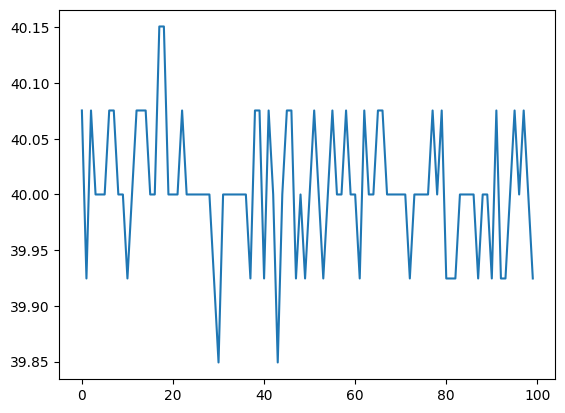

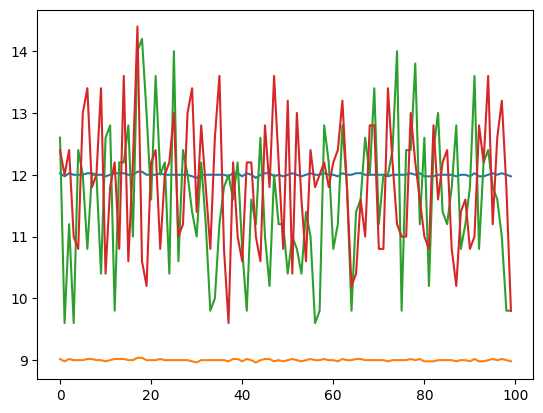

In [541]:
import matplotlib.pyplot as plt
k = 100
plt.plot(u_history[-k:])
plt.show()

plt.plot(qc_history[-k:])
plt.plot(qm_history[-k:])
plt.plot(q1_history[-k:])
plt.plot(q2_history[-k:])
plt.show()

### Correlations with shocks

In [542]:
k = 1000
np.corrcoef(q1_history[-k:], q2_history[-k:])

array([[1.  , 0.04],
       [0.04, 1.  ]])

### Impulse Response

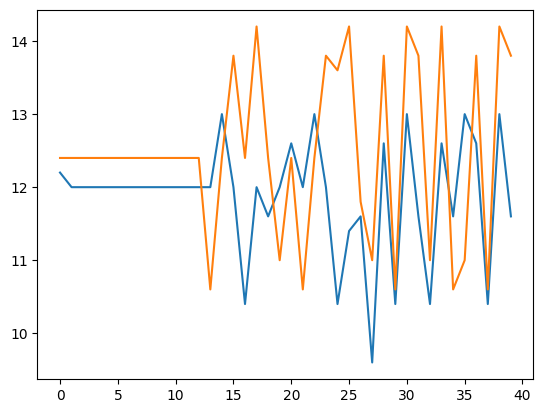

In [544]:
# initialize the state
state1 = int(num_states1/2)
state2 = int(num_states1/2)
u = 40
uidx = 4
q1_impulse=[]
q2_impulse=[]
# run Boltzmann Q-learning for a fixed number of episodes
num_episodes = 40
for episode in range(num_episodes):

    if episode in [13]:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = 5
    elif episode in [24]:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = num_actions-5  
    else:
        action1 = boltzmann_action_selection(Q1, state1,uidx,temperature)
        action2 = boltzmann_action_selection(Q2, state2,uidx,temperature)

    quantity1 = action2quantity[action1]
    quantity2 = action2quantity[action2]

    # take the selected action and observe the next state and reward
    next_state1 = action2
    next_state2 = action1

    # rewards
    reward1 = cournot(u,v,w,n).profit(quantity1,quantity2)
    reward2 = cournot(u,v,w,n).profit(quantity2,quantity1)

   # generate shock
    #uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]
    
    # move to the next state
    state1 = next_state1
    state2 = next_state2

    q1_impulse.append(quantity1)
    q2_impulse.append(quantity2)
    
import matplotlib.pyplot as plt
plt.plot(q1_impulse)
plt.plot(q2_impulse)
plt.show()